In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import importlib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from flearn.utils.model_utils import read_data
import os
import importlib
import random
import numpy as np

from flearn.models import client
from flearn.models import group
from flearn.trainers import grouprox
from flearn.trainers import fedprox
from flearn.trainers import fedavg

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


In [2]:
params = {}
#DATASETS = ['sent140', 'nist', 'shakespeare', 'mnist', 'synthetic_iid', 'synthetic_0_0', 'synthetic_0.5_0.5', 'synthetic_1_1']

"""
Parameters that need to be manually set
"""

params['dataset'] = 'sent140'
#params['dataset'] = 'nist'
#params['model'] = 'mlp'
params['model'] = 'stacked_lstm'
params['optimizer'] = 'grouprox'
params['drop_percent'] = 0

if params['dataset'].startswith('mnist'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.03
  params['mu'] = 1
  params['num_group'] = 3
if params['dataset'] == 'nist':
  params['model_params'] = (26,)
  params['learning_rate'] = 0.003
  params['mu'] = 1
  params['num_group'] = 5
if params['dataset'] == 'sent140':
  params['model_params'] = (25, 2, 100) # seq_len, num_classes, num_hidden
  params['learning_rate'] = 0.3
  params['mu'] = 0.01
  params['num_group'] = 5
if params['dataset'].startswith('synthetic'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.01
  params['mu'] = 1
  params['num_group'] = 5

if params['optimizer']  == 'fedavg':
  pass
if params['optimizer']  == 'fedprox':
  pass
if params['optimizer']  == 'grouprox':
  params['MADC'] = False                       # If false, EDC will be used
  params['proximal'] = False
  params['RAC'] = False
  params['RCC'] = False
  params['allow_empty'] = True
  params['agg_lr'] = 0.0 ########## Group Aggregataion Rate
  
  # TEST Hyperparameters, Experimental Only
  params['evenly'] = False
  params['min_clients'] = 2
    
  # We implement IFCA and FeSEM base on grouprox
  params['ifca'] = False
  params['fesem'] = False
  
  """
  We immplement IFCA and FeSEM base on grouprox,
  Some configurations should be flush for above two CFL frameworks
  """
  if params['ifca'] == True or params['fesem'] == True:
    params['proximal'] = False ### Do not modify it
    params['RAC'] = False
    params['RCC'] = False
    params['allow_empty'] = True
    params['agg_lr'] = 0.0 # IFCA and FeSEM don't use this parameter
    
"""
Common parameters
"""
params['num_rounds'] = 300
params['num_epochs'] = 20
params['batch_size'] = 10
params['eval_every'] = 1
params['clients_per_round'] = 20 ################ Important ######################
params['seed'] = 233

""" Set the output CSV file name """
info = '{}-{}-{}'.format(params['optimizer'], params['dataset'], params['model'])
info2 = ''
suffix = '.csv'
if params['optimizer'] == 'fedavg':
  pass
if params['optimizer'] == 'fedprox':
  pass
if params['optimizer'] == 'grouprox':
  if params['ifca'] == False and params['fesem'] == False:
    if params['MADC'] == True:
      info2 = info2 + '-MADC'
    else:
      info2 = info2 + '-EDC'
  if params['ifca'] == True:
    info2 = info2 + '-IFCA'
  if params['fesem'] == True:
    info2 = info2 + '-FeSEM'
  
  info2 = info2 +  '-NumG{:1d}-Agglr{:.4}-Proximal{:.1}'.format(
    params['num_group'], params['agg_lr'], str(params['proximal']))
  
  if params['RCC'] == True:
    info2 = info2 + '-RCC.{:.1}'.format(str(params['RCC']))
  
  if params['RAC'] == True:
    info2 = info2 + '-RAC.{:.1}-Evenly{:.1}'.format(str(params['RAC']), str(params['evenly']))
  elif params['allow_empty'] == True:
    info2 = info2 + '-Empty{:.1}'.format(str(params['allow_empty']))
  elif params['allow_empty'] == False:
    info2 = info2 + '-Evenly{:.1}'.format(str(params['evenly']))

params['export_filename'] = info + info2 + suffix

print(params['export_filename'])

grouprox-sent140-stacked_lstm-EDC-NumG5-Agglr0.0-ProximalF-EmptyT.csv


In [3]:
"""
Some preparations
"""

# read data
train_path = os.path.join('data', params['dataset'], 'data', 'train')
test_path = os.path.join('data', params['dataset'], 'data', 'test')
dataset = read_data(train_path, test_path)

# Load model
if params['dataset'].startswith('synthetic'):  # all synthetic datasets use the same model
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'synthetic', params['model'])
elif params['dataset'].startswith('mnist'):
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'mnist', params['model'])
else:
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', params['dataset'], params['model'])
mod = importlib.import_module(model_path)
learner = getattr(mod, 'Model')

# Set seeds
params['sklearn_seed'] = params['seed']
random.seed(1 + params['seed'])
np.random.seed(12 + params['seed'])
tf.set_random_seed(123 + params['seed'])

# Set server
if params['optimizer'] == 'fedavg':
  server = fedavg.Server(params, learner, dataset)  
if params['optimizer'] == 'fedprox':
  server = fedprox.Server(params, learner, dataset)
if params['optimizer'] == 'grouprox':
  server = grouprox.Server(params, learner, dataset)

Using Group prox to Train
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/ho

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

772 Clients in Total
243861 Parameters in Total


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Pre-training takes 16.077678680419922s seconds
SVD takes 0.3681468963623047s seconds
EDC Matrix calculation takes 0.09812211990356445s seconds
MADC Matrix calculation takes 0.10709643363952637s seconds
Clustering takes 0.030350685119628906s seconds
Clustering Results: Counter({1: 37, 0: 23, 4: 17, 3: 16, 2: 7})


In [4]:
"""
Test Ternary Similarity
"""
x, y = server.test_ternary_cosine_similariy()

Cossim_matrix shape: (772, 5)


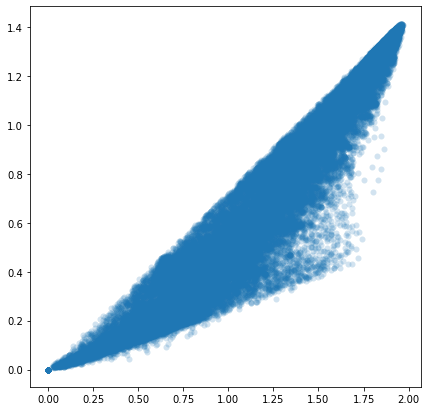

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(x[:50000], y[:50000], linewidths=0.01, alpha=0.2, norm=True)
plt.show()

In [6]:
server.train()

Training with 20 workers ---


Cold start clients takes 3.9473979473114014s seconds
Group 0, clients ['f_00018', 'f_00177', 'f_00146', 'f_00007', 'f_00033', 'f_00130', 'f_00037']
Group 1, clients ['f_00098', 'f_00061', 'f_00154']
Group 2, clients ['f_00180', 'f_00080', 'f_00074']
Group 3, clients ['f_00170', 'f_00107', 'f_00182', 'f_00012']
Group 4, clients ['f_00005', 'f_00152', 'f_00125']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 0 accuracy: 0.3536977491961415
At round 0 training accuracy: 0.3351206434316354
At round 0 training loss: 2.057251559048948
Group 1
At round 0 accuracy: 0.33665835411471323
At round 0 training accuracy: 0.3024075161479742
At round 0 training loss: 2.4798595564405987
Group 2
At round 0 accuracy: 0.3095890410958904
At round 0 training accuracy: 0.32813494589433484
At round 0 training loss: 2.0483407482912708
Group 3
At round 0 accuracy: 0.388671875
At round 0 training accuracy: 0.3863174531496952
At round 0 training loss: 2.4420242393547054
Group 4
At round 0 accuracy: 0.32238805970149254
At round 0 training accuracy: 0.3476879632897988
At round 0 training loss: 2.120469043333119
At round 0 mean test accuracy: 0.34563409563409564 mean train accuracy: 0.3429754582546739 mean train loss: 2.2578884511850297                     number of test client: 200
The client-group discrepancy are: [0.21658823 0.20469766 0.22267547 0.22785706 0.23910747 0.19695114]
Begin group  0 train

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.99it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.43it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.54it/s]

Begin group  4 training


Training groups takes 5.2526726722717285s seconds
Group 0, clients ['f_00058', 'f_00198', 'f_00018', 'f_00059']
Group 1, clients ['f_00004', 'f_00011']
Group 2, clients ['f_00040', 'f_00029', 'f_00110', 'f_00159']
Group 3, clients ['f_00034', 'f_00095', 'f_00171', 'f_00118', 'f_00136']
Group 4, clients ['f_00102', 'f_00184', 'f_00168', 'f_00089', 'f_00035']


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 118.23it/s]

Group 0
At round 1 accuracy: 0.5653710247349824
At round 1 training accuracy: 0.5512874630645842
At round 1 training loss: 1.6536213717364017
Group 1
At round 1 accuracy: 0.05102040816326531
At round 1 training accuracy: 0.05979567307692308
At round 1 training loss: 3.6262836574505153
Group 2
At round 1 accuracy: 0.5361111111111111
At round 1 training accuracy: 0.5157962604771116
At round 1 training loss: 1.7483419073850088
Group 3
At round 1 accuracy: 0.24765478424015008
At round 1 training accuracy: 0.24533217542336083
At round 1 training loss: 2.648997416198124
Group 4
At round 1 accuracy: 0.5365168539325843
At round 1 training accuracy: 0.5361405835543767
At round 1 training loss: 2.0934801537256975
At round 1 mean test accuracy: 0.36174636174636177 mean train accuracy: 0.3563729370927471 mean train loss: 2.431293823822691                     number of test client: 200
The client-group discrepancy are: [0.57419912 0.54132224 0.65333253 0.71171973 0.40593194 0.62709795]
Begin group 

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.89it/s]

Begin group  4 training


Training groups takes 4.069104909896851s seconds
Group 0, clients ['f_00115']
Group 1, clients ['f_00013', 'f_00174', 'f_00044', 'f_00003', 'f_00014']
Group 2, clients ['f_00029', 'f_00193', 'f_00010', 'f_00054', 'f_00126']
Group 3, clients ['f_00112', 'f_00182', 'f_00012', 'f_00092', 'f_00002', 'f_00113']
Group 4, clients ['f_00199', 'f_00085', 'f_00035']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 2 accuracy: 0.4375
At round 2 training accuracy: 0.38445552784704906
At round 2 training loss: 2.1945315418100715
Group 1
At round 2 accuracy: 0.468586387434555
At round 2 training accuracy: 0.4857493104505057
At round 2 training loss: 1.6824002011290657
Group 2
At round 2 accuracy: 0.5454545454545454
At round 2 training accuracy: 0.535108153078203
At round 2 training loss: 1.7402370652819235
Group 3
At round 2 accuracy: 0.03165735567970205
At round 2 training accuracy: 0.031067961165048542
At round 2 training loss: 4.7692491287038035
Group 4
At round 2 accuracy: 0.09863013698630137
At round 2 training accuracy: 0.099293059125964
At round 2 training loss: 3.224721778308671
At round 2 mean test accuracy: 0.28586278586278585 mean train accuracy: 0.2783630716765118 mean train loss: 2.931607759130995                     number of test client: 200
The client-group discrepancy are: [0.69373835 0.66518759 0.72503871 0.6721191  0.64968442 0.77522793]
Begin group  0 training
Be

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 49.55it/s]

Begin group  4 training


Training groups takes 3.4057300090789795s seconds
Group 0, clients ['f_00197', 'f_00070', 'f_00190', 'f_00095', 'f_00058']
Group 1, clients ['f_00170', 'f_00183', 'f_00003']
Group 2, clients ['f_00040', 'f_00179', 'f_00083', 'f_00159', 'f_00173']
Group 3, clients ['f_00051', 'f_00139', 'f_00041']
Group 4, clients ['f_00082', 'f_00046', 'f_00100', 'f_00025']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.86it/s]

Group 0
At round 3 accuracy: 0.003076923076923077
At round 3 training accuracy: 0.00918105031215571
At round 3 training loss: 4.920196896106322
Group 1
At round 3 accuracy: 0.544973544973545
At round 3 training accuracy: 0.5072732900030951
At round 3 training loss: 2.0929279498587596
Group 2
At round 3 accuracy: 0.5737704918032787
At round 3 training accuracy: 0.5702702702702702
At round 3 training loss: 1.605313682164925
Group 3
At round 3 accuracy: 0.5877862595419847
At round 3 training accuracy: 0.5965106007067138
At round 3 training loss: 1.9627279396902757
Group 4
At round 3 accuracy: 0.25255102040816324
At round 3 training accuracy: 0.2675425500149298
At round 3 training loss: 2.4885064100073
At round 3 mean test accuracy: 0.4100831600831601 mean train accuracy: 0.4103282382315328 mean train loss: 2.5296235837604493                     number of test client: 200
The client-group discrepancy are: [0.76514876 0.59527802 0.69399845 0.74182339 0.85479637 0.99277093]
Begin group  0 tr

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.26it/s]

Begin group  4 training


Training groups takes 3.605419397354126s seconds
Group 0, clients ['f_00177', 'f_00088', 'f_00191', 'f_00033']
Group 1, clients ['f_00011', 'f_00123', 'f_00188', 'f_00084']
Group 2, clients ['f_00099', 'f_00090', 'f_00187', 'f_00061', 'f_00184', 'f_00138']
Group 3, clients ['f_00128', 'f_00001', 'f_00111', 'f_00199', 'f_00171']
Group 4, clients ['f_00175']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.32it/s]

Group 0
At round 4 accuracy: 0.17133956386292834
At round 4 training accuracy: 0.16127833519137866
At round 4 training loss: 3.5725099509509244
Group 1
At round 4 accuracy: 0.2830687830687831
At round 4 training accuracy: 0.3172690763052209
At round 4 training loss: 1.8593049690537073
Group 2
At round 4 accuracy: 0.5851393188854489
At round 4 training accuracy: 0.5940811107051516
At round 4 training loss: 1.5409955369280688
Group 3
At round 4 accuracy: 0.23551401869158878
At round 4 training accuracy: 0.22003886849492552
At round 4 training loss: 2.473685396139783
Group 4
At round 4 accuracy: 0.0681198910081744
At round 4 training accuracy: 0.07104
At round 4 training loss: 2.9829072730636597
At round 4 mean test accuracy: 0.2609147609147609 mean train accuracy: 0.2635649473235491 mean train loss: 2.4740954597926548                     number of test client: 200
The client-group discrepancy are: [0.90802067 0.83658997 0.8399074  1.07840909 0.76758216 1.14605866]
Begin group  0 training

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 3.914519786834717s seconds
Group 0, clients ['f_00077', 'f_00148', 'f_00028', 'f_00055']
Group 1, clients ['f_00154', 'f_00104', 'f_00003', 'f_00039', 'f_00134']
Group 2, clients ['f_00149', 'f_00040', 'f_00117']
Group 3, clients ['f_00119', 'f_00151', 'f_00122', 'f_00071', 'f_00188', 'f_00021']
Group 4, clients ['f_00006', 'f_00034']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 5 accuracy: 0.5331230283911672
At round 5 training accuracy: 0.5120754716981132
At round 5 training loss: 1.7045588195099022
Group 1
At round 5 accuracy: 0.5157068062827225
At round 5 training accuracy: 0.5024494794856094
At round 5 training loss: 2.075055996333611
Group 2
At round 5 accuracy: 0.5968253968253968
At round 5 training accuracy: 0.5815602836879432
At round 5 training loss: 1.4280681768741657
Group 3
At round 5 accuracy: 0.08193668528864059
At round 5 training accuracy: 0.08048203141811922
At round 5 training loss: 3.9006328995519746
Group 4
At round 5 accuracy: 0.2761394101876676
At round 5 training accuracy: 0.2695816294432211
At round 5 training loss: 2.787747266589564
At round 5 mean test accuracy: 0.36434511434511435 mean train accuracy: 0.3524145910724073 mean train loss: 2.564307779445768                     number of test client: 200
The client-group discrepancy are: [1.01845937 1.03330764 1.09202628 0.8929534  0.9782919  1.11360697]
Begin group  0 

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 58.26it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 88.89it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.516425609588623s seconds
Group 0, clients ['f_00088', 'f_00108', 'f_00158']
Group 1, clients ['f_00134', 'f_00004', 'f_00094', 'f_00013']
Group 2, clients ['f_00011', 'f_00149', 'f_00152', 'f_00145', 'f_00019', 'f_00030']
Group 3, clients ['f_00118', 'f_00151']
Group 4, clients ['f_00093', 'f_00006', 'f_00081', 'f_00156', 'f_00115']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 6 accuracy: 0.46794871794871795
At round 6 training accuracy: 0.4397244546498278
At round 6 training loss: 1.617082370454399
Group 1
At round 6 accuracy: 0.6554621848739496
At round 6 training accuracy: 0.6204523107177975
At round 6 training loss: 1.7575241010410205
Group 2
At round 6 accuracy: 0.17478510028653296
At round 6 training accuracy: 0.17429340511440108
At round 6 training loss: 2.2559065927085773
Group 3
At round 6 accuracy: 0.530188679245283
At round 6 training accuracy: 0.5340017436791631
At round 6 training loss: 1.7049693509533599
Group 4
At round 6 accuracy: 0.2632978723404255
At round 6 training accuracy: 0.2568032530497341
At round 6 training loss: 2.2951344153565616
At round 6 mean test accuracy: 0.4267151767151767 mean train accuracy: 0.4159917179221728 mean train loss: 1.9153608652257679                     number of test client: 200
The client-group discrepancy are: [0.94077897 0.83346466 0.78302828 1.05665273 0.72338147 1.07927859]
Begin group  0

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.90it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.23it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 49.20it/s]

Begin group  4 training


Training groups takes 4.3905348777771s seconds
Group 0, clients ['f_00022', 'f_00108', 'f_00155', 'f_00046']
Group 1, clients ['f_00086', 'f_00094', 'f_00063', 'f_00024', 'f_00153']
Group 2, clients ['f_00120', 'f_00099']
Group 3, clients ['f_00011', 'f_00002', 'f_00121', 'f_00138', 'f_00188']
Group 4, clients ['f_00195', 'f_00066', 'f_00096', 'f_00065']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 7 accuracy: 0.4876543209876543
At round 7 training accuracy: 0.4700665188470067
At round 7 training loss: 2.6318204671430836
Group 1
At round 7 accuracy: 0.6391184573002755
At round 7 training accuracy: 0.6047711154094133
At round 7 training loss: 1.8311124966845522
Group 2
At round 7 accuracy: 0.3620178041543027
At round 7 training accuracy: 0.3609467455621302
At round 7 training loss: 1.8576588483791172
Group 3
At round 7 accuracy: 0.06890130353817504
At round 7 training accuracy: 0.0643010752688172
At round 7 training loss: 6.294776183584685
Group 4
At round 7 accuracy: 0.3415977961432507
At round 7 training accuracy: 0.3485436893203884
At round 7 training loss: 1.8979517115744187
At round 7 mean test accuracy: 0.3497920997920998 mean train accuracy: 0.3386517264478412 mean train loss: 3.2442756873900254                     number of test client: 200
The client-group discrepancy are: [1.15191283 0.91279282 1.27883318 0.90374369 1.06423862 1.46605976]
Begin group  0 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.94it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.934417486190796s seconds
Group 0, clients ['f_00067', 'f_00088', 'f_00169']
Group 1, clients ['f_00069', 'f_00142', 'f_00027', 'f_00103']
Group 2, clients ['f_00128', 'f_00119', 'f_00146', 'f_00150', 'f_00000']
Group 3, clients ['f_00181', 'f_00117', 'f_00151', 'f_00190', 'f_00001']
Group 4, clients ['f_00193', 'f_00161', 'f_00065']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.71it/s]

Group 0
At round 8 accuracy: 0.4512987012987013
At round 8 training accuracy: 0.4342105263157895
At round 8 training loss: 1.7701788394028557
Group 1
At round 8 accuracy: 0.6272965879265092
At round 8 training accuracy: 0.6233087330873309
At round 8 training loss: 1.634114335585491
Group 2
At round 8 accuracy: 0.5121212121212121
At round 8 training accuracy: 0.5140819964349376
At round 8 training loss: 1.9617134179235993
Group 3
At round 8 accuracy: 0.5344506517690876
At round 8 training accuracy: 0.5253110253110254
At round 8 training loss: 2.129529897821967
Group 4
At round 8 accuracy: 0.49184782608695654
At round 8 training accuracy: 0.47530468248877483
At round 8 training loss: 2.5020682192751043
At round 8 mean test accuracy: 0.5275467775467776 mean train accuracy: 0.51896961208209 mean train loss: 2.0169420357446244                     number of test client: 200
The client-group discrepancy are: [1.24200955 0.97977404 1.65033924 1.24620593 1.15273176 1.1016078 ]
Begin group  0 tr

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.24it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.79it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.1280815601348877s seconds
Group 0, clients ['f_00054', 'f_00039', 'f_00027', 'f_00037']
Group 1, clients ['f_00084', 'f_00123', 'f_00103', 'f_00003', 'f_00163', 'f_00174']
Group 2, clients ['f_00109', 'f_00140', 'f_00053', 'f_00101', 'f_00100', 'f_00069']
Group 3 is empty.
Group 4, clients ['f_00060', 'f_00156', 'f_00116', 'f_00158']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 9 accuracy: 0.594855305466238
At round 9 training accuracy: 0.5983764978739853
At round 9 training loss: 2.21653299833708
Group 1
At round 9 accuracy: 0.3498452012383901
At round 9 training accuracy: 0.37245639534883723
At round 9 training loss: 1.9149912237081417
Group 2
At round 9 accuracy: 0.47848101265822784
At round 9 training accuracy: 0.47516262566528683
At round 9 training loss: 2.235525325055238
Group 3
At round 9 accuracy: 0.36466165413533835
At round 9 training accuracy: 0.37794594594594594
At round 9 training loss: 2.0835898276148614
Group 4
At round 9 accuracy: 0.6060606060606061
At round 9 training accuracy: 0.5720325203252032
At round 9 training loss: 1.9806636524006602
At round 9 mean test accuracy: 0.4682952182952183 mean train accuracy: 0.468120090128494 mean train loss: 2.0882965134602287                     number of test client: 200
The client-group discrepancy are: [1.24969026 1.51919248 0.86629715 1.41985052 0.         1.30003732]
Begin group  0 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.01it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.400679349899292s seconds
Group 0, clients ['f_00059', 'f_00198', 'f_00052', 'f_00142', 'f_00078']
Group 1, clients ['f_00098', 'f_00010', 'f_00063']
Group 2, clients ['f_00020', 'f_00019', 'f_00075', 'f_00124', 'f_00109']
Group 3, clients ['f_00162', 'f_00055', 'f_00002', 'f_00111']
Group 4, clients ['f_00005', 'f_00069', 'f_00185']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 10 accuracy: 0.4835820895522388
At round 10 training accuracy: 0.5046428571428572
At round 10 training loss: 2.3130010385172706
Group 1
At round 10 accuracy: 0.6049382716049383
At round 10 training accuracy: 0.598113891911498
At round 10 training loss: 2.351280620533096
Group 2
At round 10 accuracy: 0.4744897959183674
At round 10 training accuracy: 0.46551724137931033
At round 10 training loss: 1.8027476854046516
Group 3
At round 10 accuracy: 0.3586744639376218
At round 10 training accuracy: 0.37690925426774485
At round 10 training loss: 2.0996986784489438
Group 4
At round 10 accuracy: 0.21666666666666667
At round 10 training accuracy: 0.22703412073490814
At round 10 training loss: 2.208493129631353
At round 10 mean test accuracy: 0.4189189189189189 mean train accuracy: 0.426161622312892 mean train loss: 2.1376695918598387                     number of test client: 200
The client-group discrepancy are: [1.39246583 1.61962818 1.3818978  1.30346726 1.12648267 1.52740513]

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.23it/s]

Begin group  1 training


Epoch:  55%|█████████████████████████████████████████▊                                  | 11/20 [00:00<00:00, 99.52it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.55it/s]

Begin group  4 training


Training groups takes 5.1747095584869385s seconds
Group 0, clients ['f_00060']
Group 1, clients ['f_00174', 'f_00053', 'f_00134', 'f_00094', 'f_00073', 'f_00041', 'f_00014', 'f_00063']
Group 2, clients ['f_00033', 'f_00022', 'f_00143', 'f_00055', 'f_00000']
Group 3, clients ['f_00173', 'f_00186', 'f_00130', 'f_00016', 'f_00111']
Group 4, clients ['f_00056']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 11 accuracy: 0.10030395136778116
At round 11 training accuracy: 0.10191543187567763
At round 11 training loss: 2.925980247613709
Group 1
At round 11 accuracy: 0.0443213296398892
At round 11 training accuracy: 0.050226830848995464
At round 11 training loss: 4.157891575732327
Group 2
At round 11 accuracy: 0.10989010989010989
At round 11 training accuracy: 0.12334088701845257
At round 11 training loss: 2.2665667622249157
Group 3
At round 11 accuracy: 0.5393474088291746
At round 11 training accuracy: 0.5408276167293649
At round 11 training loss: 1.7689584648617076
Group 4
At round 11 accuracy: 0.6389684813753582
At round 11 training accuracy: 0.6067567567567568
At round 11 training loss: 2.2503620479557966
At round 11 mean test accuracy: 0.3082120582120582 mean train accuracy: 0.30802021801351925 mean train loss: 2.593256223191588                     number of test client: 200
The client-group discrepancy are: [1.29615221 1.55834015 1.12857966 1.24419113 1.43749536 1.92763

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 3.7979867458343506s seconds
Group 0, clients ['f_00120', 'f_00031', 'f_00016']
Group 1, clients ['f_00063', 'f_00164', 'f_00132']
Group 2, clients ['f_00061', 'f_00032', 'f_00007', 'f_00095', 'f_00138']
Group 3, clients ['f_00182', 'f_00172', 'f_00021', 'f_00181']
Group 4, clients ['f_00023', 'f_00011', 'f_00173', 'f_00098', 'f_00085']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.85it/s]

Group 0
At round 12 accuracy: 0.15976331360946747
At round 12 training accuracy: 0.15763546798029557
At round 12 training loss: 4.350853206908342
Group 1
At round 12 accuracy: 0.6430769230769231
At round 12 training accuracy: 0.6379746835443038
At round 12 training loss: 1.7252797163847773
Group 2
At round 12 accuracy: 0.35501355013550134
At round 12 training accuracy: 0.3737179487179487
At round 12 training loss: 1.9700649063938702
Group 3
At round 12 accuracy: 0.6183673469387755
At round 12 training accuracy: 0.615348619560131
At round 12 training loss: 1.3563543855167741
Group 4
At round 12 accuracy: 0.47761194029850745
At round 12 training accuracy: 0.4847953216374269
At round 12 training loss: 2.8022032371477077
At round 12 mean test accuracy: 0.46205821205821207 mean train accuracy: 0.4668412398757688 mean train loss: 2.35446802585288                     number of test client: 200
The client-group discrepancy are: [1.48731813 1.51483219 1.58831571 1.54054101 1.1789465  1.60368558

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.82it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 71.78it/s]

Begin group  4 training


Training groups takes 3.9448394775390625s seconds
Group 0, clients ['f_00198', 'f_00097', 'f_00095', 'f_00106', 'f_00089']
Group 1, clients ['f_00042', 'f_00128', 'f_00033', 'f_00104']
Group 2, clients ['f_00159', 'f_00110', 'f_00070']
Group 3, clients ['f_00179']
Group 4, clients ['f_00155', 'f_00023', 'f_00096', 'f_00065', 'f_00102', 'f_00132', 'f_00079']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 13 accuracy: 0.14106583072100312
At round 13 training accuracy: 0.12401648557512177
At round 13 training loss: 4.023805663263186
Group 1
At round 13 accuracy: 0.649390243902439
At round 13 training accuracy: 0.6626030835424883
At round 13 training loss: 1.5935554091927824
Group 2
At round 13 accuracy: 0.20430107526881722
At round 13 training accuracy: 0.19531497309275087
At round 13 training loss: 2.1199344293948177
Group 3
At round 13 accuracy: 0.5194274028629857
At round 13 training accuracy: 0.5304735114861697
At round 13 training loss: 1.8348448325561573
Group 4
At round 13 accuracy: 0.2956730769230769
At round 13 training accuracy: 0.2956472583380441
At round 13 training loss: 2.1076512918120525
At round 13 mean test accuracy: 0.3695426195426195 mean train accuracy: 0.3717800377565313 mean train loss: 2.2632698702918184                     number of test client: 200
The client-group discrepancy are: [1.46522463 1.55527051 1.88593826 1.27982006 1.60756572 1.2196230

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.07it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.783628225326538s seconds
Group 0, clients ['f_00198', 'f_00093', 'f_00047', 'f_00157']
Group 1, clients ['f_00114', 'f_00005', 'f_00024', 'f_00112', 'f_00044', 'f_00064']
Group 2, clients ['f_00069', 'f_00149']
Group 3, clients ['f_00151', 'f_00051', 'f_00122']
Group 4, clients ['f_00189', 'f_00015', 'f_00155', 'f_00006', 'f_00175']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 14 accuracy: 0.47181008902077154
At round 14 training accuracy: 0.4626548672566372
At round 14 training loss: 1.9550746623604698
Group 1
At round 14 accuracy: 0.5512465373961218
At round 14 training accuracy: 0.5551937479648323
At round 14 training loss: 1.4851789891583955
Group 2
At round 14 accuracy: 0.5340599455040872
At round 14 training accuracy: 0.5419602818705958
At round 14 training loss: 2.450144703803652
Group 3
At round 14 accuracy: 0.13871635610766045
At round 14 training accuracy: 0.12698412698412698
At round 14 training loss: 4.560230382837071
Group 4
At round 14 accuracy: 0.10638297872340426
At round 14 training accuracy: 0.13984915147705845
At round 14 training loss: 2.244123857175682
At round 14 mean test accuracy: 0.34355509355509356 mean train accuracy: 0.3462030327020279 mean train loss: 2.68698355286749                     number of test client: 200
The client-group discrepancy are: [1.4976238  1.47038909 1.9758581  1.16332298 0.97576569 1.39236561

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.59it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.41it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.35it/s]

Begin group  4 training


Training groups takes 4.357681512832642s seconds
Group 0, clients ['f_00049', 'f_00127', 'f_00170', 'f_00138', 'f_00058', 'f_00026', 'f_00198']
Group 1, clients ['f_00146', 'f_00115', 'f_00184']
Group 2, clients ['f_00040', 'f_00030', 'f_00150']
Group 3, clients ['f_00012', 'f_00172', 'f_00192', 'f_00072', 'f_00009']
Group 4, clients ['f_00191', 'f_00057']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 15 accuracy: 0.49570200573065903
At round 15 training accuracy: 0.48274683976768024
At round 15 training loss: 1.6624348152201047
Group 1
At round 15 accuracy: 0.4501347708894879
At round 15 training accuracy: 0.45870393900889456
At round 15 training loss: 1.7701806692262163
Group 2
At round 15 accuracy: 0.49127906976744184
At round 15 training accuracy: 0.4785568413886998
At round 15 training loss: 3.085040901878239
Group 3
At round 15 accuracy: 0.5573770491803278
At round 15 training accuracy: 0.5662989908472189
At round 15 training loss: 2.0814034972664226
Group 4
At round 15 accuracy: 0.4731182795698925
At round 15 training accuracy: 0.46107403876707975
At round 15 training loss: 1.853184127640944
At round 15 mean test accuracy: 0.4974012474012474 mean train accuracy: 0.4949150478046404 mean train loss: 2.0828911985950866                     number of test client: 200
The client-group discrepancy are: [1.66819023 1.60465321 2.05512833 1.00549994 1.77322939 2.041600

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.6494853496551514s seconds
Group 0, clients ['f_00059']
Group 1, clients ['f_00154', 'f_00174', 'f_00073', 'f_00032', 'f_00054', 'f_00134', 'f_00187']
Group 2, clients ['f_00000', 'f_00170', 'f_00007', 'f_00029', 'f_00090']
Group 3, clients ['f_00072', 'f_00051', 'f_00100']
Group 4, clients ['f_00112', 'f_00096', 'f_00056', 'f_00081']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 16 accuracy: 0.46920821114369504
At round 16 training accuracy: 0.44092018124782156
At round 16 training loss: 1.624829798510948
Group 1
At round 16 accuracy: 0.616
At round 16 training accuracy: 0.6222432262129804
At round 16 training loss: 1.5521002135415007
Group 2
At round 16 accuracy: 0.6049382716049383
At round 16 training accuracy: 0.6167751265365148
At round 16 training loss: 2.3578486213715113
Group 3
At round 16 accuracy: 0.6245059288537549
At round 16 training accuracy: 0.6357466063348416
At round 16 training loss: 1.9207806201070143
Group 4
At round 16 accuracy: 0.1693121693121693
At round 16 training accuracy: 0.16635338345864661
At round 16 training loss: 3.523600340001565
At round 16 mean test accuracy: 0.5025987525987526 mean train accuracy: 0.5046586687777845 mean train loss: 2.182997057583596                     number of test client: 200
The client-group discrepancy are: [1.09756875 0.69418201 1.4517356  1.00555477 0.70260525 0.98986352]
Begin group 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 81.61it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.856372594833374s seconds
Group 0, clients ['f_00146', 'f_00197', 'f_00075', 'f_00157', 'f_00126', 'f_00087']
Group 1, clients ['f_00158', 'f_00103']
Group 2, clients ['f_00000', 'f_00080', 'f_00109', 'f_00016']
Group 3, clients ['f_00082', 'f_00071', 'f_00147', 'f_00192']
Group 4, clients ['f_00176', 'f_00085', 'f_00095', 'f_00138']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.17it/s]

Group 0
At round 17 accuracy: 0.3495702005730659
At round 17 training accuracy: 0.32596872875594834
At round 17 training loss: 3.280680113396703
Group 1
At round 17 accuracy: 0.5774278215223098
At round 17 training accuracy: 0.6030274945937597
At round 17 training loss: 1.585061948406943
Group 2
At round 17 accuracy: 0.5774193548387097
At round 17 training accuracy: 0.5885692657077971
At round 17 training loss: 2.061267073997307
Group 3
At round 17 accuracy: 0.39264990328820115
At round 17 training accuracy: 0.4220793615606296
At round 17 training loss: 1.977227801693646
Group 4
At round 17 accuracy: 0.4904632152588556
At round 17 training accuracy: 0.5192618970540628
At round 17 training loss: 1.8966828356594976
At round 17 mean test accuracy: 0.4698544698544699 mean train accuracy: 0.48559771024907133 mean train loss: 2.1318191293404474                     number of test client: 200
The client-group discrepancy are: [1.44879916 1.62192075 1.41010684 1.05149231 1.48058516 1.57398376]


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 84.60it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.12it/s]

Begin group  3 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 119.07it/s]

Begin group  4 training


Training groups takes 3.7039875984191895s seconds
Group 0, clients ['f_00108', 'f_00047', 'f_00033', 'f_00128', 'f_00088']
Group 1, clients ['f_00134', 'f_00081', 'f_00044', 'f_00074', 'f_00049']
Group 2, clients ['f_00040', 'f_00109']
Group 3, clients ['f_00091', 'f_00170', 'f_00039', 'f_00151', 'f_00012']
Group 4, clients ['f_00186', 'f_00006', 'f_00025']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.74it/s]

Group 0
At round 18 accuracy: 0.47230320699708456
At round 18 training accuracy: 0.4676582497405742
At round 18 training loss: 2.4285513831644643
Group 1
At round 18 accuracy: 0.05555555555555555
At round 18 training accuracy: 0.054367201426024955
At round 18 training loss: 2.5170897455068126
Group 2
At round 18 accuracy: 0.6161616161616161
At round 18 training accuracy: 0.648936170212766
At round 18 training loss: 2.0461492716232748
Group 3
At round 18 accuracy: 0.5782442748091603
At round 18 training accuracy: 0.5731814198071867
At round 18 training loss: 1.6708400023025343
Group 4
At round 18 accuracy: 0.45879120879120877
At round 18 training accuracy: 0.4640757674722404
At round 18 training loss: 1.787823684635231
At round 18 mean test accuracy: 0.43503118503118504 mean train accuracy: 0.4396199987820474 mean train loss: 2.057525295435486                     number of test client: 200
The client-group discrepancy are: [1.25910856 1.42162298 1.50004472 0.24284593 1.33932936 1.130498

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.40it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.49it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.7744524478912354s seconds
Group 0, clients ['f_00148', 'f_00031', 'f_00078', 'f_00037', 'f_00169', 'f_00157']
Group 1, clients ['f_00013', 'f_00094', 'f_00163', 'f_00016']
Group 2, clients ['f_00040', 'f_00140', 'f_00020', 'f_00180']
Group 3, clients ['f_00033', 'f_00091', 'f_00072']
Group 4, clients ['f_00196', 'f_00105', 'f_00152']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 19 accuracy: 0.4750733137829912
At round 19 training accuracy: 0.46615758417216246
At round 19 training loss: 2.2375458504374928
Group 1
At round 19 accuracy: 0.6516290726817042
At round 19 training accuracy: 0.6775907883082374
At round 19 training loss: 1.1719757223907108
Group 2
At round 19 accuracy: 0.6036363636363636
At round 19 training accuracy: 0.6004255319148936
At round 19 training loss: 1.6398023770971502
Group 3
At round 19 accuracy: 0.4790874524714829
At round 19 training accuracy: 0.49169217315260166
At round 19 training loss: 2.0370852229086447
Group 4
At round 19 accuracy: 0.3681462140992167
At round 19 training accuracy: 0.3821616599566429
At round 19 training loss: 2.6260373608989958
At round 19 mean test accuracy: 0.5098752598752598 mean train accuracy: 0.5195785883929115 mean train loss: 1.9527732416389412                     number of test client: 200
The client-group discrepancy are: [1.17194993 0.85458411 1.39194913 0.85962025 0.7530831  2.3486556

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.38it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 55.43it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.109251260757446s seconds
Group 0, clients ['f_00028', 'f_00178', 'f_00177', 'f_00047', 'f_00077', 'f_00187', 'f_00167']
Group 1, clients ['f_00013', 'f_00195', 'f_00136', 'f_00084']
Group 2, clients ['f_00150', 'f_00109', 'f_00168', 'f_00155']
Group 3, clients ['f_00121', 'f_00192']
Group 4, clients ['f_00196', 'f_00166', 'f_00175']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 20 accuracy: 0.5449275362318841
At round 20 training accuracy: 0.5294924554183813
At round 20 training loss: 1.9681745685831182
Group 1
At round 20 accuracy: 0.5947242206235012
At round 20 training accuracy: 0.6060349689791314
At round 20 training loss: 1.5355666033961446
Group 2
At round 20 accuracy: 0.6690391459074733
At round 20 training accuracy: 0.6818371607515658
At round 20 training loss: 2.0466716544986516
Group 3
At round 20 accuracy: 0.5078431372549019
At round 20 training accuracy: 0.5317997293640054
At round 20 training loss: 1.920244724452361
Group 4
At round 20 accuracy: 0.42318059299191374
At round 20 training accuracy: 0.44376996805111824
At round 20 training loss: 1.8716334864735222
At round 20 mean test accuracy: 0.5405405405405406 mean train accuracy: 0.5525242068083551 mean train loss: 1.8548610164447517                     number of test client: 200
The client-group discrepancy are: [1.36545602 1.65220237 1.48852774 1.23969214 0.66849013 1.16461466

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.90it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.42it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.3893816471099854s seconds
Group 0, clients ['f_00017', 'f_00042', 'f_00145', 'f_00087']
Group 1, clients ['f_00144', 'f_00183', 'f_00013']
Group 2, clients ['f_00009', 'f_00020', 'f_00129', 'f_00124']
Group 3, clients ['f_00052', 'f_00091', 'f_00021', 'f_00092', 'f_00101']
Group 4, clients ['f_00045', 'f_00006', 'f_00105', 'f_00152']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 21 accuracy: 0.5934718100890207
At round 21 training accuracy: 0.5848591549295775
At round 21 training loss: 1.9976967642214936
Group 1
At round 21 accuracy: 0.51338199513382
At round 21 training accuracy: 0.4889842632331903
At round 21 training loss: 1.4773590400665786
Group 2
At round 21 accuracy: 0.5897435897435898
At round 21 training accuracy: 0.5684255684255685
At round 21 training loss: 1.3303832173449754
Group 3
At round 21 accuracy: 0.5845864661654135
At round 21 training accuracy: 0.5954594594594594
At round 21 training loss: 2.2325208987255354
Group 4
At round 21 accuracy: 0.4366576819407008
At round 21 training accuracy: 0.45718849840255593
At round 21 training loss: 2.5417607251161964
At round 21 mean test accuracy: 0.5431392931392931 mean train accuracy: 0.5407709640095 mean train loss: 1.962065170286351                     number of test client: 200
The client-group discrepancy are: [1.41467502 1.74827885 1.83679498 1.29569698 1.38565926 0.91972895]
Begi

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 38.92it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.801877975463867s seconds
Group 0, clients ['f_00157', 'f_00098', 'f_00078', 'f_00124', 'f_00087']
Group 1, clients ['f_00144', 'f_00032', 'f_00163', 'f_00075', 'f_00104']
Group 2, clients ['f_00189', 'f_00176', 'f_00020', 'f_00128', 'f_00036', 'f_00135']
Group 3, clients ['f_00091', 'f_00170', 'f_00012']
Group 4, clients ['f_00046']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 108.14it/s]

Group 0
At round 22 accuracy: 0.5734072022160664
At round 22 training accuracy: 0.5871199738476627
At round 22 training loss: 2.107919712517144
Group 1
At round 22 accuracy: 0.5683962264150944
At round 22 training accuracy: 0.5959567986707284
At round 22 training loss: 1.665013195833847
Group 2
At round 22 accuracy: 0.5886287625418061
At round 22 training accuracy: 0.5867507886435331
At round 22 training loss: 1.3929514590451018
Group 3
At round 22 accuracy: 0.5263157894736842
At round 22 training accuracy: 0.5318918918918919
At round 22 training loss: 1.808315241981197
Group 4
At round 22 accuracy: 0.6363636363636364
At round 22 training accuracy: 0.6366795366795367
At round 22 training loss: 1.432186088230619
At round 22 mean test accuracy: 0.5717255717255717 mean train accuracy: 0.5812678886791304 mean train loss: 1.7091427996811814                     number of test client: 200
The client-group discrepancy are: [1.14281495 0.92998327 0.77270157 1.83474435 0.41477664 2.09007868]
Beg

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.49it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.01it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 4.7581727504730225s seconds
Group 0, clients ['f_00077', 'f_00119', 'f_00097', 'f_00198', 'f_00157']
Group 1, clients ['f_00188', 'f_00014', 'f_00174']
Group 2, clients ['f_00030', 'f_00019', 'f_00081', 'f_00199', 'f_00140']
Group 3, clients ['f_00072', 'f_00191', 'f_00024', 'f_00092']
Group 4, clients ['f_00185', 'f_00075', 'f_00046']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 23 accuracy: 0.5162162162162162
At round 23 training accuracy: 0.5149968091895342
At round 23 training loss: 1.7787900409674904
Group 1
At round 23 accuracy: 0.6039603960396039
At round 23 training accuracy: 0.6204889406286379
At round 23 training loss: 1.372357964784566
Group 2
At round 23 accuracy: 0.5587301587301587
At round 23 training accuracy: 0.5238627889634601
At round 23 training loss: 1.5250658007542826
Group 3
At round 23 accuracy: 0.6091954022988506
At round 23 training accuracy: 0.6097130242825607
At round 23 training loss: 1.893696948073426
Group 4
At round 23 accuracy: 0.4281150159744409
At round 23 training accuracy: 0.4312239484653278
At round 23 training loss: 2.5504012374477703
At round 23 mean test accuracy: 0.5524948024948025 mean train accuracy: 0.5511844589245478 mean train loss: 1.8080100160411763                     number of test client: 200
The client-group discrepancy are: [1.11826477 0.84585855 1.34162912 1.23321052 1.30644276 0.90643055]
B

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.57it/s]

Begin group  1 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 109.79it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.26it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 100.40it/s]

Begin group  4 training


Training groups takes 3.5576021671295166s seconds
Group 0, clients ['f_00197', 'f_00196', 'f_00142', 'f_00102', 'f_00054']
Group 1, clients ['f_00014', 'f_00144']
Group 2, clients ['f_00109', 'f_00029', 'f_00159', 'f_00000']
Group 3, clients ['f_00072', 'f_00091', 'f_00069']
Group 4, clients ['f_00101', 'f_00125', 'f_00048', 'f_00190', 'f_00025', 'f_00026']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.20it/s]

Group 0
At round 24 accuracy: 0.46153846153846156
At round 24 training accuracy: 0.4542157751586582
At round 24 training loss: 2.0515781171230363
Group 1
At round 24 accuracy: 0.6334164588528678
At round 24 training accuracy: 0.6518431831480398
At round 24 training loss: 1.6092929617050031
Group 2
At round 24 accuracy: 0.5147540983606558
At round 24 training accuracy: 0.5175472425761666
At round 24 training loss: 1.8069848753152737
Group 3
At round 24 accuracy: 0.620889748549323
At round 24 training accuracy: 0.6456990442320516
At round 24 training loss: 1.4202228970304016
Group 4
At round 24 accuracy: 0.5659163987138264
At round 24 training accuracy: 0.5530361260568794
At round 24 training loss: 2.5112801853805022
At round 24 mean test accuracy: 0.5654885654885655 mean train accuracy: 0.5734729919006151 mean train loss: 1.8207588435820095                     number of test client: 200
The client-group discrepancy are: [1.24379633 1.6599936  0.09412334 0.58000321 0.67695666 2.00613818]

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 83.86it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 84.86it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.104803800582886s seconds
Group 0, clients ['f_00148', 'f_00193', 'f_00126', 'f_00120', 'f_00068', 'f_00169', 'f_00097']
Group 1, clients ['f_00082', 'f_00103', 'f_00102']
Group 2, clients ['f_00135', 'f_00040', 'f_00117']
Group 3, clients ['f_00101', 'f_00069', 'f_00111', 'f_00122']
Group 4, clients ['f_00035', 'f_00176', 'f_00081']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 25 accuracy: 0.06504065040650407
At round 25 training accuracy: 0.0781099324975892
At round 25 training loss: 2.639934354850005
Group 1
At round 25 accuracy: 0.6105990783410138
At round 25 training accuracy: 0.6285021551724138
At round 25 training loss: 2.026920272776022
Group 2
At round 25 accuracy: 0.5927152317880795
At round 25 training accuracy: 0.5704854368932039
At round 25 training loss: 1.9348349001106706
Group 3
At round 25 accuracy: 0.5711462450592886
At round 25 training accuracy: 0.5925841674249318
At round 25 training loss: 1.4042153291411026
Group 4
At round 25 accuracy: 0.5750798722044729
At round 25 training accuracy: 0.5519604111153407
At round 25 training loss: 1.543078727580587
At round 25 mean test accuracy: 0.487006237006237 mean train accuracy: 0.4932708117654223 mean train loss: 1.8845114245494443                     number of test client: 200
The client-group discrepancy are: [1.42018144 1.2331564  1.92209033 0.97462    1.20784509 2.08334086]
Be

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.27it/s]

Begin group  1 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 64.86it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 79.58it/s]

Begin group  4 training


Training groups takes 4.387807607650757s seconds
Group 0, clients ['f_00167', 'f_00137', 'f_00136', 'f_00108', 'f_00168']
Group 1, clients ['f_00153', 'f_00163', 'f_00186', 'f_00174']
Group 2, clients ['f_00042', 'f_00109', 'f_00030', 'f_00129']
Group 3, clients ['f_00118', 'f_00050']
Group 4, clients ['f_00188', 'f_00124', 'f_00025', 'f_00196', 'f_00116']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 109.36it/s]

Group 0
At round 26 accuracy: 0.518005540166205
At round 26 training accuracy: 0.5064250411861615
At round 26 training loss: 1.5823492601636606
Group 1
At round 26 accuracy: 0.3952380952380952
At round 26 training accuracy: 0.41917502787068006
At round 26 training loss: 2.70109173813326
Group 2
At round 26 accuracy: 0.029801324503311258
At round 26 training accuracy: 0.04965089216446858
At round 26 training loss: 3.543506377445255
Group 3
At round 26 accuracy: 0.6620825147347741
At round 26 training accuracy: 0.6952294822518652
At round 26 training loss: 1.0955502710109541
Group 4
At round 26 accuracy: 0.5843373493975904
At round 26 training accuracy: 0.5634608509116911
At round 26 training loss: 1.5316303536258598
At round 26 mean test accuracy: 0.46413721413721415 mean train accuracy: 0.4762194750624201 mean train loss: 1.9949269563270018                     number of test client: 200
The client-group discrepancy are: [1.4591813  1.74284992 1.13115525 0.89876244 2.51665809 1.4632779 

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.59it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.78it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.10it/s]

Begin group  4 training


Training groups takes 3.7432374954223633s seconds
Group 0, clients ['f_00048', 'f_00148', 'f_00173', 'f_00197', 'f_00068', 'f_00078', 'f_00058', 'f_00009']
Group 1, clients ['f_00103', 'f_00101', 'f_00095']
Group 2, clients ['f_00040', 'f_00109', 'f_00090']
Group 3, clients ['f_00074', 'f_00162', 'f_00139', 'f_00012']
Group 4, clients ['f_00185', 'f_00165']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 27 accuracy: 0.44235924932975873
At round 27 training accuracy: 0.4657315906917437
At round 27 training loss: 1.699574690584092
Group 1
At round 27 accuracy: 0.6324582338902148
At round 27 training accuracy: 0.6664802907464356
At round 27 training loss: 1.3055740708257688
Group 2
At round 27 accuracy: 0.7441077441077442
At round 27 training accuracy: 0.7174940898345153
At round 27 training loss: 1.1349538554583505
Group 3
At round 27 accuracy: 0.09765625
At round 27 training accuracy: 0.08157303370786517
At round 27 training loss: 5.090298202037811
Group 4
At round 27 accuracy: 0.3993808049535604
At round 27 training accuracy: 0.3876425156307466
At round 27 training loss: 1.9297369640510982
At round 27 mean test accuracy: 0.4313929313929314 mean train accuracy: 0.43133792095487483 mean train loss: 2.4834601391622044                     number of test client: 200
The client-group discrepancy are: [1.27218103 1.06447329 1.5979957  0.41053456 1.90336699 1.64438777]
Begin 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 3.009688377380371s seconds
Group 0, clients ['f_00067', 'f_00024', 'f_00075', 'f_00059', 'f_00177']
Group 1, clients ['f_00061', 'f_00168', 'f_00073', 'f_00134', 'f_00126', 'f_00164']
Group 2, clients ['f_00128', 'f_00099']
Group 3, clients ['f_00170', 'f_00187', 'f_00127', 'f_00069', 'f_00051', 'f_00098']
Group 4, clients ['f_00065']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 25.86it/s]

Group 0
At round 28 accuracy: 0.48554913294797686
At round 28 training accuracy: 0.49982847341337905
At round 28 training loss: 1.8026492253789361
Group 1
At round 28 accuracy: 0.5584112149532711
At round 28 training accuracy: 0.5971954907891119
At round 28 training loss: 1.3417889428705772
Group 2
At round 28 accuracy: 0.6542372881355932
At round 28 training accuracy: 0.6625791139240507
At round 28 training loss: 1.8179082657104428
Group 3
At round 28 accuracy: 0.4
At round 28 training accuracy: 0.4176867876741241
At round 28 training loss: 1.4291083128732083
Group 4
At round 28 accuracy: 0.5870967741935483
At round 28 training accuracy: 0.5666538609296965
At round 28 training loss: 2.5352481045701896
At round 28 mean test accuracy: 0.5197505197505198 mean train accuracy: 0.5333414530174776 mean train loss: 1.7112750122103009                     number of test client: 200
The client-group discrepancy are: [1.48098673 1.45858543 1.70829642 1.13348442 1.47342145 0.96953131]
Begin group 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▊                                  | 11/20 [00:00<00:00, 99.83it/s]

Begin group  4 training


Training groups takes 5.24221396446228s seconds
Group 0, clients ['f_00197', 'f_00088', 'f_00198', 'f_00165', 'f_00126']
Group 1, clients ['f_00075', 'f_00061', 'f_00008', 'f_00183', 'f_00161', 'f_00063']
Group 2, clients ['f_00119', 'f_00128', 'f_00101']
Group 3, clients ['f_00141', 'f_00138', 'f_00135', 'f_00027']
Group 4, clients ['f_00145', 'f_00053']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 98.15it/s]

Group 0
At round 29 accuracy: 0.5975232198142415
At round 29 training accuracy: 0.6073394495412844
At round 29 training loss: 1.9418756152621104
Group 1
At round 29 accuracy: 0.5365239294710328
At round 29 training accuracy: 0.5993456276026174
At round 29 training loss: 1.7157319337484171
Group 2
At round 29 accuracy: 0.5665529010238908
At round 29 training accuracy: 0.5773072313224131
At round 29 training loss: 1.7476015693061218
Group 3
At round 29 accuracy: 0.13884007029876977
At round 29 training accuracy: 0.1239870340356564
At round 29 training loss: 3.4712812332632668
Group 4
At round 29 accuracy: 0.564327485380117
At round 29 training accuracy: 0.5347150259067357
At round 29 training loss: 2.867896459201457
At round 29 mean test accuracy: 0.4386694386694387 mean train accuracy: 0.44303026612264784 mean train loss: 2.4889442151878907                     number of test client: 200
The client-group discrepancy are: [1.82973024 1.29732924 1.78367657 1.64880372 2.5840492  2.06164557]

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 64.34it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.17it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.714750289916992s seconds
Group 0, clients ['f_00124', 'f_00097', 'f_00067']
Group 1, clients ['f_00026', 'f_00024', 'f_00063', 'f_00183']
Group 2, clients ['f_00150', 'f_00129', 'f_00106', 'f_00093']
Group 3, clients ['f_00143', 'f_00126', 'f_00142', 'f_00171', 'f_00072', 'f_00021', 'f_00111']
Group 4, clients ['f_00081', 'f_00184']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 50.54it/s]

Group 0
At round 30 accuracy: 0.5895765472312704
At round 30 training accuracy: 0.5932463545663853
At round 30 training loss: 1.3072606285923916
Group 1
At round 30 accuracy: 0.6144278606965174
At round 30 training accuracy: 0.5995881141512209
At round 30 training loss: 1.4316466624472344
Group 2
At round 30 accuracy: 0.5746753246753247
At round 30 training accuracy: 0.5950664136622391
At round 30 training loss: 1.5555721848241744
Group 3
At round 30 accuracy: 0.04974271012006861
At round 30 training accuracy: 0.03272510908369695
At round 30 training loss: 2.997717924531326
Group 4
At round 30 accuracy: 0.36728395061728397
At round 30 training accuracy: 0.35012778386272364
At round 30 training loss: 3.453130456120831
At round 30 mean test accuracy: 0.3913721413721414 mean train accuracy: 0.3821935326715791 mean train loss: 2.2498288170990515                     number of test client: 200
The client-group discrepancy are: [1.35364621 0.93306535 1.29353546 1.27855262 1.64817561 1.2240733

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 87.97it/s]

Begin group  1 training


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 129.98it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.913100242614746s seconds
Group 0, clients ['f_00148', 'f_00147', 'f_00169', 'f_00189', 'f_00017', 'f_00157']
Group 1, clients ['f_00008', 'f_00179', 'f_00045', 'f_00043']
Group 2, clients ['f_00137', 'f_00102', 'f_00055', 'f_00118', 'f_00010']
Group 3, clients ['f_00041', 'f_00056']
Group 4, clients ['f_00079', 'f_00139', 'f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 31 accuracy: 0.5746031746031746
At round 31 training accuracy: 0.5913010873640795
At round 31 training loss: 1.6811952509592212
Group 1
At round 31 accuracy: 0.7923497267759563
At round 31 training accuracy: 0.8171206225680934
At round 31 training loss: 0.9166639228913107
Group 2
At round 31 accuracy: 0.19086021505376344
At round 31 training accuracy: 0.2009987515605493
At round 31 training loss: 2.344551655646418
Group 3
At round 31 accuracy: 0.5703971119133574
At round 31 training accuracy: 0.5960694125026135
At round 31 training loss: 1.278821973098563
Group 4
At round 31 accuracy: 0.4637223974763407
At round 31 training accuracy: 0.48527767424524787
At round 31 training loss: 1.895743367856801
At round 31 mean test accuracy: 0.5223492723492723 mean train accuracy: 0.5416235308446501 mean train loss: 1.5848954223546918                     number of test client: 200
The client-group discrepancy are: [1.76637845 1.1866051  2.1005757  2.01387994 2.27415985 1.7293054 ]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 88.35it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 4.072760105133057s seconds
Group 0, clients ['f_00167', 'f_00028', 'f_00023', 'f_00017']
Group 1, clients ['f_00075', 'f_00144', 'f_00118']
Group 2, clients ['f_00186', 'f_00029', 'f_00109']
Group 3, clients ['f_00122', 'f_00101', 'f_00121', 'f_00182', 'f_00027', 'f_00181', 'f_00002', 'f_00107']
Group 4, clients ['f_00039', 'f_00173']


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 118.76it/s]

Group 0
At round 32 accuracy: 0.36503067484662577
At round 32 training accuracy: 0.35134155184916604
At round 32 training loss: 1.8359513514451655
Group 1
At round 32 accuracy: 0.6511627906976745
At round 32 training accuracy: 0.6721662083715246
At round 32 training loss: 1.0841800293680581
Group 2
At round 32 accuracy: 0.6416184971098265
At round 32 training accuracy: 0.6262592343854936
At round 32 training loss: 1.280961407680012
Group 3
At round 32 accuracy: 0.5533453887884268
At round 32 training accuracy: 0.5606282722513088
At round 32 training loss: 1.519482425669725
Group 4
At round 32 accuracy: 0.25
At round 32 training accuracy: 0.23208191126279865
At round 32 training loss: 1.958132616082149
At round 32 mean test accuracy: 0.5077962577962578 mean train accuracy: 0.506850983496742 mean train loss: 1.5130565998818624                     number of test client: 200
The client-group discrepancy are: [1.37482597 0.97598872 1.14119151 1.16835614 1.49762521 2.34145998]
Begin group  0

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.65it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.05it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.577110528945923s seconds
Group 0, clients ['f_00054', 'f_00017', 'f_00126']
Group 1, clients ['f_00103', 'f_00119', 'f_00118', 'f_00189']
Group 2, clients ['f_00109', 'f_00008', 'f_00029', 'f_00149']
Group 3, clients ['f_00171', 'f_00162', 'f_00117', 'f_00038', 'f_00081']
Group 4, clients ['f_00015', 'f_00116', 'f_00100', 'f_00085']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 33 accuracy: 0.5967741935483871
At round 33 training accuracy: 0.5730637161388783
At round 33 training loss: 1.4741985706462517
Group 1
At round 33 accuracy: 0.3105134474327628
At round 33 training accuracy: 0.2970554272517321
At round 33 training loss: 2.067190385649441
Group 2
At round 33 accuracy: 0.49096385542168675
At round 33 training accuracy: 0.48895124517713084
At round 33 training loss: 1.7315531100088652
Group 3
At round 33 accuracy: 0.5436363636363636
At round 33 training accuracy: 0.5657118786857624
At round 33 training loss: 1.5318687478270265
Group 4
At round 33 accuracy: 0.2755417956656347
At round 33 training accuracy: 0.2700036536353672
At round 33 training loss: 2.295494584323805
At round 33 mean test accuracy: 0.44854469854469853 mean train accuracy: 0.44759758845380915 mean train loss: 1.797537382508114                     number of test client: 200
The client-group discrepancy are: [1.39618914 1.09842784 1.62217882 1.02245406 1.7150561  1.36867181

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.45it/s]

Begin group  4 training


Training groups takes 3.5708935260772705s seconds
Group 0, clients ['f_00195', 'f_00087', 'f_00169', 'f_00097']
Group 1, clients ['f_00183', 'f_00079', 'f_00064', 'f_00189', 'f_00003']
Group 2, clients ['f_00129', 'f_00180', 'f_00026', 'f_00040']
Group 3, clients ['f_00184']
Group 4, clients ['f_00074', 'f_00010', 'f_00142', 'f_00166', 'f_00076', 'f_00113']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 34 accuracy: 0.5158227848101266
At round 34 training accuracy: 0.542429906542056
At round 34 training loss: 1.4917019894635566
Group 1
At round 34 accuracy: 0.1308641975308642
At round 34 training accuracy: 0.12510936132983377
At round 34 training loss: 4.048940651060089
Group 2
At round 34 accuracy: 0.48286604361370716
At round 34 training accuracy: 0.49019607843137253
At round 34 training loss: 2.567587663091519
Group 3
At round 34 accuracy: 0.6166666666666667
At round 34 training accuracy: 0.6322428907419286
At round 34 training loss: 1.129280225439716
Group 4
At round 34 accuracy: 0.5877192982456141
At round 34 training accuracy: 0.5571725571725572
At round 34 training loss: 1.630628349668684
At round 34 mean test accuracy: 0.4703742203742204 mean train accuracy: 0.4746970342853663 mean train loss: 2.127330477436178                     number of test client: 200
The client-group discrepancy are: [1.60988841 1.05738556 1.22947486 1.11425424 2.55973233 2.4673504 ]
Be

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 4.821863651275635s seconds
Group 0, clients ['f_00077', 'f_00068', 'f_00028', 'f_00087']
Group 1, clients ['f_00154', 'f_00164', 'f_00003', 'f_00043', 'f_00179']
Group 2, clients ['f_00133', 'f_00010', 'f_00074']
Group 3, clients ['f_00142']
Group 4, clients ['f_00136', 'f_00130', 'f_00096', 'f_00049', 'f_00102', 'f_00127', 'f_00156']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 35 accuracy: 0.59
At round 35 training accuracy: 0.591715976331361
At round 35 training loss: 2.0840833436807937
Group 1
At round 35 accuracy: 0.16
At round 35 training accuracy: 0.14698085419734905
At round 35 training loss: 2.823050821441965
Group 2
At round 35 accuracy: 0.6097560975609756
At round 35 training accuracy: 0.6045845272206304
At round 35 training loss: 1.585779740605877
Group 3
At round 35 accuracy: 0.22304832713754646
At round 35 training accuracy: 0.2187700878508678
At round 35 training loss: 3.97908837002913
Group 4
At round 35 accuracy: 0.49162011173184356
At round 35 training accuracy: 0.508245382585752
At round 35 training loss: 1.507803157856565
At round 35 mean test accuracy: 0.38305613305613306 mean train accuracy: 0.380549296632361 mean train loss: 2.5843109706074507                     number of test client: 200
The client-group discrepancy are: [1.46877737 0.46981623 0.70634469 2.56421115 2.34775417 1.98916736]
Begin group  0 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.20it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 43.82it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 5.139501333236694s seconds
Group 0, clients ['f_00097', 'f_00198', 'f_00061', 'f_00077', 'f_00010', 'f_00058', 'f_00074']
Group 1, clients ['f_00106', 'f_00155', 'f_00014', 'f_00139']
Group 2, clients ['f_00052', 'f_00184']
Group 3, clients ['f_00092', 'f_00143', 'f_00075']
Group 4, clients ['f_00085', 'f_00156', 'f_00056', 'f_00053']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 36 accuracy: 0.5196374622356495
At round 36 training accuracy: 0.5173897454284689
At round 36 training loss: 2.4670202159975627
Group 1
At round 36 accuracy: 0.5597964376590331
At round 36 training accuracy: 0.5757575757575758
At round 36 training loss: 2.108444766010424
Group 2
At round 36 accuracy: 0.5975232198142415
At round 36 training accuracy: 0.5992049150704735
At round 36 training loss: 1.7261205361580478
Group 3
At round 36 accuracy: 0.6416184971098265
At round 36 training accuracy: 0.6593382189651343
At round 36 training loss: 1.6863475958956313
Group 4
At round 36 accuracy: 0.5614525139664804
At round 36 training accuracy: 0.6011885110597557
At round 36 training loss: 1.3873710691063033
At round 36 mean test accuracy: 0.5816008316008316 mean train accuracy: 0.5974057609159004 mean train loss: 1.8561665856963816                     number of test client: 200
The client-group discrepancy are: [1.49018165 1.43712472 2.02667518 1.96848181 1.34306106 0.91772814]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 50.58it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.62it/s]

Begin group  4 training


Training groups takes 4.358489036560059s seconds
Group 0, clients ['f_00069', 'f_00078', 'f_00195', 'f_00081']
Group 1, clients ['f_00183', 'f_00004', 'f_00153', 'f_00003', 'f_00114', 'f_00174']
Group 2, clients ['f_00150', 'f_00020']
Group 3, clients ['f_00121', 'f_00070', 'f_00132', 'f_00002', 'f_00102', 'f_00146']
Group 4, clients ['f_00187', 'f_00125']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.13it/s]

Group 0
At round 37 accuracy: 0.4434782608695652
At round 37 training accuracy: 0.4446728331620418
At round 37 training loss: 1.6536414542603304
Group 1
At round 37 accuracy: 0.5852417302798982
At round 37 training accuracy: 0.594059405940594
At round 37 training loss: 1.7048047877470367
Group 2
At round 37 accuracy: 0.2516778523489933
At round 37 training accuracy: 0.24872499019223224
At round 37 training loss: 3.482969566413869
Group 3
At round 37 accuracy: 0.21223021582733814
At round 37 training accuracy: 0.19576499896200955
At round 37 training loss: 2.3868204034263227
Group 4
At round 37 accuracy: 0.3132530120481928
At round 37 training accuracy: 0.29111666072065645
At round 37 training loss: 2.6723615004682046
At round 37 mean test accuracy: 0.35343035343035345 mean train accuracy: 0.3453504658668778 mean train loss: 2.3369542875861824                     number of test client: 200
The client-group discrepancy are: [1.42551748 1.57491584 1.06311585 0.90989332 1.70566489 1.889107

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.47it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.46it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.16594386100769s seconds
Group 0, clients ['f_00058', 'f_00197', 'f_00136', 'f_00011', 'f_00186']
Group 1, clients ['f_00124', 'f_00084', 'f_00041', 'f_00176', 'f_00174', 'f_00191', 'f_00113']
Group 2, clients ['f_00120']
Group 3, clients ['f_00137', 'f_00049', 'f_00152', 'f_00172', 'f_00181']
Group 4, clients ['f_00170', 'f_00117']


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 111.41it/s]

Group 0
At round 38 accuracy: 0.3333333333333333
At round 38 training accuracy: 0.3098399727613211
At round 38 training loss: 1.7741252851396911
Group 1
At round 38 accuracy: 0.5469483568075117
At round 38 training accuracy: 0.589018302828619
At round 38 training loss: 1.711243370462145
Group 2
At round 38 accuracy: 0.6224489795918368
At round 38 training accuracy: 0.6134286849423918
At round 38 training loss: 1.996025911495711
Group 3
At round 38 accuracy: 0.5319148936170213
At round 38 training accuracy: 0.5363562091503268
At round 38 training loss: 1.6796255510519533
Group 4
At round 38 accuracy: 0.4486301369863014
At round 38 training accuracy: 0.486815415821501
At round 38 training loss: 1.9131214981630413
At round 38 mean test accuracy: 0.5005197505197505 mean train accuracy: 0.5117836916143962 mean train loss: 1.7870189371231187                     number of test client: 200
The client-group discrepancy are: [1.8977236  1.68200846 1.93274402 2.35475197 1.67056837 2.65381389]
Beg

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 66.29it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.26it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 92.36it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.6380615234375s seconds
Group 0, clients ['f_00173', 'f_00005', 'f_00108']
Group 1, clients ['f_00044']
Group 2, clients ['f_00020', 'f_00117', 'f_00191', 'f_00095', 'f_00019', 'f_00135', 'f_00160']
Group 3, clients ['f_00128', 'f_00192', 'f_00002', 'f_00023']
Group 4, clients ['f_00125', 'f_00074', 'f_00083', 'f_00006', 'f_00107']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 39 accuracy: 0.42696629213483145
At round 39 training accuracy: 0.46406094733355413
At round 39 training loss: 1.8405479137946454
Group 1
At round 39 accuracy: 0.6118251928020566
At round 39 training accuracy: 0.6378575776019476
At round 39 training loss: 1.3590073467334884
Group 2
At round 39 accuracy: 0.5700934579439252
At round 39 training accuracy: 0.5791575889615105
At round 39 training loss: 2.566819257509388
Group 3
At round 39 accuracy: 0.7009009009009008
At round 39 training accuracy: 0.7112632233976354
At round 39 training loss: 1.1368580034933404
Group 4
At round 39 accuracy: 0.45544554455445546
At round 39 training accuracy: 0.42463597009051557
At round 39 training loss: 1.6618171296500635
At round 39 mean test accuracy: 0.5717255717255717 mean train accuracy: 0.5846172583886486 mean train loss: 1.6317399847497314                     number of test client: 200
The client-group discrepancy are: [1.87726296 2.04836765 1.20811922 2.04145548 1.49284731 1.986091

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.814814567565918s seconds
Group 0, clients ['f_00005', 'f_00054', 'f_00191', 'f_00177', 'f_00023', 'f_00132', 'f_00037']
Group 1, clients ['f_00183', 'f_00134', 'f_00026']
Group 2, clients ['f_00160', 'f_00090', 'f_00142', 'f_00140']
Group 3, clients ['f_00089', 'f_00171']
Group 4, clients ['f_00096', 'f_00116', 'f_00035', 'f_00139']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.10it/s]

Group 0
At round 40 accuracy: 0.29736842105263156
At round 40 training accuracy: 0.3058750388560771
At round 40 training loss: 2.2197351074381797
Group 1
At round 40 accuracy: 0.6085858585858586
At round 40 training accuracy: 0.5963494913225613
At round 40 training loss: 1.8528085145352486
Group 2
At round 40 accuracy: 0.5844155844155844
At round 40 training accuracy: 0.5907715582450832
At round 40 training loss: 1.7668650717602736
Group 3
At round 40 accuracy: 0.5243445692883895
At round 40 training accuracy: 0.5281720430107527
At round 40 training loss: 1.7015674621699959
Group 4
At round 40 accuracy: 0.6241830065359477
At round 40 training accuracy: 0.6285046728971962
At round 40 training loss: 1.3038675143989817
At round 40 mean test accuracy: 0.5223492723492723 mean train accuracy: 0.5242677059862372 mean train loss: 1.7821804775596282                     number of test client: 200
The client-group discrepancy are: [1.28096836 1.58457119 1.20984131 0.9935154  1.62480281 0.91854443

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.31it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.84it/s]

Begin group  4 training


Training groups takes 5.271071195602417s seconds
Group 0, clients ['f_00196', 'f_00068']
Group 1, clients ['f_00063', 'f_00014', 'f_00165', 'f_00130', 'f_00194']
Group 2, clients ['f_00168', 'f_00152', 'f_00030', 'f_00029', 'f_00090']
Group 3, clients ['f_00091', 'f_00051', 'f_00172', 'f_00118', 'f_00137']
Group 4, clients ['f_00096', 'f_00009', 'f_00038']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 41 accuracy: 0.5013404825737265
At round 41 training accuracy: 0.526282457251425
At round 41 training loss: 1.6637282989461486
Group 1
At round 41 accuracy: 0.6068601583113457
At round 41 training accuracy: 0.5716076465057975
At round 41 training loss: 1.4446699748084821
Group 2
At round 41 accuracy: 0.5696969696969697
At round 41 training accuracy: 0.5706214689265536
At round 41 training loss: 2.607033618909996
Group 3
At round 41 accuracy: 0.3102803738317757
At round 41 training accuracy: 0.3190394511149228
At round 41 training loss: 1.9209051506648138
Group 4
At round 41 accuracy: 0.43973941368078173
At round 41 training accuracy: 0.4891304347826087
At round 41 training loss: 1.934831657637813
At round 41 mean test accuracy: 0.4708939708939709 mean train accuracy: 0.4780464039948846 mean train loss: 1.8994180037278248                     number of test client: 200
The client-group discrepancy are: [1.49036674 1.38109056 1.94512304 1.31814855 1.08611612 1.76607175]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.19it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.48it/s]

Begin group  4 training


Training groups takes 4.789348363876343s seconds
Group 0, clients ['f_00115', 'f_00078', 'f_00177', 'f_00068']
Group 1, clients ['f_00158', 'f_00069', 'f_00174', 'f_00045', 'f_00165', 'f_00082']
Group 2, clients ['f_00030', 'f_00186', 'f_00152']
Group 3, clients ['f_00095', 'f_00128', 'f_00170', 'f_00182']
Group 4, clients ['f_00015', 'f_00066', 'f_00056']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 42 accuracy: 0.4532967032967033
At round 42 training accuracy: 0.4378659726740403
At round 42 training loss: 1.9644609856465922
Group 1
At round 42 accuracy: 0.6145833333333334
At round 42 training accuracy: 0.6284304656182547
At round 42 training loss: 1.670157626266653
Group 2
At round 42 accuracy: 0.4759036144578313
At round 42 training accuracy: 0.47787921348314605
At round 42 training loss: 1.7822174988268467
Group 3
At round 42 accuracy: 0.6217712177121771
At round 42 training accuracy: 0.6271186440677966
At round 42 training loss: 1.148850151315584
Group 4
At round 42 accuracy: 0.4867549668874172
At round 42 training accuracy: 0.4952681388012618
At round 42 training loss: 1.6901075384147723
At round 42 mean test accuracy: 0.5420997920997921 mean train accuracy: 0.5457036721271542 mean train loss: 1.5979243115613335                     number of test client: 200
The client-group discrepancy are: [1.11779811 0.95364565 1.09944699 1.1192626  1.29894369 1.13037833]


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 86.46it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 71.71it/s]

Begin group  4 training


Training groups takes 3.7831389904022217s seconds
Group 0, clients ['f_00037', 'f_00067', 'f_00079', 'f_00188', 'f_00010', 'f_00128', 'f_00017', 'f_00173']
Group 1, clients ['f_00056', 'f_00183']
Group 2, clients ['f_00080', 'f_00133', 'f_00149', 'f_00029']
Group 3, clients ['f_00062', 'f_00195', 'f_00146', 'f_00038', 'f_00093']
Group 4, clients ['f_00065']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.65it/s]

Group 0
At round 43 accuracy: 0.5120643431635389
At round 43 training accuracy: 0.5267005721551176
At round 43 training loss: 1.948342009185229
Group 1
At round 43 accuracy: 0.744
At round 43 training accuracy: 0.7611374407582938
At round 43 training loss: 0.9512109903645176
Group 2
At round 43 accuracy: 0.33121019108280253
At round 43 training accuracy: 0.3083209509658247
At round 43 training loss: 2.7593760921731922
Group 3
At round 43 accuracy: 0.44912280701754387
At round 43 training accuracy: 0.466142684401451
At round 43 training loss: 1.5594974185540185
Group 4
At round 43 accuracy: 0.4452054794520548
At round 43 training accuracy: 0.4763843648208469
At round 43 training loss: 2.4002467368028646
At round 43 mean test accuracy: 0.498960498960499 mean train accuracy: 0.5102612508373424 mean train loss: 1.8392022021791328                     number of test client: 200
The client-group discrepancy are: [1.46006977 1.34338564 1.05097807 0.9544564  2.30316325 1.01871221]
Begin group  

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 8.9034743309021s seconds
Group 0, clients ['f_00135', 'f_00157', 'f_00028', 'f_00023', 'f_00068', 'f_00047']
Group 1, clients ['f_00073', 'f_00003', 'f_00114', 'f_00064']
Group 2, clients ['f_00054', 'f_00180']
Group 3, clients ['f_00111', 'f_00182', 'f_00009', 'f_00045']
Group 4, clients ['f_00079', 'f_00124', 'f_00035', 'f_00089']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 62.85it/s]

Group 0
At round 44 accuracy: 0.5294117647058824
At round 44 training accuracy: 0.561492254189061
At round 44 training loss: 1.676074465241494
Group 1
At round 44 accuracy: 0.7025495750708215
At round 44 training accuracy: 0.7330865028609895
At round 44 training loss: 1.0332903727783735
Group 2
At round 44 accuracy: 0.5614617940199336
At round 44 training accuracy: 0.5569374271278663
At round 44 training loss: 1.8699985925460019
Group 3
At round 44 accuracy: 0.6308492201039861
At round 44 training accuracy: 0.6339374626568413
At round 44 training loss: 2.4292509223723453
Group 4
At round 44 accuracy: 0.54858934169279
At round 44 training accuracy: 0.5343483104344597
At round 44 training loss: 2.6214289560753574
At round 44 mean test accuracy: 0.5997920997920998 mean train accuracy: 0.6095243895012484 mean train loss: 1.9754955648040156                     number of test client: 200
The client-group discrepancy are: [1.37333747 1.13883338 0.5155054  1.81418203 1.98755575 1.74828509]
Beg

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.33it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.45it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 75.39it/s]

Begin group  4 training


Training groups takes 4.433339595794678s seconds
Group 0, clients ['f_00058']
Group 1, clients ['f_00013', 'f_00153', 'f_00003', 'f_00044', 'f_00134']
Group 2, clients ['f_00040', 'f_00080', 'f_00149', 'f_00033', 'f_00129', 'f_00069', 'f_00190']
Group 3, clients ['f_00045', 'f_00072', 'f_00062', 'f_00182', 'f_00112']
Group 4, clients ['f_00025', 'f_00173']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 88.30it/s]

Group 0
At round 45 accuracy: 0.6054054054054054
At round 45 training accuracy: 0.6320332480818415
At round 45 training loss: 1.2541340458518861
Group 1
At round 45 accuracy: 0.5685131195335277
At round 45 training accuracy: 0.5936849410131853
At round 45 training loss: 1.869810172697267
Group 2
At round 45 accuracy: 0.6006191950464397
At round 45 training accuracy: 0.623956442831216
At round 45 training loss: 2.0389824118674773
Group 3
At round 45 accuracy: 0.685025817555938
At round 45 training accuracy: 0.6910601265822784
At round 45 training loss: 1.105060271765518
Group 4
At round 45 accuracy: 0.48859934853420195
At round 45 training accuracy: 0.49653846153846154
At round 45 training loss: 1.4766938372758718
At round 45 mean test accuracy: 0.6034303534303534 mean train accuracy: 0.620668655989282 mean train loss: 1.4832050099748402                     number of test client: 200
The client-group discrepancy are: [1.08172338 0.63364412 0.46059967 1.43807704 1.03020528 1.74012972]
Be

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 87.71it/s]

Begin group  4 training


Training groups takes 8.01900315284729s seconds
Group 0, clients ['f_00037', 'f_00017', 'f_00177', 'f_00110', 'f_00169', 'f_00106']
Group 1, clients ['f_00123', 'f_00004', 'f_00138', 'f_00145', 'f_00134']
Group 2, clients ['f_00090', 'f_00083', 'f_00008', 'f_00113']
Group 3, clients ['f_00111', 'f_00051', 'f_00151', 'f_00012']
Group 4, clients ['f_00025']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.96it/s]

Group 0
At round 46 accuracy: 0.4270557029177719
At round 46 training accuracy: 0.4232221522970422
At round 46 training loss: 2.0171738966239783
Group 1
At round 46 accuracy: 0.6314285714285715
At round 46 training accuracy: 0.6487953851374278
At round 46 training loss: 1.5822768732172212
Group 2
At round 46 accuracy: 0.5259938837920489
At round 46 training accuracy: 0.5373563218390804
At round 46 training loss: 2.1100980147569515
Group 3
At round 46 accuracy: 0.6510416666666666
At round 46 training accuracy: 0.6543062200956937
At round 46 training loss: 2.4210617479733063
Group 4
At round 46 accuracy: 0.5306122448979592
At round 46 training accuracy: 0.5280448717948718
At round 46 training loss: 1.8115743874237897
At round 46 mean test accuracy: 0.5639293139293139 mean train accuracy: 0.5695755435113574 mean train loss: 2.0470006004974968                     number of test client: 200
The client-group discrepancy are: [1.46355279 1.25361876 1.6318316  1.77412691 1.59194867 0.12588288]

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 26.73it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.03it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.64it/s]

Begin group  4 training


Training groups takes 3.796227216720581s seconds
Group 0, clients ['f_00108', 'f_00132', 'f_00083']
Group 1, clients ['f_00005', 'f_00094', 'f_00154', 'f_00009']
Group 2, clients ['f_00000', 'f_00141', 'f_00020', 'f_00016', 'f_00133']
Group 3, clients ['f_00091', 'f_00138', 'f_00062']
Group 4, clients ['f_00191', 'f_00036', 'f_00170', 'f_00106', 'f_00025']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 78.70it/s]

Group 0
At round 47 accuracy: 0.5333333333333333
At round 47 training accuracy: 0.5628019323671497
At round 47 training loss: 1.8526744980845804
Group 1
At round 47 accuracy: 0.5989304812834224
At round 47 training accuracy: 0.6209294973126779
At round 47 training loss: 1.604688587753674
Group 2
At round 47 accuracy: 0.6222910216718266
At round 47 training accuracy: 0.6366606170598911
At round 47 training loss: 1.3814150326697667
Group 3
At round 47 accuracy: 0.6067019400352733
At round 47 training accuracy: 0.6017000607164542
At round 47 training loss: 2.050087355618606
Group 4
At round 47 accuracy: 0.546031746031746
At round 47 training accuracy: 0.539039039039039
At round 47 training loss: 2.539655916264152
At round 47 mean test accuracy: 0.5847193347193347 mean train accuracy: 0.5942390840996286 mean train loss: 1.8966935082247383                     number of test client: 200
The client-group discrepancy are: [1.76037983 1.44063463 2.00156577 1.52341401 1.65842526 2.05741677]
Begi

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.99it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.27it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 8.471359014511108s seconds
Group 0, clients ['f_00078', 'f_00197', 'f_00132', 'f_00008', 'f_00173']
Group 1, clients ['f_00013', 'f_00163', 'f_00183']
Group 2, clients ['f_00031', 'f_00129', 'f_00026']
Group 3, clients ['f_00165', 'f_00192', 'f_00137', 'f_00072', 'f_00071', 'f_00184', 'f_00195']
Group 4, clients ['f_00085', 'f_00041']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 48 accuracy: 0.5
At round 48 training accuracy: 0.48559670781893005
At round 48 training loss: 1.4626931416481448
Group 1
At round 48 accuracy: 0.5779036827195467
At round 48 training accuracy: 0.5530277684844429
At round 48 training loss: 1.7060101480338836
Group 2
At round 48 accuracy: 0.5963302752293578
At round 48 training accuracy: 0.6247762262799856
At round 48 training loss: 1.4512723983294469
Group 3
At round 48 accuracy: 0.6512027491408935
At round 48 training accuracy: 0.6514882712398975
At round 48 training loss: 2.58280721985328
Group 4
At round 48 accuracy: 0.5732484076433121
At round 48 training accuracy: 0.559622641509434
At round 48 training loss: 1.3124286434785375
At round 48 mean test accuracy: 0.5883575883575883 mean train accuracy: 0.584739053650813 mean train loss: 1.8268313911203475                     number of test client: 200
The client-group discrepancy are: [1.67779848 1.36032503 0.64204342 2.09139578 2.30557844 1.2074889 ]
Begin group  0 tr

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.06it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.2748026847839355s seconds
Group 0, clients ['f_00017', 'f_00148', 'f_00067']
Group 1, clients ['f_00107', 'f_00144', 'f_00104', 'f_00153', 'f_00189', 'f_00013', 'f_00089']
Group 2, clients ['f_00195', 'f_00150', 'f_00180', 'f_00046', 'f_00029']
Group 3, clients ['f_00007', 'f_00111', 'f_00181']
Group 4, clients ['f_00065', 'f_00132']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 49 accuracy: 0.5906432748538012
At round 49 training accuracy: 0.6053639846743295
At round 49 training loss: 1.2883632385286459
Group 1
At round 49 accuracy: 0.5667574931880109
At round 49 training accuracy: 0.5746533376330216
At round 49 training loss: 2.02494970287903
Group 2
At round 49 accuracy: 0.5615615615615616
At round 49 training accuracy: 0.5664556962025317
At round 49 training loss: 1.4020153436228193
Group 3
At round 49 accuracy: 0.6431034482758621
At round 49 training accuracy: 0.6489908982983775
At round 49 training loss: 1.2515560463041386
Group 4
At round 49 accuracy: 0.5529801324503312
At round 49 training accuracy: 0.5417483339866719
At round 49 training loss: 1.7383516212623757
At round 49 mean test accuracy: 0.590956340956341 mean train accuracy: 0.5963705011875038 mean train loss: 1.5057238150885055                     number of test client: 200
The client-group discrepancy are: [1.24048275 0.55820923 1.02750517 1.45062314 1.99386456 1.35389086]
Be

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.029584646224976s seconds
Group 0, clients ['f_00039', 'f_00088', 'f_00197']
Group 1, clients ['f_00165', 'f_00073', 'f_00144', 'f_00008', 'f_00023']
Group 2, clients ['f_00020', 'f_00199', 'f_00069', 'f_00160', 'f_00099', 'f_00138', 'f_00159']
Group 3, clients ['f_00012', 'f_00081', 'f_00151']
Group 4, clients ['f_00112', 'f_00025']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 50 accuracy: 0.5493827160493827
At round 50 training accuracy: 0.5703785373024624
At round 50 training loss: 2.1709490670236935
Group 1
At round 50 accuracy: 0.6096938775510204
At round 50 training accuracy: 0.6471121862715452
At round 50 training loss: 1.034013884681065
Group 2
At round 50 accuracy: 0.6094674556213018
At round 50 training accuracy: 0.6113037447988904
At round 50 training loss: 1.5310932304735985
Group 3
At round 50 accuracy: 0.6179577464788732
At round 50 training accuracy: 0.6210165389269867
At round 50 training loss: 1.3046709431869554
Group 4
At round 50 accuracy: 0.6291390728476821
At round 50 training accuracy: 0.6283810270482164
At round 50 training loss: 1.412968289239974
At round 50 mean test accuracy: 0.604989604989605 mean train accuracy: 0.6173192862797637 mean train loss: 1.4502983890670305                     number of test client: 200
The client-group discrepancy are: [1.50657407 1.30356184 2.05677437 1.17096376 1.53270905 1.57102531]
Be

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 117.11it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.322649717330933s seconds
Group 0, clients ['f_00148', 'f_00058', 'f_00023', 'f_00067', 'f_00068', 'f_00177']
Group 1, clients ['f_00104', 'f_00004', 'f_00118', 'f_00174', 'f_00010', 'f_00014']
Group 2, clients ['f_00007', 'f_00160', 'f_00115', 'f_00086']
Group 3, clients ['f_00192', 'f_00190', 'f_00171']
Group 4, clients ['f_00128']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 51 accuracy: 0.5865384615384616
At round 51 training accuracy: 0.599160945842868
At round 51 training loss: 1.587797935674156
Group 1
At round 51 accuracy: 0.5107913669064749
At round 51 training accuracy: 0.5177003681676579
At round 51 training loss: 2.214995851617331
Group 2
At round 51 accuracy: 0.4839650145772595
At round 51 training accuracy: 0.49316005471956226
At round 51 training loss: 2.2983388803726017
Group 3
At round 51 accuracy: 0.6320582877959927
At round 51 training accuracy: 0.632183908045977
At round 51 training loss: 1.4473641784914235
Group 4
At round 51 accuracy: 0.6303630363036303
At round 51 training accuracy: 0.6166471277842908
At round 51 training loss: 1.53621508747677
At round 51 mean test accuracy: 0.5717255717255717 mean train accuracy: 0.5751172279398331 mean train loss: 1.800226017206165                     number of test client: 200
The client-group discrepancy are: [1.47106309 0.74363724 1.28257564 2.44584753 1.67341742 2.46034218]
Begin

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 5.604165315628052s seconds
Group 0, clients ['f_00176', 'f_00047', 'f_00067']
Group 1, clients ['f_00114', 'f_00104', 'f_00189', 'f_00056', 'f_00003']
Group 2, clients ['f_00119', 'f_00098', 'f_00115', 'f_00040']
Group 3, clients ['f_00062', 'f_00132', 'f_00131', 'f_00091', 'f_00093']
Group 4, clients ['f_00023', 'f_00145', 'f_00027']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 52 accuracy: 0.6133333333333333
At round 52 training accuracy: 0.6511720301946762
At round 52 training loss: 1.3551298113488752
Group 1
At round 52 accuracy: 0.3677581863979849
At round 52 training accuracy: 0.35629453681710216
At round 52 training loss: 1.5403076508336848
Group 2
At round 52 accuracy: 0.5408970976253298
At round 52 training accuracy: 0.5631367706082124
At round 52 training loss: 2.090891316574494
Group 3
At round 52 accuracy: 0.5676190476190476
At round 52 training accuracy: 0.5734296344933246
At round 52 training loss: 1.492754959732679
Group 4
At round 52 accuracy: 0.22910216718266255
At round 52 training accuracy: 0.22617302052785923
At round 52 training loss: 2.217870179115852
At round 52 mean test accuracy: 0.4714137214137214 mean train accuracy: 0.48109128554899216 mean train loss: 1.7198564117413317                     number of test client: 200
The client-group discrepancy are: [1.52072535 1.18796436 0.43655265 1.61681495 2.19926947 2.40141449

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 149.60it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 60.95it/s]

Begin group  4 training


Training groups takes 9.043525218963623s seconds
Group 0, clients ['f_00100', 'f_00115']
Group 1, clients ['f_00143', 'f_00188', 'f_00132', 'f_00050', 'f_00163']
Group 2, clients ['f_00149', 'f_00109', 'f_00074', 'f_00190']
Group 3, clients ['f_00172', 'f_00001', 'f_00120', 'f_00168']
Group 4, clients ['f_00185', 'f_00066', 'f_00175', 'f_00053', 'f_00179']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.73it/s]

Group 0
At round 53 accuracy: 0.5700934579439252
At round 53 training accuracy: 0.6169818316648128
At round 53 training loss: 2.190304181439416
Group 1
At round 53 accuracy: 0.38480392156862747
At round 53 training accuracy: 0.343768115942029
At round 53 training loss: 1.8360831346373627
Group 2
At round 53 accuracy: 0.3868421052631579
At round 53 training accuracy: 0.37384615384615383
At round 53 training loss: 2.5833639323711397
Group 3
At round 53 accuracy: 0.7387914230019493
At round 53 training accuracy: 0.7419571045576407
At round 53 training loss: 1.6534678457942362
Group 4
At round 53 accuracy: 0.40066225165562913
At round 53 training accuracy: 0.3983516483516483
At round 53 training loss: 1.7492703473432285
At round 53 mean test accuracy: 0.512993762993763 mean train accuracy: 0.5116009987211497 mean train loss: 1.978913153574859                     number of test client: 200
The client-group discrepancy are: [2.29752162 3.02980739 2.70853324 1.93249791 3.11175357 1.23422908]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.02it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.000643014907837s seconds
Group 0, clients ['f_00187', 'f_00118', 'f_00178', 'f_00194']
Group 1, clients ['f_00119', 'f_00186', 'f_00134', 'f_00043', 'f_00044', 'f_00004']
Group 2, clients ['f_00142', 'f_00011', 'f_00149', 'f_00031']
Group 3, clients ['f_00179', 'f_00012', 'f_00101']
Group 4, clients ['f_00166', 'f_00138', 'f_00049']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 54 accuracy: 0.18055555555555555
At round 54 training accuracy: 0.15779092702169625
At round 54 training loss: 3.3099027811148543
Group 1
At round 54 accuracy: 0.5435356200527705
At round 54 training accuracy: 0.553952321204517
At round 54 training loss: 1.4161453985584576
Group 2
At round 54 accuracy: 0.5799457994579946
At round 54 training accuracy: 0.5768500948766604
At round 54 training loss: 1.4777010117600342
Group 3
At round 54 accuracy: 0.6718446601941748
At round 54 training accuracy: 0.6987764182424917
At round 54 training loss: 1.1575922894928692
Group 4
At round 54 accuracy: 0.45514950166112955
At round 54 training accuracy: 0.4577742699289661
At round 54 training loss: 1.6140013359481176
At round 54 mean test accuracy: 0.5031185031185031 mean train accuracy: 0.5097740697886852 mean train loss: 1.7385751852203857                     number of test client: 200
The client-group discrepancy are: [1.88348863 2.81718194 1.42375847 1.17524069 2.1430408  2.2428029

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 98.71it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.3424079418182373s seconds
Group 0, clients ['f_00136', 'f_00190', 'f_00188', 'f_00170', 'f_00119']
Group 1, clients ['f_00123']
Group 2, clients ['f_00129', 'f_00053', 'f_00057']
Group 3, clients ['f_00124', 'f_00022', 'f_00181', 'f_00133', 'f_00026']
Group 4, clients ['f_00079', 'f_00116', 'f_00145', 'f_00141', 'f_00166', 'f_00199']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.59it/s]

Group 0
At round 55 accuracy: 0.5129533678756477
At round 55 training accuracy: 0.5058353808353808
At round 55 training loss: 1.3891362012512707
Group 1
At round 55 accuracy: 0.6168478260869565
At round 55 training accuracy: 0.6590248627704229
At round 55 training loss: 1.0993024945057013
Group 2
At round 55 accuracy: 0.4447513812154696
At round 55 training accuracy: 0.47576243980738364
At round 55 training loss: 1.6372023356955852
Group 3
At round 55 accuracy: 0.7422303473491774
At round 55 training accuracy: 0.7296218487394958
At round 55 training loss: 1.2142119880640456
Group 4
At round 55 accuracy: 0.3831417624521073
At round 55 training accuracy: 0.3816689466484268
At round 55 training loss: 1.6742183257334318
At round 55 mean test accuracy: 0.5675675675675675 mean train accuracy: 0.5773095426587905 mean train loss: 1.3688972915150304                     number of test client: 200
The client-group discrepancy are: [2.13507762 2.65513829 0.50199768 2.24639081 2.86773898 1.30766597

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.17it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.32it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 70.54it/s]

Begin group  4 training


Training groups takes 4.841058015823364s seconds
Group 0, clients ['f_00167', 'f_00186', 'f_00017', 'f_00139']
Group 1, clients ['f_00120', 'f_00063', 'f_00073', 'f_00102']
Group 2, clients ['f_00000']
Group 3, clients ['f_00071', 'f_00042', 'f_00194', 'f_00012']
Group 4, clients ['f_00082', 'f_00038', 'f_00045', 'f_00096', 'f_00081', 'f_00126', 'f_00158']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.54it/s]

Group 0
At round 56 accuracy: 0.6182795698924731
At round 56 training accuracy: 0.5889101338432122
At round 56 training loss: 1.195932040535925
Group 1
At round 56 accuracy: 0.5593667546174143
At round 56 training accuracy: 0.5690625
At round 56 training loss: 2.544767331138719
Group 2
At round 56 accuracy: 0.22752808988764045
At round 56 training accuracy: 0.23563968668407312
At round 56 training loss: 3.7588053687084124
Group 3
At round 56 accuracy: 0.4922779922779923
At round 56 training accuracy: 0.46949190148657644
At round 56 training loss: 1.3382003596306693
Group 4
At round 56 accuracy: 0.2040133779264214
At round 56 training accuracy: 0.1946656050955414
At round 56 training loss: 2.591818452261056
At round 56 mean test accuracy: 0.43607068607068605 mean train accuracy: 0.42603982705072774 mean train loss: 2.189573523263103                     number of test client: 200
The client-group discrepancy are: [2.04646048 1.92104617 1.94036239 0.74648632 2.13227094 2.31542933]
Begin g

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 98.80it/s]

Begin group  4 training


Training groups takes 4.182477951049805s seconds
Group 0, clients ['f_00070', 'f_00157', 'f_00117', 'f_00017', 'f_00194']
Group 1, clients ['f_00084', 'f_00123', 'f_00153', 'f_00014', 'f_00193', 'f_00155']
Group 2, clients ['f_00159', 'f_00090', 'f_00180']
Group 3, clients ['f_00182', 'f_00031', 'f_00072', 'f_00051']
Group 4, clients ['f_00116', 'f_00166']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.80it/s]

Group 0
At round 57 accuracy: 0.5119617224880383
At round 57 training accuracy: 0.5476324689966178
At round 57 training loss: 1.4282951679462914
Group 1
At round 57 accuracy: 0.5549738219895288
At round 57 training accuracy: 0.5500310752019888
At round 57 training loss: 2.113675112054076
Group 2
At round 57 accuracy: 0.5028901734104047
At round 57 training accuracy: 0.5230252100840336
At round 57 training loss: 2.2272789433022506
Group 3
At round 57 accuracy: 0.6659707724425887
At round 57 training accuracy: 0.6497120921305183
At round 57 training loss: 1.0895938012112583
Group 4
At round 57 accuracy: 0.6254180602006689
At round 57 training accuracy: 0.6337579617834395
At round 57 training loss: 1.1187689660389901
At round 57 mean test accuracy: 0.5748440748440748 mean train accuracy: 0.582729431825102 mean train loss: 1.5740409980467769                     number of test client: 200
The client-group discrepancy are: [1.25621129 2.10970202 1.06327164 0.57430074 1.5018585  0.23287481]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.39it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 4.49049973487854s seconds
Group 0, clients ['f_00193', 'f_00108', 'f_00068', 'f_00177', 'f_00010']
Group 1, clients ['f_00041', 'f_00174', 'f_00075', 'f_00186', 'f_00183']
Group 2, clients ['f_00048']
Group 3, clients ['f_00131', 'f_00107', 'f_00038', 'f_00176', 'f_00079', 'f_00181']
Group 4, clients ['f_00175', 'f_00143', 'f_00066']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 72.11it/s]

Group 0
At round 58 accuracy: 0.6087962962962963
At round 58 training accuracy: 0.5932896890343698
At round 58 training loss: 1.171220684483997
Group 1
At round 58 accuracy: 0.5741758241758241
At round 58 training accuracy: 0.5964285714285714
At round 58 training loss: 1.745374266217862
Group 2
At round 58 accuracy: 0.5243553008595988
At round 58 training accuracy: 0.5253164556962026
At round 58 training loss: 2.664511634787665
Group 3
At round 58 accuracy: 0.6606060606060606
At round 58 training accuracy: 0.6785630977373455
At round 58 training loss: 1.188239488890601
Group 4
At round 58 accuracy: 0.528169014084507
At round 58 training accuracy: 0.5322715842414082
At round 58 training loss: 1.8219511762311353
At round 58 mean test accuracy: 0.5883575883575883 mean train accuracy: 0.59484806041045 mean train loss: 1.6509024963317345                     number of test client: 200
The client-group discrepancy are: [1.95342081 1.66498632 1.86154139 3.26615948 2.60937455 0.83779032]
Begin 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.783818006515503s seconds
Group 0, clients ['f_00196', 'f_00136', 'f_00139']
Group 1, clients ['f_00144', 'f_00146', 'f_00133', 'f_00132']
Group 2, clients ['f_00019', 'f_00113', 'f_00106', 'f_00030', 'f_00165', 'f_00020']
Group 3, clients ['f_00192', 'f_00091', 'f_00141', 'f_00016']
Group 4, clients ['f_00098', 'f_00036', 'f_00185']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 59 accuracy: 0.5740740740740741
At round 59 training accuracy: 0.5769230769230769
At round 59 training loss: 1.2915912169172539
Group 1
At round 59 accuracy: 0.6426592797783933
At round 59 training accuracy: 0.6599736668861093
At round 59 training loss: 1.2562267295893592
Group 2
At round 59 accuracy: 0.3282674772036474
At round 59 training accuracy: 0.3009915014164306
At round 59 training loss: 3.011527220858393
Group 3
At round 59 accuracy: 0.41448692152917505
At round 59 training accuracy: 0.39235225955967556
At round 59 training loss: 1.5697842034928906
Group 4
At round 59 accuracy: 0.521311475409836
At round 59 training accuracy: 0.5263770364623739
At round 59 training loss: 1.9416300174718777
At round 59 mean test accuracy: 0.49532224532224534 mean train accuracy: 0.4883990012788503 mean train loss: 1.7559883137768437                     number of test client: 200
The client-group discrepancy are: [1.55551957 0.55455034 1.93783521 1.67232198 1.94624467 1.29216303

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.99it/s]

Begin group  4 training


Training groups takes 3.3648507595062256s seconds
Group 0, clients ['f_00087', 'f_00176', 'f_00132', 'f_00056', 'f_00079']
Group 1, clients ['f_00144', 'f_00033', 'f_00053', 'f_00163', 'f_00190']
Group 2, clients ['f_00000', 'f_00081', 'f_00193']
Group 3, clients ['f_00052', 'f_00001', 'f_00106', 'f_00192', 'f_00021', 'f_00046']
Group 4, clients ['f_00120']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 26.00it/s]

Group 0
At round 60 accuracy: 0.37020316027088035
At round 60 training accuracy: 0.4045781208410966
At round 60 training loss: 2.626638221056943
Group 1
At round 60 accuracy: 0.7208121827411168
At round 60 training accuracy: 0.7419645539200961
At round 60 training loss: 0.9559843966591355
Group 2
At round 60 accuracy: 0.662962962962963
At round 60 training accuracy: 0.6558300823580407
At round 60 training loss: 1.0682048784172478
Group 3
At round 60 accuracy: 0.611764705882353
At round 60 training accuracy: 0.6255924170616114
At round 60 training loss: 1.3805333301912606
Group 4
At round 60 accuracy: 0.30618892508143325
At round 60 training accuracy: 0.3130535232961109
At round 60 training loss: 2.1516837188497067
At round 60 mean test accuracy: 0.5369022869022869 mean train accuracy: 0.5534376712745874 mean train loss: 1.6576436460281316                     number of test client: 200
The client-group discrepancy are: [2.37387497 3.2041789  2.07768121 2.16197422 2.10600893 1.94622262]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 39.74it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.59it/s]

Begin group  4 training


Training groups takes 4.2552595138549805s seconds
Group 0, clients ['f_00070', 'f_00097', 'f_00011', 'f_00028']
Group 1, clients ['f_00014', 'f_00003', 'f_00073', 'f_00081', 'f_00193', 'f_00133', 'f_00056']
Group 2, clients ['f_00129', 'f_00161', 'f_00030']
Group 3, clients ['f_00062']
Group 4, clients ['f_00085', 'f_00086', 'f_00170', 'f_00023', 'f_00117']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.89it/s]

Group 0
At round 61 accuracy: 0.4689655172413793
At round 61 training accuracy: 0.4975609756097561
At round 61 training loss: 1.853732453734894
Group 1
At round 61 accuracy: 0.6123456790123457
At round 61 training accuracy: 0.6342105263157894
At round 61 training loss: 1.5388675579245676
Group 2
At round 61 accuracy: 0.46184738955823296
At round 61 training accuracy: 0.5140845070422535
At round 61 training loss: 1.501465100217873
Group 3
At round 61 accuracy: 0.7411764705882353
At round 61 training accuracy: 0.7540058677499436
At round 61 training loss: 0.9675992403967174
Group 4
At round 61 accuracy: 0.13846153846153847
At round 61 training accuracy: 0.1370909090909091
At round 61 training loss: 4.3177116151723
At round 61 mean test accuracy: 0.5145530145530145 mean train accuracy: 0.5369953108824067 mean train loss: 1.9159892602015425                     number of test client: 200
The client-group discrepancy are: [1.55857042 1.50098387 1.59944643 1.33258594 0.4411829  1.90648145]
Be

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.42it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 8.196385622024536s seconds
Group 0, clients ['f_00146', 'f_00059', 'f_00087', 'f_00047', 'f_00037']
Group 1, clients ['f_00120', 'f_00005', 'f_00153', 'f_00004']
Group 2, clients ['f_00168', 'f_00040', 'f_00032']
Group 3, clients ['f_00171', 'f_00199', 'f_00061', 'f_00162', 'f_00036']
Group 4, clients ['f_00125', 'f_00076', 'f_00166']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 62 accuracy: 0.27522935779816515
At round 62 training accuracy: 0.26284478096268254
At round 62 training loss: 2.9498888691852003
Group 1
At round 62 accuracy: 0.6225490196078431
At round 62 training accuracy: 0.6395147313691508
At round 62 training loss: 1.4539721830388082
Group 2
At round 62 accuracy: 0.6078431372549019
At round 62 training accuracy: 0.6104195481788843
At round 62 training loss: 1.4369940569649209
Group 3
At round 62 accuracy: 0.7091932457786116
At round 62 training accuracy: 0.7235421166306696
At round 62 training loss: 1.9723108348334066
Group 4
At round 62 accuracy: 0.660958904109589
At round 62 training accuracy: 0.6697806661251016
At round 62 training loss: 1.0275245819703822
At round 62 mean test accuracy: 0.5717255717255717 mean train accuracy: 0.579075573960173 mean train loss: 1.8708206279504227                     number of test client: 200
The client-group discrepancy are: [1.81284324 1.55477644 0.88180622 2.35931734 3.08956692 0.80999034]

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 92.25it/s]

Begin group  1 training


Epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [00:00<00:00, 184.84it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.639991283416748s seconds
Group 0, clients ['f_00097', 'f_00068', 'f_00037', 'f_00052']
Group 1, clients ['f_00154', 'f_00089', 'f_00153', 'f_00103', 'f_00064', 'f_00194']
Group 2, clients ['f_00126', 'f_00138', 'f_00090']
Group 3, clients ['f_00193', 'f_00010', 'f_00171', 'f_00069']
Group 4, clients ['f_00125', 'f_00143', 'f_00112']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 63 accuracy: 0.5119047619047619
At round 63 training accuracy: 0.5336700336700336
At round 63 training loss: 2.3699201485884243
Group 1
At round 63 accuracy: 0.5592417061611374
At round 63 training accuracy: 0.5487193763919822
At round 63 training loss: 1.4973711850150657
Group 2
At round 63 accuracy: 0.6811023622047244
At round 63 training accuracy: 0.677059097254537
At round 63 training loss: 1.145058544265109
Group 3
At round 63 accuracy: 0.689908256880734
At round 63 training accuracy: 0.684946008892653
At round 63 training loss: 1.1832628278517254
Group 4
At round 63 accuracy: 0.519434628975265
At round 63 training accuracy: 0.5503552026744672
At round 63 training loss: 2.2484669692026635
At round 63 mean test accuracy: 0.5961538461538461 mean train accuracy: 0.6016685950916509 mean train loss: 1.6597536880223283                     number of test client: 200
The client-group discrepancy are: [1.61539526 1.19875774 1.27446132 2.14047805 2.96775386 0.52455224]
Begi

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.89it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 45.11it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.724810838699341s seconds
Group 0, clients ['f_00058', 'f_00157', 'f_00097', 'f_00042', 'f_00178']
Group 1, clients ['f_00163', 'f_00041', 'f_00014', 'f_00086', 'f_00193', 'f_00123', 'f_00107']
Group 2, clients ['f_00109', 'f_00030', 'f_00069']
Group 3, clients ['f_00121', 'f_00102']
Group 4, clients ['f_00156', 'f_00035', 'f_00116']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.74it/s]

Group 0
At round 64 accuracy: 0.5633802816901409
At round 64 training accuracy: 0.5748271092669432
At round 64 training loss: 1.3183710137096183
Group 1
At round 64 accuracy: 0.6466346153846154
At round 64 training accuracy: 0.6528291157236281
At round 64 training loss: 1.3906535463328724
Group 2
At round 64 accuracy: 0.6022727272727273
At round 64 training accuracy: 0.6201966041108132
At round 64 training loss: 1.4820551594604436
Group 3
At round 64 accuracy: 0.3456561922365989
At round 64 training accuracy: 0.3376513060097685
At round 64 training loss: 2.4654049259964688
Group 4
At round 64 accuracy: 0.6678700361010831
At round 64 training accuracy: 0.6737830913748932
At round 64 training loss: 1.2827184661573878
At round 64 mean test accuracy: 0.5405405405405406 mean train accuracy: 0.5438158455636076 mean train loss: 1.6800071632752835                     number of test client: 200
The client-group discrepancy are: [1.51588258 1.25352091 1.59178176 1.33854155 3.23570194 0.80684874]

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.06it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.50it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.61093807220459s seconds
Group 0, clients ['f_00169', 'f_00176', 'f_00178', 'f_00070']
Group 1, clients ['f_00075', 'f_00119', 'f_00054', 'f_00153', 'f_00155', 'f_00082']
Group 2, clients ['f_00020', 'f_00099']
Group 3, clients ['f_00021', 'f_00012', 'f_00151']
Group 4, clients ['f_00106', 'f_00085', 'f_00065', 'f_00166', 'f_00116']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 65 accuracy: 0.5755395683453237
At round 65 training accuracy: 0.5977401129943503
At round 65 training loss: 1.3287763445895944
Group 1
At round 65 accuracy: 0.6224256292906178
At round 65 training accuracy: 0.64587852494577
At round 65 training loss: 1.3130011255984193
Group 2
At round 65 accuracy: 0.524904214559387
At round 65 training accuracy: 0.5400900900900901
At round 65 training loss: 1.844859147065126
Group 3
At round 65 accuracy: 0.6289424860853432
At round 65 training accuracy: 0.6347955706984668
At round 65 training loss: 1.5232523640068771
Group 4
At round 65 accuracy: 0.5925925925925926
At round 65 training accuracy: 0.5696091348265261
At round 65 training loss: 1.7447571475279662
At round 65 mean test accuracy: 0.5966735966735967 mean train accuracy: 0.6074538700444553 mean train loss: 1.5083008856851707                     number of test client: 200
The client-group discrepancy are: [0.97276788 0.53852814 1.62969759 0.45684901 0.60648873 0.95797905]
Beg

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 60.37it/s]

Begin group  1 training


Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 120.89it/s]

Begin group  4 training


Training groups takes 3.0563430786132812s seconds
Group 0, clients ['f_00167', 'f_00017', 'f_00108', 'f_00018', 'f_00007', 'f_00148']
Group 1, clients ['f_00106', 'f_00052', 'f_00128', 'f_00174', 'f_00107', 'f_00179', 'f_00053', 'f_00104']
Group 2, clients ['f_00160', 'f_00140']
Group 3, clients ['f_00130', 'f_00054']
Group 4, clients ['f_00118', 'f_00156']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.11it/s]

Group 0
At round 66 accuracy: 0.24331550802139038
At round 66 training accuracy: 0.22974683544303798
At round 66 training loss: 2.8296999667547174
Group 1
At round 66 accuracy: 0.7049891540130152
At round 66 training accuracy: 0.7358587151266957
At round 66 training loss: 0.9031123385531291
Group 2
At round 66 accuracy: 0.5992217898832685
At round 66 training accuracy: 0.62837528604119
At round 66 training loss: 1.6444897643488658
Group 3
At round 66 accuracy: 0.7111111111111111
At round 66 training accuracy: 0.7199488491048593
At round 66 training loss: 1.2464879810054232
Group 4
At round 66 accuracy: 0.5787671232876712
At round 66 training accuracy: 0.5228098506257569
At round 66 training loss: 2.061168337721328
At round 66 mean test accuracy: 0.5836798336798337 mean train accuracy: 0.5874794470495098 mean train loss: 1.6453052503615755                     number of test client: 200
The client-group discrepancy are: [1.84488011 1.79047675 1.67986472 0.90403212 4.01279001 1.44108985]


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.61it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 20.53it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 5.159079074859619s seconds
Group 0, clients ['f_00077', 'f_00195', 'f_00108']
Group 1, clients ['f_00032', 'f_00187', 'f_00123']
Group 2, clients ['f_00109', 'f_00149', 'f_00180', 'f_00030']
Group 3, clients ['f_00071', 'f_00172', 'f_00062', 'f_00117', 'f_00131']
Group 4, clients ['f_00166', 'f_00025', 'f_00038', 'f_00056', 'f_00015']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 67 accuracy: 0.5372340425531915
At round 67 training accuracy: 0.5312991506763133
At round 67 training loss: 1.6957193396026964
Group 1
At round 67 accuracy: 0.5591397849462365
At round 67 training accuracy: 0.5759654471544715
At round 67 training loss: 1.5292420120610726
Group 2
At round 67 accuracy: 0.6693548387096774
At round 67 training accuracy: 0.6753431140558448
At round 67 training loss: 1.9678581801145718
Group 3
At round 67 accuracy: 0.7380073800738007
At round 67 training accuracy: 0.7490453966907086
At round 67 training loss: 0.9402510174058178
Group 4
At round 67 accuracy: 0.24232081911262798
At round 67 training accuracy: 0.2561516740621218
At round 67 training loss: 2.8393638455228203
At round 67 mean test accuracy: 0.5712058212058212 mean train accuracy: 0.581511479203459 mean train loss: 1.6466109825073711                     number of test client: 200
The client-group discrepancy are: [1.38037971 1.66469211 2.40854113 0.34644994 1.20217311 1.59824585]

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.94it/s]

Begin group  4 training


Training groups takes 8.526180982589722s seconds
Group 0, clients ['f_00102']
Group 1, clients ['f_00143', 'f_00004', 'f_00013', 'f_00107', 'f_00183']
Group 2, clients ['f_00054', 'f_00117', 'f_00011', 'f_00099', 'f_00126', 'f_00132']
Group 3, clients ['f_00016', 'f_00121']
Group 4, clients ['f_00186', 'f_00116', 'f_00112', 'f_00056', 'f_00127', 'f_00125']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 40.92it/s]

Group 0
At round 68 accuracy: 0.5968992248062015
At round 68 training accuracy: 0.5967790945001519
At round 68 training loss: 1.4869089033132048
Group 1
At round 68 accuracy: 0.5836909871244635
At round 68 training accuracy: 0.601370210606445
At round 68 training loss: 1.9690058050789194
Group 2
At round 68 accuracy: 0.6383763837638377
At round 68 training accuracy: 0.6456247279059643
At round 68 training loss: 2.1284847946389114
Group 3
At round 68 accuracy: 0.7106299212598425
At round 68 training accuracy: 0.7134449977365324
At round 68 training loss: 1.811346756300272
Group 4
At round 68 accuracy: 0.5856164383561644
At round 68 training accuracy: 0.5812449474535166
At round 68 training loss: 1.5077957168594907
At round 68 mean test accuracy: 0.6278586278586279 mean train accuracy: 0.6337616466719445 mean train loss: 1.7827912566074138                     number of test client: 200
The client-group discrepancy are: [1.45934761 4.24366289 0.8617613  2.4373951  0.67058019 0.77815864]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 111.09it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 42.16it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.4627797603607178s seconds
Group 0, clients ['f_00178', 'f_00047', 'f_00118', 'f_00032', 'f_00058', 'f_00068']
Group 1, clients ['f_00086', 'f_00013']
Group 2, clients ['f_00070', 'f_00100', 'f_00031', 'f_00170', 'f_00137']
Group 3, clients ['f_00062', 'f_00199', 'f_00008']
Group 4, clients ['f_00156', 'f_00125', 'f_00023', 'f_00015']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 69 accuracy: 0.11021505376344086
At round 69 training accuracy: 0.10117348556929907
At round 69 training loss: 5.319709337441989
Group 1
At round 69 accuracy: 0.6095444685466378
At round 69 training accuracy: 0.6304625606951189
At round 69 training loss: 1.3007618519174087
Group 2
At round 69 accuracy: 0.6918429003021148
At round 69 training accuracy: 0.691025186236254
At round 69 training loss: 1.0036014007228027
Group 3
At round 69 accuracy: 0.5823293172690763
At round 69 training accuracy: 0.6060606060606061
At round 69 training loss: 1.7715750644407888
Group 4
At round 69 accuracy: 0.7022900763358778
At round 69 training accuracy: 0.6791685494803434
At round 69 training loss: 1.077759357003459
At round 69 mean test accuracy: 0.5327442827442828 mean train accuracy: 0.5393703184946106 mean train loss: 2.1153204723689893                     number of test client: 200
The client-group discrepancy are: [1.60035471 1.47367365 0.28968002 3.2393195  1.73878484 0.29318509]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.02it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 8.903459072113037s seconds
Group 0, clients ['f_00017', 'f_00197', 'f_00057', 'f_00167', 'f_00179', 'f_00097']
Group 1, clients ['f_00164', 'f_00014']
Group 2, clients ['f_00102', 'f_00099', 'f_00142', 'f_00109', 'f_00147', 'f_00188']
Group 3, clients ['f_00115', 'f_00061', 'f_00021', 'f_00182']
Group 4, clients ['f_00011', 'f_00105']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 70 accuracy: 0.547550432276657
At round 70 training accuracy: 0.5231923601637107
At round 70 training loss: 1.9258839656150357
Group 1
At round 70 accuracy: 0.6842105263157895
At round 70 training accuracy: 0.7201550387596899
At round 70 training loss: 1.1283855059003645
Group 2
At round 70 accuracy: 0.6418338108882522
At round 70 training accuracy: 0.6478071643789756
At round 70 training loss: 1.5453742419671646
Group 3
At round 70 accuracy: 0.705765407554672
At round 70 training accuracy: 0.7158256880733945
At round 70 training loss: 1.6943967209325745
Group 4
At round 70 accuracy: 0.5947955390334573
At round 70 training accuracy: 0.573943661971831
At round 70 training loss: 1.381226746063732
At round 70 mean test accuracy: 0.645010395010395 mean train accuracy: 0.6504475975884538 mean train loss: 1.531897778825677                     number of test client: 200
The client-group discrepancy are: [1.7541038  1.52300623 0.88875889 1.94079499 1.71739808 2.82607931]
Begin

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.50it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.43it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.5721993446350098s seconds
Group 0, clients ['f_00108', 'f_00028', 'f_00147', 'f_00034']
Group 1, clients ['f_00132', 'f_00145', 'f_00064', 'f_00106', 'f_00130', 'f_00073']
Group 2, clients ['f_00189', 'f_00020']
Group 3, clients ['f_00122', 'f_00121', 'f_00182']
Group 4, clients ['f_00069', 'f_00031', 'f_00136', 'f_00175', 'f_00100']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 73.95it/s]

Group 0
At round 71 accuracy: 0.5877192982456141
At round 71 training accuracy: 0.6305555555555555
At round 71 training loss: 1.3155200999178407
Group 1
At round 71 accuracy: 0.6026200873362445
At round 71 training accuracy: 0.6149084343564611
At round 71 training loss: 1.9674652104359913
Group 2
At round 71 accuracy: 0.37538461538461537
At round 71 training accuracy: 0.36798561151079134
At round 71 training loss: 2.104785981023912
Group 3
At round 71 accuracy: 0.784
At round 71 training accuracy: 0.787508642544365
At round 71 training loss: 0.7901729013539867
Group 4
At round 71 accuracy: 0.5451505016722408
At round 71 training accuracy: 0.5273084479371316
At round 71 training loss: 1.5404780485541039
At round 71 mean test accuracy: 0.5997920997920998 mean train accuracy: 0.6078801534620303 mean train loss: 1.49911347594028                     number of test client: 200
The client-group discrepancy are: [2.03623493 2.13019056 1.87761605 1.94950828 1.31112324 2.62117078]
Begin group  0

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.07it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.94it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 87.87it/s]

Begin group  4 training


Training groups takes 4.9640467166900635s seconds
Group 0, clients ['f_00177', 'f_00169', 'f_00187', 'f_00088', 'f_00176', 'f_00059', 'f_00197']
Group 1, clients ['f_00043', 'f_00036']
Group 2, clients ['f_00141', 'f_00023']
Group 3, clients ['f_00182', 'f_00049', 'f_00133', 'f_00086', 'f_00039']
Group 4, clients ['f_00083', 'f_00191', 'f_00186', 'f_00175']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.01it/s]

Group 0
At round 72 accuracy: 0.6388059701492538
At round 72 training accuracy: 0.6265442993293329
At round 72 training loss: 1.0548028373756133
Group 1
At round 72 accuracy: 0.6261061946902655
At round 72 training accuracy: 0.6610080961086445
At round 72 training loss: 1.3870520397970152
Group 2
At round 72 accuracy: 0.47674418604651164
At round 72 training accuracy: 0.49404964297857873
At round 72 training loss: 1.999327611503695
Group 3
At round 72 accuracy: 0.6804733727810651
At round 72 training accuracy: 0.6792065663474692
At round 72 training loss: 1.3407404898265372
Group 4
At round 72 accuracy: 0.43006993006993005
At round 72 training accuracy: 0.44449013157894735
At round 72 training loss: 1.3606593487049012
At round 72 mean test accuracy: 0.5867983367983368 mean train accuracy: 0.5979538395956397 mean train loss: 1.4231114139534597                     number of test client: 200
The client-group discrepancy are: [2.02862282 1.03879393 2.44760758 3.28703073 3.53283084 1.041867

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 148.11it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.738013982772827s seconds
Group 0, clients ['f_00165', 'f_00169', 'f_00045']
Group 1, clients ['f_00153', 'f_00033', 'f_00014', 'f_00183']
Group 2, clients ['f_00089', 'f_00007', 'f_00052', 'f_00032', 'f_00196']
Group 3, clients ['f_00091', 'f_00161', 'f_00021', 'f_00001', 'f_00092', 'f_00111']
Group 4, clients ['f_00185', 'f_00105']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 109.14it/s]

Group 0
At round 73 accuracy: 0.6231454005934718
At round 73 training accuracy: 0.6406578026592022
At round 73 training loss: 1.290747521336968
Group 1
At round 73 accuracy: 0.6658823529411765
At round 73 training accuracy: 0.6717663421418637
At round 73 training loss: 1.2999582543243784
Group 2
At round 73 accuracy: 0.15508021390374332
At round 73 training accuracy: 0.18224445139105971
At round 73 training loss: 3.363680089561594
Group 3
At round 73 accuracy: 0.7053045186640472
At round 73 training accuracy: 0.6922202001819836
At round 73 training loss: 1.1715056537714084
Group 4
At round 73 accuracy: 0.5412186379928315
At round 73 training accuracy: 0.540244416350611
At round 73 training loss: 1.3785128028293325
At round 73 mean test accuracy: 0.5514553014553014 mean train accuracy: 0.5574569149260094 mean train loss: 1.6773563535642075                     number of test client: 200
The client-group discrepancy are: [1.85376778 2.14514747 0.42058891 3.4697722  1.76496807 0.50944405]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.09it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.2129602432250977s seconds
Group 0, clients ['f_00176', 'f_00136', 'f_00097', 'f_00067']
Group 1, clients ['f_00194', 'f_00100', 'f_00130', 'f_00084']
Group 2, clients ['f_00109', 'f_00140']
Group 3, clients ['f_00046', 'f_00122', 'f_00117', 'f_00072', 'f_00069']
Group 4, clients ['f_00101', 'f_00185', 'f_00022', 'f_00093', 'f_00145']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 74 accuracy: 0.29178470254957506
At round 74 training accuracy: 0.29986657771847897
At round 74 training loss: 2.0635497844899153
Group 1
At round 74 accuracy: 0.6413793103448275
At round 74 training accuracy: 0.6680227827502034
At round 74 training loss: 1.4899573020691597
Group 2
At round 74 accuracy: 0.3814713896457766
At round 74 training accuracy: 0.40739560089257254
At round 74 training loss: 1.930227606291599
Group 3
At round 74 accuracy: 0.606425702811245
At round 74 training accuracy: 0.6221913365763262
At round 74 training loss: 1.4974575019580694
Group 4
At round 74 accuracy: 0.5498154981549815
At round 74 training accuracy: 0.5311130587204207
At round 74 training loss: 2.241130853174654
At round 74 mean test accuracy: 0.5057172557172557 mean train accuracy: 0.5199439741794044 mean train loss: 1.7851472791221028                     number of test client: 200
The client-group discrepancy are: [1.64763736 1.10494993 0.96891886 0.51238982 2.06825025 2.65824824]

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.51it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.97it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.106531381607056s seconds
Group 0, clients ['f_00068', 'f_00167', 'f_00119', 'f_00147', 'f_00028', 'f_00177']
Group 1, clients ['f_00049', 'f_00142']
Group 2, clients ['f_00022', 'f_00160']
Group 3, clients ['f_00086', 'f_00002', 'f_00139', 'f_00091', 'f_00062']
Group 4, clients ['f_00061', 'f_00085', 'f_00107', 'f_00006', 'f_00035']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 66.31it/s]

Group 0
At round 75 accuracy: 0.532033426183844
At round 75 training accuracy: 0.5479317137229153
At round 75 training loss: 1.8676176328879786
Group 1
At round 75 accuracy: 0.7411764705882353
At round 75 training accuracy: 0.7627635960044395
At round 75 training loss: 0.8534548269061746
Group 2
At round 75 accuracy: 0.5994550408719346
At round 75 training accuracy: 0.5963624760689215
At round 75 training loss: 1.651498863508006
Group 3
At round 75 accuracy: 0.7318548387096774
At round 75 training accuracy: 0.7294663573085847
At round 75 training loss: 0.9196272065945125
Group 4
At round 75 accuracy: 0.4043321299638989
At round 75 training accuracy: 0.38203695745595184
At round 75 training loss: 2.047519662475504
At round 75 mean test accuracy: 0.6242203742203742 mean train accuracy: 0.6284635527677973 mean train loss: 1.3804630326523095                     number of test client: 200
The client-group discrepancy are: [1.70651296 0.85099424 4.05330992 1.85957645 1.72670686 1.71299732]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 108.94it/s]

Begin group  4 training


Training groups takes 8.89485239982605s seconds
Group 0, clients ['f_00157', 'f_00074', 'f_00178', 'f_00009', 'f_00059', 'f_00022']
Group 1, clients ['f_00115', 'f_00107', 'f_00050', 'f_00164', 'f_00094', 'f_00032']
Group 2, clients ['f_00007', 'f_00095', 'f_00179']
Group 3, clients ['f_00092', 'f_00122', 'f_00051', 'f_00021']
Group 4, clients ['f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 76 accuracy: 0.5779569892473119
At round 76 training accuracy: 0.5842875318066157
At round 76 training loss: 1.4422788298842864
Group 1
At round 76 accuracy: 0.6086956521739131
At round 76 training accuracy: 0.614196694662693
At round 76 training loss: 1.1499443592272034
Group 2
At round 76 accuracy: 0.5865921787709497
At round 76 training accuracy: 0.5777488614183475
At round 76 training loss: 2.218542127153202
Group 3
At round 76 accuracy: 0.7014314928425358
At round 76 training accuracy: 0.7023725628376791
At round 76 training loss: 1.8582615542361398
Group 4
At round 76 accuracy: 0.5932835820895522
At round 76 training accuracy: 0.5787139689578714
At round 76 training loss: 1.519923895848564
At round 76 mean test accuracy: 0.6200623700623701 mean train accuracy: 0.6196333962608854 mean train loss: 1.640388258416327                     number of test client: 200
The client-group discrepancy are: [1.69584509 1.941316   2.1438245  2.19219378 0.51797615 0.75757296]
Beg

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 74.18it/s]

Begin group  4 training


Training groups takes 4.066681861877441s seconds
Group 0, clients ['f_00017', 'f_00058', 'f_00008']
Group 1, clients ['f_00123', 'f_00174', 'f_00013', 'f_00154']
Group 2, clients ['f_00016', 'f_00020', 'f_00090', 'f_00048', 'f_00049', 'f_00149', 'f_00193', 'f_00191']
Group 3, clients ['f_00107', 'f_00170', 'f_00074', 'f_00182']
Group 4, clients ['f_00127']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 77 accuracy: 0.6693989071038251
At round 77 training accuracy: 0.6954692556634304
At round 77 training loss: 0.899046758936061
Group 1
At round 77 accuracy: 0.6469194312796208
At round 77 training accuracy: 0.6578138104556891
At round 77 training loss: 1.285368117305164
Group 2
At round 77 accuracy: 0.4864864864864865
At round 77 training accuracy: 0.5142225031605563
At round 77 training loss: 1.5208919429221437
Group 3
At round 77 accuracy: 0.6818181818181818
At round 77 training accuracy: 0.6858246251703771
At round 77 training loss: 1.8539011947326582
Group 4
At round 77 accuracy: 0.5576923076923077
At round 77 training accuracy: 0.5772394881170019
At round 77 training loss: 2.066002015164037
At round 77 mean test accuracy: 0.6174636174636174 mean train accuracy: 0.6340052371962731 mean train loss: 1.5144755993246901                     number of test client: 200
The client-group discrepancy are: [1.85473358 1.67298031 0.45147655 2.05945716 3.35417972 0.3774484 ]
Be

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 29.13it/s]

Begin group  1 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.39it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.87it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 3.4010965824127197s seconds
Group 0, clients ['f_00050', 'f_00049', 'f_00039', 'f_00196']
Group 1, clients ['f_00024', 'f_00004']
Group 2, clients ['f_00173', 'f_00099', 'f_00079', 'f_00080', 'f_00190', 'f_00128', 'f_00138', 'f_00193']
Group 3, clients ['f_00002', 'f_00118', 'f_00089']
Group 4, clients ['f_00132', 'f_00006', 'f_00042']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 78 accuracy: 0.6646884272997032
At round 78 training accuracy: 0.6792786421499293
At round 78 training loss: 1.008937251744884
Group 1
At round 78 accuracy: 0.6492537313432836
At round 78 training accuracy: 0.6739894551845342
At round 78 training loss: 1.291613221028847
Group 2
At round 78 accuracy: 0.6292428198433421
At round 78 training accuracy: 0.6145865120537076
At round 78 training loss: 1.3847636234243723
Group 3
At round 78 accuracy: 0.7
At round 78 training accuracy: 0.700303161541793
At round 78 training loss: 0.9970580101426209
Group 4
At round 78 accuracy: 0.44485294117647056
At round 78 training accuracy: 0.4531523642732049
At round 78 training loss: 2.036044331570849
At round 78 mean test accuracy: 0.6330561330561331 mean train accuracy: 0.6397296145179953 mean train loss: 1.2822271251833095                     number of test client: 200
The client-group discrepancy are: [2.44394964 3.8306972  1.2352412  2.13948706 2.92147258 1.7351358 ]
Begin group  0 tr

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 107.20it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.40it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.768751382827759s seconds
Group 0, clients ['f_00196', 'f_00042', 'f_00097']
Group 1, clients ['f_00139', 'f_00137', 'f_00154', 'f_00127']
Group 2, clients ['f_00000', 'f_00029', 'f_00180']
Group 3, clients ['f_00091', 'f_00007', 'f_00131', 'f_00045']
Group 4, clients ['f_00054', 'f_00128', 'f_00098', 'f_00185', 'f_00120', 'f_00069']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 79 accuracy: 0.6101190476190477
At round 79 training accuracy: 0.5900709219858156
At round 79 training loss: 1.08867148157764
Group 1
At round 79 accuracy: 0.6772616136919315
At round 79 training accuracy: 0.6979827089337176
At round 79 training loss: 1.3261863026027205
Group 2
At round 79 accuracy: 0.644808743169399
At round 79 training accuracy: 0.6274697259400892
At round 79 training loss: 1.3721166268950287
Group 3
At round 79 accuracy: 0.2878787878787879
At round 79 training accuracy: 0.2600087032201915
At round 79 training loss: 1.9150834371983434
Group 4
At round 79 accuracy: 0.5473684210526316
At round 79 training accuracy: 0.5406758448060075
At round 79 training loss: 1.6355383410322502
At round 79 mean test accuracy: 0.5332640332640333 mean train accuracy: 0.5204311552280616 mean train loss: 1.5041551004259712                     number of test client: 200
The client-group discrepancy are: [2.02625143 1.10015652 2.66658913 0.78667558 2.42559369 2.41596685]
Be

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 101.74it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.92it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.180264472961426s seconds
Group 0, clients ['f_00097', 'f_00028', 'f_00023']
Group 1, clients ['f_00161', 'f_00005', 'f_00104', 'f_00049']
Group 2, clients ['f_00109', 'f_00060', 'f_00029', 'f_00030', 'f_00149']
Group 3, clients ['f_00061', 'f_00130', 'f_00021', 'f_00092']
Group 4, clients ['f_00142', 'f_00168', 'f_00022', 'f_00025']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 80 accuracy: 0.5427728613569321
At round 80 training accuracy: 0.5915789473684211
At round 80 training loss: 1.2714565938606597
Group 1
At round 80 accuracy: 0.7266009852216748
At round 80 training accuracy: 0.7400522799883822
At round 80 training loss: 0.9055687231343048
Group 2
At round 80 accuracy: 0.6903409090909091
At round 80 training accuracy: 0.6678783873099802
At round 80 training loss: 1.6077622464129804
Group 3
At round 80 accuracy: 0.6120527306967984
At round 80 training accuracy: 0.612735542560104
At round 80 training loss: 1.1798641444582274
Group 4
At round 80 accuracy: 0.27702702702702703
At round 80 training accuracy: 0.26800804828973845
At round 80 training loss: 2.2559337573032265
At round 80 mean test accuracy: 0.5867983367983368 mean train accuracy: 0.5937519030509714 mean train loss: 1.3799428235650766                     number of test client: 200
The client-group discrepancy are: [1.86698315 1.36275834 2.37077155 1.10531657 2.38403151 2.17639821

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.89it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.0309696197509766s seconds
Group 0, clients ['f_00088', 'f_00068', 'f_00037', 'f_00047', 'f_00086', 'f_00187']
Group 1, clients ['f_00103', 'f_00073', 'f_00044', 'f_00134']
Group 2, clients ['f_00160', 'f_00147', 'f_00189', 'f_00143', 'f_00149', 'f_00032']
Group 3, clients ['f_00171', 'f_00182']
Group 4, clients ['f_00190', 'f_00141']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 81 accuracy: 0.13702623906705538
At round 81 training accuracy: 0.17347645429362882
At round 81 training loss: 2.6242932653534448
Group 1
At round 81 accuracy: 0.48743718592964824
At round 81 training accuracy: 0.4911452184179457
At round 81 training loss: 1.8472932954676176
Group 2
At round 81 accuracy: 0.6206896551724138
At round 81 training accuracy: 0.6176075268817204
At round 81 training loss: 1.6627418785806625
Group 3
At round 81 accuracy: 0.6761904761904762
At round 81 training accuracy: 0.6741130091984231
At round 81 training loss: 1.1081352854425768
Group 4
At round 81 accuracy: 0.7161290322580646
At round 81 training accuracy: 0.679216288897426
At round 81 training loss: 1.099791735914456
At round 81 mean test accuracy: 0.5374220374220374 mean train accuracy: 0.5388831374459534 mean train loss: 1.626479024904526                     number of test client: 200
The client-group discrepancy are: [1.53707141 1.19808822 0.88227929 1.9909833  0.58182667 3.45711433]

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 21.27it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.75it/s]

Begin group  4 training


Training groups takes 4.618976354598999s seconds
Group 0, clients ['f_00018']
Group 1, clients ['f_00130', 'f_00114', 'f_00084', 'f_00032', 'f_00161']
Group 2, clients ['f_00179', 'f_00090', 'f_00040', 'f_00140', 'f_00033']
Group 3, clients ['f_00151', 'f_00191', 'f_00055', 'f_00107', 'f_00026']
Group 4, clients ['f_00086', 'f_00116', 'f_00066', 'f_00015']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 82 accuracy: 0.6112759643916914
At round 82 training accuracy: 0.613676418752203
At round 82 training loss: 1.2643381334922663
Group 1
At round 82 accuracy: 0.6343283582089553
At round 82 training accuracy: 0.6716417910447762
At round 82 training loss: 1.3347897189757891
Group 2
At round 82 accuracy: 0.6398809523809523
At round 82 training accuracy: 0.6347222222222222
At round 82 training loss: 1.6045111566057635
Group 3
At round 82 accuracy: 0.5778611632270169
At round 82 training accuracy: 0.5931361968486941
At round 82 training loss: 1.698189001584282
Group 4
At round 82 accuracy: 0.1518987341772152
At round 82 training accuracy: 0.1492087415222306
At round 82 training loss: 3.51985850346295
At round 82 mean test accuracy: 0.5363825363825364 mean train accuracy: 0.5485658607880154 mean train loss: 1.8256080627253566                     number of test client: 200
The client-group discrepancy are: [1.62975175 0.59598571 2.11061048 1.09213273 2.20789188 1.23646845]
Beg

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 107.34it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.1320154666900635s seconds
Group 0, clients ['f_00179', 'f_00088', 'f_00186']
Group 1, clients ['f_00055']
Group 2, clients ['f_00109', 'f_00030', 'f_00147']
Group 3, clients ['f_00042', 'f_00027', 'f_00113', 'f_00151', 'f_00071', 'f_00046', 'f_00145']
Group 4, clients ['f_00161', 'f_00069', 'f_00158', 'f_00125', 'f_00056', 'f_00138']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 83 accuracy: 0.5352941176470588
At round 83 training accuracy: 0.5267389024816498
At round 83 training loss: 1.684461210702983
Group 1
At round 83 accuracy: 0.749379652605459
At round 83 training accuracy: 0.7680863477246208
At round 83 training loss: 0.7795911457959036
Group 2
At round 83 accuracy: 0.6770186335403726
At round 83 training accuracy: 0.6697976878612717
At round 83 training loss: 1.5939557100134778
Group 3
At round 83 accuracy: 0.32123411978221417
At round 83 training accuracy: 0.35564853556485354
At round 83 training loss: 1.7170098549775998
Group 4
At round 83 accuracy: 0.44805194805194803
At round 83 training accuracy: 0.4663312693498452
At round 83 training loss: 2.3567986238990035
At round 83 mean test accuracy: 0.5285862785862786 mean train accuracy: 0.5419280190000609 mean train loss: 1.5955804231091195                     number of test client: 200
The client-group discrepancy are: [1.94311912 2.15286208 4.56238849 0.25896323 2.68102511 1.38289038

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 79.72it/s]

Begin group  4 training


Training groups takes 2.512197971343994s seconds
Group 0, clients ['f_00028', 'f_00157', 'f_00137', 'f_00059', 'f_00054']
Group 1, clients ['f_00103', 'f_00104', 'f_00120', 'f_00134']
Group 2, clients ['f_00155', 'f_00011', 'f_00188', 'f_00119']
Group 3, clients ['f_00012', 'f_00001']
Group 4, clients ['f_00096', 'f_00074', 'f_00025', 'f_00085', 'f_00066']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 84 accuracy: 0.60932944606414
At round 84 training accuracy: 0.6138098542678695
At round 84 training loss: 1.1375099932936477
Group 1
At round 84 accuracy: 0.575
At round 84 training accuracy: 0.568448883666275
At round 84 training loss: 1.426980570330778
Group 2
At round 84 accuracy: 0.7155425219941349
At round 84 training accuracy: 0.7047163362952836
At round 84 training loss: 1.2909580640652696
Group 3
At round 84 accuracy: 0.7090239410681399
At round 84 training accuracy: 0.7131043256997456
At round 84 training loss: 1.0280532546790098
Group 4
At round 84 accuracy: 0.4511784511784512
At round 84 training accuracy: 0.4817488969113518
At round 84 training loss: 1.544994320201912
At round 84 mean test accuracy: 0.6247401247401247 mean train accuracy: 0.6290725290786189 mean train loss: 1.2552864592206818                     number of test client: 200
The client-group discrepancy are: [1.45907066 1.45483499 0.77726297 2.89166296 0.6564043  1.18374518]
Begin group  0 tr

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  85%|███████████████████████████████████████████████████████████████▊           | 17/20 [00:00<00:00, 159.89it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.1529014110565186s seconds
Group 0, clients ['f_00167', 'f_00139', 'f_00157', 'f_00143', 'f_00088', 'f_00028', 'f_00087', 'f_00148']
Group 1, clients ['f_00094', 'f_00048', 'f_00023']
Group 2, clients ['f_00049', 'f_00055']
Group 3, clients ['f_00111', 'f_00195']
Group 4, clients ['f_00070', 'f_00042', 'f_00046', 'f_00066', 'f_00185']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.38it/s]

Group 0
At round 85 accuracy: 0.6393939393939394
At round 85 training accuracy: 0.6775126536514823
At round 85 training loss: 1.018471732013741
Group 1
At round 85 accuracy: 0.7188264058679706
At round 85 training accuracy: 0.7500717360114778
At round 85 training loss: 0.7524902311168408
Group 2
At round 85 accuracy: 0.7197452229299363
At round 85 training accuracy: 0.7143919672740796
At round 85 training loss: 1.0475353370283829
Group 3
At round 85 accuracy: 0.6641929499072357
At round 85 training accuracy: 0.6665244292724557
At round 85 training loss: 1.209929008692573
Group 4
At round 85 accuracy: 0.4608433734939759
At round 85 training accuracy: 0.4663564781675018
At round 85 training loss: 2.3006203306642874
At round 85 mean test accuracy: 0.6455301455301455 mean train accuracy: 0.6598867304061872 mean train loss: 1.2395843283039782                     number of test client: 200
The client-group discrepancy are: [2.17159768 1.20553226 2.68874865 4.01785431 2.54693307 2.51837498]
B

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 72.71it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 39.11it/s]

Begin group  4 training


Training groups takes 4.280941486358643s seconds
Group 0, clients ['f_00034', 'f_00074', 'f_00067', 'f_00037', 'f_00083']
Group 1, clients ['f_00094']
Group 2, clients ['f_00176', 'f_00030', 'f_00132']
Group 3, clients ['f_00171', 'f_00182', 'f_00055', 'f_00001', 'f_00135', 'f_00012', 'f_00189', 'f_00032']
Group 4, clients ['f_00113', 'f_00195', 'f_00184']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 89.94it/s]

Group 0
At round 86 accuracy: 0.6203703703703703
At round 86 training accuracy: 0.6541159099298635
At round 86 training loss: 1.2909376026079988
Group 1
At round 86 accuracy: 0.7068965517241379
At round 86 training accuracy: 0.7432939140467263
At round 86 training loss: 0.9586019162051025
Group 2
At round 86 accuracy: 0.6360655737704918
At round 86 training accuracy: 0.6230828220858896
At round 86 training loss: 1.2889616378223054
Group 3
At round 86 accuracy: 0.590339892665474
At round 86 training accuracy: 0.5730800990916598
At round 86 training loss: 1.4477984553324497
Group 4
At round 86 accuracy: 0.6303030303030303
At round 86 training accuracy: 0.6430361618331543
At round 86 training loss: 1.2458681490764454
At round 86 mean test accuracy: 0.6340956340956341 mean train accuracy: 0.6422264173923634 mean train loss: 1.2590634077333676                     number of test client: 200
The client-group discrepancy are: [2.2319948  1.30722555 0.16422182 2.50248455 2.27168393 4.08620709]


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.75it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 119.63it/s]

Begin group  4 training


Training groups takes 3.8811135292053223s seconds
Group 0, clients ['f_00158', 'f_00097', 'f_00067']
Group 1, clients ['f_00044', 'f_00165', 'f_00008', 'f_00013', 'f_00024']
Group 2, clients ['f_00145', 'f_00180', 'f_00080', 'f_00106', 'f_00029', 'f_00093', 'f_00135']
Group 3, clients ['f_00012', 'f_00194', 'f_00189']
Group 4, clients ['f_00032', 'f_00125']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 86.40it/s]

Group 0
At round 87 accuracy: 0.6037151702786377
At round 87 training accuracy: 0.6638376383763838
At round 87 training loss: 1.2008988311534878
Group 1
At round 87 accuracy: 0.6624685138539043
At round 87 training accuracy: 0.677790903721205
At round 87 training loss: 1.383519025890259
Group 2
At round 87 accuracy: 0.5272206303724928
At round 87 training accuracy: 0.5588728614558873
At round 87 training loss: 1.1609202424418563
Group 3
At round 87 accuracy: 0.6010928961748634
At round 87 training accuracy: 0.5584905660377358
At round 87 training loss: 1.3901075819128463
Group 4
At round 87 accuracy: 0.39869281045751637
At round 87 training accuracy: 0.41686091686091686
At round 87 training loss: 1.9073058825041216
At round 87 mean test accuracy: 0.5686070686070686 mean train accuracy: 0.5783448023871871 mean train loss: 1.3969887950855264                     number of test client: 200
The client-group discrepancy are: [1.89313932 1.04059997 1.73114587 2.33781297 1.72021254 2.27996434]

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 114.21it/s]

Begin group  4 training


Training groups takes 5.099275827407837s seconds
Group 0, clients ['f_00039', 'f_00087']
Group 1, clients ['f_00158', 'f_00013', 'f_00074', 'f_00153']
Group 2, clients ['f_00129', 'f_00180', 'f_00033', 'f_00069']
Group 3, clients ['f_00199', 'f_00002', 'f_00111', 'f_00021', 'f_00113']
Group 4, clients ['f_00166', 'f_00085', 'f_00057', 'f_00105', 'f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 88 accuracy: 0.6435643564356436
At round 88 training accuracy: 0.6859049862583432
At round 88 training loss: 1.420972241055839
Group 1
At round 88 accuracy: 0.6932367149758454
At round 88 training accuracy: 0.7241574624752195
At round 88 training loss: 1.0621533890945045
Group 2
At round 88 accuracy: 0.6406685236768802
At round 88 training accuracy: 0.6456026058631922
At round 88 training loss: 1.041025046281007
Group 3
At round 88 accuracy: 0.4755877034358047
At round 88 training accuracy: 0.4642633882058762
At round 88 training loss: 1.6763594622014835
Group 4
At round 88 accuracy: 0.4542372881355932
At round 88 training accuracy: 0.4737267582861762
At round 88 training loss: 1.8947306558815047
At round 88 mean test accuracy: 0.5764033264033264 mean train accuracy: 0.5898544546617137 mean train loss: 1.4187954149382114                     number of test client: 200
The client-group discrepancy are: [1.24877735 0.32318617 2.14341685 1.24113082 1.28233863 0.87585818]
B

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 100.92it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 44.63it/s]

Begin group  3 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 113.88it/s]

Begin group  4 training


Training groups takes 4.534340143203735s seconds
Group 0, clients ['f_00197', 'f_00196', 'f_00120', 'f_00058', 'f_00179', 'f_00078', 'f_00107', 'f_00028']
Group 1, clients ['f_00014', 'f_00104', 'f_00144']
Group 2, clients ['f_00127', 'f_00095']
Group 3, clients ['f_00091', 'f_00170', 'f_00012', 'f_00089']
Group 4, clients ['f_00025', 'f_00065', 'f_00074']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 89 accuracy: 0.6199376947040498
At round 89 training accuracy: 0.668149796069707
At round 89 training loss: 1.5869486972905107
Group 1
At round 89 accuracy: 0.712468193384224
At round 89 training accuracy: 0.7752976190476191
At round 89 training loss: 0.7828655916532236
Group 2
At round 89 accuracy: 0.5068870523415978
At round 89 training accuracy: 0.5250080671184253
At round 89 training loss: 2.1036392623434224
Group 3
At round 89 accuracy: 0.7683823529411765
At round 89 training accuracy: 0.7634863549820182
At round 89 training loss: 0.9705199487231513
Group 4
At round 89 accuracy: 0.5148514851485149
At round 89 training accuracy: 0.5323089046493302
At round 89 training loss: 2.035670497680011
At round 89 mean test accuracy: 0.6429313929313929 mean train accuracy: 0.6695085561171671 mean train loss: 1.4118376846279648                     number of test client: 200
The client-group discrepancy are: [1.21006352 1.60833634 0.58099827 2.27302441 0.41411658 1.12968994]
Be

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.44it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 92.88it/s]

Begin group  4 training


Training groups takes 3.0373711585998535s seconds
Group 0, clients ['f_00117', 'f_00088', 'f_00197']
Group 1, clients ['f_00193', 'f_00184', 'f_00041', 'f_00063']
Group 2, clients ['f_00029', 'f_00145']
Group 3, clients ['f_00161', 'f_00016', 'f_00079', 'f_00122', 'f_00038', 'f_00001']
Group 4, clients ['f_00015', 'f_00082', 'f_00083', 'f_00115', 'f_00185']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 109.17it/s]

Group 0
At round 90 accuracy: 0.7244582043343654
At round 90 training accuracy: 0.7505510653930934
At round 90 training loss: 0.8354483893213686
Group 1
At round 90 accuracy: 0.6838046272493573
At round 90 training accuracy: 0.6950375939849625
At round 90 training loss: 1.1952157642541075
Group 2
At round 90 accuracy: 0.0927536231884058
At round 90 training accuracy: 0.0821501014198783
At round 90 training loss: 2.8036075838922727
Group 3
At round 90 accuracy: 0.5813953488372093
At round 90 training accuracy: 0.5814386109962795
At round 90 training loss: 1.4901182582573416
Group 4
At round 90 accuracy: 0.4772727272727273
At round 90 training accuracy: 0.47013188518231186
At round 90 training loss: 2.3124887582067837
At round 90 mean test accuracy: 0.5218295218295218 mean train accuracy: 0.5250593751903051 mean train loss: 1.6875977295619708                     number of test client: 200
The client-group discrepancy are: [1.95773341 1.71531696 2.11483117 0.33717768 2.83356184 1.57473326

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 107.71it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.12it/s]

Begin group  4 training


Training groups takes 3.4831061363220215s seconds
Group 0, clients ['f_00023', 'f_00011', 'f_00177', 'f_00146']
Group 1, clients ['f_00153', 'f_00163', 'f_00084', 'f_00003', 'f_00073']
Group 2, clients ['f_00020', 'f_00027', 'f_00090', 'f_00124', 'f_00112']
Group 3, clients ['f_00137', 'f_00055', 'f_00122', 'f_00184', 'f_00111']
Group 4, clients ['f_00120']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.63it/s]

Group 0
At round 91 accuracy: 0.617737003058104
At round 91 training accuracy: 0.6652126499454744
At round 91 training loss: 1.348165070889257
Group 1
At round 91 accuracy: 0.7111716621253406
At round 91 training accuracy: 0.7612368504941026
At round 91 training loss: 0.9636509410079817
Group 2
At round 91 accuracy: 0.43922651933701656
At round 91 training accuracy: 0.42774193548387096
At round 91 training loss: 1.8748728312215497
Group 3
At round 91 accuracy: 0.6786355475763016
At round 91 training accuracy: 0.693488179178764
At round 91 training loss: 1.0052545727665174
Group 4
At round 91 accuracy: 0.5080385852090032
At round 91 training accuracy: 0.5208732286480275
At round 91 training loss: 1.8844342227184832
At round 91 mean test accuracy: 0.6018711018711018 mean train accuracy: 0.6240789233298825 mean train loss: 1.3587160461691308                     number of test client: 200
The client-group discrepancy are: [1.83449492 2.36902361 0.48196694 2.35821723 2.0173556  2.92610517]


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 109.34it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.74it/s]

Begin group  4 training


Training groups takes 4.70028829574585s seconds
Group 0, clients ['f_00176', 'f_00115', 'f_00061']
Group 1, clients ['f_00038', 'f_00063', 'f_00026', 'f_00034', 'f_00044', 'f_00123', 'f_00183', 'f_00022']
Group 2, clients ['f_00007', 'f_00036', 'f_00194']
Group 3, clients ['f_00024', 'f_00031', 'f_00091']
Group 4, clients ['f_00116', 'f_00032', 'f_00141']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 92 accuracy: 0.6646341463414634
At round 92 training accuracy: 0.702259475218659
At round 92 training loss: 0.9208634663644755
Group 1
At round 92 accuracy: 0.6365979381443299
At round 92 training accuracy: 0.6444981862152358
At round 92 training loss: 1.5836714098777311
Group 2
At round 92 accuracy: 0.5777202072538861
At round 92 training accuracy: 0.5737160120845921
At round 92 training loss: 1.2406076977800387
Group 3
At round 92 accuracy: 0.6564885496183206
At round 92 training accuracy: 0.662783029237195
At round 92 training loss: 1.0656802387132989
Group 4
At round 92 accuracy: 0.2181208053691275
At round 92 training accuracy: 0.20717131474103587
At round 92 training loss: 3.718437766162048
At round 92 mean test accuracy: 0.5701663201663202 mean train accuracy: 0.5781012118628586 mean train loss: 1.5865723192378733                     number of test client: 200
The client-group discrepancy are: [2.52047898 3.83266329 2.09108221 3.91725666 3.02530764 0.45174639]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.447482109069824s seconds
Group 0, clients ['f_00050', 'f_00068', 'f_00028', 'f_00136', 'f_00119', 'f_00095', 'f_00078', 'f_00007']
Group 1, clients ['f_00089', 'f_00004', 'f_00100', 'f_00153', 'f_00054']
Group 2, clients ['f_00129']
Group 3, clients ['f_00182', 'f_00041', 'f_00151']
Group 4, clients ['f_00065', 'f_00052', 'f_00175']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 93 accuracy: 0.4588235294117647
At round 93 training accuracy: 0.49368863955119213
At round 93 training loss: 1.5646203235732221
Group 1
At round 93 accuracy: 0.6895674300254453
At round 93 training accuracy: 0.7040358744394619
At round 93 training loss: 1.1592148759328553
Group 2
At round 93 accuracy: 0.24068767908309455
At round 93 training accuracy: 0.21505016722408027
At round 93 training loss: 2.893352328176084
Group 3
At round 93 accuracy: 0.6379310344827587
At round 93 training accuracy: 0.6368653421633554
At round 93 training loss: 1.474745031595888
Group 4
At round 93 accuracy: 0.26875
At round 93 training accuracy: 0.2422337278106509
At round 93 training loss: 2.1175804127713103
At round 93 mean test accuracy: 0.48336798336798337 mean train accuracy: 0.4838925765787711 mean train loss: 1.7902397426061578                     number of test client: 200
The client-group discrepancy are: [1.70918529 1.77129413 1.94615073 0.49425197 1.75808144 1.5047009 ]
Begin gr

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Begin group  2 training
Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.160409688949585s seconds
Group 0, clients ['f_00167', 'f_00177', 'f_00028', 'f_00037']
Group 1, clients ['f_00100', 'f_00145', 'f_00049', 'f_00064', 'f_00044']
Group 2, clients ['f_00020', 'f_00159', 'f_00130', 'f_00149', 'f_00080', 'f_00180']
Group 3, clients ['f_00092', 'f_00071']
Group 4, clients ['f_00195', 'f_00054', 'f_00025']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 106.98it/s]

Group 0
At round 94 accuracy: 0.6970588235294117
At round 94 training accuracy: 0.6963534361851332
At round 94 training loss: 0.8975401310482667
Group 1
At round 94 accuracy: 0.507537688442211
At round 94 training accuracy: 0.47983514866058286
At round 94 training loss: 1.4849140645828112
Group 2
At round 94 accuracy: 0.40762463343108507
At round 94 training accuracy: 0.42534246575342466
At round 94 training loss: 2.7557044861863735
Group 3
At round 94 accuracy: 0.6590038314176245
At round 94 training accuracy: 0.6532008830022075
At round 94 training loss: 1.384768698750183
Group 4
At round 94 accuracy: 0.29721362229102166
At round 94 training accuracy: 0.3148420279206466
At round 94 training loss: 2.20063653313483
At round 94 mean test accuracy: 0.5291060291060291 mean train accuracy: 0.5282260520065769 mean train loss: 1.6998860897224903                     number of test client: 200
The client-group discrepancy are: [1.07270334 0.28953098 1.89787285 1.10476562 0.42233892 1.11110233]

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.89it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.503167152404785s seconds
Group 0, clients ['f_00137', 'f_00178', 'f_00169', 'f_00069', 'f_00110', 'f_00053']
Group 1, clients ['f_00043', 'f_00063', 'f_00004', 'f_00144', 'f_00174']
Group 2, clients ['f_00112', 'f_00109', 'f_00160']
Group 3, clients ['f_00089', 'f_00061', 'f_00021']
Group 4, clients ['f_00179', 'f_00066', 'f_00085']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.58it/s]

Group 0
At round 95 accuracy: 0.5677749360613811
At round 95 training accuracy: 0.5952884324977348
At round 95 training loss: 1.8317777619139373
Group 1
At round 95 accuracy: 0.53954802259887
At round 95 training accuracy: 0.5388446215139442
At round 95 training loss: 1.3510180626059591
Group 2
At round 95 accuracy: 0.4954682779456193
At round 95 training accuracy: 0.5075944895796538
At round 95 training loss: 2.569511152401235
Group 3
At round 95 accuracy: 0.7038461538461539
At round 95 training accuracy: 0.7005775211017325
At round 95 training loss: 1.2886818748402733
Group 4
At round 95 accuracy: 0.45426829268292684
At round 95 training accuracy: 0.44990958408679926
At round 95 training loss: 2.4466390681687145
At round 95 mean test accuracy: 0.5675675675675675 mean train accuracy: 0.5742037634736009 mean train loss: 1.8254169338488215                     number of test client: 200
The client-group discrepancy are: [1.63986104 2.63634543 0.50929856 0.4334937  3.17338475 1.20400669]


Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 131.84it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.4160871505737305s seconds
Group 0, clients ['f_00167', 'f_00198', 'f_00093']
Group 1, clients ['f_00113', 'f_00026']
Group 2, clients ['f_00080', 'f_00184', 'f_00036']
Group 3, clients ['f_00005', 'f_00071', 'f_00032', 'f_00051', 'f_00086']
Group 4, clients ['f_00035', 'f_00102', 'f_00185', 'f_00096', 'f_00175', 'f_00015', 'f_00173']


Group 0
At round 96 accuracy: 0.39119804400978
At round 96 training accuracy: 0.4098644361119123
At round 96 training loss: 1.5435629253140575
Group 1
At round 96 accuracy: 0.676737160120846
At round 96 training accuracy: 0.699358059914408
At round 96 training loss: 1.049074337858914
Group 2
At round 96 accuracy: 0.5445205479452054
At round 96 training accuracy: 0.5699919549477072
At round 96 training loss: 2.4555698329296596
Group 3
At round 96 accuracy: 0.6091743119266055
At round 96 training accuracy: 0.6139495442018232
At round 96 training loss: 1.264341135442775
Group 4
At round 96 accuracy: 0.43804034582132567
At round 96 training accuracy: 0.4499491007804547
At round 96 training loss: 2.084941944470841
At round 96 mean test accuracy: 0.5337837837837838 mean train accuracy: 0.5493575299920833 mean train loss: 1.6141468093491567                     number of test client: 200
The client-group discrepancy are: [1.94473847 2.27413246 2.45405988 1.53165938 2.79824972 1.22543223]
Begin

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 85.20it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 44.71it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.26it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 86.40it/s]

Begin group  4 training


Training groups takes 4.767367839813232s seconds
Group 0, clients ['f_00167', 'f_00047', 'f_00058']
Group 1, clients ['f_00055', 'f_00005', 'f_00063']
Group 2, clients ['f_00020', 'f_00045', 'f_00140', 'f_00030', 'f_00128']
Group 3, clients ['f_00121', 'f_00145', 'f_00110', 'f_00049', 'f_00038']
Group 4, clients ['f_00085', 'f_00022', 'f_00056', 'f_00065']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.80it/s]

Group 0
At round 97 accuracy: 0.4306930693069307
At round 97 training accuracy: 0.45685131195335277
At round 97 training loss: 1.501393052092794
Group 1
At round 97 accuracy: 0.5617647058823529
At round 97 training accuracy: 0.5393918451969593
At round 97 training loss: 1.3882787356664168
Group 2
At round 97 accuracy: 0.56
At round 97 training accuracy: 0.5663924794359577
At round 97 training loss: 1.4203139451400606
Group 3
At round 97 accuracy: 0.1285444234404537
At round 97 training accuracy: 0.13857267950963223
At round 97 training loss: 2.527963067194522
Group 4
At round 97 accuracy: 0.6068376068376068
At round 97 training accuracy: 0.6098790322580645
At round 97 training loss: 1.3465789820378025
At round 97 mean test accuracy: 0.4230769230769231 mean train accuracy: 0.42762316545886364 mean train loss: 1.726367010116835                     number of test client: 200
The client-group discrepancy are: [2.09659864 0.48688681 3.07043085 1.75167193 3.81111558 0.86152058]
Begin group  

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.73it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.667449474334717s seconds
Group 0, clients ['f_00058', 'f_00097', 'f_00198']
Group 1, clients ['f_00064', 'f_00153', 'f_00134', 'f_00152']
Group 2, clients ['f_00155', 'f_00119', 'f_00135']
Group 3, clients ['f_00041', 'f_00051', 'f_00182', 'f_00121', 'f_00145']
Group 4, clients ['f_00115', 'f_00128', 'f_00112', 'f_00184', 'f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 98 accuracy: 0.5717948717948718
At round 98 training accuracy: 0.5946353224834238
At round 98 training loss: 1.5329162390962143
Group 1
At round 98 accuracy: 0.5403899721448467
At round 98 training accuracy: 0.5331590983338779
At round 98 training loss: 1.7161346632781584
Group 2
At round 98 accuracy: 0.6014492753623188
At round 98 training accuracy: 0.6155157715260017
At round 98 training loss: 1.237486543132267
Group 3
At round 98 accuracy: 0.5992438563327032
At round 98 training accuracy: 0.6133975481611208
At round 98 training loss: 1.251549101517831
Group 4
At round 98 accuracy: 0.44594594594594594
At round 98 training accuracy: 0.4424552429667519
At round 98 training loss: 1.8189460132461603
At round 98 mean test accuracy: 0.5535343035343036 mean train accuracy: 0.5623896230436636 mean train loss: 1.5010771049857756                     number of test client: 200
The client-group discrepancy are: [1.32206878 0.3090712  1.27634073 1.66555085 0.29239558 2.79003373]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 149.84it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.6630606651306152s seconds
Group 0, clients ['f_00081', 'f_00049', 'f_00024']
Group 1, clients ['f_00050', 'f_00043', 'f_00153']
Group 2, clients ['f_00036', 'f_00009']
Group 3, clients ['f_00135', 'f_00127', 'f_00191', 'f_00119', 'f_00111', 'f_00126', 'f_00121']
Group 4, clients ['f_00066', 'f_00187', 'f_00085', 'f_00155', 'f_00195']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 99 accuracy: 0.558974358974359
At round 99 training accuracy: 0.5321266968325792
At round 99 training loss: 1.737184548467892
Group 1
At round 99 accuracy: 0.6788732394366197
At round 99 training accuracy: 0.7005612413337735
At round 99 training loss: 1.0607282771759987
Group 2
At round 99 accuracy: 0.24489795918367346
At round 99 training accuracy: 0.24665391969407266
At round 99 training loss: 2.0681585993183274
Group 3
At round 99 accuracy: 0.5709156193895871
At round 99 training accuracy: 0.5810754481033764
At round 99 training loss: 1.7123277536847656
Group 4
At round 99 accuracy: 0.5623342175066313
At round 99 training accuracy: 0.575776592406652
At round 99 training loss: 1.5350636807511433
At round 99 mean test accuracy: 0.5452182952182952 mean train accuracy: 0.5496011205164119 mean train loss: 1.608080934915322                     number of test client: 200
The client-group discrepancy are: [2.28048233 4.40921364 1.50926009 2.03834492 2.40052662 1.39476984]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 58.42it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 55.75it/s]

Begin group  4 training


Training groups takes 3.3945724964141846s seconds
Group 0, clients ['f_00167', 'f_00052', 'f_00124', 'f_00177']
Group 1, clients ['f_00104', 'f_00164', 'f_00154', 'f_00163']
Group 2, clients ['f_00126', 'f_00099', 'f_00069', 'f_00196']
Group 3, clients ['f_00092', 'f_00111', 'f_00182', 'f_00031']
Group 4, clients ['f_00116', 'f_00096', 'f_00125', 'f_00194']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 108.03it/s]

Group 0
At round 100 accuracy: 0.22384428223844283
At round 100 training accuracy: 0.261986301369863
At round 100 training loss: 2.0363209384863508
Group 1
At round 100 accuracy: 0.6985915492957746
At round 100 training accuracy: 0.7263123142951469
At round 100 training loss: 0.887343214693814
Group 2
At round 100 accuracy: 0.575107296137339
At round 100 training accuracy: 0.557633973710819
At round 100 training loss: 1.296460460423218
Group 3
At round 100 accuracy: 0.6021699819168174
At round 100 training accuracy: 0.6053680016775005
At round 100 training loss: 1.3558504103139453
Group 4
At round 100 accuracy: 0.5026881720430108
At round 100 training accuracy: 0.4953836357847819
At round 100 training loss: 2.1961709329018126
At round 100 mean test accuracy: 0.5166320166320166 mean train accuracy: 0.5276170756957554 mean train loss: 1.5682146923763876                     number of test client: 200
The client-group discrepancy are: [1.39473939 1.91765583 0.54579021 3.12317211 0.30503411

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [00:00<00:00, 181.16it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 74.12it/s]

Begin group  4 training


Training groups takes 5.141231060028076s seconds
Group 0, clients ['f_00037', 'f_00054', 'f_00142', 'f_00148']
Group 1, clients ['f_00031', 'f_00174', 'f_00170']
Group 2, clients ['f_00109', 'f_00089', 'f_00145', 'f_00112', 'f_00141', 'f_00149', 'f_00034']
Group 3, clients ['f_00074', 'f_00039']
Group 4, clients ['f_00066', 'f_00119', 'f_00055', 'f_00025']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.19it/s]

Group 0
At round 101 accuracy: 0.6029055690072639
At round 101 training accuracy: 0.6371907876030708
At round 101 training loss: 1.096713972644166
Group 1
At round 101 accuracy: 0.6467236467236467
At round 101 training accuracy: 0.6743333333333333
At round 101 training loss: 1.4738198414593935
Group 2
At round 101 accuracy: 0.5811320754716981
At round 101 training accuracy: 0.6040178571428572
At round 101 training loss: 1.2995994991622866
Group 3
At round 101 accuracy: 0.6405959031657356
At round 101 training accuracy: 0.6454957874270901
At round 101 training loss: 1.365509355342956
Group 4
At round 101 accuracy: 0.49441340782122906
At round 101 training accuracy: 0.486326194398682
At round 101 training loss: 2.1581756199211424
At round 101 mean test accuracy: 0.5982328482328483 mean train accuracy: 0.6139090189391633 mean train loss: 1.4652403176806799                     number of test client: 200
The client-group discrepancy are: [2.59256266 1.71059417 3.0866484  2.81349113 4.469082

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 98.19it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.79it/s]

Begin group  4 training


Training groups takes 3.283064842224121s seconds
Group 0, clients ['f_00054', 'f_00119', 'f_00008', 'f_00120', 'f_00087']
Group 1, clients ['f_00142', 'f_00057', 'f_00163', 'f_00144']
Group 2, clients ['f_00029', 'f_00034', 'f_00099', 'f_00036', 'f_00129']
Group 3, clients ['f_00002', 'f_00083']
Group 4, clients ['f_00085', 'f_00118', 'f_00185', 'f_00005']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.68it/s]

Group 0
At round 102 accuracy: 0.5280373831775701
At round 102 training accuracy: 0.5535714285714286
At round 102 training loss: 1.3813333734788082
Group 1
At round 102 accuracy: 0.6393939393939394
At round 102 training accuracy: 0.6659551760939167
At round 102 training loss: 1.1011537560488736
Group 2
At round 102 accuracy: 0.6490566037735849
At round 102 training accuracy: 0.6861607142857142
At round 102 training loss: 1.0520319833553262
Group 3
At round 102 accuracy: 0.5319148936170213
At round 102 training accuracy: 0.5057367829021372
At round 102 training loss: 1.4460736455611625
Group 4
At round 102 accuracy: 0.5520833333333334
At round 102 training accuracy: 0.5567732115677321
At round 102 training loss: 1.6021130037997229
At round 102 mean test accuracy: 0.5696465696465697 mean train accuracy: 0.5785883929115158 mean train loss: 1.3501423118222784                     number of test client: 200
The client-group discrepancy are: [1.57606114 2.12868079 1.77469479 0.34295804 2.4002

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.24it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.845511436462402s seconds
Group 0, clients ['f_00031', 'f_00009', 'f_00101']
Group 1, clients ['f_00003', 'f_00052', 'f_00064', 'f_00113', 'f_00164', 'f_00127']
Group 2, clients ['f_00155', 'f_00160', 'f_00190', 'f_00149']
Group 3, clients ['f_00162', 'f_00032', 'f_00111']
Group 4, clients ['f_00186', 'f_00166', 'f_00085', 'f_00193']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 103 accuracy: 0.5060240963855421
At round 103 training accuracy: 0.519613416714042
At round 103 training loss: 1.6707315380733212
Group 1
At round 103 accuracy: 0.6714285714285714
At round 103 training accuracy: 0.7072599531615925
At round 103 training loss: 0.9670393328407051
Group 2
At round 103 accuracy: 0.608058608058608
At round 103 training accuracy: 0.6367576939748592
At round 103 training loss: 1.1302434122169696
Group 3
At round 103 accuracy: 0.645224171539961
At round 103 training accuracy: 0.660552536231884
At round 103 training loss: 1.3285468983652906
Group 4
At round 103 accuracy: 0.6487935656836461
At round 103 training accuracy: 0.6468191789407709
At round 103 training loss: 1.2684269459204254
At round 103 mean test accuracy: 0.6153846153846154 mean train accuracy: 0.6328481822057122 mean train loss: 1.2965105143657853                     number of test client: 200
The client-group discrepancy are: [1.8305046  3.69717421 1.61399096 1.92565352 0.71475653

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 38.88it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 25.63it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.522857189178467s seconds
Group 0, clients ['f_00045', 'f_00047', 'f_00018', 'f_00028']
Group 1, clients ['f_00104', 'f_00064', 'f_00154', 'f_00084', 'f_00153', 'f_00123', 'f_00164']
Group 2 is empty.
Group 3, clients ['f_00128', 'f_00034', 'f_00192', 'f_00061', 'f_00001']
Group 4, clients ['f_00049', 'f_00005', 'f_00113', 'f_00130']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 104 accuracy: 0.21479713603818615
At round 104 training accuracy: 0.20292710385589643
At round 104 training loss: 2.4543627897451
Group 1
At round 104 accuracy: 0.6647398843930635
At round 104 training accuracy: 0.6929054054054054
At round 104 training loss: 1.1667459540622862
Group 2
At round 104 accuracy: 0.6929133858267716
At round 104 training accuracy: 0.7142193308550185
At round 104 training loss: 1.389453327130928
Group 3
At round 104 accuracy: 0.6653919694072657
At round 104 training accuracy: 0.6817070460102245
At round 104 training loss: 1.2187034674427673
Group 4
At round 104 accuracy: 0.5732984293193717
At round 104 training accuracy: 0.578753454098864
At round 104 training loss: 1.6214466581580314
At round 104 mean test accuracy: 0.5524948024948025 mean train accuracy: 0.5639729614517995 mean train loss: 1.5789550722623582                     number of test client: 200
The client-group discrepancy are: [1.37052635 1.4288351  0.26361807 0.         2.1114665

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.87it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.503519773483276s seconds
Group 0, clients ['f_00037', 'f_00147', 'f_00018', 'f_00191', 'f_00118', 'f_00128', 'f_00115', 'f_00198']
Group 1, clients ['f_00168', 'f_00044', 'f_00093', 'f_00043']
Group 2, clients ['f_00193', 'f_00139', 'f_00086']
Group 3, clients ['f_00171', 'f_00126']
Group 4, clients ['f_00096', 'f_00110', 'f_00125']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 49.86it/s]

Group 0
At round 105 accuracy: 0.6173120728929385
At round 105 training accuracy: 0.63751345532831
At round 105 training loss: 1.1182096717624541
Group 1
At round 105 accuracy: 0.6512261580381471
At round 105 training accuracy: 0.6837743066624163
At round 105 training loss: 1.428503838482654
Group 2
At round 105 accuracy: 0.676923076923077
At round 105 training accuracy: 0.7058023572076156
At round 105 training loss: 1.4412281008020165
Group 3
At round 105 accuracy: 0.6863905325443787
At round 105 training accuracy: 0.6739977090492555
At round 105 training loss: 1.0658119567139726
Group 4
At round 105 accuracy: 0.5185185185185185
At round 105 training accuracy: 0.5268601935268602
At round 105 training loss: 1.999876840366377
At round 105 mean test accuracy: 0.632016632016632 mean train accuracy: 0.6450277084221424 mean train loss: 1.3678663268737066                     number of test client: 200
The client-group discrepancy are: [2.39981241 2.48507873 1.81568859 3.799359   2.32369888 1

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 146.02it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 85.36it/s]

Begin group  4 training


Training groups takes 3.454225778579712s seconds
Group 0, clients ['f_00016', 'f_00124', 'f_00102']
Group 1, clients ['f_00003', 'f_00154', 'f_00174', 'f_00063', 'f_00014', 'f_00084']
Group 2, clients ['f_00036', 'f_00019', 'f_00133', 'f_00149']
Group 3, clients ['f_00181', 'f_00192', 'f_00049', 'f_00190']
Group 4, clients ['f_00060', 'f_00065', 'f_00032']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 106 accuracy: 0.5150214592274678
At round 106 training accuracy: 0.5084745762711864
At round 106 training loss: 1.6894612842546426
Group 1
At round 106 accuracy: 0.667574931880109
At round 106 training accuracy: 0.6748485814472426
At round 106 training loss: 1.4469569554165893
Group 2
At round 106 accuracy: 0.5846774193548387
At round 106 training accuracy: 0.619161105815062
At round 106 training loss: 1.1314495574075683
Group 3
At round 106 accuracy: 0.716796875
At round 106 training accuracy: 0.733891024191725
At round 106 training loss: 0.9370629897814058
Group 4
At round 106 accuracy: 0.5740181268882175
At round 106 training accuracy: 0.5797153024911033
At round 106 training loss: 1.4893006642093862
At round 106 mean test accuracy: 0.6169438669438669 mean train accuracy: 0.6273064977772365 mean train loss: 1.3349302763213602                     number of test client: 200
The client-group discrepancy are: [1.70808419 2.72456925 0.28025687 1.47666132 2.51231596 2.783

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.31it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.5533642768859863s seconds
Group 0, clients ['f_00097', 'f_00018', 'f_00132', 'f_00078']
Group 1, clients ['f_00128', 'f_00010', 'f_00164']
Group 2, clients ['f_00019', 'f_00039', 'f_00129', 'f_00127', 'f_00109', 'f_00159']
Group 3, clients ['f_00121', 'f_00002', 'f_00012']
Group 4, clients ['f_00193', 'f_00052', 'f_00173', 'f_00069']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 107 accuracy: 0.18046709129511676
At round 107 training accuracy: 0.17694235588972432
At round 107 training loss: 2.6380043575339447
Group 1
At round 107 accuracy: 0.6556473829201102
At round 107 training accuracy: 0.6731141199226306
At round 107 training loss: 1.6206188785653204
Group 2
At round 107 accuracy: 0.6401673640167364
At round 107 training accuracy: 0.6504950495049505
At round 107 training loss: 1.0172650805351757
Group 3
At round 107 accuracy: 0.6
At round 107 training accuracy: 0.6295855169128156
At round 107 training loss: 1.163051946868693
Group 4
At round 107 accuracy: 0.6092896174863388
At round 107 training accuracy: 0.6194149791063966
At round 107 training loss: 1.1262849883294037
At round 107 mean test accuracy: 0.5145530145530145 mean train accuracy: 0.5284696425309056 mean train loss: 1.582975292747011                     number of test client: 200
The client-group discrepancy are: [1.74038034 1.39665683 2.89565447 1.49790827 0.39587072 2.58973856

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.12it/s]

Begin group  1 training


Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.36it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.73it/s]

Begin group  4 training


Training groups takes 4.649630546569824s seconds
Group 0, clients ['f_00077', 'f_00074']
Group 1, clients ['f_00009', 'f_00007', 'f_00063']
Group 2, clients ['f_00180', 'f_00089', 'f_00098', 'f_00113', 'f_00030', 'f_00106', 'f_00019', 'f_00140']
Group 3, clients ['f_00022', 'f_00196', 'f_00002', 'f_00031']
Group 4, clients ['f_00146', 'f_00179', 'f_00024']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 108 accuracy: 0.6601731601731602
At round 108 training accuracy: 0.6526288922919857
At round 108 training loss: 1.0979529462979118
Group 1
At round 108 accuracy: 0.6182795698924731
At round 108 training accuracy: 0.6480956877557444
At round 108 training loss: 1.1601856610648917
Group 2
At round 108 accuracy: 0.571969696969697
At round 108 training accuracy: 0.6050044682752458
At round 108 training loss: 1.6187782967005382
Group 3
At round 108 accuracy: 0.6965376782077393
At round 108 training accuracy: 0.6900447164038598
At round 108 training loss: 1.245296619756239
Group 4
At round 108 accuracy: 0.25671641791044775
At round 108 training accuracy: 0.2754491017964072
At round 108 training loss: 2.2348556184945036
At round 108 mean test accuracy: 0.579002079002079 mean train accuracy: 0.5897326593995493 mean train loss: 1.4156589583499384                     number of test client: 200
The client-group discrepancy are: [2.1921229  2.98306065 2.92561632 1.19933519 3.232483

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 43.46it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.6490323543548584s seconds
Group 0, clients ['f_00079', 'f_00054', 'f_00155', 'f_00047', 'f_00107']
Group 1, clients ['f_00083', 'f_00110', 'f_00014']
Group 2, clients ['f_00005', 'f_00124']
Group 3, clients ['f_00001', 'f_00190', 'f_00055', 'f_00193', 'f_00130']
Group 4, clients ['f_00076', 'f_00023', 'f_00070', 'f_00066', 'f_00035']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 68.56it/s]

Group 0
At round 109 accuracy: 0.5950782997762863
At round 109 training accuracy: 0.5982024848004229
At round 109 training loss: 1.3869278631038904
Group 1
At round 109 accuracy: 0.7225130890052356
At round 109 training accuracy: 0.7114733928022147
At round 109 training loss: 0.8846600091446366
Group 2
At round 109 accuracy: 0.5478547854785478
At round 109 training accuracy: 0.539829853054911
At round 109 training loss: 1.6790326234797406
Group 3
At round 109 accuracy: 0.7494824016563147
At round 109 training accuracy: 0.7553956834532374
At round 109 training loss: 0.9170931534444113
Group 4
At round 109 accuracy: 0.30097087378640774
At round 109 training accuracy: 0.3169897377423033
At round 109 training loss: 1.6515650892384557
At round 109 mean test accuracy: 0.6044698544698545 mean train accuracy: 0.6062968150538944 mean train loss: 1.2565801327458384                     number of test client: 200
The client-group discrepancy are: [2.21724808 1.98358141 2.46514977 3.85233962 2.6438

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.99it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 85.53it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.55it/s]

Begin group  4 training


Training groups takes 4.563256740570068s seconds
Group 0, clients ['f_00197', 'f_00147', 'f_00086', 'f_00028', 'f_00055', 'f_00198']
Group 1, clients ['f_00124', 'f_00041', 'f_00100']
Group 2, clients ['f_00140', 'f_00020', 'f_00079']
Group 3, clients ['f_00151', 'f_00071', 'f_00027', 'f_00119', 'f_00042']
Group 4, clients ['f_00168', 'f_00065', 'f_00185']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 98.87it/s]

Group 0
At round 110 accuracy: 0.5080459770114942
At round 110 training accuracy: 0.5348015225666123
At round 110 training loss: 1.3942781465088563
Group 1
At round 110 accuracy: 0.6649874055415617
At round 110 training accuracy: 0.6875369167158889
At round 110 training loss: 0.9985073916768085
Group 2
At round 110 accuracy: 0.09621993127147767
At round 110 training accuracy: 0.09189842805320435
At round 110 training loss: 4.568377589324173
Group 3
At round 110 accuracy: 0.6080808080808081
At round 110 training accuracy: 0.6301754385964913
At round 110 training loss: 1.142454304858955
Group 4
At round 110 accuracy: 0.6797385620915033
At round 110 training accuracy: 0.6524413687043444
At round 110 training loss: 0.9963234858941867
At round 110 mean test accuracy: 0.5311850311850311 mean train accuracy: 0.5428414834662931 mean train loss: 1.6636426155699002                     number of test client: 200
The client-group discrepancy are: [2.08079382 1.68122865 3.06651387 1.7457713  2.7788

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 63.31it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.79it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.455883741378784s seconds
Group 0, clients ['f_00198']
Group 1, clients ['f_00195', 'f_00164', 'f_00183', 'f_00163']
Group 2, clients ['f_00129', 'f_00159', 'f_00145', 'f_00150']
Group 3, clients ['f_00132', 'f_00023', 'f_00011', 'f_00009']
Group 4, clients ['f_00079', 'f_00126', 'f_00035', 'f_00076', 'f_00175', 'f_00055', 'f_00093']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 111 accuracy: 0.568019093078759
At round 111 training accuracy: 0.5989304812834224
At round 111 training loss: 1.3373764268645025
Group 1
At round 111 accuracy: 0.6578947368421053
At round 111 training accuracy: 0.6732429099876696
At round 111 training loss: 1.1360124794607833
Group 2
At round 111 accuracy: 0.5663082437275986
At round 111 training accuracy: 0.587641866330391
At round 111 training loss: 1.6256596276794175
Group 3
At round 111 accuracy: 0.7423664122137404
At round 111 training accuracy: 0.7650575730735164
At round 111 training loss: 0.8204815997234797
Group 4
At round 111 accuracy: 0.5093167701863354
At round 111 training accuracy: 0.4994503481128619
At round 111 training loss: 1.7707008316255655
At round 111 mean test accuracy: 0.6231808731808732 mean train accuracy: 0.6411302600328848 mean train loss: 1.2692226207981911                     number of test client: 200
The client-group discrepancy are: [1.99362329 0.16936461 1.04861475 0.80958884 4.523676

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 75.66it/s]

Begin group  4 training


Training groups takes 4.600247621536255s seconds
Group 0, clients ['f_00108', 'f_00178', 'f_00088', 'f_00023', 'f_00024']
Group 1, clients ['f_00145', 'f_00110', 'f_00114']
Group 2, clients ['f_00150', 'f_00019', 'f_00099', 'f_00140']
Group 3, clients ['f_00121', 'f_00050', 'f_00173', 'f_00072']
Group 4, clients ['f_00015', 'f_00082', 'f_00166', 'f_00142']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.87it/s]

Group 0
At round 112 accuracy: 0.45642201834862384
At round 112 training accuracy: 0.45791610284167794
At round 112 training loss: 2.2481532955080956
Group 1
At round 112 accuracy: 0.6157894736842106
At round 112 training accuracy: 0.6445745992601726
At round 112 training loss: 1.600646343858483
Group 2
At round 112 accuracy: 0.6457564575645757
At round 112 training accuracy: 0.6769031141868512
At round 112 training loss: 1.10249537531815
Group 3
At round 112 accuracy: 0.7189922480620154
At round 112 training accuracy: 0.7113656783468104
At round 112 training loss: 0.896636468354154
Group 4
At round 112 accuracy: 0.6137071651090342
At round 112 training accuracy: 0.6118469462840324
At round 112 training loss: 1.2116460048205016
At round 112 mean test accuracy: 0.6112266112266113 mean train accuracy: 0.6198160891541319 mean train loss: 1.4209531619468798                     number of test client: 200
The client-group discrepancy are: [1.53827737 2.02900627 1.79171037 0.27957384 2.522453

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 125.13it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.20it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 63.70it/s]

Begin group  4 training


Training groups takes 3.5317530632019043s seconds
Group 0, clients ['f_00034', 'f_00127', 'f_00017']
Group 1, clients ['f_00063', 'f_00114']
Group 2, clients ['f_00022', 'f_00030', 'f_00019', 'f_00009']
Group 3, clients ['f_00057', 'f_00062', 'f_00071', 'f_00091', 'f_00117', 'f_00124']
Group 4, clients ['f_00016', 'f_00142', 'f_00155', 'f_00161', 'f_00006']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 113 accuracy: 0.5986238532110092
At round 113 training accuracy: 0.5744853737811484
At round 113 training loss: 1.2476625987373995
Group 1
At round 113 accuracy: 0.6215469613259669
At round 113 training accuracy: 0.634098997088321
At round 113 training loss: 1.0858402292499338
Group 2
At round 113 accuracy: 0.6425992779783394
At round 113 training accuracy: 0.6639830508474577
At round 113 training loss: 1.3696719132363797
Group 3
At round 113 accuracy: 0.6846153846153846
At round 113 training accuracy: 0.6834628190899001
At round 113 training loss: 1.2914052998252237
Group 4
At round 113 accuracy: 0.662613981762918
At round 113 training accuracy: 0.6794085827623513
At round 113 training loss: 1.1251740549773976
At round 113 mean test accuracy: 0.6434511434511434 mean train accuracy: 0.6461847634127033 mean train loss: 1.2260530240882308                     number of test client: 200
The client-group discrepancy are: [2.2948919  3.2355638  0.28012272 2.07420923 2.625206

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [00:00<00:00, 175.73it/s]

Begin group  4 training


Training groups takes 7.399050951004028s seconds
Group 0, clients ['f_00059', 'f_00078', 'f_00106', 'f_00017', 'f_00198']
Group 1, clients ['f_00053', 'f_00007', 'f_00114']
Group 2, clients ['f_00127', 'f_00187', 'f_00054', 'f_00099', 'f_00000', 'f_00069', 'f_00030']
Group 3, clients ['f_00121']
Group 4, clients ['f_00006', 'f_00015', 'f_00105', 'f_00065']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 114 accuracy: 0.5841836734693877
At round 114 training accuracy: 0.5973437971626924
At round 114 training loss: 1.3521109698691687
Group 1
At round 114 accuracy: 0.6458852867830424
At round 114 training accuracy: 0.6629802095459837
At round 114 training loss: 1.2289630835734924
Group 2
At round 114 accuracy: 0.6891891891891891
At round 114 training accuracy: 0.6969817315329627
At round 114 training loss: 1.223178801322807
Group 3
At round 114 accuracy: 0.6923076923076923
At round 114 training accuracy: 0.695227524972253
At round 114 training loss: 1.7096681745778708
Group 4
At round 114 accuracy: 0.6984126984126984
At round 114 training accuracy: 0.6806342015855039
At round 114 training loss: 1.109431925839008
At round 114 mean test accuracy: 0.6611226611226612 mean train accuracy: 0.6666463674563059 mean train loss: 1.3655176492349275                     number of test client: 200
The client-group discrepancy are: [1.44070755 1.16717837 1.60044686 2.34095581 0.4194962

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.00it/s]

Begin group  1 training


Epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [00:00<00:00, 182.49it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 39.27it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.785738229751587s seconds
Group 0, clients ['f_00169', 'f_00128', 'f_00078']
Group 1, clients ['f_00165', 'f_00042', 'f_00010', 'f_00123', 'f_00183', 'f_00014', 'f_00073']
Group 2, clients ['f_00140', 'f_00180', 'f_00061', 'f_00161', 'f_00030', 'f_00188']
Group 3, clients ['f_00143', 'f_00021']
Group 4, clients ['f_00152', 'f_00006']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 115 accuracy: 0.5592783505154639
At round 115 training accuracy: 0.5691230207064556
At round 115 training loss: 1.3476047109399585
Group 1
At round 115 accuracy: 0.599483204134367
At round 115 training accuracy: 0.6114130434782609
At round 115 training loss: 1.841690840314318
Group 2
At round 115 accuracy: 0.69
At round 115 training accuracy: 0.6883372734436565
At round 115 training loss: 1.1218711067904066
Group 3
At round 115 accuracy: 0.5841392649903289
At round 115 training accuracy: 0.5989734434278063
At round 115 training loss: 2.0594182301049146
Group 4
At round 115 accuracy: 0.4819277108433735
At round 115 training accuracy: 0.4775481111903065
At round 115 training loss: 2.131640089464693
At round 115 mean test accuracy: 0.581081081081081 mean train accuracy: 0.5885756044089885 mean train loss: 1.7405857123817032                     number of test client: 200
The client-group discrepancy are: [1.49772742 1.62028393 1.08720923 1.54678512 2.72217284 1.37908779]
B

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 92.17it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 44.52it/s]

Begin group  4 training


Training groups takes 4.443439483642578s seconds
Group 0, clients ['f_00077', 'f_00034', 'f_00018']
Group 1, clients ['f_00134', 'f_00103', 'f_00132', 'f_00153']
Group 2, clients ['f_00030', 'f_00150', 'f_00005']
Group 3, clients ['f_00127', 'f_00079', 'f_00196']
Group 4, clients ['f_00142', 'f_00166', 'f_00015', 'f_00025', 'f_00006', 'f_00102', 'f_00042']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 116 accuracy: 0.49725274725274726
At round 116 training accuracy: 0.5032594524119948
At round 116 training loss: 1.6281173893552872
Group 1
At round 116 accuracy: 0.6253229974160207
At round 116 training accuracy: 0.6379310344827587
At round 116 training loss: 1.2238033473428567
Group 2
At round 116 accuracy: 0.6081081081081081
At round 116 training accuracy: 0.6408927859705061
At round 116 training loss: 1.6615831513372064
Group 3
At round 116 accuracy: 0.7058823529411765
At round 116 training accuracy: 0.696299540179549
At round 116 training loss: 1.3662243773881366
Group 4
At round 116 accuracy: 0.3942857142857143
At round 116 training accuracy: 0.3917872770111074
At round 116 training loss: 1.8148815893978432
At round 116 mean test accuracy: 0.5784823284823285 mean train accuracy: 0.5849217465440595 mean train loss: 1.5127842443940789                     number of test client: 200
The client-group discrepancy are: [1.24771107 0.31400318 1.6259713  0.26912327 3.0267

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.48it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 92.94it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.96303129196167s seconds
Group 0, clients ['f_00120', 'f_00155', 'f_00133', 'f_00017']
Group 1, clients ['f_00174', 'f_00063']
Group 2, clients ['f_00129', 'f_00029', 'f_00149', 'f_00140']
Group 3, clients ['f_00001', 'f_00171', 'f_00062', 'f_00072']
Group 4, clients ['f_00041', 'f_00036', 'f_00105', 'f_00193', 'f_00096', 'f_00006']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.33it/s]

Group 0
At round 117 accuracy: 0.7371273712737128
At round 117 training accuracy: 0.731785944551902
At round 117 training loss: 0.9855181831724793
Group 1
At round 117 accuracy: 0.6848958333333334
At round 117 training accuracy: 0.7114155251141553
At round 117 training loss: 1.0863188478001358
Group 2
At round 117 accuracy: 0.1076388888888889
At round 117 training accuracy: 0.1109751121991024
At round 117 training loss: 3.4565359966237414
Group 3
At round 117 accuracy: 0.34923664122137404
At round 117 training accuracy: 0.3222686304682348
At round 117 training loss: 1.7502654036550005
Group 4
At round 117 accuracy: 0.649025069637883
At round 117 training accuracy: 0.6591957811470006
At round 117 training loss: 1.142375502045326
At round 117 mean test accuracy: 0.5103950103950103 mean train accuracy: 0.5081907313805493 mean train loss: 1.6153418879106864                     number of test client: 200
The client-group discrepancy are: [1.21413172 1.94207379 0.27224318 0.59344109 0.503905

Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 128.11it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 133.24it/s]

Begin group  3 training


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 154.44it/s]

Begin group  4 training


Training groups takes 7.209887504577637s seconds
Group 0, clients ['f_00161', 'f_00135', 'f_00032', 'f_00058', 'f_00061', 'f_00077']
Group 1, clients ['f_00063', 'f_00188', 'f_00103', 'f_00193']
Group 2, clients ['f_00187', 'f_00159', 'f_00137']
Group 3, clients ['f_00092', 'f_00075', 'f_00016']
Group 4, clients ['f_00113', 'f_00034', 'f_00116', 'f_00143']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.83it/s]

Group 0
At round 118 accuracy: 0.5294117647058824
At round 118 training accuracy: 0.5268886043533931
At round 118 training loss: 1.2587619915928945
Group 1
At round 118 accuracy: 0.6888297872340425
At round 118 training accuracy: 0.6968467062129254
At round 118 training loss: 1.275261511760431
Group 2
At round 118 accuracy: 0.6236933797909407
At round 118 training accuracy: 0.6351461038961039
At round 118 training loss: 1.3895847515457056
Group 3
At round 118 accuracy: 0.6705202312138728
At round 118 training accuracy: 0.6706560283687943
At round 118 training loss: 2.145337242355689
Group 4
At round 118 accuracy: 0.48641304347826086
At round 118 training accuracy: 0.48620910840282233
At round 118 training loss: 1.7047238501124538
At round 118 mean test accuracy: 0.6044698544698545 mean train accuracy: 0.6080628463552767 mean train loss: 1.6098935822345157                     number of test client: 200
The client-group discrepancy are: [2.48658815 2.74083778 1.75318629 1.58149051 3.3022

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.10it/s]

Begin group  4 training


Training groups takes 2.7401177883148193s seconds
Group 0, clients ['f_00178', 'f_00088', 'f_00067', 'f_00077']
Group 1, clients ['f_00027', 'f_00158', 'f_00011']
Group 2, clients ['f_00150', 'f_00109', 'f_00090', 'f_00186']
Group 3, clients ['f_00012', 'f_00102', 'f_00179', 'f_00021']
Group 4, clients ['f_00112', 'f_00130', 'f_00124', 'f_00008', 'f_00035']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 119 accuracy: 0.5
At round 119 training accuracy: 0.5035324341682723
At round 119 training loss: 1.5353720897692629
Group 1
At round 119 accuracy: 0.6606217616580311
At round 119 training accuracy: 0.6585440146207737
At round 119 training loss: 1.357884090087407
Group 2
At round 119 accuracy: 0.45263157894736844
At round 119 training accuracy: 0.43370053039575684
At round 119 training loss: 1.5341231018997903
Group 3
At round 119 accuracy: 0.4096153846153846
At round 119 training accuracy: 0.41830209481808156
At round 119 training loss: 1.9600215246290986
Group 4
At round 119 accuracy: 0.5152354570637119
At round 119 training accuracy: 0.5589203423304806
At round 119 training loss: 1.3974233221328909
At round 119 mean test accuracy: 0.5036382536382537 mean train accuracy: 0.5108093295170818 mean train loss: 1.591455303872329                     number of test client: 200
The client-group discrepancy are: [2.15413544 0.50583786 3.36021009 1.37073609 2.49928468 3.0997288

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 78.91it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.242805480957031s seconds
Group 0, clients ['f_00087', 'f_00198', 'f_00108', 'f_00101', 'f_00178']
Group 1, clients ['f_00118', 'f_00199', 'f_00163', 'f_00136']
Group 2, clients ['f_00080', 'f_00160', 'f_00074', 'f_00039']
Group 3, clients ['f_00062', 'f_00032', 'f_00161', 'f_00046']
Group 4, clients ['f_00035', 'f_00125', 'f_00006']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.97it/s]

Group 0
At round 120 accuracy: 0.5911949685534591
At round 120 training accuracy: 0.6392333709131905
At round 120 training loss: 1.672264758888065
Group 1
At round 120 accuracy: 0.4786516853932584
At round 120 training accuracy: 0.4813452443510247
At round 120 training loss: 1.4047451320912296
Group 2
At round 120 accuracy: 0.621160409556314
At round 120 training accuracy: 0.6385685884691849
At round 120 training loss: 1.3306689300961334
Group 3
At round 120 accuracy: 0.7084148727984344
At round 120 training accuracy: 0.7173471689600722
At round 120 training loss: 1.1613578892926613
Group 4
At round 120 accuracy: 0.5854341736694678
At round 120 training accuracy: 0.5798403193612774
At round 120 training loss: 1.3534121983997518
At round 120 mean test accuracy: 0.5997920997920998 mean train accuracy: 0.6127519639486024 mean train loss: 1.3616494395564314                     number of test client: 200
The client-group discrepancy are: [1.85978387 0.395959   3.42089201 1.49163128 3.655889

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.89it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 43.35it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 80.48it/s]

Begin group  4 training


Training groups takes 10.479636669158936s seconds
Group 0, clients ['f_00178', 'f_00197', 'f_00049']
Group 1, clients ['f_00070', 'f_00144', 'f_00032', 'f_00143']
Group 2, clients ['f_00079', 'f_00090', 'f_00142', 'f_00056', 'f_00024']
Group 3, clients ['f_00155', 'f_00128', 'f_00189', 'f_00027', 'f_00147', 'f_00107']
Group 4, clients ['f_00146', 'f_00136']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 121 accuracy: 0.5592105263157895
At round 121 training accuracy: 0.6089341692789969
At round 121 training loss: 1.5448188271992447
Group 1
At round 121 accuracy: 0.2549019607843137
At round 121 training accuracy: 0.25293517100561513
At round 121 training loss: 2.2312257921455343
Group 2
At round 121 accuracy: 0.6031746031746031
At round 121 training accuracy: 0.6203188728216537
At round 121 training loss: 1.807101997277849
Group 3
At round 121 accuracy: 0.700587084148728
At round 121 training accuracy: 0.7126722385362548
At round 121 training loss: 1.8818704338833903
Group 4
At round 121 accuracy: 0.5462686567164179
At round 121 training accuracy: 0.5291828793774319
At round 121 training loss: 1.6013985801637067
At round 121 mean test accuracy: 0.5291060291060291 mean train accuracy: 0.5401010900675963 mean train loss: 1.8522787031375434                     number of test client: 200
The client-group discrepancy are: [3.04785641 1.73204558 2.71023723 3.0802201  4.41275

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.00it/s]

Begin group  1 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 69.43it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.60it/s]

Begin group  4 training


Training groups takes 3.6641736030578613s seconds
Group 0, clients ['f_00018', 'f_00075', 'f_00023']
Group 1, clients ['f_00095', 'f_00043', 'f_00064', 'f_00103', 'f_00007', 'f_00199']
Group 2, clients ['f_00030', 'f_00160', 'f_00022', 'f_00113', 'f_00040', 'f_00191']
Group 3, clients ['f_00002', 'f_00120', 'f_00122', 'f_00131']
Group 4, clients ['f_00035']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 122 accuracy: 0.62751677852349
At round 122 training accuracy: 0.6613482249700837
At round 122 training loss: 1.285576897250926
Group 1
At round 122 accuracy: 0.2646420824295011
At round 122 training accuracy: 0.2602948652770717
At round 122 training loss: 2.212580815359124
Group 2
At round 122 accuracy: 0.6146788990825688
At round 122 training accuracy: 0.6226279985678482
At round 122 training loss: 1.3701821717787421
Group 3
At round 122 accuracy: 0.2445759368836292
At round 122 training accuracy: 0.21667805878332194
At round 122 training loss: 2.2765625522141577
Group 4
At round 122 accuracy: 0.4984894259818731
At round 122 training accuracy: 0.5092923516797713
At round 122 training loss: 2.104833737774629
At round 122 mean test accuracy: 0.41528066528066526 mean train accuracy: 0.41392119846537967 mean train loss: 1.9265154896029622                     number of test client: 200
The client-group discrepancy are: [1.56225367 1.9492607  1.17382415 1.6401259  2.060987

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.29it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.16it/s]

Begin group  4 training


Training groups takes 4.994657754898071s seconds
Group 0, clients ['f_00037', 'f_00053', 'f_00158', 'f_00108', 'f_00178']
Group 1, clients ['f_00104', 'f_00189', 'f_00004']
Group 2, clients ['f_00050', 'f_00149', 'f_00019', 'f_00179', 'f_00082', 'f_00020']
Group 3, clients ['f_00127', 'f_00162', 'f_00182', 'f_00031', 'f_00121']
Group 4, clients ['f_00185']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.16it/s]

Group 0
At round 123 accuracy: 0.2861271676300578
At round 123 training accuracy: 0.28094101602454824
At round 123 training loss: 1.5949543837268645
Group 1
At round 123 accuracy: 0.5420560747663551
At round 123 training accuracy: 0.5324711062190424
At round 123 training loss: 1.3499975711779733
Group 2
At round 123 accuracy: 0.5261627906976745
At round 123 training accuracy: 0.5470928255695342
At round 123 training loss: 1.9669807063138878
Group 3
At round 123 accuracy: 0.7541322314049587
At round 123 training accuracy: 0.7605533031242547
At round 123 training loss: 0.8788677149503578
Group 4
At round 123 accuracy: 0.5745341614906833
At round 123 training accuracy: 0.5632352941176471
At round 123 training loss: 2.022181146638468
At round 123 mean test accuracy: 0.5519750519750519 mean train accuracy: 0.5534985689056696 mean train loss: 1.4952930811792384                     number of test client: 200
The client-group discrepancy are: [1.65485755 1.97431488 2.12394716 2.18158398 0.6841

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 148.37it/s]

Begin group  2 training


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 143.40it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 4.674626350402832s seconds
Group 0, clients ['f_00184', 'f_00108', 'f_00034']
Group 1, clients ['f_00183', 'f_00027', 'f_00056', 'f_00016', 'f_00086']
Group 2, clients ['f_00005', 'f_00186', 'f_00080', 'f_00127']
Group 3, clients ['f_00152', 'f_00091', 'f_00110', 'f_00151', 'f_00121', 'f_00075']
Group 4, clients ['f_00100', 'f_00119']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 109.48it/s]

Group 0
At round 124 accuracy: 0.5481049562682215
At round 124 training accuracy: 0.5986910093007234
At round 124 training loss: 1.1410312267405962
Group 1
At round 124 accuracy: 0.580952380952381
At round 124 training accuracy: 0.6022503516174402
At round 124 training loss: 1.391363671694459
Group 2
At round 124 accuracy: 0.6956521739130435
At round 124 training accuracy: 0.681602172437203
At round 124 training loss: 1.2695254985716014
Group 3
At round 124 accuracy: 0.6992031872509961
At round 124 training accuracy: 0.7087245248454317
At round 124 training loss: 1.1320809252340052
Group 4
At round 124 accuracy: 0.5477707006369427
At round 124 training accuracy: 0.5407547169811321
At round 124 training loss: 2.426981935768195
At round 124 mean test accuracy: 0.6211018711018711 mean train accuracy: 0.6342488277206016 mean train loss: 1.4234232478640951                     number of test client: 200
The client-group discrepancy are: [2.67645482 2.13275085 3.64735794 1.44445827 2.68520321

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.19it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.77it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.91it/s]

Begin group  4 training


Training groups takes 4.910905361175537s seconds
Group 0, clients ['f_00193']
Group 1, clients ['f_00123', 'f_00101', 'f_00046', 'f_00079', 'f_00053']
Group 2, clients ['f_00109', 'f_00149', 'f_00090', 'f_00150', 'f_00074', 'f_00098']
Group 3, clients ['f_00135', 'f_00138', 'f_00071', 'f_00002', 'f_00001', 'f_00052']
Group 4, clients ['f_00011', 'f_00057']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 125 accuracy: 0.6643356643356644
At round 125 training accuracy: 0.6652789342214821
At round 125 training loss: 1.0660137888493884
Group 1
At round 125 accuracy: 0.49361702127659574
At round 125 training accuracy: 0.48247371056584876
At round 125 training loss: 1.5781684077839644
Group 2
At round 125 accuracy: 0.44144144144144143
At round 125 training accuracy: 0.43248945147679324
At round 125 training loss: 1.483409454425176
Group 3
At round 125 accuracy: 0.7174721189591078
At round 125 training accuracy: 0.721203071672355
At round 125 training loss: 1.0192217155702972
Group 4
At round 125 accuracy: 0.09090909090909091
At round 125 training accuracy: 0.09707180104292018
At round 125 training loss: 4.037628246367432
At round 125 mean test accuracy: 0.5103950103950103 mean train accuracy: 0.5102003532062602 mean train loss: 1.7006579898104954                     number of test client: 200
The client-group discrepancy are: [2.3587229  4.2187168  3.49890172 0.4459931  2.6

Epoch:  85%|███████████████████████████████████████████████████████████████▊           | 17/20 [00:00<00:00, 166.45it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 55.19it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 5.326364994049072s seconds
Group 0, clients ['f_00142']
Group 1, clients ['f_00046', 'f_00199', 'f_00113', 'f_00134', 'f_00103']
Group 2, clients ['f_00036', 'f_00074', 'f_00195', 'f_00159']
Group 3, clients ['f_00171', 'f_00121', 'f_00002', 'f_00051']
Group 4, clients ['f_00055', 'f_00096', 'f_00079', 'f_00076', 'f_00119', 'f_00166']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 126 accuracy: 0.19931271477663232
At round 126 training accuracy: 0.23136773136773137
At round 126 training loss: 2.5511926582096836
Group 1
At round 126 accuracy: 0.5350877192982456
At round 126 training accuracy: 0.5334884923713473
At round 126 training loss: 1.8345046219689796
Group 2
At round 126 accuracy: 0.5952380952380952
At round 126 training accuracy: 0.5557872784150156
At round 126 training loss: 1.3504885511138103
Group 3
At round 126 accuracy: 0.7806691449814126
At round 126 training accuracy: 0.778796928327645
At round 126 training loss: 0.6887796457297465
Group 4
At round 126 accuracy: 0.16831683168316833
At round 126 training accuracy: 0.16332940714566158
At round 126 training loss: 2.716068868847468
At round 126 mean test accuracy: 0.5057172557172557 mean train accuracy: 0.5050849521953596 mean train loss: 1.6659292244194674                     number of test client: 200
The client-group discrepancy are: [1.26842901 4.11493643 1.11109645 2.14224451 0.47

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 80.58it/s]

Begin group  4 training


Training groups takes 4.640064716339111s seconds
Group 0, clients ['f_00176', 'f_00028', 'f_00061', 'f_00058']
Group 1, clients ['f_00168', 'f_00026', 'f_00075', 'f_00134', 'f_00163', 'f_00186', 'f_00022']
Group 2, clients ['f_00129', 'f_00159', 'f_00158', 'f_00138', 'f_00000']
Group 3 is empty.
Group 4, clients ['f_00045', 'f_00147', 'f_00120', 'f_00010']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 127 accuracy: 0.06909090909090909
At round 127 training accuracy: 0.09904430929626412
At round 127 training loss: 3.4128346846064312
Group 1
At round 127 accuracy: 0.6369565217391304
At round 127 training accuracy: 0.6634985872078089
At round 127 training loss: 1.103396548117582
Group 2
At round 127 accuracy: 0.5571847507331378
At round 127 training accuracy: 0.5288494366678047
At round 127 training loss: 1.3386925678075723
Group 3
At round 127 accuracy: 0.7367387033398821
At round 127 training accuracy: 0.7331682053591534
At round 127 training loss: 1.0024292081857864
Group 4
At round 127 accuracy: 0.48672566371681414
At round 127 training accuracy: 0.49684873949579833
At round 127 training loss: 1.442722431394462
At round 127 mean test accuracy: 0.5415800415800416 mean train accuracy: 0.5502100968272334 mean train loss: 1.5008283365513544                     number of test client: 200
The client-group discrepancy are: [2.23986426 0.65192253 2.46812909 1.97325282 0.  

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.360045909881592s seconds
Group 0, clients ['f_00037', 'f_00059', 'f_00106']
Group 1, clients ['f_00043', 'f_00118', 'f_00073', 'f_00136', 'f_00165']
Group 2, clients ['f_00109', 'f_00090', 'f_00159']
Group 3, clients ['f_00151', 'f_00187', 'f_00146', 'f_00192', 'f_00122', 'f_00021']
Group 4, clients ['f_00076', 'f_00116', 'f_00155']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.05it/s]

Group 0
At round 128 accuracy: 0.6436363636363637
At round 128 training accuracy: 0.6238053866203301
At round 128 training loss: 0.9805855466866886
Group 1
At round 128 accuracy: 0.6533613445378151
At round 128 training accuracy: 0.6605504587155964
At round 128 training loss: 1.0760258903965711
Group 2
At round 128 accuracy: 0.5519287833827893
At round 128 training accuracy: 0.5310988251554941
At round 128 training loss: 1.516012838938027
Group 3
At round 128 accuracy: 0.7309941520467836
At round 128 training accuracy: 0.7284116331096196
At round 128 training loss: 1.03457920875742
Group 4
At round 128 accuracy: 0.24148606811145512
At round 128 training accuracy: 0.2641440117560617
At round 128 training loss: 2.545232878394376
At round 128 mean test accuracy: 0.5857588357588358 mean train accuracy: 0.5853480299616345 mean train loss: 1.372447138326773                     number of test client: 200
The client-group discrepancy are: [1.132748   0.40286141 0.94068076 0.20998155 1.7562178 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.20it/s]

Begin group  4 training


Training groups takes 4.929149627685547s seconds
Group 0, clients ['f_00088', 'f_00026', 'f_00132', 'f_00100', 'f_00068']
Group 1, clients ['f_00115', 'f_00004', 'f_00193', 'f_00094', 'f_00010', 'f_00043', 'f_00107']
Group 2, clients ['f_00191', 'f_00138']
Group 3, clients ['f_00022', 'f_00162', 'f_00041', 'f_00151']
Group 4, clients ['f_00112', 'f_00055']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 106.93it/s]

Group 0
At round 129 accuracy: 0.5913621262458472
At round 129 training accuracy: 0.6183898973954223
At round 129 training loss: 1.3858364103883858
Group 1
At round 129 accuracy: 0.6937119675456389
At round 129 training accuracy: 0.7221556886227545
At round 129 training loss: 0.9689669137372228
Group 2
At round 129 accuracy: 0.6142433234421365
At round 129 training accuracy: 0.5953697304768486
At round 129 training loss: 1.6338296984505802
Group 3
At round 129 accuracy: 0.8125
At round 129 training accuracy: 0.8112657091561939
At round 129 training loss: 0.7191144793095399
Group 4
At round 129 accuracy: 0.5088967971530249
At round 129 training accuracy: 0.5283657917019475
At round 129 training loss: 2.4432664540116056
At round 129 mean test accuracy: 0.6683991683991684 mean train accuracy: 0.6801047439254613 mean train loss: 1.2947335095470298                     number of test client: 200
The client-group discrepancy are: [2.09240482 2.57324627 2.52110452 0.34813394 2.42950066 0.45993

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.457094669342041s seconds
Group 0, clients ['f_00018', 'f_00042', 'f_00047']
Group 1, clients ['f_00041', 'f_00158', 'f_00174', 'f_00123', 'f_00127', 'f_00007', 'f_00134']
Group 2, clients ['f_00009', 'f_00030', 'f_00132', 'f_00140']
Group 3, clients ['f_00113', 'f_00131']
Group 4, clients ['f_00166', 'f_00138', 'f_00175', 'f_00176']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 130 accuracy: 0.6241610738255033
At round 130 training accuracy: 0.5827709408495435
At round 130 training loss: 1.2284513061815143
Group 1
At round 130 accuracy: 0.699009900990099
At round 130 training accuracy: 0.7304185176525602
At round 130 training loss: 0.8620639985999076
Group 2
At round 130 accuracy: 0.6184615384615385
At round 130 training accuracy: 0.6292577984940839
At round 130 training loss: 1.2459652238569194
Group 3
At round 130 accuracy: 0.8070175438596491
At round 130 training accuracy: 0.8071236559139785
At round 130 training loss: 0.7396404064731091
Group 4
At round 130 accuracy: 0.5865724381625441
At round 130 training accuracy: 0.5775716694772344
At round 130 training loss: 1.2646080337552759
At round 130 mean test accuracy: 0.6860706860706861 mean train accuracy: 0.6893611838499483 mean train loss: 1.0083380185240522                     number of test client: 200
The client-group discrepancy are: [1.83266792 1.32862844 2.06470595 1.36531135 2.56673

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 86.47it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.0912365913391113s seconds
Group 0, clients ['f_00108', 'f_00190', 'f_00038']
Group 1, clients ['f_00188', 'f_00104', 'f_00163', 'f_00094', 'f_00147', 'f_00044']
Group 2 is empty.
Group 3, clients ['f_00098', 'f_00074', 'f_00034', 'f_00111']
Group 4, clients ['f_00186', 'f_00023', 'f_00116', 'f_00036', 'f_00125', 'f_00185', 'f_00161']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 70.41it/s]

Group 0
At round 131 accuracy: 0.726643598615917
At round 131 training accuracy: 0.7414993854977469
At round 131 training loss: 0.8281669269717653
Group 1
At round 131 accuracy: 0.536779324055666
At round 131 training accuracy: 0.5535462658525129
At round 131 training loss: 1.2224722899647036
Group 2
At round 131 accuracy: 0.6830985915492958
At round 131 training accuracy: 0.6889618383258104
At round 131 training loss: 1.1566338613476477
Group 3
At round 131 accuracy: 0.7814814814814814
At round 131 training accuracy: 0.7921443736730361
At round 131 training loss: 0.8243261781562665
Group 4
At round 131 accuracy: 0.6948051948051948
At round 131 training accuracy: 0.6827184466019417
At round 131 training loss: 1.0063408457769931
At round 131 mean test accuracy: 0.6808731808731808 mean train accuracy: 0.6902746483161805 mean train loss: 1.0059961741979038                     number of test client: 200
The client-group discrepancy are: [2.22611624 3.25493111 0.81593984 0.         3.723734

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 146.43it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.24it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.777492046356201s seconds
Group 0, clients ['f_00026', 'f_00157', 'f_00187', 'f_00133', 'f_00077']
Group 1, clients ['f_00073', 'f_00114', 'f_00144']
Group 2, clients ['f_00159', 'f_00060']
Group 3, clients ['f_00131', 'f_00121', 'f_00192', 'f_00126']
Group 4, clients ['f_00007', 'f_00136', 'f_00166', 'f_00116', 'f_00027', 'f_00156']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 132 accuracy: 0.5255972696245734
At round 132 training accuracy: 0.5387722132471728
At round 132 training loss: 1.512622967518878
Group 1
At round 132 accuracy: 0.5833333333333334
At round 132 training accuracy: 0.5896110290497292
At round 132 training loss: 1.4191960129155015
Group 2
At round 132 accuracy: 0.6875
At round 132 training accuracy: 0.6921521035598706
At round 132 training loss: 1.1439121034972877
Group 3
At round 132 accuracy: 0.3537037037037037
At round 132 training accuracy: 0.3788265306122449
At round 132 training loss: 1.631913944445297
Group 4
At round 132 accuracy: 0.7492260061919505
At round 132 training accuracy: 0.7417805688954562
At round 132 training loss: 0.9332208338647388
At round 132 mean test accuracy: 0.5535343035343036 mean train accuracy: 0.5620851348882528 mean train loss: 1.3726649646079612                     number of test client: 200
The client-group discrepancy are: [1.46288051 1.56977286 0.42300009 1.95447654 1.47958447 1.7187424

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.81it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.50it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.03it/s]

Begin group  4 training


Training groups takes 3.543229103088379s seconds
Group 0, clients ['f_00018', 'f_00187', 'f_00169', 'f_00133', 'f_00194']
Group 1, clients ['f_00043', 'f_00044', 'f_00039', 'f_00103', 'f_00114', 'f_00003', 'f_00057']
Group 2, clients ['f_00129', 'f_00029', 'f_00124', 'f_00143', 'f_00126', 'f_00146']
Group 3, clients ['f_00139']
Group 4, clients ['f_00130']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 133 accuracy: 0.5258064516129032
At round 133 training accuracy: 0.5392530487804879
At round 133 training loss: 1.4552821152979827
Group 1
At round 133 accuracy: 0.5103305785123967
At round 133 training accuracy: 0.5178571428571429
At round 133 training loss: 2.3244030625758048
Group 2
At round 133 accuracy: 0.6013071895424836
At round 133 training accuracy: 0.5914471172203131
At round 133 training loss: 1.8026407069265957
Group 3
At round 133 accuracy: 0.6399253731343284
At round 133 training accuracy: 0.659265584970111
At round 133 training loss: 1.259392515628143
Group 4
At round 133 accuracy: 0.5798611111111112
At round 133 training accuracy: 0.5764754779717374
At round 133 training loss: 1.626037947294718
At round 133 mean test accuracy: 0.5738045738045738 mean train accuracy: 0.581937762621034 mean train loss: 1.696192548942565                     number of test client: 200
The client-group discrepancy are: [1.76147189 0.87039272 1.20726417 2.91145538 4.38445977 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Begin group  3 training
Begin group  4 training
Training groups takes 2.561357021331787s seconds
Group 0, clients ['f_00008', 'f_00195', 'f_00068', 'f_00196', 'f_00127', 'f_00097']
Group 1, clients ['f_00084', 'f_00136', 'f_00013', 'f_00016', 'f_00199']
Group 2, clients ['f_00081']
Group 3, clients ['f_00122', 'f_00012', 'f_00112']
Group 4, clients ['f_00173', 'f_00069', 'f_00175', 'f_00191', 'f_00085']


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 122.68it/s]

Group 0
At round 134 accuracy: 0.5171339563862928
At round 134 training accuracy: 0.5400516795865633
At round 134 training loss: 1.3491761415547752
Group 1
At round 134 accuracy: 0.5544354838709677
At round 134 training accuracy: 0.5958561562276733
At round 134 training loss: 1.289048765700157
Group 2
At round 134 accuracy: 0.5640138408304498
At round 134 training accuracy: 0.586709886547812
At round 134 training loss: 1.166465124589311
Group 3
At round 134 accuracy: 0.12969924812030076
At round 134 training accuracy: 0.12341158733577429
At round 134 training loss: 2.851669901401453
Group 4
At round 134 accuracy: 0.1888111888111888
At round 134 training accuracy: 0.21690258118234804
At round 134 training loss: 2.6075595057663272
At round 134 mean test accuracy: 0.37785862785862784 mean train accuracy: 0.3962608854515559 mean train loss: 1.9152384840868966                     number of test client: 200
The client-group discrepancy are: [2.28499669 2.86771434 1.17066733 4.05867269 1.9103

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.011054277420044s seconds
Group 0, clients ['f_00078', 'f_00077', 'f_00108', 'f_00058']
Group 1, clients ['f_00142', 'f_00158', 'f_00161', 'f_00154', 'f_00114']
Group 2, clients ['f_00030', 'f_00115', 'f_00060', 'f_00193', 'f_00039']
Group 3, clients ['f_00143', 'f_00192', 'f_00122']
Group 4, clients ['f_00065', 'f_00189', 'f_00026']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 135 accuracy: 0.7549019607843137
At round 135 training accuracy: 0.7447795823665894
At round 135 training loss: 0.8819443937174959
Group 1
At round 135 accuracy: 0.7151898734177216
At round 135 training accuracy: 0.7332836191896595
At round 135 training loss: 0.9705621924843031
Group 2
At round 135 accuracy: 0.4228187919463087
At round 135 training accuracy: 0.442117740023706
At round 135 training loss: 2.355366275173692
Group 3
At round 135 accuracy: 0.7579143389199255
At round 135 training accuracy: 0.7730769230769231
At round 135 training loss: 0.99953077337426
Group 4
At round 135 accuracy: 0.5760517799352751
At round 135 training accuracy: 0.566320645905421
At round 135 training loss: 1.1390611860716358
At round 135 mean test accuracy: 0.6658004158004158 mean train accuracy: 0.675111138176725 mean train loss: 1.2049944649745004                     number of test client: 200
The client-group discrepancy are: [1.67540014 0.31366972 1.68990019 2.5401918  1.53907987 2

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 3.549274444580078s seconds
Group 0, clients ['f_00038', 'f_00059', 'f_00078', 'f_00115', 'f_00068']
Group 1, clients ['f_00064', 'f_00163', 'f_00084', 'f_00003', 'f_00144', 'f_00094']
Group 2, clients ['f_00081', 'f_00086', 'f_00000', 'f_00150']
Group 3, clients ['f_00181', 'f_00053', 'f_00042', 'f_00062']
Group 4, clients ['f_00049']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 136 accuracy: 0.6390728476821192
At round 136 training accuracy: 0.609105180533752
At round 136 training loss: 1.2594519986871928
Group 1
At round 136 accuracy: 0.655011655011655
At round 136 training accuracy: 0.6622553074165978
At round 136 training loss: 0.9904475779015071
Group 2
At round 136 accuracy: 0.7157190635451505
At round 136 training accuracy: 0.7096267190569745
At round 136 training loss: 0.9248117715764373
Group 3
At round 136 accuracy: 0.7474226804123711
At round 136 training accuracy: 0.7635933806146572
At round 136 training loss: 1.140271511692128
Group 4
At round 136 accuracy: 0.6762820512820513
At round 136 training accuracy: 0.675047619047619
At round 136 training loss: 1.0459640610104515
At round 136 mean test accuracy: 0.6933471933471933 mean train accuracy: 0.6947201753851775 mean train loss: 1.07720339016305                     number of test client: 200
The client-group discrepancy are: [1.28188824 0.96743894 0.2622596  1.19287528 2.82831145 3

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 7.94088077545166s seconds
Group 0, clients ['f_00047', 'f_00128', 'f_00198']
Group 1, clients ['f_00044', 'f_00168', 'f_00133', 'f_00144', 'f_00004', 'f_00138', 'f_00158', 'f_00196', 'f_00114', 'f_00064']
Group 2, clients ['f_00080']
Group 3, clients ['f_00032', 'f_00187']
Group 4, clients ['f_00089', 'f_00193', 'f_00065', 'f_00106']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 137 accuracy: 0.6193771626297578
At round 137 training accuracy: 0.593379648549244
At round 137 training loss: 1.305372407716978
Group 1
At round 137 accuracy: 0.5261958997722096
At round 137 training accuracy: 0.5442048517520216
At round 137 training loss: 1.6657624789506116
Group 2
At round 137 accuracy: 0.6151202749140894
At round 137 training accuracy: 0.6228387615601125
At round 137 training loss: 1.0517041015970117
Group 3
At round 137 accuracy: 0.7363945578231292
At round 137 training accuracy: 0.7461433313805897
At round 137 training loss: 1.4181824580803906
Group 4
At round 137 accuracy: 0.2113564668769716
At round 137 training accuracy: 0.23343373493975902
At round 137 training loss: 2.7626530263595375
At round 137 mean test accuracy: 0.566008316008316 mean train accuracy: 0.5761524876682297 mean train loss: 1.6192638685282623                     number of test client: 200
The client-group discrepancy are: [1.99318944 1.94537698 1.25367227 0.39552901 5.102126

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 44.55it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 2.753690004348755s seconds
Group 0, clients ['f_00058', 'f_00038', 'f_00155']
Group 1, clients ['f_00013', 'f_00154', 'f_00014', 'f_00084', 'f_00115', 'f_00114', 'f_00186', 'f_00079']
Group 2, clients ['f_00036']
Group 3, clients ['f_00128', 'f_00162', 'f_00016', 'f_00151']
Group 4, clients ['f_00156', 'f_00185', 'f_00052', 'f_00142']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 138 accuracy: 0.6923076923076923
At round 138 training accuracy: 0.6632316570486397
At round 138 training loss: 1.1671255303751018
Group 1
At round 138 accuracy: 0.6194690265486725
At round 138 training accuracy: 0.6232984293193717
At round 138 training loss: 1.1213891069458417
Group 2
At round 138 accuracy: 0.632996632996633
At round 138 training accuracy: 0.6102564102564103
At round 138 training loss: 2.1015618093737953
Group 3
At round 138 accuracy: 0.6596491228070176
At round 138 training accuracy: 0.6969330104923325
At round 138 training loss: 1.0201689783631072
Group 4
At round 138 accuracy: 0.6050156739811913
At round 138 training accuracy: 0.5726527570789866
At round 138 training loss: 1.2052074907078296
At round 138 mean test accuracy: 0.6418918918918919 mean train accuracy: 0.6411302600328848 mean train loss: 1.2626116846606819                     number of test client: 200
The client-group discrepancy are: [1.85992812 1.11823097 1.39845125 3.69965887 2.73117

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.46it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.332580804824829s seconds
Group 0, clients ['f_00108', 'f_00155', 'f_00197', 'f_00097', 'f_00167']
Group 1, clients ['f_00164', 'f_00123', 'f_00103', 'f_00183', 'f_00104', 'f_00084']
Group 2, clients ['f_00180', 'f_00159']
Group 3, clients ['f_00151', 'f_00171', 'f_00054']
Group 4, clients ['f_00156', 'f_00128', 'f_00142', 'f_00075']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 66.41it/s]

Group 0
At round 139 accuracy: 0.7272727272727273
At round 139 training accuracy: 0.6924979389942292
At round 139 training loss: 1.0207474950550512
Group 1
At round 139 accuracy: 0.5603644646924829
At round 139 training accuracy: 0.5666846652267818
At round 139 training loss: 1.2591271607555272
Group 2
At round 139 accuracy: 0.14965986394557823
At round 139 training accuracy: 0.15494636471990464
At round 139 training loss: 3.4749410089148287
Group 3
At round 139 accuracy: 0.7604895104895105
At round 139 training accuracy: 0.7786951268626662
At round 139 training loss: 0.7599096341997061
Group 4
At round 139 accuracy: 0.45645645645645644
At round 139 training accuracy: 0.4537037037037037
At round 139 training loss: 1.4570805974240997
At round 139 mean test accuracy: 0.5639293139293139 mean train accuracy: 0.5669569453748249 mean train loss: 1.4464259488997786                     number of test client: 200
The client-group discrepancy are: [0.9228084  0.40107276 0.3466412  0.66590162 1.6

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 21.91it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.20it/s]

Begin group  2 training


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 126.78it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.499979496002197s seconds
Group 0, clients ['f_00047', 'f_00095', 'f_00169', 'f_00173']
Group 1, clients ['f_00120', 'f_00061', 'f_00154', 'f_00153']
Group 2, clients ['f_00129', 'f_00030', 'f_00142', 'f_00140', 'f_00046', 'f_00055']
Group 3, clients ['f_00071', 'f_00021', 'f_00137']
Group 4, clients ['f_00049', 'f_00145', 'f_00132']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 140 accuracy: 0.6931034482758621
At round 140 training accuracy: 0.6935549250101337
At round 140 training loss: 1.1107773064214013
Group 1
At round 140 accuracy: 0.5022935779816514
At round 140 training accuracy: 0.5243404949687245
At round 140 training loss: 2.1113862414373985
Group 2
At round 140 accuracy: 0.6288659793814433
At round 140 training accuracy: 0.6031363088057901
At round 140 training loss: 1.9190301582438907
Group 3
At round 140 accuracy: 0.6815834767641996
At round 140 training accuracy: 0.7087628865979382
At round 140 training loss: 0.9605202104388179
Group 4
At round 140 accuracy: 0.5950920245398773
At round 140 training accuracy: 0.5859431900946832
At round 140 training loss: 1.3959074246399348
At round 140 mean test accuracy: 0.6200623700623701 mean train accuracy: 0.6286462456610438 mean train loss: 1.4587728249055554                     number of test client: 200
The client-group discrepancy are: [1.99753373 1.95752368 1.96131493 2.03513053 1.7203

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.29it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.8169779777526855s seconds
Group 0, clients ['f_00108']
Group 1, clients ['f_00036', 'f_00107', 'f_00010', 'f_00093', 'f_00183', 'f_00163']
Group 2, clients ['f_00098', 'f_00029', 'f_00137', 'f_00020']
Group 3, clients ['f_00055', 'f_00051', 'f_00126', 'f_00176', 'f_00071', 'f_00181']
Group 4, clients ['f_00079', 'f_00116', 'f_00007']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 66.26it/s]

Group 0
At round 141 accuracy: 0.7482758620689656
At round 141 training accuracy: 0.752736116740981
At round 141 training loss: 0.8271290507449957
Group 1
At round 141 accuracy: 0.5825892857142857
At round 141 training accuracy: 0.6017464937814236
At round 141 training loss: 1.2271634785349517
Group 2
At round 141 accuracy: 0.6656050955414012
At round 141 training accuracy: 0.6534909493904691
At round 141 training loss: 1.1647048765689543
Group 3
At round 141 accuracy: 0.6504504504504505
At round 141 training accuracy: 0.6614550760892224
At round 141 training loss: 1.015138384859488
Group 4
At round 141 accuracy: 0.6498422712933754
At round 141 training accuracy: 0.6578060651441408
At round 141 training loss: 1.0675530053956908
At round 141 mean test accuracy: 0.6517671517671517 mean train accuracy: 0.6595213446196942 mean train loss: 1.0688683493104256                     number of test client: 200
The client-group discrepancy are: [1.83365526 0.23416105 1.38054619 2.44603572 2.485477

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.83it/s]

Begin group  2 training


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 142.48it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.38it/s]

Begin group  4 training


Training groups takes 4.303229093551636s seconds
Group 0, clients ['f_00068', 'f_00142', 'f_00067', 'f_00148', 'f_00027']
Group 1, clients ['f_00153', 'f_00003']
Group 2, clients ['f_00090', 'f_00199', 'f_00099']
Group 3, clients ['f_00106', 'f_00162', 'f_00001', 'f_00072']
Group 4, clients ['f_00025', 'f_00166', 'f_00126', 'f_00175', 'f_00010', 'f_00161']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 62.07it/s]

Group 0
At round 142 accuracy: 0.5604026845637584
At round 142 training accuracy: 0.5478639240506329
At round 142 training loss: 1.8081630771696757
Group 1
At round 142 accuracy: 0.6511056511056511
At round 142 training accuracy: 0.691858768602276
At round 142 training loss: 0.9274521587818192
Group 2
At round 142 accuracy: 0.46788990825688076
At round 142 training accuracy: 0.471898197242842
At round 142 training loss: 1.8322190975986972
Group 3
At round 142 accuracy: 0.6690777576853526
At round 142 training accuracy: 0.6958795231123196
At round 142 training loss: 0.9621678666511456
Group 4
At round 142 accuracy: 0.23303834808259588
At round 142 training accuracy: 0.24124649859943978
At round 142 training loss: 2.1077764036149538
At round 142 mean test accuracy: 0.5374220374220374 mean train accuracy: 0.5545947262651483 mean train loss: 1.4343034293599892                     number of test client: 200
The client-group discrepancy are: [1.64374697 1.81518254 0.23955985 1.7512787  1.533

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 156.39it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.37it/s]

Begin group  4 training


Training groups takes 4.204797267913818s seconds
Group 0, clients ['f_00139', 'f_00158']
Group 1, clients ['f_00014', 'f_00103']
Group 2, clients ['f_00161', 'f_00119', 'f_00019', 'f_00041']
Group 3, clients ['f_00107', 'f_00072', 'f_00147', 'f_00032', 'f_00002', 'f_00001']
Group 4, clients ['f_00025', 'f_00015', 'f_00165', 'f_00105', 'f_00096', 'f_00166']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 143 accuracy: 0.6161290322580645
At round 143 training accuracy: 0.6251896813353566
At round 143 training loss: 1.4226006763126582
Group 1
At round 143 accuracy: 0.5638297872340425
At round 143 training accuracy: 0.582018927444795
At round 143 training loss: 1.4390839645280635
Group 2
At round 143 accuracy: 0.6217008797653959
At round 143 training accuracy: 0.6006814310051107
At round 143 training loss: 1.7553975090765264
Group 3
At round 143 accuracy: 0.768270944741533
At round 143 training accuracy: 0.779706550940277
At round 143 training loss: 0.7446693201853634
Group 4
At round 143 accuracy: 0.5148809523809523
At round 143 training accuracy: 0.5051038366772264
At round 143 training loss: 1.3356009560418522
At round 143 mean test accuracy: 0.6335758835758836 mean train accuracy: 0.6372328116436271 mean train loss: 1.2704378780796302                     number of test client: 200
The client-group discrepancy are: [1.88982396 4.71259041 0.21951931 2.97597667 1.7841435

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 65.20it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.78it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.62it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.6801912784576416s seconds
Group 0, clients ['f_00193', 'f_00088', 'f_00178', 'f_00199']
Group 1, clients ['f_00144', 'f_00189', 'f_00163', 'f_00004', 'f_00060', 'f_00165', 'f_00050', 'f_00104', 'f_00146']
Group 2, clients ['f_00168', 'f_00020']
Group 3, clients ['f_00001', 'f_00062']
Group 4, clients ['f_00023', 'f_00008', 'f_00190']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 144 accuracy: 0.5799373040752351
At round 144 training accuracy: 0.5549026808666911
At round 144 training loss: 1.6584051382200182
Group 1
At round 144 accuracy: 0.5862068965517241
At round 144 training accuracy: 0.5991240875912409
At round 144 training loss: 1.606272616129722
Group 2
At round 144 accuracy: 0.6107594936708861
At round 144 training accuracy: 0.604274134119381
At round 144 training loss: 1.8185402372180757
Group 3
At round 144 accuracy: 0.7718360071301248
At round 144 training accuracy: 0.7863194874974169
At round 144 training loss: 0.7078269146449016
Group 4
At round 144 accuracy: 0.5341614906832298
At round 144 training accuracy: 0.5150735294117647
At round 144 training loss: 1.9597101222942857
At round 144 mean test accuracy: 0.6346153846153846 mean train accuracy: 0.6338834419341087 mean train loss: 1.4437869239409538                     number of test client: 200
The client-group discrepancy are: [1.940052   2.07506149 2.08676686 2.19296479 0.249529

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 107.46it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.39it/s]

Begin group  4 training


Training groups takes 7.705981969833374s seconds
Group 0, clients ['f_00067', 'f_00055', 'f_00068', 'f_00028', 'f_00088', 'f_00050', 'f_00167']
Group 1, clients ['f_00163', 'f_00174', 'f_00063']
Group 2, clients ['f_00138', 'f_00086', 'f_00080', 'f_00132']
Group 3, clients ['f_00093', 'f_00130', 'f_00002', 'f_00001']
Group 4, clients ['f_00128', 'f_00083']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.60it/s]

Group 0
At round 145 accuracy: 0.4646153846153846
At round 145 training accuracy: 0.42475640562973654
At round 145 training loss: 2.140282481107545
Group 1
At round 145 accuracy: 0.6506666666666666
At round 145 training accuracy: 0.6976303317535545
At round 145 training loss: 0.9152105851855135
Group 2
At round 145 accuracy: 0.6452599388379205
At round 145 training accuracy: 0.6120042872454448
At round 145 training loss: 1.6550260047884489
Group 3
At round 145 accuracy: 0.7495682210708118
At round 145 training accuracy: 0.7649649649649649
At round 145 training loss: 1.4879111207253464
Group 4
At round 145 accuracy: 0.4339622641509434
At round 145 training accuracy: 0.43329617242660723
At round 145 training loss: 1.5300117943841522
At round 145 mean test accuracy: 0.6122661122661123 mean train accuracy: 0.6141526094634918 mean train loss: 1.522998589085615                     number of test client: 200
The client-group discrepancy are: [1.75256967 1.6179707  0.44496703 2.15716702 2.6452

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 46.71it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 4.072499513626099s seconds
Group 0, clients ['f_00197', 'f_00078', 'f_00148', 'f_00087']
Group 1, clients ['f_00089', 'f_00004', 'f_00024', 'f_00095']
Group 2, clients ['f_00081', 'f_00193', 'f_00056']
Group 3, clients ['f_00162', 'f_00039']
Group 4, clients ['f_00007', 'f_00041', 'f_00143', 'f_00076', 'f_00118', 'f_00185', 'f_00057']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.88it/s]

Group 0
At round 146 accuracy: 0.63125
At round 146 training accuracy: 0.6313481914504933
At round 146 training loss: 1.3569670974783623
Group 1
At round 146 accuracy: 0.5637393767705382
At round 146 training accuracy: 0.589778076664425
At round 146 training loss: 1.4561924438400002
Group 2
At round 146 accuracy: 0.6335403726708074
At round 146 training accuracy: 0.6089162740123233
At round 146 training loss: 1.3533168987827744
Group 3
At round 146 accuracy: 0.6827586206896552
At round 146 training accuracy: 0.7123725764541275
At round 146 training loss: 1.1622009627251488
Group 4
At round 146 accuracy: 0.27793696275071633
At round 146 training accuracy: 0.2635685210312076
At round 146 training loss: 2.27893436033395
At round 146 mean test accuracy: 0.5706860706860707 mean train accuracy: 0.57871018817368 mean train loss: 1.480502192820079                     number of test client: 200
The client-group discrepancy are: [2.09592034 0.35502327 2.84554972 2.93917597 2.49402218 2.18722038]

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 3.9846131801605225s seconds
Group 0, clients ['f_00169', 'f_00097']
Group 1, clients ['f_00022', 'f_00044', 'f_00174', 'f_00134']
Group 2, clients ['f_00112', 'f_00140', 'f_00090', 'f_00194']
Group 3, clients ['f_00062', 'f_00024', 'f_00031', 'f_00072', 'f_00021', 'f_00133']
Group 4, clients ['f_00138', 'f_00035', 'f_00089', 'f_00175']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 147 accuracy: 0.6435643564356436
At round 147 training accuracy: 0.6527616840478949
At round 147 training loss: 1.55450742111882
Group 1
At round 147 accuracy: 0.6790830945558739
At round 147 training accuracy: 0.6906621392190153
At round 147 training loss: 0.9547279484683873
Group 2
At round 147 accuracy: 0.42058823529411765
At round 147 training accuracy: 0.42788461538461536
At round 147 training loss: 1.6321515737275418
Group 3
At round 147 accuracy: 0.8045375218150087
At round 147 training accuracy: 0.8087729937335759
At round 147 training loss: 0.7150051766136378
Group 4
At round 147 accuracy: 0.5264623955431755
At round 147 training accuracy: 0.5323645970937912
At round 147 training loss: 1.3579831591941407
At round 147 mean test accuracy: 0.6366943866943867 mean train accuracy: 0.644479629742403 mean train loss: 1.1715621776358414                     number of test client: 200
The client-group discrepancy are: [1.73335477 0.3666222  1.37623464 2.33215    1.93163

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 7.655425548553467s seconds
Group 0, clients ['f_00097', 'f_00088', 'f_00034']
Group 1, clients ['f_00153', 'f_00193', 'f_00073', 'f_00135', 'f_00013']
Group 2, clients ['f_00023', 'f_00189', 'f_00030', 'f_00149', 'f_00055', 'f_00060']
Group 3, clients ['f_00158', 'f_00192', 'f_00181', 'f_00002']
Group 4, clients ['f_00056', 'f_00185']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 148 accuracy: 0.6233333333333333
At round 148 training accuracy: 0.5886026541764247
At round 148 training loss: 1.2896133605434408
Group 1
At round 148 accuracy: 0.6819484240687679
At round 148 training accuracy: 0.6910513780197346
At round 148 training loss: 1.0857642797430627
Group 2
At round 148 accuracy: 0.6145552560646901
At round 148 training accuracy: 0.6308999370673379
At round 148 training loss: 1.129709644595957
Group 3
At round 148 accuracy: 0.7540394973070018
At round 148 training accuracy: 0.772217607973422
At round 148 training loss: 1.3997933361060497
Group 4
At round 148 accuracy: 0.6829971181556196
At round 148 training accuracy: 0.6452494873547505
At round 148 training loss: 1.1239913165752642
At round 148 mean test accuracy: 0.6808731808731808 mean train accuracy: 0.6790694841970647 mean train loss: 1.2249845440222316                     number of test client: 200
The client-group discrepancy are: [2.16686969 1.89844733 1.9673067  2.85119606 1.706581

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.76it/s]

Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 100.86it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.82it/s]

Begin group  4 training


Training groups takes 3.952502489089966s seconds
Group 0, clients ['f_00058', 'f_00135', 'f_00052', 'f_00089', 'f_00186']
Group 1, clients ['f_00013', 'f_00022', 'f_00063', 'f_00107']
Group 2, clients ['f_00061', 'f_00026', 'f_00180', 'f_00141', 'f_00090']
Group 3, clients ['f_00091', 'f_00182', 'f_00071', 'f_00062']
Group 4, clients ['f_00110', 'f_00074']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 63.17it/s]

Group 0
At round 149 accuracy: 0.6628242074927954
At round 149 training accuracy: 0.6681281618887015
At round 149 training loss: 1.113540487928696
Group 1
At round 149 accuracy: 0.5952380952380952
At round 149 training accuracy: 0.6186440677966102
At round 149 training loss: 1.3894508260954697
Group 2
At round 149 accuracy: 0.6736292428198434
At round 149 training accuracy: 0.6572913482115561
At round 149 training loss: 1.1282554333525598
Group 3
At round 149 accuracy: 0.7850467289719626
At round 149 training accuracy: 0.7915141072582382
At round 149 training loss: 0.7969743480475432
Group 4
At round 149 accuracy: 0.5603715170278638
At round 149 training accuracy: 0.5431734317343173
At round 149 training loss: 1.7727986195925416
At round 149 mean test accuracy: 0.66995841995842 mean train accuracy: 0.6717008708361245 mean train loss: 1.1833464445397788                     number of test client: 200
The client-group discrepancy are: [2.10405102 3.12770503 1.35638048 1.9666271  0.4914444

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.56it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.51it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.04it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 8.68808364868164s seconds
Group 0, clients ['f_00087', 'f_00042', 'f_00184', 'f_00009', 'f_00058']
Group 1, clients ['f_00013', 'f_00084', 'f_00008']
Group 2, clients ['f_00119', 'f_00133']
Group 3, clients ['f_00072', 'f_00194', 'f_00070', 'f_00036', 'f_00091', 'f_00033', 'f_00168']
Group 4, clients ['f_00085', 'f_00056', 'f_00066']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 27.94it/s]

Group 0
At round 150 accuracy: 0.4581005586592179
At round 150 training accuracy: 0.50032722513089
At round 150 training loss: 1.4094077936173734
Group 1
At round 150 accuracy: 0.7003257328990228
At round 150 training accuracy: 0.7294254658385093
At round 150 training loss: 0.8032822084514806
Group 2
At round 150 accuracy: 0.5418994413407822
At round 150 training accuracy: 0.5493141737426519
At round 150 training loss: 1.6601431820320196
Group 3
At round 150 accuracy: 0.7172413793103448
At round 150 training accuracy: 0.7298587626815198
At round 150 training loss: 1.6047955549644244
Group 4
At round 150 accuracy: 0.5669781931464174
At round 150 training accuracy: 0.5774074074074074
At round 150 training loss: 1.1782627491156261
At round 150 mean test accuracy: 0.6086278586278586 mean train accuracy: 0.628341757505633 mean train loss: 1.3828865651949396                     number of test client: 200
The client-group discrepancy are: [2.35003177 2.1792581  1.1171799  2.52245955 3.7292630

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.24it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.81it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.368489027023315s seconds
Group 0, clients ['f_00038', 'f_00053', 'f_00177']
Group 1, clients ['f_00050', 'f_00008', 'f_00103', 'f_00153', 'f_00094', 'f_00142']
Group 2, clients ['f_00007', 'f_00187', 'f_00011']
Group 3 is empty.
Group 4, clients ['f_00170', 'f_00166', 'f_00061', 'f_00076', 'f_00066', 'f_00022', 'f_00156', 'f_00138']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 151 accuracy: 0.5347043701799485
At round 151 training accuracy: 0.5491901619676065
At round 151 training loss: 1.4491552866248936
Group 1
At round 151 accuracy: 0.6950819672131148
At round 151 training accuracy: 0.7283710054559626
At round 151 training loss: 0.8828410369635139
Group 2
At round 151 accuracy: 0.48247978436657685
At round 151 training accuracy: 0.5086450801634707
At round 151 training loss: 1.9507260753655165
Group 3
At round 151 accuracy: 0.7411545623836127
At round 151 training accuracy: 0.763718528082634
At round 151 training loss: 0.7841509298750321
Group 4
At round 151 accuracy: 0.5403726708074534
At round 151 training accuracy: 0.5425176383215744
At round 151 training loss: 1.9567548239564214
At round 151 mean test accuracy: 0.6086278586278586 mean train accuracy: 0.6289507338164545 mean train loss: 1.3528776313401982                     number of test client: 200
The client-group discrepancy are: [1.95520467 2.29204867 1.58167231 4.0338013  0.    

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.163283348083496s seconds
Group 0, clients ['f_00088', 'f_00078', 'f_00010', 'f_00167']
Group 1, clients ['f_00063', 'f_00133', 'f_00003', 'f_00144']
Group 2, clients ['f_00099', 'f_00052']
Group 3, clients ['f_00115', 'f_00021', 'f_00141', 'f_00192']
Group 4, clients ['f_00102', 'f_00156', 'f_00191', 'f_00076', 'f_00116', 'f_00085']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 152 accuracy: 0.31958762886597936
At round 152 training accuracy: 0.35481927710843375
At round 152 training loss: 2.0180272869720874
Group 1
At round 152 accuracy: 0.7450331125827815
At round 152 training accuracy: 0.7837731390311146
At round 152 training loss: 0.7065604262027556
Group 2
At round 152 accuracy: 0.6098191214470284
At round 152 training accuracy: 0.63003003003003
At round 152 training loss: 1.1641562906829444
Group 3
At round 152 accuracy: 0.7279693486590039
At round 152 training accuracy: 0.7546080390850544
At round 152 training loss: 0.8228904091925349
Group 4
At round 152 accuracy: 0.49230769230769234
At round 152 training accuracy: 0.49835104433858557
At round 152 training loss: 1.9803583890270646
At round 152 mean test accuracy: 0.5847193347193347 mean train accuracy: 0.6104378539674806 mean train loss: 1.308100695396089                     number of test client: 200
The client-group discrepancy are: [1.54134816 1.19129406 1.18382628 2.32974403 2.709

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.58it/s]

Begin group  4 training


Training groups takes 4.104724645614624s seconds
Group 0, clients ['f_00074', 'f_00198', 'f_00077']
Group 1, clients ['f_00048', 'f_00004']
Group 2, clients ['f_00023', 'f_00029', 'f_00020', 'f_00056', 'f_00160']
Group 3, clients ['f_00071', 'f_00016', 'f_00162', 'f_00127', 'f_00001']
Group 4, clients ['f_00015', 'f_00101', 'f_00060', 'f_00125', 'f_00039']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 106.44it/s]

Group 0
At round 153 accuracy: 0.4744897959183674
At round 153 training accuracy: 0.4637853949329359
At round 153 training loss: 1.669857423760319
Group 1
At round 153 accuracy: 0.7104377104377104
At round 153 training accuracy: 0.7513988808952837
At round 153 training loss: 0.8544292836327204
Group 2
At round 153 accuracy: 0.29015544041450775
At round 153 training accuracy: 0.28382042783971073
At round 153 training loss: 2.8072094371355454
Group 3
At round 153 accuracy: 0.7865384615384615
At round 153 training accuracy: 0.7927345665255182
At round 153 training loss: 0.65042751646099
Group 4
At round 153 accuracy: 0.6261398176291794
At round 153 training accuracy: 0.6142131979695431
At round 153 training loss: 1.3458301989851955
At round 153 mean test accuracy: 0.5841995841995842 mean train accuracy: 0.5863832896900311 mean train loss: 1.4425156690444823                     number of test client: 200
The client-group discrepancy are: [1.58188795 1.46352112 0.91333976 1.1606487  1.45650

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 69.60it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 71.23it/s]

Begin group  4 training


Training groups takes 3.7250185012817383s seconds
Group 0, clients ['f_00157', 'f_00058', 'f_00107', 'f_00077', 'f_00097']
Group 1, clients ['f_00123', 'f_00163', 'f_00134', 'f_00013', 'f_00187', 'f_00118']
Group 2, clients ['f_00155', 'f_00101', 'f_00188', 'f_00040']
Group 3, clients ['f_00092', 'f_00162']
Group 4, clients ['f_00095', 'f_00076', 'f_00065']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 108.77it/s]

Group 0
At round 154 accuracy: 0.7010050251256281
At round 154 training accuracy: 0.6955627387599177
At round 154 training loss: 0.9529461581462487
Group 1
At round 154 accuracy: 0.6964856230031949
At round 154 training accuracy: 0.7211755840241145
At round 154 training loss: 0.8190983736742998
Group 2
At round 154 accuracy: 0.5331632653061225
At round 154 training accuracy: 0.520975900029753
At round 154 training loss: 1.706301004328532
Group 3
At round 154 accuracy: 0.7692307692307693
At round 154 training accuracy: 0.7885001114330288
At round 154 training loss: 0.6588483313382907
Group 4
At round 154 accuracy: 0.6378737541528239
At round 154 training accuracy: 0.6351351351351351
At round 154 training loss: 0.984381395482439
At round 154 mean test accuracy: 0.6746361746361746 mean train accuracy: 0.6801047439254613 mean train loss: 1.009962644735412                     number of test client: 200
The client-group discrepancy are: [1.57495953 1.12398069 1.35903013 3.22245503 0.6040119 

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.49it/s]

Begin group  1 training


Epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [00:00<00:00, 187.59it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.68it/s]

Begin group  4 training


Training groups takes 4.190872430801392s seconds
Group 0, clients ['f_00169', 'f_00077', 'f_00157', 'f_00060', 'f_00022']
Group 1, clients ['f_00183']
Group 2, clients ['f_00199', 'f_00048', 'f_00007', 'f_00099']
Group 3, clients ['f_00127']
Group 4, clients ['f_00130', 'f_00166', 'f_00125', 'f_00045', 'f_00083', 'f_00155', 'f_00065', 'f_00076', 'f_00035']


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 148.07it/s]

Group 0
At round 155 accuracy: 0.5038560411311054
At round 155 training accuracy: 0.5206761243585873
At round 155 training loss: 1.6746154421591306
Group 1
At round 155 accuracy: 0.7064516129032258
At round 155 training accuracy: 0.7460982108869433
At round 155 training loss: 0.7831263962720436
Group 2
At round 155 accuracy: 0.5756097560975609
At round 155 training accuracy: 0.5893363584798639
At round 155 training loss: 1.1681375852952407
Group 3
At round 155 accuracy: 0.746615087040619
At round 155 training accuracy: 0.7626511419614868
At round 155 training loss: 0.8810712598994929
Group 4
At round 155 accuracy: 0.5100671140939598
At round 155 training accuracy: 0.5178786661309763
At round 155 training loss: 2.165623753757039
At round 155 mean test accuracy: 0.617983367983368 mean train accuracy: 0.6368674258571342 mean train loss: 1.2818481760211486                     number of test client: 200
The client-group discrepancy are: [1.38991019 1.42157786 0.28905789 2.28870476 0.415074 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.16998553276062s seconds
Group 0, clients ['f_00161', 'f_00077', 'f_00068', 'f_00018']
Group 1, clients ['f_00144', 'f_00141', 'f_00003', 'f_00196']
Group 2, clients ['f_00009', 'f_00000', 'f_00030', 'f_00099', 'f_00149', 'f_00019']
Group 3, clients ['f_00051', 'f_00072', 'f_00049']
Group 4, clients ['f_00050', 'f_00132', 'f_00185']


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 149.82it/s]

Group 0
At round 156 accuracy: 0.582901554404145
At round 156 training accuracy: 0.6289978678038379
At round 156 training loss: 1.09091228482257
Group 1
At round 156 accuracy: 0.6334405144694534
At round 156 training accuracy: 0.6337760910815939
At round 156 training loss: 1.2724805963333463
Group 2
At round 156 accuracy: 0.43734643734643736
At round 156 training accuracy: 0.45912845343207065
At round 156 training loss: 2.083439784804086
Group 3
At round 156 accuracy: 0.24224806201550386
At round 156 training accuracy: 0.2462401795735129
At round 156 training loss: 2.7480401661192664
Group 4
At round 156 accuracy: 0.569078947368421
At round 156 training accuracy: 0.5719353567205361
At round 156 training loss: 1.9346081587769735
At round 156 mean test accuracy: 0.46673596673596673 mean train accuracy: 0.4807867973935814 mean train loss: 1.9121873409497914                     number of test client: 200
The client-group discrepancy are: [1.53195325 1.35765429 1.52274587 0.96751402 2.07526

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.7741096019744873s seconds
Group 0, clients ['f_00178', 'f_00087']
Group 1, clients ['f_00144', 'f_00123', 'f_00055', 'f_00094', 'f_00155', 'f_00103']
Group 2, clients ['f_00039', 'f_00052', 'f_00040', 'f_00199']
Group 3, clients ['f_00120', 'f_00012', 'f_00072', 'f_00151', 'f_00171', 'f_00033']
Group 4, clients ['f_00060', 'f_00127']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 157 accuracy: 0.5261780104712042
At round 157 training accuracy: 0.5058497536945813
At round 157 training loss: 1.670533411925099
Group 1
At round 157 accuracy: 0.8084415584415584
At round 157 training accuracy: 0.8266717909300538
At round 157 training loss: 0.6096122825860427
Group 2
At round 157 accuracy: 0.5341463414634147
At round 157 training accuracy: 0.5442715700141443
At round 157 training loss: 1.913994771035591
Group 3
At round 157 accuracy: 0.7696737044145874
At round 157 training accuracy: 0.7695381882770871
At round 157 training loss: 0.7382833231372848
Group 4
At round 157 accuracy: 0.7194719471947195
At round 157 training accuracy: 0.7081358609794629
At round 157 training loss: 0.9687786879191561
At round 157 mean test accuracy: 0.6694386694386695 mean train accuracy: 0.6684732963887705 mean train loss: 1.1909293540012211                     number of test client: 200
The client-group discrepancy are: [1.46235897 0.35522065 1.35231933 1.14745456 1.241463

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.32it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.34368109703064s seconds
Group 0, clients ['f_00196', 'f_00077', 'f_00126']
Group 1, clients ['f_00023', 'f_00128', 'f_00003', 'f_00176']
Group 2, clients ['f_00190', 'f_00149', 'f_00019']
Group 3, clients ['f_00162', 'f_00172', 'f_00070']
Group 4, clients ['f_00102', 'f_00185', 'f_00052', 'f_00161', 'f_00105', 'f_00096', 'f_00015']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 158 accuracy: 0.5102564102564102
At round 158 training accuracy: 0.5238095238095238
At round 158 training loss: 2.296518459444559
Group 1
At round 158 accuracy: 0.6978193146417445
At round 158 training accuracy: 0.7195121951219512
At round 158 training loss: 1.0085680410045654
Group 2
At round 158 accuracy: 0.720626631853786
At round 158 training accuracy: 0.7246816252274105
At round 158 training loss: 1.1614926197786921
Group 3
At round 158 accuracy: 0.7142857142857143
At round 158 training accuracy: 0.729645326790096
At round 158 training loss: 0.8804374063304831
Group 4
At round 158 accuracy: 0.6314102564102564
At round 158 training accuracy: 0.6047400611620795
At round 158 training loss: 1.1374803763737373
At round 158 mean test accuracy: 0.658004158004158 mean train accuracy: 0.665489312465745 mean train loss: 1.2850792025210875                     number of test client: 200
The client-group discrepancy are: [1.83371094 2.63090771 3.06092458 1.3927835  1.04974146 

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.97it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 84.70it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.54it/s]

Begin group  4 training


Training groups takes 4.6977245807647705s seconds
Group 0, clients ['f_00097']
Group 1, clients ['f_00004', 'f_00026', 'f_00014', 'f_00165', 'f_00176', 'f_00041']
Group 2, clients ['f_00100', 'f_00020', 'f_00184']
Group 3, clients ['f_00061', 'f_00128', 'f_00131', 'f_00162', 'f_00038', 'f_00151', 'f_00012']
Group 4, clients ['f_00116', 'f_00147', 'f_00022']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 159 accuracy: 0.48169014084507045
At round 159 training accuracy: 0.4956953642384106
At round 159 training loss: 1.9863429881484302
Group 1
At round 159 accuracy: 0.6846846846846847
At round 159 training accuracy: 0.6873661670235546
At round 159 training loss: 1.1536234266202443
Group 2
At round 159 accuracy: 0.6683417085427136
At round 159 training accuracy: 0.6437718277066357
At round 159 training loss: 1.5329428014450635
Group 3
At round 159 accuracy: 0.6469465648854962
At round 159 training accuracy: 0.6391342756183745
At round 159 training loss: 1.2485140041471212
Group 4
At round 159 accuracy: 0.643312101910828
At round 159 training accuracy: 0.639089184060721
At round 159 training loss: 1.0802607130619788
At round 159 mean test accuracy: 0.6268191268191268 mean train accuracy: 0.6219475062420072 mean train loss: 1.400533373184331                     number of test client: 200
The client-group discrepancy are: [2.15427941 0.19337681 1.40292973 2.93198984 2.467899

Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.65it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.7544779777526855s seconds
Group 0, clients ['f_00148', 'f_00178', 'f_00198', 'f_00058']
Group 1, clients ['f_00064', 'f_00079', 'f_00184', 'f_00057']
Group 2, clients ['f_00149', 'f_00000', 'f_00081', 'f_00141']
Group 3, clients ['f_00196', 'f_00082', 'f_00054', 'f_00115', 'f_00021']
Group 4, clients ['f_00142', 'f_00139', 'f_00106']


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 151.82it/s]

Group 0
At round 160 accuracy: 0.5606936416184971
At round 160 training accuracy: 0.5893949694085656
At round 160 training loss: 1.8118065480145364
Group 1
At round 160 accuracy: 0.708092485549133
At round 160 training accuracy: 0.7153661051907872
At round 160 training loss: 0.9501915605243804
Group 2
At round 160 accuracy: 0.6580310880829016
At round 160 training accuracy: 0.6463524467126989
At round 160 training loss: 1.3658137582991796
Group 3
At round 160 accuracy: 0.7970204841713222
At round 160 training accuracy: 0.7928509905254091
At round 160 training loss: 0.7206771703313436
Group 4
At round 160 accuracy: 0.6796116504854369
At round 160 training accuracy: 0.6824662813102119
At round 160 training loss: 1.0126036782829748
At round 160 mean test accuracy: 0.6917879417879418 mean train accuracy: 0.6955118445892455 mean train loss: 1.133822487478341                     number of test client: 200
The client-group discrepancy are: [1.990444   0.33595955 2.63659    1.25677235 2.378730

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.6467368602752686s seconds
Group 0, clients ['f_00097', 'f_00039', 'f_00068']
Group 1, clients ['f_00055', 'f_00137', 'f_00056', 'f_00184', 'f_00075']
Group 2, clients ['f_00180', 'f_00098', 'f_00149', 'f_00040', 'f_00117']
Group 3, clients ['f_00101', 'f_00133', 'f_00176']
Group 4, clients ['f_00009', 'f_00193', 'f_00175', 'f_00124']


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 154.25it/s]

Group 0
At round 161 accuracy: 0.5255681818181818
At round 161 training accuracy: 0.510545698024774
At round 161 training loss: 2.0123810915592566
Group 1
At round 161 accuracy: 0.7134986225895317
At round 161 training accuracy: 0.7215724496426251
At round 161 training loss: 0.7646800316700771
Group 2
At round 161 accuracy: 0.5885714285714285
At round 161 training accuracy: 0.6090969017798286
At round 161 training loss: 1.3034011693910776
Group 3
At round 161 accuracy: 0.8148148148148148
At round 161 training accuracy: 0.8208602150537634
At round 161 training loss: 0.6327589743239905
Group 4
At round 161 accuracy: 0.6175548589341693
At round 161 training accuracy: 0.6343562874251497
At round 161 training loss: 1.0787598797661102
At round 161 mean test accuracy: 0.668918918918919 mean train accuracy: 0.6763290907983679 mean train loss: 1.1049243185702533                     number of test client: 200
The client-group discrepancy are: [2.42311649 1.60402457 2.38013514 1.09561433 5.093143

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 107.67it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.40it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.8316707611083984s seconds
Group 0, clients ['f_00088', 'f_00050', 'f_00057', 'f_00018', 'f_00101']
Group 1, clients ['f_00064', 'f_00004', 'f_00136']
Group 2, clients ['f_00180', 'f_00040', 'f_00060']
Group 3, clients ['f_00172', 'f_00001', 'f_00121', 'f_00182']
Group 4, clients ['f_00025', 'f_00112', 'f_00152', 'f_00184', 'f_00010']


Group 0
At round 162 accuracy: 0.5058479532163743
At round 162 training accuracy: 0.5008653513326411
At round 162 training loss: 2.065806732922741
Group 1
At round 162 accuracy: 0.6543909348441926
At round 162 training accuracy: 0.6330887258172114
At round 162 training loss: 1.0595494565256363
Group 2
At round 162 accuracy: 0.6954022988505747
At round 162 training accuracy: 0.654431216931217
At round 162 training loss: 1.1062158734177945
Group 3
At round 162 accuracy: 0.7965116279069767
At round 162 training accuracy: 0.8045434098065677
At round 162 training loss: 0.6652039618633966
Group 4
At round 162 accuracy: 0.5041095890410959
At round 162 training accuracy: 0.4911879895561358
At round 162 training loss: 1.4783368336994873
At round 162 mean test accuracy: 0.645010395010395 mean train accuracy: 0.6337007490408623 mean train loss: 1.2165496983248862                     number of test client: 200
The client-group discrepancy are: [1.81056349 2.78699271 0.32495064 1.45001894 0.4219305

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.08it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 55.71it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.51299524307251s seconds
Group 0, clients ['f_00075', 'f_00058', 'f_00157']
Group 1, clients ['f_00014', 'f_00007', 'f_00112', 'f_00063', 'f_00186', 'f_00036']
Group 2, clients ['f_00020', 'f_00150', 'f_00032']
Group 3, clients ['f_00092', 'f_00082']
Group 4, clients ['f_00031', 'f_00024', 'f_00166', 'f_00085', 'f_00079', 'f_00052']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.38it/s]

Group 0
At round 163 accuracy: 0.5356125356125356
At round 163 training accuracy: 0.5183316515304406
At round 163 training loss: 1.5231296829941936
Group 1
At round 163 accuracy: 0.6724137931034483
At round 163 training accuracy: 0.6482993197278911
At round 163 training loss: 1.2447807231727912
Group 2
At round 163 accuracy: 0.6858789625360231
At round 163 training accuracy: 0.6807449285001663
At round 163 training loss: 1.5083895622048618
Group 3
At round 163 accuracy: 0.701195219123506
At round 163 training accuracy: 0.6898777957113212
At round 163 training loss: 1.1878204663731424
Group 4
At round 163 accuracy: 0.4867021276595745
At round 163 training accuracy: 0.4993678887484197
At round 163 training loss: 1.3373252933682442
At round 163 mean test accuracy: 0.6211018711018711 mean train accuracy: 0.612995554472931 mean train loss: 1.3462348138418614                     number of test client: 200
The client-group discrepancy are: [2.10406971 1.65372883 2.92935924 1.77838119 0.219746

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 71.21it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.5449273586273193s seconds
Group 0, clients ['f_00058', 'f_00194', 'f_00028', 'f_00074', 'f_00197']
Group 1, clients ['f_00174', 'f_00154', 'f_00003', 'f_00044', 'f_00123']
Group 2, clients ['f_00060', 'f_00145']
Group 3, clients ['f_00189', 'f_00182', 'f_00036', 'f_00122']
Group 4, clients ['f_00185', 'f_00176', 'f_00175', 'f_00143']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 164 accuracy: 0.5461956521739131
At round 164 training accuracy: 0.569048381928869
At round 164 training loss: 1.4278040251854862
Group 1
At round 164 accuracy: 0.7748538011695907
At round 164 training accuracy: 0.7928769017980636
At round 164 training loss: 0.6891735141238978
Group 2
At round 164 accuracy: 0.6352941176470588
At round 164 training accuracy: 0.6516282225237449
At round 164 training loss: 1.5825333113970395
Group 3
At round 164 accuracy: 0.757455268389662
At round 164 training accuracy: 0.7660064486411792
At round 164 training loss: 1.0241282410518138
Group 4
At round 164 accuracy: 0.49595687331536387
At round 164 training accuracy: 0.5137908915971777
At round 164 training loss: 1.2271897477205935
At round 164 mean test accuracy: 0.6481288981288982 mean train accuracy: 0.6648803361549236 mean train loss: 1.1806660266420117                     number of test client: 200
The client-group discrepancy are: [1.5120116  1.47912625 0.33318182 1.98634184 2.77510

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.88it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.32it/s]

Begin group  4 training


Training groups takes 4.40152907371521s seconds
Group 0, clients ['f_00060', 'f_00132', 'f_00058', 'f_00106']
Group 1, clients ['f_00094', 'f_00142', 'f_00134', 'f_00113', 'f_00112']
Group 2, clients ['f_00009', 'f_00042', 'f_00080']
Group 3, clients ['f_00092', 'f_00062', 'f_00083', 'f_00130']
Group 4, clients ['f_00165', 'f_00125', 'f_00036', 'f_00156']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 165 accuracy: 0.5882352941176471
At round 165 training accuracy: 0.5912108757508694
At round 165 training loss: 1.2369614221176843
Group 1
At round 165 accuracy: 0.673469387755102
At round 165 training accuracy: 0.6807333102732619
At round 165 training loss: 1.196765733039408
Group 2
At round 165 accuracy: 0.5850144092219021
At round 165 training accuracy: 0.563249001331558
At round 165 training loss: 1.2755670538358141
Group 3
At round 165 accuracy: 0.7904191616766467
At round 165 training accuracy: 0.806384455239417
At round 165 training loss: 0.6351229365938327
Group 4
At round 165 accuracy: 0.5431754874651811
At round 165 training accuracy: 0.54375
At round 165 training loss: 1.3525739991106094
At round 165 mean test accuracy: 0.6470893970893971 mean train accuracy: 0.649716826015468 mean train loss: 1.0999100879537995                     number of test client: 200
The client-group discrepancy are: [2.41995284 2.8869618  1.74261382 2.93983348 2.67028836 2.15937166]

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.37it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.12it/s]

Begin group  4 training


Training groups takes 8.02474069595337s seconds
Group 0, clients ['f_00169', 'f_00087', 'f_00054', 'f_00018']
Group 1, clients ['f_00189', 'f_00114']
Group 2, clients ['f_00159', 'f_00100', 'f_00130']
Group 3, clients ['f_00182', 'f_00176', 'f_00016', 'f_00181', 'f_00069', 'f_00002', 'f_00121', 'f_00111']
Group 4, clients ['f_00170', 'f_00066', 'f_00098']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 166 accuracy: 0.5490716180371353
At round 166 training accuracy: 0.5683747249292675
At round 166 training loss: 1.2585599224209898
Group 1
At round 166 accuracy: 0.7039106145251397
At round 166 training accuracy: 0.7106397083195227
At round 166 training loss: 1.1744926852187376
Group 2
At round 166 accuracy: 0.7089783281733746
At round 166 training accuracy: 0.6969479353680431
At round 166 training loss: 1.1635113038136031
Group 3
At round 166 accuracy: 0.7119675456389453
At round 166 training accuracy: 0.7364104967197751
At round 166 training loss: 1.5950675253959716
Group 4
At round 166 accuracy: 0.4879356568364611
At round 166 training accuracy: 0.4854889589905363
At round 166 training loss: 2.0330516830133716
At round 166 mean test accuracy: 0.6346153846153846 mean train accuracy: 0.6439924486937458 mean train loss: 1.4639683672851458                     number of test client: 200
The client-group discrepancy are: [1.82097064 1.70417997 2.88596965 1.88798911 1.6723

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.53it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.59it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.136059522628784s seconds
Group 0, clients ['f_00157', 'f_00095', 'f_00027', 'f_00022', 'f_00188', 'f_00198', 'f_00130', 'f_00037']
Group 1, clients ['f_00073', 'f_00063']
Group 2, clients ['f_00159', 'f_00199', 'f_00019']
Group 3, clients ['f_00033', 'f_00182']
Group 4, clients ['f_00096', 'f_00041', 'f_00045', 'f_00145', 'f_00136']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.48it/s]

Group 0
At round 167 accuracy: 0.5038560411311054
At round 167 training accuracy: 0.5307245490675634
At round 167 training loss: 1.8745616555204818
Group 1
At round 167 accuracy: 0.12979351032448377
At round 167 training accuracy: 0.14425770308123248
At round 167 training loss: 2.9776221253917
Group 2
At round 167 accuracy: 0.6935483870967742
At round 167 training accuracy: 0.6762402088772846
At round 167 training loss: 1.3209708733140244
Group 3
At round 167 accuracy: 0.7525354969574036
At round 167 training accuracy: 0.7546860356138707
At round 167 training loss: 0.9357710623827387
Group 4
At round 167 accuracy: 0.32061068702290074
At round 167 training accuracy: 0.357847533632287
At round 167 training loss: 2.000089940130265
At round 167 mean test accuracy: 0.49480249480249483 mean train accuracy: 0.5102612508373424 mean train loss: 1.757595433936201                     number of test client: 200
The client-group discrepancy are: [1.54188284 2.2123761  0.53699645 0.25402459 0.310787

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 29.71it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.05it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.03it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.8860867023468018s seconds
Group 0, clients ['f_00068', 'f_00190', 'f_00170']
Group 1, clients ['f_00024', 'f_00104', 'f_00049', 'f_00003', 'f_00114']
Group 2, clients ['f_00100']
Group 3, clients ['f_00093', 'f_00091', 'f_00112', 'f_00115', 'f_00122']
Group 4, clients ['f_00175', 'f_00146', 'f_00125', 'f_00098', 'f_00025', 'f_00155']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.67it/s]

Group 0
At round 168 accuracy: 0.4975247524752475
At round 168 training accuracy: 0.5232763700648203
At round 168 training loss: 1.587393604477996
Group 1
At round 168 accuracy: 0.6204819277108434
At round 168 training accuracy: 0.6123175507297971
At round 168 training loss: 1.9083450473102335
Group 2
At round 168 accuracy: 0.6166666666666667
At round 168 training accuracy: 0.6089299461123941
At round 168 training loss: 1.857516781092149
Group 3
At round 168 accuracy: 0.7641129032258065
At round 168 training accuracy: 0.782000466309163
At round 168 training loss: 0.7456811194647496
Group 4
At round 168 accuracy: 0.4719387755102041
At round 168 training accuracy: 0.49414590213149207
At round 168 training loss: 2.008910932557177
At round 168 mean test accuracy: 0.6008316008316008 mean train accuracy: 0.6137263260459168 mean train loss: 1.5506907232508638                     number of test client: 200
The client-group discrepancy are: [1.60438078 2.75336437 1.85699877 0.28783214 1.4199716

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 45.91it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 49.82it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.548912048339844s seconds
Group 0, clients ['f_00119', 'f_00198', 'f_00177', 'f_00018', 'f_00126']
Group 1, clients ['f_00008', 'f_00114', 'f_00073']
Group 2, clients ['f_00168', 'f_00041', 'f_00160', 'f_00140', 'f_00016']
Group 3, clients ['f_00098', 'f_00091', 'f_00051', 'f_00007']
Group 4, clients ['f_00194', 'f_00015', 'f_00110']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.05it/s]

Group 0
At round 169 accuracy: 0.43434343434343436
At round 169 training accuracy: 0.46070460704607047
At round 169 training loss: 1.9201554301110997
Group 1
At round 169 accuracy: 0.7317073170731707
At round 169 training accuracy: 0.7498197548666186
At round 169 training loss: 0.9126082555254587
Group 2
At round 169 accuracy: 0.7133333333333334
At round 169 training accuracy: 0.691415313225058
At round 169 training loss: 1.6869972224555454
Group 3
At round 169 accuracy: 0.7351247600767754
At round 169 training accuracy: 0.7443609022556391
At round 169 training loss: 1.0633792673780929
Group 4
At round 169 accuracy: 0.554089709762533
At round 169 training accuracy: 0.5518955873213176
At round 169 training loss: 1.6524941584591988
At round 169 mean test accuracy: 0.6335758835758836 mean train accuracy: 0.6418610316058705 mean train loss: 1.4248409689118848                     number of test client: 200
The client-group discrepancy are: [1.83439527 1.15902003 0.24586666 2.95346105 2.7651

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 38.50it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.83it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.20it/s]

Begin group  4 training


Training groups takes 5.100476503372192s seconds
Group 0, clients ['f_00198', 'f_00007']
Group 1, clients ['f_00032', 'f_00113', 'f_00123', 'f_00064', 'f_00164', 'f_00136']
Group 2, clients ['f_00140']
Group 3, clients ['f_00173', 'f_00091', 'f_00005', 'f_00179', 'f_00100']
Group 4, clients ['f_00137', 'f_00118', 'f_00105', 'f_00035', 'f_00156', 'f_00053']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 170 accuracy: 0.6078431372549019
At round 170 training accuracy: 0.6219758064516129
At round 170 training loss: 1.1783758106050632
Group 1
At round 170 accuracy: 0.6773162939297125
At round 170 training accuracy: 0.6707178123813141
At round 170 training loss: 1.4107005499526886
Group 2
At round 170 accuracy: 0.7773279352226721
At round 170 training accuracy: 0.7534053546265852
At round 170 training loss: 1.2617408039845341
Group 3
At round 170 accuracy: 0.5499124343257443
At round 170 training accuracy: 0.5549284418464019
At round 170 training loss: 1.2299963135052245
Group 4
At round 170 accuracy: 0.49311926605504586
At round 170 training accuracy: 0.47313272434175174
At round 170 training loss: 1.7197778529854375
At round 170 mean test accuracy: 0.5977130977130977 mean train accuracy: 0.5928384385847391 mean train loss: 1.364745874927251                     number of test client: 200
The client-group discrepancy are: [2.31423581 2.96937027 1.47250522 0.09444636 4.206

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.04it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.72it/s]

Begin group  4 training


Training groups takes 6.708240747451782s seconds
Group 0, clients ['f_00083', 'f_00087']
Group 1, clients ['f_00164', 'f_00161', 'f_00176']
Group 2, clients ['f_00102', 'f_00030', 'f_00019', 'f_00129', 'f_00196']
Group 3, clients ['f_00091', 'f_00127', 'f_00151', 'f_00121']
Group 4, clients ['f_00117', 'f_00142', 'f_00116', 'f_00096', 'f_00190', 'f_00166']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 171 accuracy: 0.6221590909090909
At round 171 training accuracy: 0.6235494880546075
At round 171 training loss: 1.3405900114123732
Group 1
At round 171 accuracy: 0.7859424920127795
At round 171 training accuracy: 0.7934451219512195
At round 171 training loss: 0.842387382738951
Group 2
At round 171 accuracy: 0.7444444444444445
At round 171 training accuracy: 0.715509854327335
At round 171 training loss: 1.573280357086158
Group 3
At round 171 accuracy: 0.6595365418894831
At round 171 training accuracy: 0.6689203032165539
At round 171 training loss: 1.0442504041679959
Group 4
At round 171 accuracy: 0.6752336448598131
At round 171 training accuracy: 0.6593647316538883
At round 171 training loss: 1.0862007861363274
At round 171 mean test accuracy: 0.6886694386694386 mean train accuracy: 0.685220144936362 mean train loss: 1.1493929159550702                     number of test client: 200
The client-group discrepancy are: [2.12632878 2.98709167 2.88000518 2.05963005 1.56156027

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 23.67it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 44.27it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 59.26it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.925830841064453s seconds
Group 0, clients ['f_00069', 'f_00102', 'f_00098']
Group 1, clients ['f_00049', 'f_00044', 'f_00043', 'f_00134']
Group 2, clients ['f_00129', 'f_00150', 'f_00113']
Group 3, clients ['f_00139', 'f_00046', 'f_00031', 'f_00024']
Group 4, clients ['f_00173', 'f_00096', 'f_00133', 'f_00146', 'f_00065', 'f_00032']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 84.55it/s]

Group 0
At round 172 accuracy: 0.5544794188861986
At round 172 training accuracy: 0.5755395683453237
At round 172 training loss: 2.0084566371475194
Group 1
At round 172 accuracy: 0.7236842105263158
At round 172 training accuracy: 0.718859820382663
At round 172 training loss: 1.1862229606117043
Group 2
At round 172 accuracy: 0.7154471544715447
At round 172 training accuracy: 0.7134751773049646
At round 172 training loss: 0.8282206735219234
Group 3
At round 172 accuracy: 0.6075471698113207
At round 172 training accuracy: 0.6137990887394229
At round 172 training loss: 1.6245432100829604
Group 4
At round 172 accuracy: 0.62877030162413
At round 172 training accuracy: 0.6528270964217427
At round 172 training loss: 1.0048799085644744
At round 172 mean test accuracy: 0.6330561330561331 mean train accuracy: 0.6436270629072529 mean train loss: 1.3967100384410192                     number of test client: 200
The client-group discrepancy are: [2.89451028 5.45055933 0.43869736 1.72787909 5.1330528

Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 139.21it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [00:00<00:00, 176.97it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.268328905105591s seconds
Group 0, clients ['f_00070', 'f_00198', 'f_00024']
Group 1, clients ['f_00174', 'f_00183', 'f_00044', 'f_00043', 'f_00063']
Group 2, clients ['f_00110', 'f_00008', 'f_00050']
Group 3, clients ['f_00111', 'f_00001', 'f_00012']
Group 4, clients ['f_00006', 'f_00101', 'f_00009', 'f_00056', 'f_00156', 'f_00125']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 39.51it/s]

Group 0
At round 173 accuracy: 0.5925925925925926
At round 173 training accuracy: 0.6082304526748972
At round 173 training loss: 1.2102867583352024
Group 1
At round 173 accuracy: 0.7491638795986622
At round 173 training accuracy: 0.7483181638306292
At round 173 training loss: 0.9072554824666681
Group 2
At round 173 accuracy: 0.8207171314741036
At round 173 training accuracy: 0.7798976268031642
At round 173 training loss: 0.7126772281054621
Group 3
At round 173 accuracy: 0.7534791252485089
At round 173 training accuracy: 0.7488
At round 173 training loss: 0.8995349768638611
Group 4
At round 173 accuracy: 0.5854214123006833
At round 173 training accuracy: 0.5900671140939597
At round 173 training loss: 1.2634606274062354
At round 173 mean test accuracy: 0.6871101871101871 mean train accuracy: 0.6855855307228549 mean train loss: 1.0278015688686037                     number of test client: 200
The client-group discrepancy are: [1.95793138 3.92976445 0.25865437 4.34042798 0.39539105 1.97810

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.7392401695251465s seconds
Group 0, clients ['f_00011', 'f_00042', 'f_00059', 'f_00147']
Group 1, clients ['f_00123', 'f_00079', 'f_00103', 'f_00070', 'f_00120', 'f_00112', 'f_00134']
Group 2, clients ['f_00180', 'f_00129', 'f_00030', 'f_00101', 'f_00053', 'f_00102']
Group 3, clients ['f_00021']
Group 4, clients ['f_00035', 'f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 174 accuracy: 0.22613065326633167
At round 174 training accuracy: 0.21505698860227954
At round 174 training loss: 2.8499684151715696
Group 1
At round 174 accuracy: 0.6638176638176638
At round 174 training accuracy: 0.6848484848484848
At round 174 training loss: 1.3931664616346158
Group 2
At round 174 accuracy: 0.7091503267973857
At round 174 training accuracy: 0.6666666666666666
At round 174 training loss: 1.1373851191751154
Group 3
At round 174 accuracy: 0.7049180327868853
At round 174 training accuracy: 0.705785512699906
At round 174 training loss: 0.9925455341636014
Group 4
At round 174 accuracy: 0.5879265091863517
At round 174 training accuracy: 0.5966542750929368
At round 174 training loss: 1.1196114295006463
At round 174 mean test accuracy: 0.5758835758835759 mean train accuracy: 0.5746300468911759 mean train loss: 1.4903594758049643                     number of test client: 200
The client-group discrepancy are: [2.3410047  3.34432399 2.7632801  2.22945095 0.335

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.87it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 40.39it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 5.627479314804077s seconds
Group 0, clients ['f_00126', 'f_00087', 'f_00139', 'f_00167', 'f_00016', 'f_00017', 'f_00178', 'f_00198', 'f_00127']
Group 1, clients ['f_00170', 'f_00044', 'f_00045', 'f_00070']
Group 2, clients ['f_00029', 'f_00030', 'f_00115']
Group 3, clients ['f_00002', 'f_00186', 'f_00182']
Group 4, clients ['f_00152']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 175 accuracy: 0.09429280397022333
At round 175 training accuracy: 0.09018095520617028
At round 175 training loss: 2.7184624743369663
Group 1
At round 175 accuracy: 0.7075208913649025
At round 175 training accuracy: 0.7388870595982878
At round 175 training loss: 0.8633556616592847
Group 2
At round 175 accuracy: 0.525974025974026
At round 175 training accuracy: 0.5469280060309084
At round 175 training loss: 1.2635304077229679
Group 3
At round 175 accuracy: 0.7
At round 175 training accuracy: 0.6962538773562396
At round 175 training loss: 1.0420073461204418
Group 4
At round 175 accuracy: 0.5401069518716578
At round 175 training accuracy: 0.5405490691069738
At round 175 training loss: 1.8351968588391552
At round 175 mean test accuracy: 0.5155925155925156 mean train accuracy: 0.5255465562389623 mean train loss: 1.5419819712800833                     number of test client: 200
The client-group discrepancy are: [2.03612763 2.22021931 2.078785   1.94723413 2.0020178  0.5776830

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 65.77it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 46.54it/s]

Begin group  4 training


Training groups takes 3.997706651687622s seconds
Group 0, clients ['f_00118', 'f_00197', 'f_00198', 'f_00028', 'f_00087', 'f_00097']
Group 1, clients ['f_00056', 'f_00094']
Group 2, clients ['f_00180', 'f_00029', 'f_00039', 'f_00160']
Group 3, clients ['f_00171', 'f_00072', 'f_00162', 'f_00132', 'f_00071', 'f_00032']
Group 4, clients ['f_00188', 'f_00185']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.58it/s]

Group 0
At round 176 accuracy: 0.6183574879227053
At round 176 training accuracy: 0.6331038439472174
At round 176 training loss: 1.3433218266145976
Group 1
At round 176 accuracy: 0.35911602209944754
At round 176 training accuracy: 0.34073832081019273
At round 176 training loss: 2.0846065475013047
Group 2
At round 176 accuracy: 0.7356687898089171
At round 176 training accuracy: 0.7094143810229799
At round 176 training loss: 0.8505769820788598
Group 3
At round 176 accuracy: 0.7648261758691206
At round 176 training accuracy: 0.7816173013634227
At round 176 training loss: 0.7991731737385236
Group 4
At round 176 accuracy: 0.22028985507246376
At round 176 training accuracy: 0.23716632443531827
At round 176 training loss: 3.3769920226607235
At round 176 mean test accuracy: 0.5545738045738046 mean train accuracy: 0.5591620485963096 mean train loss: 1.6214548808493428                     number of test client: 200
The client-group discrepancy are: [1.52535514 0.82395782 1.83122619 1.34839553 2.

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.58it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.64it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.93it/s]

Begin group  4 training


Training groups takes 5.265405654907227s seconds
Group 0, clients ['f_00037', 'f_00055', 'f_00033', 'f_00017', 'f_00189', 'f_00018']
Group 1, clients ['f_00165', 'f_00003', 'f_00126', 'f_00154', 'f_00144', 'f_00014']
Group 2, clients ['f_00100']
Group 3, clients ['f_00111', 'f_00173']
Group 4, clients ['f_00105', 'f_00089', 'f_00194', 'f_00069', 'f_00175']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 58.87it/s]

Group 0
At round 177 accuracy: 0.6144578313253012
At round 177 training accuracy: 0.6370157819225251
At round 177 training loss: 1.4747239362902758
Group 1
At round 177 accuracy: 0.6348314606741573
At round 177 training accuracy: 0.6365748423498174
At round 177 training loss: 1.2498585180442199
Group 2
At round 177 accuracy: 0.6596385542168675
At round 177 training accuracy: 0.6373818690934546
At round 177 training loss: 1.767872778918512
Group 3
At round 177 accuracy: 0.7568710359408034
At round 177 training accuracy: 0.7660194174757281
At round 177 training loss: 0.8435349971001733
Group 4
At round 177 accuracy: 0.5545977011494253
At round 177 training accuracy: 0.5403937542430414
At round 177 training loss: 1.4454252173579112
At round 177 mean test accuracy: 0.6502079002079002 mean train accuracy: 0.6520309359965897 mean train loss: 1.3208474539064705                     number of test client: 200
The client-group discrepancy are: [2.15191155 2.64187958 1.54924239 4.93741152 2.64070

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.35it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.84it/s]

Begin group  4 training


Training groups takes 3.9259445667266846s seconds
Group 0, clients ['f_00053', 'f_00069', 'f_00022', 'f_00087', 'f_00195', 'f_00157', 'f_00038', 'f_00097']
Group 1, clients ['f_00188', 'f_00137', 'f_00126', 'f_00103']
Group 2, clients ['f_00099', 'f_00045']
Group 3, clients ['f_00115', 'f_00001', 'f_00071', 'f_00122']
Group 4, clients ['f_00138', 'f_00166']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.68it/s]

Group 0
At round 178 accuracy: 0.579957356076759
At round 178 training accuracy: 0.5935842384440515
At round 178 training loss: 1.4319232499457935
Group 1
At round 178 accuracy: 0.6083333333333333
At round 178 training accuracy: 0.6115485564304461
At round 178 training loss: 1.4382210256619834
Group 2
At round 178 accuracy: 0.7627118644067796
At round 178 training accuracy: 0.734017363851618
At round 178 training loss: 1.4622560143000325
Group 3
At round 178 accuracy: 0.7928118393234672
At round 178 training accuracy: 0.791838717512752
At round 178 training loss: 0.7245033156648839
Group 4
At round 178 accuracy: 0.6452599388379205
At round 178 training accuracy: 0.6112920738327905
At round 178 training loss: 1.1081395455020258
At round 178 mean test accuracy: 0.6767151767151767 mean train accuracy: 0.6712745874185494 mean train loss: 1.2059319339750216                     number of test client: 200
The client-group discrepancy are: [1.73942805 2.03063306 1.71243737 2.57354338 1.4001974

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.06it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.462915420532227s seconds
Group 0, clients ['f_00008', 'f_00067', 'f_00083', 'f_00177']
Group 1, clients ['f_00134', 'f_00154', 'f_00187', 'f_00064']
Group 2, clients ['f_00150', 'f_00109', 'f_00024']
Group 3, clients ['f_00034', 'f_00192', 'f_00122']
Group 4, clients ['f_00065', 'f_00031', 'f_00185', 'f_00141', 'f_00007', 'f_00098']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.07it/s]

Group 0
At round 179 accuracy: 0.6899766899766899
At round 179 training accuracy: 0.7121842908687205
At round 179 training loss: 0.9047904810556728
Group 1
At round 179 accuracy: 0.5861111111111111
At round 179 training accuracy: 0.5836614173228346
At round 179 training loss: 1.2913605377684272
Group 2
At round 179 accuracy: 0.6494845360824743
At round 179 training accuracy: 0.6015968063872256
At round 179 training loss: 1.2315143758665301
Group 3
At round 179 accuracy: 0.7640918580375783
At round 179 training accuracy: 0.7851140456182473
At round 179 training loss: 0.8173035032430044
Group 4
At round 179 accuracy: 0.4849315068493151
At round 179 training accuracy: 0.49129032258064514
At round 179 training loss: 1.4535977003266733
At round 179 mean test accuracy: 0.643970893970894 mean train accuracy: 0.6482552828694964 mean train loss: 1.1078005295613675                     number of test client: 200
The client-group discrepancy are: [1.85448839 1.56096682 0.41682316 2.03566323 2.1192

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.82it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.784980297088623s seconds
Group 0, clients ['f_00057', 'f_00187', 'f_00173', 'f_00017']
Group 1, clients ['f_00041', 'f_00132', 'f_00103', 'f_00102', 'f_00014', 'f_00161']
Group 2, clients ['f_00061', 'f_00020']
Group 3, clients ['f_00001', 'f_00141', 'f_00165', 'f_00072']
Group 4, clients ['f_00106', 'f_00195', 'f_00015', 'f_00116']


Epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [00:00<00:00, 183.13it/s]

Group 0
At round 180 accuracy: 0.5454545454545454
At round 180 training accuracy: 0.5621186910704381
At round 180 training loss: 2.015414804236729
Group 1
At round 180 accuracy: 0.6089238845144357
At round 180 training accuracy: 0.6074418604651163
At round 180 training loss: 1.4232168688215026
Group 2
At round 180 accuracy: 0.8646616541353384
At round 180 training accuracy: 0.8314310798946444
At round 180 training loss: 0.6193933307051763
Group 3
At round 180 accuracy: 0.7118997912317327
At round 180 training accuracy: 0.740909090909091
At round 180 training loss: 0.9283362619685784
Group 4
At round 180 accuracy: 0.4742547425474255
At round 180 training accuracy: 0.4776500638569604
At round 180 training loss: 1.4720976141829754
At round 180 mean test accuracy: 0.6299376299376299 mean train accuracy: 0.6377808903233664 mean train loss: 1.325101607455278                     number of test client: 200
The client-group discrepancy are: [2.50829291 2.80242745 2.5369203  2.67414142 2.7107955

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 128.83it/s]

Begin group  4 training


Training groups takes 3.0788862705230713s seconds
Group 0, clients ['f_00052']
Group 1, clients ['f_00073', 'f_00064', 'f_00114', 'f_00013', 'f_00084', 'f_00104', 'f_00154', 'f_00004']
Group 2 is empty.
Group 3, clients ['f_00195', 'f_00137', 'f_00176', 'f_00142', 'f_00189', 'f_00083', 'f_00002']
Group 4, clients ['f_00024', 'f_00116', 'f_00166', 'f_00066']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 40.71it/s]

Group 0
At round 181 accuracy: 0.5754060324825986
At round 181 training accuracy: 0.587022271102557
At round 181 training loss: 1.388826642807185
Group 1
At round 181 accuracy: 0.6558265582655827
At round 181 training accuracy: 0.6721049264235445
At round 181 training loss: 1.148447543458914
Group 2
At round 181 accuracy: 0.7727272727272727
At round 181 training accuracy: 0.7754199823165341
At round 181 training loss: 0.8278800014054006
Group 3
At round 181 accuracy: 0.7528735632183908
At round 181 training accuracy: 0.7768959435626103
At round 181 training loss: 0.7743214637014811
Group 4
At round 181 accuracy: 0.5414201183431953
At round 181 training accuracy: 0.536013986013986
At round 181 training loss: 1.769640655169537
At round 181 mean test accuracy: 0.66008316008316 mean train accuracy: 0.6727361305645211 mean train loss: 1.1623755262807447                     number of test client: 200
The client-group discrepancy are: [2.23615492 3.64192858 0.41628912 0.         4.69048364 1.

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.01it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.452557325363159s seconds
Group 0, clients ['f_00138']
Group 1, clients ['f_00045', 'f_00164', 'f_00104', 'f_00134', 'f_00048', 'f_00194', 'f_00155']
Group 2, clients ['f_00149', 'f_00159', 'f_00146']
Group 3, clients ['f_00041', 'f_00176', 'f_00011', 'f_00192', 'f_00171', 'f_00181']
Group 4, clients ['f_00070', 'f_00120', 'f_00166']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 182 accuracy: 0.13986013986013987
At round 182 training accuracy: 0.1489773355444997
At round 182 training loss: 4.1710764987980085
Group 1
At round 182 accuracy: 0.7403314917127072
At round 182 training accuracy: 0.7590479295728725
At round 182 training loss: 0.9974914159265021
Group 2
At round 182 accuracy: 0.7859922178988327
At round 182 training accuracy: 0.7958067456700091
At round 182 training loss: 0.7464813867697633
Group 3
At round 182 accuracy: 0.7800751879699248
At round 182 training accuracy: 0.8045927209705372
At round 182 training loss: 0.6550644299393097
Group 4
At round 182 accuracy: 0.4563953488372093
At round 182 training accuracy: 0.47607655502392343
At round 182 training loss: 2.3806505281686965
At round 182 mean test accuracy: 0.5727650727650727 mean train accuracy: 0.5919249741185068 mean train loss: 1.813385418786438                     number of test client: 200
The client-group discrepancy are: [2.16024427 3.58485746 2.25211484 1.63785534 2.088

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.14it/s]

Begin group  4 training


Training groups takes 4.2961649894714355s seconds
Group 0, clients ['f_00158', 'f_00049', 'f_00059', 'f_00058', 'f_00198', 'f_00108', 'f_00124', 'f_00126']
Group 1, clients ['f_00154', 'f_00069', 'f_00055', 'f_00036', 'f_00170']
Group 2, clients ['f_00000', 'f_00020']
Group 3, clients ['f_00100', 'f_00130']
Group 4, clients ['f_00076', 'f_00089', 'f_00139']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 81.13it/s]

Group 0
At round 183 accuracy: 0.5034013605442177
At round 183 training accuracy: 0.4861893268972915
At round 183 training loss: 1.9220335315798076
Group 1
At round 183 accuracy: 0.7005347593582888
At round 183 training accuracy: 0.6878940731399747
At round 183 training loss: 1.3073016461149365
Group 2
At round 183 accuracy: 0.7071129707112971
At round 183 training accuracy: 0.713022113022113
At round 183 training loss: 0.9661215377161485
Group 3
At round 183 accuracy: 0.6911764705882353
At round 183 training accuracy: 0.7007423117709438
At round 183 training loss: 1.0215051845529868
Group 4
At round 183 accuracy: 0.27607361963190186
At round 183 training accuracy: 0.2819494584837545
At round 183 training loss: 2.8973346803162503
At round 183 mean test accuracy: 0.5816008316008316 mean train accuracy: 0.5804153218439803 mean train loss: 1.5907737165600992                     number of test client: 200
The client-group discrepancy are: [2.500528   2.597665   2.63608383 0.34012703 5.3825

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.08it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 46.89it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.87it/s]

Begin group  4 training


Training groups takes 4.159970760345459s seconds
Group 0, clients ['f_00078', 'f_00198', 'f_00036', 'f_00188', 'f_00079', 'f_00097']
Group 1, clients ['f_00014', 'f_00063', 'f_00126', 'f_00104', 'f_00138']
Group 2, clients ['f_00165', 'f_00000', 'f_00186']
Group 3, clients ['f_00194', 'f_00139', 'f_00181']
Group 4, clients ['f_00066', 'f_00039', 'f_00105']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 184 accuracy: 0.6061946902654868
At round 184 training accuracy: 0.5831155253528489
At round 184 training loss: 1.2228431906521913
Group 1
At round 184 accuracy: 0.7369942196531792
At round 184 training accuracy: 0.7553809361120601
At round 184 training loss: 0.733087432521437
Group 2
At round 184 accuracy: 0.7714285714285715
At round 184 training accuracy: 0.7590822179732314
At round 184 training loss: 0.9997683141173984
Group 3
At round 184 accuracy: 0.35144927536231885
At round 184 training accuracy: 0.36967418546365916
At round 184 training loss: 2.705477931515727
Group 4
At round 184 accuracy: 0.42857142857142855
At round 184 training accuracy: 0.4533715925394548
At round 184 training loss: 2.0613943341307053
At round 184 mean test accuracy: 0.5472972972972973 mean train accuracy: 0.5519761281286159 mean train loss: 1.6818011092633112                     number of test client: 200
The client-group discrepancy are: [2.54702926 2.5454967  2.05118668 3.35096419 3.589

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 65.41it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 99.42it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.03it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.87it/s]

Begin group  4 training


Training groups takes 3.6577374935150146s seconds
Group 0, clients ['f_00036', 'f_00198']
Group 1, clients ['f_00070', 'f_00016']
Group 2, clients ['f_00141', 'f_00039', 'f_00050', 'f_00024', 'f_00069']
Group 3, clients ['f_00191', 'f_00122', 'f_00034', 'f_00179', 'f_00145', 'f_00081', 'f_00101']
Group 4, clients ['f_00175', 'f_00015', 'f_00095', 'f_00124']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 185 accuracy: 0.5532407407407407
At round 185 training accuracy: 0.5454296661193213
At round 185 training loss: 1.336963188716735
Group 1
At round 185 accuracy: 0.717032967032967
At round 185 training accuracy: 0.7211569710757231
At round 185 training loss: 0.8510974215577863
Group 2
At round 185 accuracy: 0.4627450980392157
At round 185 training accuracy: 0.46171480972031176
At round 185 training loss: 1.3025891849995752
Group 3
At round 185 accuracy: 0.5121527777777778
At round 185 training accuracy: 0.540437487457355
At round 185 training loss: 1.294802514467999
Group 4
At round 185 accuracy: 0.5185185185185185
At round 185 training accuracy: 0.5387965162311956
At round 185 training loss: 1.5792739609122182
At round 185 mean test accuracy: 0.5545738045738046 mean train accuracy: 0.5647037330247854 mean train loss: 1.265835468305623                     number of test client: 200
The client-group discrepancy are: [2.7535494  0.22762795 3.92303706 3.62507953 3.01840032

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.57it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.46it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.186091184616089s seconds
Group 0, clients ['f_00087', 'f_00167', 'f_00028', 'f_00130', 'f_00037']
Group 1, clients ['f_00054', 'f_00064', 'f_00102']
Group 2, clients ['f_00160', 'f_00040', 'f_00138', 'f_00041', 'f_00019']
Group 3, clients ['f_00131', 'f_00151', 'f_00001']
Group 4, clients ['f_00049', 'f_00061', 'f_00031', 'f_00006']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 23.99it/s]

Group 0
At round 186 accuracy: 0.6223776223776224
At round 186 training accuracy: 0.597027250206441
At round 186 training loss: 1.2307227976618147
Group 1
At round 186 accuracy: 0.1270718232044199
At round 186 training accuracy: 0.12667757774140753
At round 186 training loss: 3.6551965311974435
Group 2
At round 186 accuracy: 0.789272030651341
At round 186 training accuracy: 0.7656810035842294
At round 186 training loss: 0.7819688848710509
Group 3
At round 186 accuracy: 0.7491228070175439
At round 186 training accuracy: 0.7715037441813398
At round 186 training loss: 0.7388128604128447
Group 4
At round 186 accuracy: 0.4966887417218543
At round 186 training accuracy: 0.47890625
At round 186 training loss: 1.8944506419298706
At round 186 mean test accuracy: 0.5696465696465697 mean train accuracy: 0.5665306619572499 mean train loss: 1.5762416335415677                     number of test client: 200
The client-group discrepancy are: [1.6548666  1.42197598 1.8637609  2.12218472 0.40722196 2.14

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 145.49it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 21.10it/s]

Begin group  2 training


Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.468852281570435s seconds
Group 0, clients ['f_00176', 'f_00023', 'f_00136', 'f_00108', 'f_00198']
Group 1, clients ['f_00044', 'f_00183', 'f_00049', 'f_00193']
Group 2, clients ['f_00020', 'f_00109', 'f_00080', 'f_00052', 'f_00120', 'f_00070', 'f_00046']
Group 3, clients ['f_00062', 'f_00192']
Group 4, clients ['f_00102', 'f_00076']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 187 accuracy: 0.5532879818594104
At round 187 training accuracy: 0.5842726784755771
At round 187 training loss: 1.8166100749694976
Group 1
At round 187 accuracy: 0.5972222222222222
At round 187 training accuracy: 0.5999165623696286
At round 187 training loss: 1.214103450079386
Group 2
At round 187 accuracy: 0.7071651090342679
At round 187 training accuracy: 0.7207697893972403
At round 187 training loss: 1.2185741686245282
Group 3
At round 187 accuracy: 0.7069271758436945
At round 187 training accuracy: 0.7178805237315876
At round 187 training loss: 0.9760070264167205
Group 4
At round 187 accuracy: 0.6816720257234726
At round 187 training accuracy: 0.6735692771084337
At round 187 training loss: 0.9262088079746049
At round 187 mean test accuracy: 0.6512474012474012 mean train accuracy: 0.6636623835332806 mean train loss: 1.2341258942009663                     number of test client: 200
The client-group discrepancy are: [2.32918949 3.14488027 1.82845647 2.74837552 0.41666

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.80it/s]

Begin group  4 training


Training groups takes 9.753451347351074s seconds
Group 0, clients ['f_00169', 'f_00083', 'f_00087', 'f_00191']
Group 1, clients ['f_00163', 'f_00152', 'f_00158', 'f_00073', 'f_00003', 'f_00004']
Group 2, clients ['f_00109', 'f_00129', 'f_00061']
Group 3, clients ['f_00079', 'f_00010', 'f_00091']
Group 4, clients ['f_00082', 'f_00015', 'f_00060', 'f_00100']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 188 accuracy: 0.6736596736596736
At round 188 training accuracy: 0.654485049833887
At round 188 training loss: 0.9406179968898875
Group 1
At round 188 accuracy: 0.7658227848101266
At round 188 training accuracy: 0.8090737240075614
At round 188 training loss: 0.6455477527048727
Group 2
At round 188 accuracy: 0.6625386996904025
At round 188 training accuracy: 0.6852387843704776
At round 188 training loss: 1.0989183684926906
Group 3
At round 188 accuracy: 0.6654676258992805
At round 188 training accuracy: 0.6761234209981363
At round 188 training loss: 2.08807974635666
Group 4
At round 188 accuracy: 0.65
At round 188 training accuracy: 0.661999222092571
At round 188 training loss: 1.208105298006224
At round 188 mean test accuracy: 0.6808731808731808 mean train accuracy: 0.6921015772486451 mean train loss: 1.2990543936127381                     number of test client: 200
The client-group discrepancy are: [2.6176842  3.14406733 1.58015611 1.57769545 3.86428674 3.49263286]
Be

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 155.81it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.14it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.05it/s]

Begin group  4 training


Training groups takes 5.240142583847046s seconds
Group 0, clients ['f_00198', 'f_00037', 'f_00136', 'f_00077', 'f_00106']
Group 1, clients ['f_00043', 'f_00142', 'f_00130', 'f_00114', 'f_00163']
Group 2, clients ['f_00180', 'f_00133']
Group 3, clients ['f_00091', 'f_00111', 'f_00027', 'f_00002', 'f_00071', 'f_00053', 'f_00012']
Group 4, clients ['f_00075']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 189 accuracy: 0.6166219839142091
At round 189 training accuracy: 0.6463805253042921
At round 189 training loss: 1.1138577725568848
Group 1
At round 189 accuracy: 0.7314814814814815
At round 189 training accuracy: 0.729859571322986
At round 189 training loss: 0.9273730929560976
Group 2
At round 189 accuracy: 0.6646153846153846
At round 189 training accuracy: 0.6870944484498919
At round 189 training loss: 1.185633173288956
Group 3
At round 189 accuracy: 0.4502529510961214
At round 189 training accuracy: 0.4644034917555771
At round 189 training loss: 2.078264626320072
Group 4
At round 189 accuracy: 0.5210355987055016
At round 189 training accuracy: 0.4872372372372372
At round 189 training loss: 1.291422648875563
At round 189 mean test accuracy: 0.5774428274428275 mean train accuracy: 0.5840691797089094 mean train loss: 1.4268123782625801                     number of test client: 200
The client-group discrepancy are: [1.87345106 1.00023818 2.17940693 2.21799783 1.95798333

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [00:00<00:00, 173.84it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.54it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.24it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 64.10it/s]

Begin group  4 training


Training groups takes 4.684701919555664s seconds
Group 0, clients ['f_00028', 'f_00017', 'f_00045', 'f_00018']
Group 1, clients ['f_00024', 'f_00056', 'f_00055', 'f_00014', 'f_00010']
Group 2, clients ['f_00107', 'f_00046', 'f_00019']
Group 3, clients ['f_00001', 'f_00092']
Group 4, clients ['f_00139', 'f_00006', 'f_00116', 'f_00023', 'f_00105', 'f_00008']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 190 accuracy: 0.5847457627118644
At round 190 training accuracy: 0.6175580221997982
At round 190 training loss: 1.173101760805395
Group 1
At round 190 accuracy: 0.7088235294117647
At round 190 training accuracy: 0.7052409426661976
At round 190 training loss: 0.9256342236480681
Group 2
At round 190 accuracy: 0.6837349397590361
At round 190 training accuracy: 0.6992932862190813
At round 190 training loss: 1.4914235315822038
Group 3
At round 190 accuracy: 0.7047451669595782
At round 190 training accuracy: 0.7124090541632982
At round 190 training loss: 1.0671086867875212
Group 4
At round 190 accuracy: 0.5015197568389058
At round 190 training accuracy: 0.4916873010258224
At round 190 training loss: 2.258461390084646
At round 190 mean test accuracy: 0.645010395010395 mean train accuracy: 0.6537360696668899 mean train loss: 1.340031810430393                     number of test client: 200
The client-group discrepancy are: [1.81760407 1.42470349 2.22443278 1.83645224 0.43323038

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 2.6326229572296143s seconds
Group 0, clients ['f_00189', 'f_00028', 'f_00169', 'f_00093', 'f_00059']
Group 1, clients ['f_00142', 'f_00103', 'f_00136']
Group 2, clients ['f_00090', 'f_00139']
Group 3, clients ['f_00111', 'f_00045', 'f_00170', 'f_00121', 'f_00002']
Group 4, clients ['f_00125', 'f_00110', 'f_00076', 'f_00027', 'f_00081']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 62.11it/s]

Group 0
At round 191 accuracy: 0.7060439560439561
At round 191 training accuracy: 0.7329842931937173
At round 191 training loss: 0.902982041312879
Group 1
At round 191 accuracy: 0.6410256410256411
At round 191 training accuracy: 0.6510363574583758
At round 191 training loss: 1.070918507846164
Group 2
At round 191 accuracy: 0.5606060606060606
At round 191 training accuracy: 0.5677304964539007
At round 191 training loss: 1.2183297381861835
Group 3
At round 191 accuracy: 0.7211895910780669
At round 191 training accuracy: 0.7237993596584845
At round 191 training loss: 1.0924326112456102
Group 4
At round 191 accuracy: 0.5718475073313783
At round 191 training accuracy: 0.5786767226602674
At round 191 training loss: 1.2726658453956057
At round 191 mean test accuracy: 0.6496881496881497 mean train accuracy: 0.6598867304061872 mean train loss: 1.1069562878772987                     number of test client: 200
The client-group discrepancy are: [2.52810193 2.51437287 1.84895862 2.51309604 2.446292

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 50.77it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.6757283210754395s seconds
Group 0, clients ['f_00158', 'f_00037', 'f_00041', 'f_00197']
Group 1, clients ['f_00064', 'f_00079', 'f_00133', 'f_00013', 'f_00008', 'f_00196']
Group 2, clients ['f_00022', 'f_00100', 'f_00152']
Group 3, clients ['f_00072', 'f_00171', 'f_00119']
Group 4, clients ['f_00085', 'f_00060', 'f_00093', 'f_00023']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.70it/s]

Group 0
At round 192 accuracy: 0.6162790697674418
At round 192 training accuracy: 0.601038062283737
At round 192 training loss: 1.2088073176289924
Group 1
At round 192 accuracy: 0.6260869565217392
At round 192 training accuracy: 0.6178521617852162
At round 192 training loss: 1.1292481925208615
Group 2
At round 192 accuracy: 0.667590027700831
At round 192 training accuracy: 0.6859077716865527
At round 192 training loss: 1.3130545856413707
Group 3
At round 192 accuracy: 0.6841121495327103
At round 192 training accuracy: 0.6826964362387291
At round 192 training loss: 1.1816068361315375
Group 4
At round 192 accuracy: 0.5339233038348082
At round 192 training accuracy: 0.5213498622589532
At round 192 training loss: 1.5381336374280168
At round 192 mean test accuracy: 0.632016632016632 mean train accuracy: 0.6290725290786189 mean train loss: 1.2651229498790069                     number of test client: 200
The client-group discrepancy are: [2.7014913  2.61625439 3.05422239 4.50278905 2.1932033

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▊                                  | 11/20 [00:00<00:00, 99.87it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.4995763301849365s seconds
Group 0, clients ['f_00133', 'f_00173', 'f_00184', 'f_00018', 'f_00157']
Group 1, clients ['f_00004', 'f_00069', 'f_00043', 'f_00187', 'f_00073', 'f_00164']
Group 2, clients ['f_00140', 'f_00119', 'f_00000', 'f_00033', 'f_00186', 'f_00020']
Group 3, clients ['f_00091']
Group 4, clients ['f_00006', 'f_00105']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 193 accuracy: 0.6512968299711815
At round 193 training accuracy: 0.7089475488515599
At round 193 training loss: 0.9388381526369651
Group 1
At round 193 accuracy: 0.8067226890756303
At round 193 training accuracy: 0.806841046277666
At round 193 training loss: 0.6413904960316591
Group 2
At round 193 accuracy: 0.5607734806629834
At round 193 training accuracy: 0.5960607039070068
At round 193 training loss: 1.1660095116843474
Group 3
At round 193 accuracy: 0.7243346007604563
At round 193 training accuracy: 0.7368535893519529
At round 193 training loss: 0.9781680616497109
Group 4
At round 193 accuracy: 0.35542168674698793
At round 193 training accuracy: 0.36382828993666433
At round 193 training loss: 1.9798357291101234
At round 193 mean test accuracy: 0.632016632016632 mean train accuracy: 0.6534924791425614 mean train loss: 1.1188104364390996                     number of test client: 200
The client-group discrepancy are: [1.61963324 1.89495769 1.75583373 1.89973461 0.2335

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.20it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.54it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.442474365234375s seconds
Group 0, clients ['f_00017', 'f_00152', 'f_00041']
Group 1, clients ['f_00136', 'f_00073', 'f_00164', 'f_00188']
Group 2, clients ['f_00101', 'f_00143', 'f_00180', 'f_00008']
Group 3, clients ['f_00139', 'f_00002', 'f_00165', 'f_00053']
Group 4, clients ['f_00006', 'f_00035', 'f_00133', 'f_00045', 'f_00046']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.75it/s]

Group 0
At round 194 accuracy: 0.7182320441988951
At round 194 training accuracy: 0.7400261608894703
At round 194 training loss: 0.8229042377500771
Group 1
At round 194 accuracy: 0.6554621848739496
At round 194 training accuracy: 0.678714859437751
At round 194 training loss: 1.133065253186976
Group 2
At round 194 accuracy: 0.7352941176470589
At round 194 training accuracy: 0.7376083188908146
At round 194 training loss: 0.8108565086508541
Group 3
At round 194 accuracy: 0.580952380952381
At round 194 training accuracy: 0.5933682373472949
At round 194 training loss: 1.8139598121684546
Group 4
At round 194 accuracy: 0.5676470588235294
At round 194 training accuracy: 0.5629731589814178
At round 194 training loss: 1.7037016477817843
At round 194 mean test accuracy: 0.6455301455301455 mean train accuracy: 0.656171974910176 mean train loss: 1.3097564052404966                     number of test client: 200
The client-group discrepancy are: [2.47089476 1.83629456 1.3769995  3.46482164 2.71803455

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.95it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.585100412368774s seconds
Group 0, clients ['f_00165', 'f_00107', 'f_00197', 'f_00068', 'f_00133', 'f_00178']
Group 1, clients ['f_00093', 'f_00154', 'f_00194']
Group 2, clients ['f_00161', 'f_00049', 'f_00098', 'f_00019', 'f_00052', 'f_00032']
Group 3, clients ['f_00036', 'f_00062']
Group 4, clients ['f_00173', 'f_00015', 'f_00130']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 195 accuracy: 0.10242587601078167
At round 195 training accuracy: 0.11320754716981132
At round 195 training loss: 3.0087931534810917
Group 1
At round 195 accuracy: 0.7161458333333334
At round 195 training accuracy: 0.7167130058696324
At round 195 training loss: 1.0257544758251171
Group 2
At round 195 accuracy: 0.6557377049180327
At round 195 training accuracy: 0.6737520128824477
At round 195 training loss: 1.105057357940313
Group 3
At round 195 accuracy: 0.6202783300198808
At round 195 training accuracy: 0.609417652411283
At round 195 training loss: 1.2767084462125806
Group 4
At round 195 accuracy: 0.6166666666666667
At round 195 training accuracy: 0.6201095461658842
At round 195 training loss: 1.5248409680299262
At round 195 mean test accuracy: 0.5457380457380457 mean train accuracy: 0.5499056086718227 mean train loss: 1.5632403854467418                     number of test client: 200
The client-group discrepancy are: [2.88882868 2.72040174 2.92891517 3.20276194 3.1852

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 49.16it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 9.034634113311768s seconds
Group 0, clients ['f_00157', 'f_00177', 'f_00170', 'f_00112', 'f_00179']
Group 1, clients ['f_00073', 'f_00003', 'f_00103', 'f_00013']
Group 2, clients ['f_00150', 'f_00020', 'f_00145', 'f_00159']
Group 3, clients ['f_00182', 'f_00023', 'f_00122']
Group 4, clients ['f_00036', 'f_00156', 'f_00147', 'f_00025']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 196 accuracy: 0.6675324675324675
At round 196 training accuracy: 0.6915484268969772
At round 196 training loss: 0.9168552466927304
Group 1
At round 196 accuracy: 0.716931216931217
At round 196 training accuracy: 0.7167919799498746
At round 196 training loss: 1.2395137989342697
Group 2
At round 196 accuracy: 0.767379679144385
At round 196 training accuracy: 0.757250945775536
At round 196 training loss: 0.818890912968003
Group 3
At round 196 accuracy: 0.7388663967611336
At round 196 training accuracy: 0.7509250693802035
At round 196 training loss: 1.4881261381890132
Group 4
At round 196 accuracy: 0.5938566552901023
At round 196 training accuracy: 0.6142111601766359
At round 196 training loss: 1.2713254720409297
At round 196 mean test accuracy: 0.7037422037422038 mean train accuracy: 0.7130503623409049 mean train loss: 1.1648513430542462                     number of test client: 200
The client-group discrepancy are: [2.01574975 3.42370454 0.22628083 1.51756814 2.10901581

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.71it/s]

Begin group  1 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.64it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 66.65it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.4499852657318115s seconds
Group 0, clients ['f_00047', 'f_00048', 'f_00138', 'f_00028', 'f_00187']
Group 1, clients ['f_00104', 'f_00103', 'f_00101', 'f_00188', 'f_00117']
Group 2, clients ['f_00029', 'f_00147']
Group 3, clients ['f_00172', 'f_00011', 'f_00052', 'f_00162', 'f_00194']
Group 4, clients ['f_00081', 'f_00034', 'f_00130']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 197 accuracy: 0.6196473551637279
At round 197 training accuracy: 0.6710526315789473
At round 197 training loss: 0.967156947804303
Group 1
At round 197 accuracy: 0.6174863387978142
At round 197 training accuracy: 0.6118143459915611
At round 197 training loss: 1.841355868124006
Group 2
At round 197 accuracy: 0.7906976744186046
At round 197 training accuracy: 0.7978723404255319
At round 197 training loss: 0.5995333706199427
Group 3
At round 197 accuracy: 0.7022900763358778
At round 197 training accuracy: 0.715748203005881
At round 197 training loss: 1.2947527045058258
Group 4
At round 197 accuracy: 0.658703071672355
At round 197 training accuracy: 0.6559614612605379
At round 197 training loss: 1.3826519483868638
At round 197 mean test accuracy: 0.6782744282744283 mean train accuracy: 0.6926496559283843 mean train loss: 1.22056063424591                     number of test client: 200
The client-group discrepancy are: [2.39442597 3.18027187 1.7707059  2.33728005 2.49605539 1

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.09it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.6683244705200195s seconds
Group 0, clients ['f_00158', 'f_00187', 'f_00087']
Group 1, clients ['f_00118', 'f_00064', 'f_00164', 'f_00043']
Group 2, clients ['f_00005', 'f_00080', 'f_00082']
Group 3, clients ['f_00111', 'f_00147', 'f_00199', 'f_00091', 'f_00173']
Group 4, clients ['f_00125', 'f_00026', 'f_00050', 'f_00083', 'f_00102']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 83.70it/s]

Group 0
At round 198 accuracy: 0.6512261580381471
At round 198 training accuracy: 0.6665586519766689
At round 198 training loss: 1.0645773204904212
Group 1
At round 198 accuracy: 0.7270341207349081
At round 198 training accuracy: 0.7412239826032929
At round 198 training loss: 0.8254595137496067
Group 2
At round 198 accuracy: 0.5714285714285714
At round 198 training accuracy: 0.590023125206475
At round 198 training loss: 1.3274044610355646
Group 3
At round 198 accuracy: 0.7504798464491362
At round 198 training accuracy: 0.7596406660823839
At round 198 training loss: 0.8966606023715683
Group 4
At round 198 accuracy: 0.6879194630872483
At round 198 training accuracy: 0.7017821782178217
At round 198 training loss: 0.9176222940954831
At round 198 mean test accuracy: 0.683991683991684 mean train accuracy: 0.6983740332501066 mean train loss: 0.9968849869778339                     number of test client: 200
The client-group discrepancy are: [2.19152908 0.20681003 1.37364748 3.21361999 3.278158

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.13it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 29.53it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 6.614118814468384s seconds
Group 0, clients ['f_00194', 'f_00045', 'f_00157', 'f_00034', 'f_00089']
Group 1, clients ['f_00043', 'f_00144', 'f_00094', 'f_00123', 'f_00153', 'f_00013', 'f_00063']
Group 2, clients ['f_00052', 'f_00149', 'f_00133']
Group 3, clients ['f_00070', 'f_00021']
Group 4, clients ['f_00146', 'f_00065', 'f_00116']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 50.48it/s]

Group 0
At round 199 accuracy: 0.5260545905707196
At round 199 training accuracy: 0.5721012360211889
At round 199 training loss: 1.8387543290169397
Group 1
At round 199 accuracy: 0.6929133858267716
At round 199 training accuracy: 0.7067412239826033
At round 199 training loss: 0.9175867359806344
Group 2
At round 199 accuracy: 0.5864022662889519
At round 199 training accuracy: 0.5919866444073456
At round 199 training loss: 1.1769810910614982
Group 3
At round 199 accuracy: 0.6489151873767258
At round 199 training accuracy: 0.6718468468468468
At round 199 training loss: 0.9555232036422502
Group 4
At round 199 accuracy: 0.5678571428571428
At round 199 training accuracy: 0.5559307724778387
At round 199 training loss: 1.2021163802148924
At round 199 mean test accuracy: 0.6086278586278586 mean train accuracy: 0.6267584190974971 mean train loss: 1.2068201698892322                     number of test client: 200
The client-group discrepancy are: [2.12499743 3.47507802 0.53013325 3.51673938 2.8875

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.72it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.34it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.62it/s]

Begin group  4 training


Training groups takes 4.580981969833374s seconds
Group 0, clients ['f_00169', 'f_00078', 'f_00005']
Group 1, clients ['f_00094', 'f_00190', 'f_00103', 'f_00118', 'f_00144']
Group 2, clients ['f_00036', 'f_00019']
Group 3, clients ['f_00121', 'f_00141']
Group 4, clients ['f_00194', 'f_00125', 'f_00022', 'f_00130', 'f_00124', 'f_00100', 'f_00136', 'f_00156']


Group 0
At round 200 accuracy: 0.576271186440678
At round 200 training accuracy: 0.6128477201032406
At round 200 training loss: 1.2419653974873035
Group 1
At round 200 accuracy: 0.6186666666666667
At round 200 training accuracy: 0.6233396584440227
At round 200 training loss: 1.5211472247316633
Group 2
At round 200 accuracy: 0.32131147540983607
At round 200 training accuracy: 0.341747572815534
At round 200 training loss: 2.256850647370792
Group 3
At round 200 accuracy: 0.3424657534246575
At round 200 training accuracy: 0.3693854748603352
At round 200 training loss: 2.711060655796328
Group 4
At round 200 accuracy: 0.6375
At round 200 training accuracy: 0.6407053637031594
At round 200 training loss: 1.179770173311978
At round 200 mean test accuracy: 0.4922037422037422 mean train accuracy: 0.5106266366238353 mean train loss: 1.8449133505306199                     number of test client: 200
The client-group discrepancy are: [1.84323108 1.91848769 0.87059297 2.35631042 2.75679364 2.06624819]

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.67it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.63it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.27it/s]

Begin group  4 training


Training groups takes 5.2823486328125s seconds
Group 0, clients ['f_00005', 'f_00194', 'f_00028', 'f_00055', 'f_00167', 'f_00018']
Group 1, clients ['f_00114', 'f_00070', 'f_00195', 'f_00054', 'f_00044', 'f_00042']
Group 2, clients ['f_00129', 'f_00049', 'f_00040', 'f_00109']
Group 3, clients ['f_00127', 'f_00012']
Group 4, clients ['f_00045', 'f_00120']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.57it/s]

Group 0
At round 201 accuracy: 0.31971153846153844
At round 201 training accuracy: 0.3224338925220358
At round 201 training loss: 2.367286293647965
Group 1
At round 201 accuracy: 0.5721271393643031
At round 201 training accuracy: 0.5721709006928406
At round 201 training loss: 1.222477797324195
Group 2
At round 201 accuracy: 0.7466216216216216
At round 201 training accuracy: 0.7344813776531838
At round 201 training loss: 0.8487684924362848
Group 3
At round 201 accuracy: 0.6012396694214877
At round 201 training accuracy: 0.6344517958412098
At round 201 training loss: 1.7347002796492486
Group 4
At round 201 accuracy: 0.7492163009404389
At round 201 training accuracy: 0.7259313906307635
At round 201 training loss: 0.8097361953924257
At round 201 mean test accuracy: 0.581081081081081 mean train accuracy: 0.5847999512818951 mean train loss: 1.4747110601966258                     number of test client: 200
The client-group discrepancy are: [2.13250947 1.6631924  2.79376666 0.35542671 3.243169

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.56it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.631619453430176s seconds
Group 0, clients ['f_00158', 'f_00177', 'f_00045', 'f_00120', 'f_00033', 'f_00097', 'f_00093']
Group 1, clients ['f_00041', 'f_00011', 'f_00183', 'f_00013', 'f_00039', 'f_00094', 'f_00155']
Group 2, clients ['f_00101', 'f_00188', 'f_00140']
Group 3, clients ['f_00022']
Group 4, clients ['f_00190', 'f_00105']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.47it/s]

Group 0
At round 202 accuracy: 0.40757238307349664
At round 202 training accuracy: 0.4195841010792314
At round 202 training loss: 1.8536465612131534
Group 1
At round 202 accuracy: 0.4948717948717949
At round 202 training accuracy: 0.49044585987261147
At round 202 training loss: 1.3047373041912826
Group 2
At round 202 accuracy: 0.6237288135593221
At round 202 training accuracy: 0.6180360721442886
At round 202 training loss: 1.2864119498010629
Group 3
At round 202 accuracy: 0.8360995850622407
At round 202 training accuracy: 0.8439429928741092
At round 202 training loss: 0.5652868615795201
Group 4
At round 202 accuracy: 0.6331168831168831
At round 202 training accuracy: 0.6080152671755725
At round 202 training loss: 1.0326264876786988
At round 202 mean test accuracy: 0.6018711018711018 mean train accuracy: 0.6028256500822118 mean train loss: 1.1959478154612417                     number of test client: 200
The client-group discrepancy are: [2.68597494 2.65087253 2.37993075 3.19874684 5.30

Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 136.60it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.622750997543335s seconds
Group 0, clients ['f_00038', 'f_00117', 'f_00047', 'f_00078']
Group 1, clients ['f_00154', 'f_00183', 'f_00103', 'f_00144']
Group 2, clients ['f_00186', 'f_00090', 'f_00023', 'f_00000']
Group 3, clients ['f_00036', 'f_00042', 'f_00172', 'f_00191', 'f_00139', 'f_00011']
Group 4, clients ['f_00025', 'f_00075']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 203 accuracy: 0.7254464285714286
At round 203 training accuracy: 0.7556668423827095
At round 203 training loss: 0.7889733045319224
Group 1
At round 203 accuracy: 0.7216216216216216
At round 203 training accuracy: 0.73664
At round 203 training loss: 0.805894551820755
Group 2
At round 203 accuracy: 0.631578947368421
At round 203 training accuracy: 0.6327244461717839
At round 203 training loss: 1.2165669892149773
Group 3
At round 203 accuracy: 0.7874493927125507
At round 203 training accuracy: 0.8008818751450453
At round 203 training loss: 0.6892098655284876
Group 4
At round 203 accuracy: 0.7207792207792207
At round 203 training accuracy: 0.6900763358778625
At round 203 training loss: 1.0281424089242484
At round 203 mean test accuracy: 0.725051975051975 mean train accuracy: 0.7341818403264113 mean train loss: 0.8711741353771325                     number of test client: 200
The client-group discrepancy are: [1.82115017 1.51345813 0.23606784 1.53172776 3.77441624 0.3257455

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.16it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.18it/s]

Begin group  4 training


Training groups takes 3.8714542388916016s seconds
Group 0, clients ['f_00112', 'f_00047']
Group 1, clients ['f_00117', 'f_00141', 'f_00154', 'f_00179']
Group 2, clients ['f_00030', 'f_00093', 'f_00080', 'f_00099', 'f_00019']
Group 3, clients ['f_00009', 'f_00121']
Group 4, clients ['f_00101', 'f_00166', 'f_00168', 'f_00061', 'f_00006', 'f_00195', 'f_00085']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 204 accuracy: 0.6052631578947368
At round 204 training accuracy: 0.6314746674214549
At round 204 training loss: 1.1349288917890257
Group 1
At round 204 accuracy: 0.5894736842105263
At round 204 training accuracy: 0.611336032388664
At round 204 training loss: 1.4510958106884961
Group 2
At round 204 accuracy: 0.6858974358974359
At round 204 training accuracy: 0.7046223224351748
At round 204 training loss: 0.8427303280206786
Group 3
At round 204 accuracy: 0.8
At round 204 training accuracy: 0.8057487250811312
At round 204 training loss: 0.647134702163932
Group 4
At round 204 accuracy: 0.5642633228840125
At round 204 training accuracy: 0.5662472242783123
At round 204 training loss: 1.9341953989948324
At round 204 mean test accuracy: 0.6585239085239085 mean train accuracy: 0.6744412642348213 mean train loss: 1.152768582844751                     number of test client: 200
The client-group discrepancy are: [2.24631781 0.28774081 3.78772222 1.31694545 2.78043335 2.43634167]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 49.75it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.7820467948913574s seconds
Group 0, clients ['f_00157', 'f_00061', 'f_00088']
Group 1, clients ['f_00084', 'f_00064', 'f_00126', 'f_00106', 'f_00173', 'f_00127']
Group 2, clients ['f_00074', 'f_00009', 'f_00155']
Group 3, clients ['f_00053', 'f_00072', 'f_00102', 'f_00131', 'f_00113', 'f_00162']
Group 4, clients ['f_00096', 'f_00034']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 205 accuracy: 0.6633416458852868
At round 205 training accuracy: 0.6956649955765261
At round 205 training loss: 1.0020778293860624
Group 1
At round 205 accuracy: 0.7364341085271318
At round 205 training accuracy: 0.7178308823529411
At round 205 training loss: 0.88906167399403
Group 2
At round 205 accuracy: 0.6944444444444444
At round 205 training accuracy: 0.7086956521739131
At round 205 training loss: 0.8755568260407967
Group 3
At round 205 accuracy: 0.6019607843137255
At round 205 training accuracy: 0.6240179573512907
At round 205 training loss: 1.3803315200455126
Group 4
At round 205 accuracy: 0.6854304635761589
At round 205 training accuracy: 0.6938455507644061
At round 205 training loss: 0.9622559097644069
At round 205 mean test accuracy: 0.6704781704781705 mean train accuracy: 0.6825406491687473 mean train loss: 1.0547817922689855                     number of test client: 200
The client-group discrepancy are: [2.66070059 1.68957597 2.82686003 4.8188899  2.055991

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.27it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 79.36it/s]

Begin group  4 training


Training groups takes 3.879917860031128s seconds
Group 0, clients ['f_00133', 'f_00173', 'f_00078', 'f_00087', 'f_00187']
Group 1, clients ['f_00003', 'f_00155', 'f_00153', 'f_00093', 'f_00046']
Group 2, clients ['f_00030', 'f_00040', 'f_00022', 'f_00100']
Group 3, clients ['f_00002', 'f_00139', 'f_00168']
Group 4, clients ['f_00010', 'f_00124', 'f_00185']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 206 accuracy: 0.5773955773955773
At round 206 training accuracy: 0.6175785797438882
At round 206 training loss: 1.1751701792743279
Group 1
At round 206 accuracy: 0.661498708010336
At round 206 training accuracy: 0.6807727690892365
At round 206 training loss: 0.9452739204115862
Group 2
At round 206 accuracy: 0.4876543209876543
At round 206 training accuracy: 0.4638467100506146
At round 206 training loss: 1.413349160080101
Group 3
At round 206 accuracy: 0.6948818897637795
At round 206 training accuracy: 0.7008335210633025
At round 206 training loss: 0.960083409220712
Group 4
At round 206 accuracy: 0.7013422818791947
At round 206 training accuracy: 0.6911472806669313
At round 206 training loss: 1.078068814376083
At round 206 mean test accuracy: 0.6294178794178794 mean train accuracy: 0.638024480847695 mean train loss: 1.0965965753714406                     number of test client: 200
The client-group discrepancy are: [2.18869696 2.12168894 2.60390837 2.4741337  2.06352679 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 191.64it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.76it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 42.45it/s]

Begin group  4 training


Training groups takes 4.220895051956177s seconds
Group 0, clients ['f_00195', 'f_00119']
Group 1, clients ['f_00013', 'f_00135', 'f_00003', 'f_00184', 'f_00063', 'f_00043']
Group 2, clients ['f_00140', 'f_00149', 'f_00029', 'f_00016', 'f_00133']
Group 3, clients ['f_00112', 'f_00022', 'f_00124', 'f_00138']
Group 4, clients ['f_00096', 'f_00065', 'f_00110']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 207 accuracy: 0.5699481865284974
At round 207 training accuracy: 0.6016508712931825
At round 207 training loss: 1.6387269381207088
Group 1
At round 207 accuracy: 0.6142506142506142
At round 207 training accuracy: 0.6202384414073858
At round 207 training loss: 1.354798054751025
Group 2
At round 207 accuracy: 0.6095238095238096
At round 207 training accuracy: 0.615270018621974
At round 207 training loss: 1.410905086539089
Group 3
At round 207 accuracy: 0.7922077922077922
At round 207 training accuracy: 0.7925894378194208
At round 207 training loss: 0.6850723473218728
Group 4
At round 207 accuracy: 0.6606498194945848
At round 207 training accuracy: 0.6510729613733905
At round 207 training loss: 0.9277154561020274
At round 207 mean test accuracy: 0.6611226611226612 mean train accuracy: 0.6693867608550027 mean train loss: 1.1684052882272886                     number of test client: 200
The client-group discrepancy are: [2.64364997 4.39946766 1.67276136 2.09401216 5.6460821

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 101.40it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 75.24it/s]

Begin group  4 training


Training groups takes 3.1463067531585693s seconds
Group 0, clients ['f_00077', 'f_00108', 'f_00097', 'f_00047', 'f_00018']
Group 1, clients ['f_00117', 'f_00184', 'f_00043', 'f_00005', 'f_00174', 'f_00120']
Group 2, clients ['f_00142', 'f_00132', 'f_00143', 'f_00160', 'f_00052']
Group 3, clients ['f_00027']
Group 4, clients ['f_00125', 'f_00076', 'f_00155']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 208 accuracy: 0.6828571428571428
At round 208 training accuracy: 0.675575101488498
At round 208 training loss: 0.9269820489241403
Group 1
At round 208 accuracy: 0.6293706293706294
At round 208 training accuracy: 0.6724279835390946
At round 208 training loss: 1.3116103886127144
Group 2
At round 208 accuracy: 0.6595092024539877
At round 208 training accuracy: 0.6458483754512635
At round 208 training loss: 1.176960416078998
Group 3
At round 208 accuracy: 0.7103321033210332
At round 208 training accuracy: 0.6847572609709561
At round 208 training loss: 0.9141860713051718
Group 4
At round 208 accuracy: 0.7256317689530686
At round 208 training accuracy: 0.7213887698242606
At round 208 training loss: 0.8722711328817855
At round 208 mean test accuracy: 0.6808731808731808 mean train accuracy: 0.6790085865659826 mean train loss: 1.0430779737538292                     number of test client: 200
The client-group discrepancy are: [1.62952217 0.35935364 1.83618012 2.12043367 5.295124

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [00:00<00:00, 179.37it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 4.88231086730957s seconds
Group 0, clients ['f_00017', 'f_00088', 'f_00110', 'f_00155', 'f_00087', 'f_00130']
Group 1, clients ['f_00123']
Group 2, clients ['f_00149', 'f_00140', 'f_00040']
Group 3, clients ['f_00112', 'f_00060', 'f_00021', 'f_00033', 'f_00091']
Group 4, clients ['f_00152', 'f_00105', 'f_00142', 'f_00185', 'f_00065']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 209 accuracy: 0.6911764705882353
At round 209 training accuracy: 0.694861936385879
At round 209 training loss: 0.8812237430789678
Group 1
At round 209 accuracy: 0.5874125874125874
At round 209 training accuracy: 0.5775034293552812
At round 209 training loss: 1.330493395375944
Group 2
At round 209 accuracy: 0.5763239875389408
At round 209 training accuracy: 0.5941391941391941
At round 209 training loss: 1.2844619909922281
Group 3
At round 209 accuracy: 0.2956204379562044
At round 209 training accuracy: 0.2851742965140697
At round 209 training loss: 2.2943013874999316
Group 4
At round 209 accuracy: 0.5909090909090909
At round 209 training accuracy: 0.5901774659513
At round 209 training loss: 1.8145633622345922
At round 209 mean test accuracy: 0.5213097713097713 mean train accuracy: 0.5178125570915292 mean train loss: 1.5954912017826026                     number of test client: 200
The client-group discrepancy are: [1.74290995 2.00245534 0.4014802  0.20808154 2.59411651 

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.75it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 43.30it/s]

Begin group  4 training


Training groups takes 4.360967636108398s seconds
Group 0, clients ['f_00108', 'f_00132', 'f_00077', 'f_00028', 'f_00047', 'f_00165']
Group 1, clients ['f_00104']
Group 2, clients ['f_00029', 'f_00020', 'f_00080', 'f_00137', 'f_00033', 'f_00140']
Group 3 is empty.
Group 4, clients ['f_00025', 'f_00006', 'f_00130', 'f_00069', 'f_00142', 'f_00118', 'f_00076']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 71.07it/s]

Group 0
At round 210 accuracy: 0.60932944606414
At round 210 training accuracy: 0.6519930675909879
At round 210 training loss: 1.1768567796957967
Group 1
At round 210 accuracy: 0.565989847715736
At round 210 training accuracy: 0.5721139430284857
At round 210 training loss: 2.012687828062267
Group 2
At round 210 accuracy: 0.6104294478527608
At round 210 training accuracy: 0.6148575549945907
At round 210 training loss: 1.4334649900602512
Group 3
At round 210 accuracy: 0.7206703910614525
At round 210 training accuracy: 0.73063756953359
At round 210 training loss: 0.9005048324760077
Group 4
At round 210 accuracy: 0.7129629629629629
At round 210 training accuracy: 0.7229484386347131
At round 210 training loss: 1.1276316808978977
At round 210 mean test accuracy: 0.6491683991683992 mean train accuracy: 0.6637841787954448 mean train loss: 1.3030266956721748                     number of test client: 200
The client-group discrepancy are: [1.44608315 1.04971053 0.33963705 1.79996924 0.         1

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.536303758621216s seconds
Group 0, clients ['f_00184', 'f_00078', 'f_00197', 'f_00081', 'f_00050', 'f_00083', 'f_00023', 'f_00058']
Group 1, clients ['f_00033', 'f_00104', 'f_00069', 'f_00084']
Group 2, clients ['f_00020', 'f_00193']
Group 3, clients ['f_00012', 'f_00032', 'f_00056']
Group 4, clients ['f_00036', 'f_00031', 'f_00053']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 211 accuracy: 0.6710526315789473
At round 211 training accuracy: 0.6902377972465582
At round 211 training loss: 0.9322349641224992
Group 1
At round 211 accuracy: 0.6539440203562341
At round 211 training accuracy: 0.6708708708708708
At round 211 training loss: 1.45715380134033
Group 2
At round 211 accuracy: 0.6666666666666666
At round 211 training accuracy: 0.6746302616609784
At round 211 training loss: 1.1537345893678224
Group 3
At round 211 accuracy: 0.748995983935743
At round 211 training accuracy: 0.756881795049734
At round 211 training loss: 0.8115459854317958
Group 4
At round 211 accuracy: 0.6162790697674418
At round 211 training accuracy: 0.6385008517887564
At round 211 training loss: 1.0673538847615407
At round 211 mean test accuracy: 0.6772349272349273 mean train accuracy: 0.6921015772486451 mean train loss: 1.0666305439838335                     number of test client: 200
The client-group discrepancy are: [2.87045954 2.79960506 2.05981887 2.37262582 3.57847086

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.236654043197632s seconds
Group 0, clients ['f_00167', 'f_00077']
Group 1, clients ['f_00004', 'f_00044', 'f_00135', 'f_00199', 'f_00141', 'f_00049', 'f_00104']
Group 2, clients ['f_00128', 'f_00057']
Group 3, clients ['f_00111', 'f_00101', 'f_00012', 'f_00093']
Group 4, clients ['f_00025', 'f_00089', 'f_00085', 'f_00026', 'f_00066']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 108.83it/s]

Group 0
At round 212 accuracy: 0.5672043010752689
At round 212 training accuracy: 0.6268323773103888
At round 212 training loss: 1.0172846922360081
Group 1
At round 212 accuracy: 0.7449494949494949
At round 212 training accuracy: 0.7639880952380952
At round 212 training loss: 0.826116511137003
Group 2
At round 212 accuracy: 0.6580645161290323
At round 212 training accuracy: 0.6559302766199318
At round 212 training loss: 1.1753520692849349
Group 3
At round 212 accuracy: 0.8605577689243028
At round 212 training accuracy: 0.8706856879889554
At round 212 training loss: 0.4626008157960786
Group 4
At round 212 accuracy: 0.2819767441860465
At round 212 training accuracy: 0.27876106194690264
At round 212 training loss: 2.781138615625663
At round 212 mean test accuracy: 0.643970893970894 mean train accuracy: 0.661835454600816 mean train loss: 1.1723520705595165                     number of test client: 200
The client-group discrepancy are: [1.98113184 0.35096619 1.67650849 4.95247537 2.8161652

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.68it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.82it/s]

Begin group  4 training


Training groups takes 3.873016357421875s seconds
Group 0, clients ['f_00143', 'f_00016', 'f_00113', 'f_00061']
Group 1, clients ['f_00073', 'f_00014', 'f_00174', 'f_00153', 'f_00183']
Group 2, clients ['f_00080']
Group 3, clients ['f_00002', 'f_00133', 'f_00118', 'f_00182', 'f_00190', 'f_00171', 'f_00100']
Group 4, clients ['f_00166', 'f_00102', 'f_00066']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 213 accuracy: 0.5442708333333334
At round 213 training accuracy: 0.587906976744186
At round 213 training loss: 1.3873703288477521
Group 1
At round 213 accuracy: 0.7121212121212122
At round 213 training accuracy: 0.7202380952380952
At round 213 training loss: 0.8538077078582276
Group 2
At round 213 accuracy: 0.5319148936170213
At round 213 training accuracy: 0.568407960199005
At round 213 training loss: 1.250314296972297
Group 3
At round 213 accuracy: 0.7069943289224953
At round 213 training accuracy: 0.7072584171403585
At round 213 training loss: 0.9947790981290326
Group 4
At round 213 accuracy: 0.6126126126126126
At round 213 training accuracy: 0.62
At round 213 training loss: 1.3215691661887001
At round 213 mean test accuracy: 0.6335758835758836 mean train accuracy: 0.650934778637111 mean train loss: 1.1372884118942097                     number of test client: 200
The client-group discrepancy are: [2.34770482 4.18574336 0.38283208 0.39402041 3.15772744 1.93295003]
B

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.77it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 45.85it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 55.07it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 46.59it/s]

Begin group  4 training


Training groups takes 4.539916276931763s seconds
Group 0, clients ['f_00169', 'f_00031', 'f_00102', 'f_00173']
Group 1, clients ['f_00034', 'f_00064', 'f_00061']
Group 2, clients ['f_00048', 'f_00052', 'f_00000', 'f_00189']
Group 3, clients ['f_00172', 'f_00051', 'f_00092']
Group 4, clients ['f_00168', 'f_00188', 'f_00096', 'f_00065', 'f_00110', 'f_00015']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 214 accuracy: 0.47150259067357514
At round 214 training accuracy: 0.5033659730722154
At round 214 training loss: 1.3881279825069912
Group 1
At round 214 accuracy: 0.5700245700245701
At round 214 training accuracy: 0.586066763425254
At round 214 training loss: 1.5783576359769602
Group 2
At round 214 accuracy: 0.6577181208053692
At round 214 training accuracy: 0.6359356610435465
At round 214 training loss: 1.7326805859207872
Group 3
At round 214 accuracy: 0.6273764258555133
At round 214 training accuracy: 0.631012519218098
At round 214 training loss: 0.9430961645607788
Group 4
At round 214 accuracy: 0.6644951140065146
At round 214 training accuracy: 0.6623177283192633
At round 214 training loss: 1.0190360335688908
At round 214 mean test accuracy: 0.5945945945945946 mean train accuracy: 0.6019121856159796 mean train loss: 1.299553733451758                     number of test client: 200
The client-group discrepancy are: [2.20504408 2.06241442 2.82290763 2.66325667 0.677114

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.04it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.79it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.09it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.9300568103790283s seconds
Group 0, clients ['f_00169', 'f_00038', 'f_00078', 'f_00077', 'f_00018']
Group 1, clients ['f_00003', 'f_00033', 'f_00095', 'f_00064']
Group 2, clients ['f_00007', 'f_00099', 'f_00159', 'f_00030']
Group 3, clients ['f_00172', 'f_00001', 'f_00079', 'f_00122', 'f_00048', 'f_00051']
Group 4, clients ['f_00156']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 215 accuracy: 0.15284974093264247
At round 215 training accuracy: 0.18053855569155447
At round 215 training loss: 3.121374119679595
Group 1
At round 215 accuracy: 0.6347607052896725
At round 215 training accuracy: 0.6567430782971122
At round 215 training loss: 1.3858464440820508
Group 2
At round 215 accuracy: 0.6655518394648829
At round 215 training accuracy: 0.6961282753226438
At round 215 training loss: 0.9816854730289244
Group 3
At round 215 accuracy: 0.7282809611829945
At round 215 training accuracy: 0.7407090986757796
At round 215 training loss: 0.9713313913228215
Group 4
At round 215 accuracy: 0.6710963455149501
At round 215 training accuracy: 0.6782778864970646
At round 215 training loss: 0.9981890890288027
At round 215 mean test accuracy: 0.5748440748440748 mean train accuracy: 0.5953961390901894 mean train loss: 1.4898011862835105                     number of test client: 200
The client-group discrepancy are: [1.16663644 0.46033223 0.93528347 1.30836422 1.952

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 62.11it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 3.2282512187957764s seconds


Group 0, clients ['f_00068', 'f_00143', 'f_00032', 'f_00177']
Group 1, clients ['f_00073', 'f_00093', 'f_00043']
Group 2, clients ['f_00109', 'f_00038']
Group 3, clients ['f_00145', 'f_00001', 'f_00122', 'f_00136', 'f_00121', 'f_00051']
Group 4, clients ['f_00079', 'f_00175', 'f_00139', 'f_00126', 'f_00041']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 60.53it/s]

Group 0
At round 216 accuracy: 0.5520833333333334
At round 216 training accuracy: 0.5308071472581639
At round 216 training loss: 1.2630381940445705
Group 1
At round 216 accuracy: 0.6519607843137255
At round 216 training accuracy: 0.6608946608946609
At round 216 training loss: 1.2852009253261925
Group 2
At round 216 accuracy: 0.6925675675675675
At round 216 training accuracy: 0.6857707509881423
At round 216 training loss: 1.0446906725555776
Group 3
At round 216 accuracy: 0.7542533081285444
At round 216 training accuracy: 0.7555604012211077
At round 216 training loss: 0.8682704326325871
Group 4
At round 216 accuracy: 0.5504885993485342
At round 216 training accuracy: 0.5362374710871242
At round 216 training loss: 1.7897613898462508
At round 216 mean test accuracy: 0.6502079002079002 mean train accuracy: 0.6457584799951281 mean train loss: 1.2070300124842435                     number of test client: 200
The client-group discrepancy are: [2.38343176 1.81933839 1.93641324 2.68985821 1.8729

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.06it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.83it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 62.60it/s]

Begin group  4 training


Training groups takes 5.192139148712158s seconds
Group 0, clients ['f_00024', 'f_00101', 'f_00197', 'f_00198', 'f_00177']
Group 1, clients ['f_00145', 'f_00016', 'f_00033', 'f_00010', 'f_00073']
Group 2, clients ['f_00194', 'f_00090', 'f_00083']
Group 3, clients ['f_00111', 'f_00168', 'f_00001', 'f_00181', 'f_00192']
Group 4, clients ['f_00054', 'f_00025']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 217 accuracy: 0.592896174863388
At round 217 training accuracy: 0.6243129647591336
At round 217 training loss: 1.1802497054530008
Group 1
At round 217 accuracy: 0.542528735632184
At round 217 training accuracy: 0.5287915652879156
At round 217 training loss: 2.2940338077731117
Group 2
At round 217 accuracy: 0.5188679245283019
At round 217 training accuracy: 0.5248618784530387
At round 217 training loss: 1.5502594734039534
Group 3
At round 217 accuracy: 0.7533718689788054
At round 217 training accuracy: 0.7648234510326449
At round 217 training loss: 0.7511025191945101
Group 4
At round 217 accuracy: 0.35664335664335667
At round 217 training accuracy: 0.3658233098299461
At round 217 training loss: 1.4810456843580857
At round 217 mean test accuracy: 0.5774428274428275 mean train accuracy: 0.5869313683697704 mean train loss: 1.4187999301583842                     number of test client: 200
The client-group discrepancy are: [2.35939916 2.38302327 2.77833403 3.51581876 1.43141

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.58it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.15it/s]

Begin group  4 training


Training groups takes 4.237781286239624s seconds
Group 0, clients ['f_00199', 'f_00018', 'f_00198', 'f_00148', 'f_00197']
Group 1, clients ['f_00134', 'f_00113']
Group 2, clients ['f_00049', 'f_00196', 'f_00081']
Group 3, clients ['f_00050', 'f_00052', 'f_00002', 'f_00182']
Group 4, clients ['f_00106', 'f_00016', 'f_00137', 'f_00015', 'f_00042', 'f_00054']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 46.45it/s]

Group 0
At round 218 accuracy: 0.5702702702702702
At round 218 training accuracy: 0.6022292993630574
At round 218 training loss: 1.2709078102971718
Group 1
At round 218 accuracy: 0.6928746928746928
At round 218 training accuracy: 0.6852762510847555
At round 218 training loss: 0.8732950746806192
Group 2
At round 218 accuracy: 0.6732673267326733
At round 218 training accuracy: 0.7116802483507955
At round 218 training loss: 0.9016374672250226
Group 3
At round 218 accuracy: 0.7304832713754646
At round 218 training accuracy: 0.7412796918467793
At round 218 training loss: 0.8393154327020053
Group 4
At round 218 accuracy: 0.5816993464052288
At round 218 training accuracy: 0.5629370629370629
At round 218 training loss: 1.4193098813052223
At round 218 mean test accuracy: 0.659043659043659 mean train accuracy: 0.670300225321235 mean train loss: 1.029692223496682                     number of test client: 200
The client-group discrepancy are: [2.75297545 1.31833734 2.84348478 4.81622029 2.9044221

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 109.80it/s]

Begin group  1 training


Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 128.65it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.817990779876709s seconds
Group 0, clients ['f_00197', 'f_00037']
Group 1, clients ['f_00142', 'f_00069', 'f_00026', 'f_00060']
Group 2, clients ['f_00113', 'f_00086', 'f_00080', 'f_00176', 'f_00050']
Group 3, clients ['f_00181', 'f_00172', 'f_00115', 'f_00186']
Group 4, clients ['f_00089', 'f_00083', 'f_00155', 'f_00008', 'f_00006']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.85it/s]

Group 0
At round 219 accuracy: 0.5027472527472527
At round 219 training accuracy: 0.47108239095315024
At round 219 training loss: 1.6950157951750162
Group 1
At round 219 accuracy: 0.6635071090047393
At round 219 training accuracy: 0.6820970440602342
At round 219 training loss: 1.1574513004750961
Group 2
At round 219 accuracy: 0.6622516556291391
At round 219 training accuracy: 0.6776699029126214
At round 219 training loss: 0.9636393880033955
Group 3
At round 219 accuracy: 0.7289719626168224
At round 219 training accuracy: 0.7458539737238854
At round 219 training loss: 1.052486519720594
Group 4
At round 219 accuracy: 0.717607973421927
At round 219 training accuracy: 0.7137192704203014
At round 219 training loss: 0.922567251269114
At round 219 mean test accuracy: 0.6595634095634095 mean train accuracy: 0.6645149503684307 mean train loss: 1.1626256130834016                     number of test client: 200
The client-group discrepancy are: [2.47588724 0.41813244 3.15234463 3.28339698 1.600727

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.567131519317627s seconds
Group 0, clients ['f_00067', 'f_00177', 'f_00148']
Group 1, clients ['f_00084', 'f_00128', 'f_00063', 'f_00013']
Group 2, clients ['f_00041', 'f_00158', 'f_00109', 'f_00165', 'f_00090']
Group 3, clients ['f_00141', 'f_00031', 'f_00092', 'f_00171', 'f_00071']
Group 4, clients ['f_00125', 'f_00166', 'f_00136']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 23.31it/s]

Group 0
At round 220 accuracy: 0.5668604651162791
At round 220 training accuracy: 0.5817620843332191
At round 220 training loss: 1.7033463923600916
Group 1
At round 220 accuracy: 0.684964200477327
At round 220 training accuracy: 0.6942961506041023
At round 220 training loss: 0.8857307216698416
Group 2
At round 220 accuracy: 0.6573208722741433
At round 220 training accuracy: 0.6586345381526104
At round 220 training loss: 1.0358728468635736
Group 3
At round 220 accuracy: 0.7642585551330798
At round 220 training accuracy: 0.7848849945235488
At round 220 training loss: 0.7343691885471344
Group 4
At round 220 accuracy: 0.802547770700637
At round 220 training accuracy: 0.8004543733434305
At round 220 training loss: 0.6382173002781808
At round 220 mean test accuracy: 0.7001039501039501 mean train accuracy: 0.710614457097619 mean train loss: 0.9741282521313578                     number of test client: 200
The client-group discrepancy are: [2.03688981 0.36990452 1.48808079 3.01058538 2.5509060

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.92it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.293212413787842s seconds
Group 0, clients ['f_00148', 'f_00017', 'f_00097']
Group 1, clients ['f_00123', 'f_00158', 'f_00138']
Group 2, clients ['f_00129', 'f_00036', 'f_00150']
Group 3, clients ['f_00171', 'f_00189', 'f_00141', 'f_00182', 'f_00053', 'f_00038']
Group 4, clients ['f_00025', 'f_00147', 'f_00185', 'f_00006', 'f_00039']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 221 accuracy: 0.561046511627907
At round 221 training accuracy: 0.5869043537881385
At round 221 training loss: 2.103595762699076
Group 1
At round 221 accuracy: 0.6159250585480094
At round 221 training accuracy: 0.6082530949105914
At round 221 training loss: 1.219980274860272
Group 2
At round 221 accuracy: 0.6711409395973155
At round 221 training accuracy: 0.6807086614173228
At round 221 training loss: 0.9004528493862453
Group 3
At round 221 accuracy: 0.7076124567474048
At round 221 training accuracy: 0.7266573760700776
At round 221 training loss: 1.0529040711064714
Group 4
At round 221 accuracy: 0.6498194945848376
At round 221 training accuracy: 0.6530789245446661
At round 221 training loss: 1.338408811935462
At round 221 mean test accuracy: 0.6470893970893971 mean train accuracy: 0.6581815967358869 mean train loss: 1.2930439830608573                     number of test client: 200
The client-group discrepancy are: [2.07481174 0.27912671 3.479916   1.73037332 2.62554872

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 29.43it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.49it/s]

Begin group  4 training


Training groups takes 4.085678577423096s seconds
Group 0, clients ['f_00056', 'f_00052', 'f_00078']
Group 1, clients ['f_00100', 'f_00003', 'f_00064', 'f_00163']
Group 2, clients ['f_00150', 'f_00173', 'f_00019', 'f_00179', 'f_00029', 'f_00000']
Group 3, clients ['f_00113', 'f_00121', 'f_00001', 'f_00071']
Group 4, clients ['f_00032', 'f_00185', 'f_00033']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 222 accuracy: 0.5552486187845304
At round 222 training accuracy: 0.5681375730045425
At round 222 training loss: 1.8984296491187087
Group 1
At round 222 accuracy: 0.5707762557077626
At round 222 training accuracy: 0.5682972467254744
At round 222 training loss: 1.3588407340334303
Group 2
At round 222 accuracy: 0.7557755775577558
At round 222 training accuracy: 0.7412128234839707
At round 222 training loss: 0.8522996878062219
Group 3
At round 222 accuracy: 0.6549165120593692
At round 222 training accuracy: 0.640855614973262
At round 222 training loss: 0.9697960879012225
Group 4
At round 222 accuracy: 0.6950354609929078
At round 222 training accuracy: 0.6936589545844044
At round 222 training loss: 0.9830256211407795
At round 222 mean test accuracy: 0.6387733887733887 mean train accuracy: 0.6340052371962731 mean train loss: 1.2160748898979372                     number of test client: 200
The client-group discrepancy are: [2.17504603 4.23917815 1.62795414 1.82682374 1.50029

Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 46.43it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.82it/s]

Begin group  4 training


Training groups takes 3.5189366340637207s seconds
Group 0, clients ['f_00108', 'f_00193', 'f_00157', 'f_00088']
Group 1, clients ['f_00164', 'f_00123']
Group 2, clients ['f_00019', 'f_00029', 'f_00074', 'f_00129', 'f_00112', 'f_00118']
Group 3, clients ['f_00184', 'f_00192', 'f_00061']
Group 4, clients ['f_00152', 'f_00007', 'f_00116', 'f_00089', 'f_00015']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 68.21it/s]

Group 0
At round 223 accuracy: 0.2541899441340782
At round 223 training accuracy: 0.29394338380513496
At round 223 training loss: 2.2081299342112057
Group 1
At round 223 accuracy: 0.6674311926605505
At round 223 training accuracy: 0.6580005360493165
At round 223 training loss: 1.0320353263889743
Group 2
At round 223 accuracy: 0.6636085626911316
At round 223 training accuracy: 0.639186295503212
At round 223 training loss: 1.153369541969323
Group 3
At round 223 accuracy: 0.6750483558994197
At round 223 training accuracy: 0.6848917652309753
At round 223 training loss: 1.1361122038660172
Group 4
At round 223 accuracy: 0.6573426573426573
At round 223 training accuracy: 0.6644153651329675
At round 223 training loss: 1.0052234569101355
At round 223 mean test accuracy: 0.5904365904365905 mean train accuracy: 0.5957006272456001 mean train loss: 1.2948576307431146                     number of test client: 200
The client-group discrepancy are: [1.81363027 1.6768506  0.45332167 1.82630285 3.93689

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 27.20it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.55it/s]

Begin group  4 training


Training groups takes 4.880380630493164s seconds
Group 0, clients ['f_00077', 'f_00053', 'f_00059', 'f_00018', 'f_00088', 'f_00047']
Group 1, clients ['f_00044', 'f_00013', 'f_00117']
Group 2, clients ['f_00132', 'f_00150', 'f_00143', 'f_00020', 'f_00000', 'f_00145', 'f_00005', 'f_00165']
Group 3, clients ['f_00026']
Group 4, clients ['f_00166', 'f_00185']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 224 accuracy: 0.5595854922279793
At round 224 training accuracy: 0.523477734019994
At round 224 training loss: 1.3881835801263391
Group 1
At round 224 accuracy: 0.59846547314578
At round 224 training accuracy: 0.5983851674641149
At round 224 training loss: 1.7569196003279761
Group 2
At round 224 accuracy: 0.41823056300268097
At round 224 training accuracy: 0.43036386449184444
At round 224 training loss: 1.7036467017874664
Group 3
At round 224 accuracy: 0.735655737704918
At round 224 training accuracy: 0.7402228016117564
At round 224 training loss: 0.8047731196917073
Group 4
At round 224 accuracy: 0.7342657342657343
At round 224 training accuracy: 0.7256226255804137
At round 224 training loss: 0.8661693444403982
At round 224 mean test accuracy: 0.6107068607068608 mean train accuracy: 0.6055051458498264 mean train loss: 1.299315011007299                     number of test client: 200
The client-group discrepancy are: [1.78770302 1.29520317 0.33577006 2.63396189 5.3827137

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.22it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.64it/s]

Begin group  4 training


Training groups takes 4.066495180130005s seconds
Group 0, clients ['f_00100', 'f_00189', 'f_00050']
Group 1, clients ['f_00086', 'f_00165', 'f_00176', 'f_00049', 'f_00063', 'f_00043']
Group 2, clients ['f_00022', 'f_00054', 'f_00149']
Group 3, clients ['f_00098', 'f_00171', 'f_00053', 'f_00132', 'f_00196']
Group 4, clients ['f_00147', 'f_00066', 'f_00034']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.46it/s]

Group 0
At round 225 accuracy: 0.26631853785900783
At round 225 training accuracy: 0.2974296205630355
At round 225 training loss: 2.0964094025779385
Group 1
At round 225 accuracy: 0.6822916666666666
At round 225 training accuracy: 0.6944444444444444
At round 225 training loss: 1.0576362578659995
Group 2
At round 225 accuracy: 0.3605015673981191
At round 225 training accuracy: 0.33492999263080325
At round 225 training loss: 1.7327401859297327
Group 3
At round 225 accuracy: 0.11538461538461539
At round 225 training accuracy: 0.10977411864048976
At round 225 training loss: 3.744258069705178
Group 4
At round 225 accuracy: 0.6404109589041096
At round 225 training accuracy: 0.6467436108821105
At round 225 training loss: 1.1566658148823055
At round 225 mean test accuracy: 0.3788981288981289 mean train accuracy: 0.3803057061080324 mean train loss: 2.1655904583219603                     number of test client: 200
The client-group discrepancy are: [3.58266976 5.46358255 3.24739427 3.31179269 4.3

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.10it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.71it/s]

Begin group  4 training


Training groups takes 4.585548400878906s seconds
Group 0, clients ['f_00169', 'f_00078', 'f_00037', 'f_00167']
Group 1, clients ['f_00130', 'f_00183', 'f_00154', 'f_00003']
Group 2, clients ['f_00040', 'f_00165', 'f_00019', 'f_00195']
Group 3, clients ['f_00041', 'f_00061', 'f_00182', 'f_00137']
Group 4, clients ['f_00158', 'f_00125', 'f_00036', 'f_00135']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 226 accuracy: 0.27320954907161804
At round 226 training accuracy: 0.26042314872433103
At round 226 training loss: 2.6622435848536368
Group 1
At round 226 accuracy: 0.6779661016949152
At round 226 training accuracy: 0.6985709538052509
At round 226 training loss: 1.0280031061753874
Group 2
At round 226 accuracy: 0.7222222222222222
At round 226 training accuracy: 0.7446731672083785
At round 226 training loss: 0.8450539516774098
Group 3
At round 226 accuracy: 0.6326164874551972
At round 226 training accuracy: 0.6459884201819686
At round 226 training loss: 1.0564849499160096
Group 4
At round 226 accuracy: 0.6913183279742765
At round 226 training accuracy: 0.6945622830698033
At round 226 training loss: 1.1409974174349178
At round 226 mean test accuracy: 0.5951143451143451 mean train accuracy: 0.6044698861214298 mean train loss: 1.343245486973914                     number of test client: 200
The client-group discrepancy are: [1.95185935 0.43187517 1.09513429 2.61697489 2.785

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.23it/s]

Begin group  4 training


Training groups takes 3.2844631671905518s seconds
Group 0, clients ['f_00197', 'f_00067', 'f_00198', 'f_00055', 'f_00024']
Group 1, clients ['f_00070', 'f_00101', 'f_00084', 'f_00103']
Group 2, clients ['f_00008', 'f_00199', 'f_00081']
Group 3, clients ['f_00141', 'f_00062', 'f_00050', 'f_00146']
Group 4, clients ['f_00006', 'f_00166', 'f_00096', 'f_00066']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.99it/s]

Group 0
At round 227 accuracy: 0.5811965811965812
At round 227 training accuracy: 0.6044176706827309
At round 227 training loss: 1.3325108022515075
Group 1
At round 227 accuracy: 0.6267409470752089
At round 227 training accuracy: 0.6529875246224557
At round 227 training loss: 1.1947496769801809
Group 2
At round 227 accuracy: 0.6715116279069767
At round 227 training accuracy: 0.6331179870792247
At round 227 training loss: 1.0894535310371358
Group 3
At round 227 accuracy: 0.40070921985815605
At round 227 training accuracy: 0.41938127432903094
At round 227 training loss: 1.5623290146918747
Group 4
At round 227 accuracy: 0.7222222222222222
At round 227 training accuracy: 0.7224171539961014
At round 227 training loss: 0.9501160818059542
At round 227 mean test accuracy: 0.5753638253638254 mean train accuracy: 0.5819986602521162 mean train loss: 1.272005864352516                     number of test client: 200
The client-group discrepancy are: [1.56871942 0.36400303 1.54923501 3.27493767 3.186

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.87it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.59it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 8.70765471458435s seconds
Group 0, clients ['f_00198', 'f_00078']
Group 1, clients ['f_00052', 'f_00113', 'f_00084', 'f_00104', 'f_00063', 'f_00081', 'f_00164', 'f_00004']
Group 2, clients ['f_00099', 'f_00101', 'f_00109', 'f_00080']
Group 3, clients ['f_00132', 'f_00098', 'f_00060', 'f_00130']
Group 4, clients ['f_00015', 'f_00066']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 228 accuracy: 0.574468085106383
At round 228 training accuracy: 0.6105941302791696
At round 228 training loss: 1.6630670777552028
Group 1
At round 228 accuracy: 0.40789473684210525
At round 228 training accuracy: 0.4231839258114374
At round 228 training loss: 1.6211173710167133
Group 2
At round 228 accuracy: 0.5614035087719298
At round 228 training accuracy: 0.5556697499143542
At round 228 training loss: 1.6216657718145182
Group 3
At round 228 accuracy: 0.6931216931216931
At round 228 training accuracy: 0.6966177669111654
At round 228 training loss: 1.8460274801848375
Group 4
At round 228 accuracy: 0.6274509803921569
At round 228 training accuracy: 0.6331384015594542
At round 228 training loss: 1.5610655799057864
At round 228 mean test accuracy: 0.5826403326403327 mean train accuracy: 0.5931429267401498 mean train loss: 1.6861946643699657                     number of test client: 200
The client-group discrepancy are: [1.78364439 0.27874888 2.16481218 1.38208968 2.9951

Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 39.14it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.31it/s]

Begin group  4 training


Training groups takes 4.935617923736572s seconds
Group 0, clients ['f_00028', 'f_00018', 'f_00070', 'f_00193']
Group 1, clients ['f_00003', 'f_00026', 'f_00183', 'f_00163', 'f_00113', 'f_00153', 'f_00043', 'f_00123', 'f_00154', 'f_00196']
Group 2 is empty.
Group 3, clients ['f_00121', 'f_00152', 'f_00122']
Group 4, clients ['f_00076', 'f_00176', 'f_00052']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 229 accuracy: 0.5621468926553672
At round 229 training accuracy: 0.5693891102257637
At round 229 training loss: 1.7303603618031005
Group 1
At round 229 accuracy: 0.6994219653179191
At round 229 training accuracy: 0.7210490463215259
At round 229 training loss: 0.9755521634370291
Group 2
At round 229 accuracy: 0.5877192982456141
At round 229 training accuracy: 0.5823912298732442
At round 229 training loss: 1.7414581790265256
Group 3
At round 229 accuracy: 0.16140350877192983
At round 229 training accuracy: 0.16595830803481076
At round 229 training loss: 2.3597171160403208
Group 4
At round 229 accuracy: 0.6634615384615384
At round 229 training accuracy: 0.6743207041714504
At round 229 training loss: 1.507614431595533
At round 229 mean test accuracy: 0.4890852390852391 mean train accuracy: 0.4941233786005724 mean train loss: 1.7513027078920185                     number of test client: 200
The client-group discrepancy are: [1.62857662 1.53892593 1.26100421 0.         2.178

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.00it/s]

Begin group  1 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.92it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.94it/s]

Begin group  4 training


Training groups takes 5.657134771347046s seconds
Group 0, clients ['f_00177', 'f_00178', 'f_00167', 'f_00142', 'f_00107']
Group 1, clients ['f_00084', 'f_00186']
Group 2, clients ['f_00024', 'f_00129', 'f_00160', 'f_00090', 'f_00070']
Group 3, clients ['f_00158', 'f_00147', 'f_00131', 'f_00033', 'f_00122']
Group 4, clients ['f_00066', 'f_00036', 'f_00125']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 52.01it/s]

Group 0
At round 230 accuracy: 0.3644578313253012
At round 230 training accuracy: 0.37402413058907025
At round 230 training loss: 2.221902942809761
Group 1
At round 230 accuracy: 0.7014492753623188
At round 230 training accuracy: 0.7083333333333334
At round 230 training loss: 1.0500629136575477
Group 2
At round 230 accuracy: 0.6124661246612466
At round 230 training accuracy: 0.6057722803679035
At round 230 training loss: 1.6442103594626618
Group 3
At round 230 accuracy: 0.697754749568221
At round 230 training accuracy: 0.7073608617594255
At round 230 training loss: 1.1863855509915657
Group 4
At round 230 accuracy: 0.7424749163879598
At round 230 training accuracy: 0.7600637704264648
At round 230 training loss: 0.9133634352414387
At round 230 mean test accuracy: 0.6314968814968815 mean train accuracy: 0.6388770476828451 mean train loss: 1.385974154652851                     number of test client: 200
The client-group discrepancy are: [2.09330136 1.49964282 2.80709266 2.22359389 3.394283

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 124.02it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 85.91it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.48it/s]

Begin group  4 training


Training groups takes 5.105770826339722s seconds
Group 0, clients ['f_00136', 'f_00196', 'f_00169', 'f_00078', 'f_00115']
Group 1, clients ['f_00043', 'f_00110', 'f_00052']
Group 2, clients ['f_00080', 'f_00000', 'f_00146', 'f_00187']
Group 3, clients ['f_00188', 'f_00138', 'f_00021', 'f_00151', 'f_00121', 'f_00001']
Group 4, clients ['f_00175', 'f_00185']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.26it/s]

Group 0
At round 231 accuracy: 0.5830985915492958
At round 231 training accuracy: 0.6257057455994686
At round 231 training loss: 1.2722488962230156
Group 1
At round 231 accuracy: 0.6952908587257618
At round 231 training accuracy: 0.7180573663624511
At round 231 training loss: 0.9919996340498036
Group 2
At round 231 accuracy: 0.5797872340425532
At round 231 training accuracy: 0.5770430442919526
At round 231 training loss: 2.190460493624285
Group 3
At round 231 accuracy: 0.7335640138408305
At round 231 training accuracy: 0.7383326685281213
At round 231 training loss: 0.8507797804263231
Group 4
At round 231 accuracy: 0.6732283464566929
At round 231 training accuracy: 0.6936852026390198
At round 231 training loss: 1.230838113955093
At round 231 mean test accuracy: 0.6606029106029107 mean train accuracy: 0.6766335789537787 mean train loss: 1.2651154584508888                     number of test client: 200
The client-group discrepancy are: [2.34356543 3.15915547 2.36941044 2.61470548 2.161308

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.32it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.896583318710327s seconds
Group 0, clients ['f_00068', 'f_00128', 'f_00058', 'f_00198']
Group 1, clients ['f_00179', 'f_00136', 'f_00094', 'f_00132', 'f_00117']
Group 2, clients ['f_00009']
Group 3, clients ['f_00187', 'f_00092', 'f_00158']
Group 4, clients ['f_00025', 'f_00170', 'f_00056', 'f_00127', 'f_00147', 'f_00185', 'f_00076']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 75.11it/s]

Group 0
At round 232 accuracy: 0.4367469879518072
At round 232 training accuracy: 0.4493783303730018
At round 232 training loss: 1.719216311131447
Group 1
At round 232 accuracy: 0.5430809399477807
At round 232 training accuracy: 0.5320650506290273
At round 232 training loss: 1.5596238575023023
Group 2
At round 232 accuracy: 0.5776566757493188
At round 232 training accuracy: 0.5879156010230179
At round 232 training loss: 1.7869913380335816
Group 3
At round 232 accuracy: 0.6550522648083623
At round 232 training accuracy: 0.6497695852534562
At round 232 training loss: 1.2223802240294102
Group 4
At round 232 accuracy: 0.7201492537313433
At round 232 training accuracy: 0.7217235188509874
At round 232 training loss: 1.1873399839005843
At round 232 mean test accuracy: 0.5893970893970893 mean train accuracy: 0.5900371475549601 mean train loss: 1.4772797122626733                     number of test client: 200
The client-group discrepancy are: [2.32740041 1.60188443 3.278797   0.46492615 2.03018

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.94it/s]

Begin group  4 training


Training groups takes 3.630398988723755s seconds
Group 0, clients ['f_00157', 'f_00011', 'f_00047', 'f_00198', 'f_00179', 'f_00169', 'f_00016', 'f_00032']
Group 1, clients ['f_00114', 'f_00043', 'f_00003', 'f_00034', 'f_00134']
Group 2, clients ['f_00099', 'f_00147', 'f_00019']
Group 3, clients ['f_00122', 'f_00162', 'f_00111', 'f_00091']
Group 4 is empty.


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 111.14it/s]

Group 0
At round 233 accuracy: 0.5514285714285714
At round 233 training accuracy: 0.5564952638700947
At round 233 training loss: 1.7411518651987041
Group 1
At round 233 accuracy: 0.7028423772609819
At round 233 training accuracy: 0.7292616226071102
At round 233 training loss: 0.8342833244775212
Group 2
At round 233 accuracy: 0.5447154471544715
At round 233 training accuracy: 0.556829035339064
At round 233 training loss: 1.904250066621844
Group 3
At round 233 accuracy: 0.47795414462081126
At round 233 training accuracy: 0.48905109489051096
At round 233 training loss: 1.3756791228686807
Group 4
At round 233 accuracy: 0.7370517928286853
At round 233 training accuracy: 0.7610661589719181
At round 233 training loss: 1.108251552445471
At round 233 mean test accuracy: 0.5831600831600832 mean train accuracy: 0.5971012727604896 mean train loss: 1.3998542560939267                     number of test client: 200
The client-group discrepancy are: [1.6037551  2.52416271 0.97200963 1.6134825  0.54532

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.07it/s]

Begin group  3 training


Training groups takes 3.2644941806793213s seconds
Group 0, clients ['f_00018', 'f_00039', 'f_00198', 'f_00165', 'f_00124', 'f_00070']
Group 1, clients ['f_00014', 'f_00196', 'f_00152']
Group 2, clients ['f_00061', 'f_00033', 'f_00055']
Group 3, clients ['f_00118', 'f_00171', 'f_00199', 'f_00192', 'f_00120']
Group 4, clients ['f_00190', 'f_00133', 'f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 234 accuracy: 0.6075949367088608
At round 234 training accuracy: 0.6255966587112172
At round 234 training loss: 1.035565844690316
Group 1
At round 234 accuracy: 0.6799007444168734
At round 234 training accuracy: 0.6817254444768289
At round 234 training loss: 1.0081193774669313
Group 2
At round 234 accuracy: 0.45
At round 234 training accuracy: 0.48307447232178413
At round 234 training loss: 2.2082343901481964
Group 3
At round 234 accuracy: 0.6537785588752196
At round 234 training accuracy: 0.663921253515468
At round 234 training loss: 1.3687611064903944
Group 4
At round 234 accuracy: 0.7237354085603113
At round 234 training accuracy: 0.7454630060493252
At round 234 training loss: 1.1724915270051772
At round 234 mean test accuracy: 0.6273388773388774 mean train accuracy: 0.642835393703185 mean train loss: 1.328075508726412                     number of test client: 200
The client-group discrepancy are: [3.7528803  3.4881253  3.63767001 5.19086556 3.31842117 3.68371386]


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 68.76it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 87.68it/s]

Begin group  4 training


Training groups takes 4.626027822494507s seconds
Group 0, clients ['f_00086', 'f_00045', 'f_00068', 'f_00195', 'f_00127', 'f_00031', 'f_00089', 'f_00053', 'f_00177']
Group 1 is empty.
Group 2, clients ['f_00019', 'f_00000', 'f_00140', 'f_00024', 'f_00141', 'f_00052']
Group 3, clients ['f_00130', 'f_00021', 'f_00098', 'f_00061']
Group 4, clients ['f_00166']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 235 accuracy: 0.5393013100436681
At round 235 training accuracy: 0.5377116469984607
At round 235 training loss: 1.2411681899142424
Group 1
At round 235 accuracy: 0.728
At round 235 training accuracy: 0.7567482736974263
At round 235 training loss: 0.8188456846336786
Group 2
At round 235 accuracy: 0.7169811320754716
At round 235 training accuracy: 0.6961883408071748
At round 235 training loss: 0.9433558059157455
Group 3
At round 235 accuracy: 0.26476190476190475
At round 235 training accuracy: 0.26064178127046495
At round 235 training loss: 1.9923571504715931
Group 4
At round 235 accuracy: 0.8225806451612904
At round 235 training accuracy: 0.7995192307692308
At round 235 training loss: 0.653829618023995
At round 235 mean test accuracy: 0.567047817047817 mean train accuracy: 0.5619024419950064 mean train loss: 1.2458613850532507                     number of test client: 200
The client-group discrepancy are: [2.48667441 3.54214031 0.         1.89951531 1.55285669 0.245706

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.41it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 4.683443069458008s seconds
Group 0, clients ['f_00088', 'f_00069', 'f_00059', 'f_00177', 'f_00075', 'f_00167', 'f_00047']
Group 1, clients ['f_00103', 'f_00014', 'f_00043']
Group 2, clients ['f_00040', 'f_00081', 'f_00020']
Group 3, clients ['f_00091', 'f_00051']
Group 4, clients ['f_00026', 'f_00166', 'f_00105', 'f_00188', 'f_00185']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 236 accuracy: 0.6216216216216216
At round 236 training accuracy: 0.6317328783816719
At round 236 training loss: 1.0170131288822934
Group 1
At round 236 accuracy: 0.7701149425287356
At round 236 training accuracy: 0.7939086294416243
At round 236 training loss: 0.6891570614628784
Group 2
At round 236 accuracy: 0.5415384615384615
At round 236 training accuracy: 0.5729433272394882
At round 236 training loss: 1.1297720419750352
Group 3
At round 236 accuracy: 0.1950286806883365
At round 236 training accuracy: 0.19627601314348303
At round 236 training loss: 3.3488037322593804
Group 4
At round 236 accuracy: 0.7206477732793523
At round 236 training accuracy: 0.7367910809500727
At round 236 training loss: 0.8861676009260823
At round 236 mean test accuracy: 0.5317047817047817 mean train accuracy: 0.5432677668838682 mean train loss: 1.6085892039280896                     number of test client: 200
The client-group discrepancy are: [1.38343102 1.54873514 0.20729232 1.76103583 0.599

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 49.80it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.04it/s]

Begin group  4 training


Training groups takes 3.9089713096618652s seconds
Group 0, clients ['f_00059', 'f_00197', 'f_00016', 'f_00191', 'f_00097']
Group 1, clients ['f_00183', 'f_00064', 'f_00102', 'f_00114', 'f_00195', 'f_00194', 'f_00118', 'f_00132', 'f_00014']
Group 2, clients ['f_00040', 'f_00126']
Group 3, clients ['f_00137']
Group 4, clients ['f_00035', 'f_00025', 'f_00196']


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 115.55it/s]

Group 0
At round 237 accuracy: 0.5642701525054467
At round 237 training accuracy: 0.5884615384615385
At round 237 training loss: 1.2526881990142358
Group 1
At round 237 accuracy: 0.7004830917874396
At round 237 training accuracy: 0.7132373694609089
At round 237 training loss: 1.0735772367742416
Group 2
At round 237 accuracy: 0.5737179487179487
At round 237 training accuracy: 0.5867737003058104
At round 237 training loss: 1.4042477943515832
Group 3
At round 237 accuracy: 0.5959183673469388
At round 237 training accuracy: 0.6158522328735094
At round 237 training loss: 1.5538993284558307
Group 4
At round 237 accuracy: 0.7710843373493976
At round 237 training accuracy: 0.773621103117506
At round 237 training loss: 0.8916103068229964
At round 237 mean test accuracy: 0.6299376299376299 mean train accuracy: 0.6457584799951281 mean train loss: 1.2707944262591764                     number of test client: 200
The client-group discrepancy are: [1.9160429  1.48849255 2.3709997  2.26797549 0.66963

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.35it/s]

Begin group  4 training


Training groups takes 3.879697322845459s seconds
Group 0, clients ['f_00075', 'f_00059', 'f_00178', 'f_00087']
Group 1, clients ['f_00164', 'f_00134', 'f_00120', 'f_00003', 'f_00057']
Group 2, clients ['f_00149', 'f_00136', 'f_00040', 'f_00194']
Group 3, clients ['f_00026', 'f_00186', 'f_00092', 'f_00162', 'f_00016']
Group 4, clients ['f_00133', 'f_00116']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 81.77it/s]

Group 0
At round 238 accuracy: 0.6425438596491229
At round 238 training accuracy: 0.6506831657643722
At round 238 training loss: 0.9207471442778844
Group 1
At round 238 accuracy: 0.7403598971722365
At round 238 training accuracy: 0.7698101837902983
At round 238 training loss: 0.7173139714815775
Group 2
At round 238 accuracy: 0.672514619883041
At round 238 training accuracy: 0.6621621621621622
At round 238 training loss: 1.0060927082867732
Group 3
At round 238 accuracy: 0.1144578313253012
At round 238 training accuracy: 0.12202998846597463
At round 238 training loss: 3.452008371170279
Group 4
At round 238 accuracy: 0.7405857740585774
At round 238 training accuracy: 0.7432567432567433
At round 238 training loss: 1.0592216918362187
At round 238 mean test accuracy: 0.5431392931392931 mean train accuracy: 0.5485049631569332 mean train loss: 1.5797420934289121                     number of test client: 200
The client-group discrepancy are: [2.06895015 0.38373657 2.18046823 2.54652292 3.63290

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.66it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 87.24it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 4.64972710609436s seconds
Group 0, clients ['f_00078', 'f_00102', 'f_00037']
Group 1, clients ['f_00098', 'f_00103']
Group 2, clients ['f_00138', 'f_00110', 'f_00019', 'f_00133']
Group 3, clients ['f_00151', 'f_00121', 'f_00171']
Group 4, clients ['f_00081', 'f_00054', 'f_00105', 'f_00137', 'f_00115', 'f_00038', 'f_00106', 'f_00146']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 239 accuracy: 0.4631578947368421
At round 239 training accuracy: 0.47215377033021194
At round 239 training loss: 2.040567855354804
Group 1
At round 239 accuracy: 0.6072351421188631
At round 239 training accuracy: 0.6237144585601936
At round 239 training loss: 1.2979299866668181
Group 2
At round 239 accuracy: 0.2668621700879765
At round 239 training accuracy: 0.28387769284225156
At round 239 training loss: 1.8616254655663713
Group 3
At round 239 accuracy: 0.5553097345132744
At round 239 training accuracy: 0.5948691897383794
At round 239 training loss: 1.1860167883073494
Group 4
At round 239 accuracy: 0.7881040892193308
At round 239 training accuracy: 0.7653880463871543
At round 239 training loss: 0.8759103078531378
At round 239 mean test accuracy: 0.5244282744282744 mean train accuracy: 0.5391267279702819 mean train loss: 1.4957967230146205                     number of test client: 200
The client-group discrepancy are: [2.84039653 1.911754   2.84583722 3.7335711  0.451

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.86it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.84it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.152735233306885s seconds
Group 0, clients ['f_00120', 'f_00069', 'f_00078', 'f_00133', 'f_00187', 'f_00028']
Group 1, clients ['f_00123', 'f_00095', 'f_00112', 'f_00141', 'f_00153']
Group 2, clients ['f_00140', 'f_00040', 'f_00180']
Group 3, clients ['f_00122', 'f_00107']
Group 4, clients ['f_00146', 'f_00035', 'f_00046', 'f_00132']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.43it/s]

Group 0
At round 240 accuracy: 0.525987525987526
At round 240 training accuracy: 0.5412509126308104
At round 240 training loss: 1.367938199786555
Group 1
At round 240 accuracy: 0.15608465608465608
At round 240 training accuracy: 0.1615598885793872
At round 240 training loss: 3.3610130180444777
Group 2
At round 240 accuracy: 0.5197568389057751
At round 240 training accuracy: 0.5204447632711621
At round 240 training loss: 1.4187182896534032
Group 3
At round 240 accuracy: 0.6258205689277899
At round 240 training accuracy: 0.6459486663311524
At round 240 training loss: 1.4756524527963826
Group 4
At round 240 accuracy: 0.8136200716845878
At round 240 training accuracy: 0.7813712807244502
At round 240 training loss: 0.6694680763349907
At round 240 mean test accuracy: 0.5176715176715176 mean train accuracy: 0.5222580841605261 mean train loss: 1.696146217173864                     number of test client: 200
The client-group discrepancy are: [2.21597614 2.95598341 2.31256792 0.40278399 3.258135

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.78it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 29.93it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.54it/s]

Begin group  4 training


Training groups takes 4.118456840515137s seconds
Group 0, clients ['f_00049', 'f_00067', 'f_00095', 'f_00047', 'f_00139', 'f_00167', 'f_00199', 'f_00198']
Group 1, clients ['f_00003', 'f_00118', 'f_00138']
Group 2, clients ['f_00110', 'f_00135', 'f_00053', 'f_00176']
Group 3, clients ['f_00021']
Group 4, clients ['f_00132', 'f_00133', 'f_00155', 'f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 241 accuracy: 0.5600858369098712
At round 241 training accuracy: 0.5538538789856892
At round 241 training loss: 1.2426441916150721
Group 1
At round 241 accuracy: 0.6058201058201058
At round 241 training accuracy: 0.6022903125967193
At round 241 training loss: 1.4743774598507606
Group 2
At round 241 accuracy: 0.48429319371727747
At round 241 training accuracy: 0.4700092279298677
At round 241 training loss: 2.612642903427497
Group 3
At round 241 accuracy: 0.7744874715261959
At round 241 training accuracy: 0.7835781741867786
At round 241 training loss: 0.6635824085212266
Group 4
At round 241 accuracy: 0.7799227799227799
At round 241 training accuracy: 0.761660447761194
At round 241 training loss: 0.8092995733960963
At round 241 mean test accuracy: 0.6325363825363826 mean train accuracy: 0.6272456001461543 mean train loss: 1.3684661039929102                     number of test client: 200
The client-group discrepancy are: [2.33653685 2.70880727 1.84951646 3.59367345 0.29794

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.26it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 4.83556342124939s seconds
Group 0, clients ['f_00177', 'f_00024', 'f_00167', 'f_00120', 'f_00178']
Group 1, clients ['f_00134', 'f_00100', 'f_00144', 'f_00163']
Group 2, clients ['f_00057', 'f_00195']
Group 3, clients ['f_00117', 'f_00102', 'f_00172', 'f_00179', 'f_00069', 'f_00139']
Group 4, clients ['f_00187', 'f_00196', 'f_00156']


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 46.95it/s]

Group 0
At round 242 accuracy: 0.5420792079207921
At round 242 training accuracy: 0.541399416909621
At round 242 training loss: 1.395591856821633
Group 1
At round 242 accuracy: 0.1394736842105263
At round 242 training accuracy: 0.14834152334152334
At round 242 training loss: 3.7300899865000487
Group 2
At round 242 accuracy: 0.31362467866323906
At round 242 training accuracy: 0.30873903840338673
At round 242 training loss: 2.2792815557141157
Group 3
At round 242 accuracy: 0.7520491803278688
At round 242 training accuracy: 0.7651212049894093
At round 242 training loss: 0.845937082649617
Group 4
At round 242 accuracy: 0.7718631178707225
At round 242 training accuracy: 0.7590637907296925
At round 242 training loss: 0.8789029878971499
At round 242 mean test accuracy: 0.501039501039501 mean train accuracy: 0.5033798185250594 mean train loss: 1.8256594266180532                     number of test client: 200
The client-group discrepancy are: [2.8958711  1.23344008 1.75793858 4.76117086 5.10246

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.89it/s]

Begin group  1 training


Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 134.83it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.337130784988403s seconds
Group 0, clients ['f_00079', 'f_00058', 'f_00028', 'f_00191', 'f_00198']
Group 1, clients ['f_00005', 'f_00073', 'f_00043', 'f_00033']
Group 2, clients ['f_00128', 'f_00132', 'f_00080']
Group 3, clients ['f_00182', 'f_00192', 'f_00113', 'f_00010']
Group 4, clients ['f_00185', 'f_00007', 'f_00184', 'f_00156']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 79.36it/s]

Group 0
At round 243 accuracy: 0.5759036144578313
At round 243 training accuracy: 0.5916572077185017
At round 243 training loss: 1.2279573043725887
Group 1
At round 243 accuracy: 0.7057291666666666
At round 243 training accuracy: 0.74802671523983
At round 243 training loss: 0.8223671467107357
Group 2
At round 243 accuracy: 0.24795640326975477
At round 243 training accuracy: 0.23996145197558624
At round 243 training loss: 2.745003598882499
Group 3
At round 243 accuracy: 0.7984189723320159
At round 243 training accuracy: 0.8111919927206551
At round 243 training loss: 0.587214407871212
Group 4
At round 243 accuracy: 0.7261904761904762
At round 243 training accuracy: 0.7000955109837631
At round 243 training loss: 1.0336198575595446
At round 243 mean test accuracy: 0.6174636174636174 mean train accuracy: 0.6289507338164545 mean train loss: 1.23787769587278                     number of test client: 200
The client-group discrepancy are: [2.1932983  1.0135329  2.65133194 3.44702947 2.93696669

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.10it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.241918325424194s seconds
Group 0, clients ['f_00169', 'f_00055', 'f_00112']
Group 1, clients ['f_00126', 'f_00173', 'f_00103']
Group 2, clients ['f_00140', 'f_00149', 'f_00147', 'f_00080', 'f_00086']
Group 3, clients ['f_00011', 'f_00071', 'f_00122', 'f_00143', 'f_00101', 'f_00083', 'f_00001']
Group 4, clients ['f_00118', 'f_00137']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 244 accuracy: 0.5669099756690997
At round 244 training accuracy: 0.5594827586206896
At round 244 training loss: 1.3940750857408362
Group 1
At round 244 accuracy: 0.7174515235457064
At round 244 training accuracy: 0.7228331177231565
At round 244 training loss: 0.962860523637524
Group 2
At round 244 accuracy: 0.5028409090909091
At round 244 training accuracy: 0.5051580698835274
At round 244 training loss: 1.674627536396417
Group 3
At round 244 accuracy: 0.5700757575757576
At round 244 training accuracy: 0.5838808585194919
At round 244 training loss: 1.2707674775502684
Group 4
At round 244 accuracy: 0.7426470588235294
At round 244 training accuracy: 0.7515364354697103
At round 244 training loss: 0.9439077848360872
At round 244 mean test accuracy: 0.6091476091476091 mean train accuracy: 0.6137263260459168 mean train loss: 1.2674835893482552                     number of test client: 200
The client-group discrepancy are: [2.69452913 3.54483231 3.30922762 1.2485746  3.321796

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 42.37it/s]

Begin group  4 training


Training groups takes 3.775381326675415s seconds
Group 0, clients ['f_00067', 'f_00017', 'f_00132', 'f_00199', 'f_00157']
Group 1, clients ['f_00013', 'f_00144', 'f_00094', 'f_00041', 'f_00075', 'f_00064']
Group 2, clients ['f_00187', 'f_00159', 'f_00150', 'f_00070']
Group 3, clients ['f_00186', 'f_00021']
Group 4, clients ['f_00005', 'f_00006', 'f_00023']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.70it/s]

Group 0
At round 245 accuracy: 0.5714285714285714
At round 245 training accuracy: 0.5915171288743882
At round 245 training loss: 1.1014652707253934
Group 1
At round 245 accuracy: 0.7457142857142857
At round 245 training accuracy: 0.7703877005347594
At round 245 training loss: 0.8183438910400485
Group 2
At round 245 accuracy: 0.56
At round 245 training accuracy: 0.5424836601307189
At round 245 training loss: 1.6160044324776484
Group 3
At round 245 accuracy: 0.76
At round 245 training accuracy: 0.7577557755775578
At round 245 training loss: 0.8784136632684827
Group 4
At round 245 accuracy: 0.16451612903225807
At round 245 training accuracy: 0.16462010744435918
At round 245 training loss: 3.1194904912963612
At round 245 mean test accuracy: 0.5867983367983368 mean train accuracy: 0.5927775409536569 mean train loss: 1.4090786516161873                     number of test client: 200
The client-group discrepancy are: [1.90031304 1.40679351 1.9622206  2.65637092 0.3576428  2.61940011]
Begin gro

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 101.59it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.00it/s]

Begin group  4 training


Training groups takes 5.235448598861694s seconds
Group 0, clients ['f_00167', 'f_00031', 'f_00047', 'f_00037', 'f_00077']
Group 1, clients ['f_00144', 'f_00165', 'f_00084', 'f_00114', 'f_00004']
Group 2, clients ['f_00184', 'f_00029', 'f_00130']
Group 3, clients ['f_00071', 'f_00192', 'f_00062']
Group 4, clients ['f_00147', 'f_00015', 'f_00006', 'f_00166']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.01it/s]

Group 0
At round 246 accuracy: 0.547752808988764
At round 246 training accuracy: 0.5786310517529215
At round 246 training loss: 1.2126207511791203
Group 1
At round 246 accuracy: 0.729050279329609
At round 246 training accuracy: 0.7511430437622469
At round 246 training loss: 0.9181514701506112
Group 2
At round 246 accuracy: 0.5248041775456919
At round 246 training accuracy: 0.5196466646360036
At round 246 training loss: 1.9957879748362213
Group 3
At round 246 accuracy: 0.7586206896551724
At round 246 training accuracy: 0.7661361626878869
At round 246 training loss: 0.7674737922405902
Group 4
At round 246 accuracy: 0.6852459016393443
At round 246 training accuracy: 0.6578021118498241
At round 246 training loss: 1.0908916473132257
At round 246 mean test accuracy: 0.6559251559251559 mean train accuracy: 0.6629925095913769 mean train loss: 1.1726942482824614                     number of test client: 200
The client-group discrepancy are: [1.22827248 0.28782472 1.24847314 3.41289694 0.403942

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 79.80it/s]

Begin group  4 training


Training groups takes 7.495753765106201s seconds
Group 0, clients ['f_00184', 'f_00087', 'f_00077', 'f_00177', 'f_00168']
Group 1, clients ['f_00063', 'f_00124']
Group 2, clients ['f_00199', 'f_00080', 'f_00000', 'f_00194']
Group 3, clients ['f_00171', 'f_00091', 'f_00111', 'f_00098', 'f_00101']
Group 4, clients ['f_00137', 'f_00075', 'f_00035', 'f_00118']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.54it/s]

Group 0
At round 247 accuracy: 0.5525525525525525
At round 247 training accuracy: 0.6152463142754405
At round 247 training loss: 1.2967832597446116
Group 1
At round 247 accuracy: 0.7717717717717718
At round 247 training accuracy: 0.7944385779655051
At round 247 training loss: 0.7921408316260155
Group 2
At round 247 accuracy: 0.7106598984771574
At round 247 training accuracy: 0.7147502216967189
At round 247 training loss: 0.9662698372524587
Group 3
At round 247 accuracy: 0.6904761904761905
At round 247 training accuracy: 0.6944971537001897
At round 247 training loss: 1.9094232981582746
Group 4
At round 247 accuracy: 0.7389937106918238
At round 247 training accuracy: 0.722035166479611
At round 247 training loss: 1.0980767461826995
At round 247 mean test accuracy: 0.6928274428274428 mean train accuracy: 0.707021496863772 mean train loss: 1.2859917820556237                     number of test client: 200
The client-group discrepancy are: [1.77486089 2.3772142  2.76260033 1.55645506 1.472480

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.21it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.48it/s]

Begin group  4 training


Training groups takes 6.380448341369629s seconds
Group 0, clients ['f_00112', 'f_00088', 'f_00178', 'f_00058', 'f_00169']
Group 1, clients ['f_00064', 'f_00004', 'f_00073', 'f_00084', 'f_00137']
Group 2, clients ['f_00128', 'f_00109', 'f_00159']
Group 3, clients ['f_00127', 'f_00002', 'f_00071', 'f_00130', 'f_00192', 'f_00172']
Group 4, clients ['f_00096']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 248 accuracy: 0.5531914893617021
At round 248 training accuracy: 0.6191860465116279
At round 248 training loss: 1.6243958644200722
Group 1
At round 248 accuracy: 0.7485380116959064
At round 248 training accuracy: 0.776293251113395
At round 248 training loss: 0.8659766552106449
Group 2
At round 248 accuracy: 0.639386189258312
At round 248 training accuracy: 0.624330755502677
At round 248 training loss: 1.2216769712425852
Group 3
At round 248 accuracy: 0.7649186256781193
At round 248 training accuracy: 0.779261422908408
At round 248 training loss: 0.6977624236082399
Group 4
At round 248 accuracy: 0.7928802588996764
At round 248 training accuracy: 0.7622350674373796
At round 248 training loss: 0.8591243536543525
At round 248 mean test accuracy: 0.7047817047817048 mean train accuracy: 0.7174958894099019 mean train loss: 1.0157240269684442                     number of test client: 200
The client-group discrepancy are: [1.01743975 0.34734369 0.80299176 0.29742478 2.23128998

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 79.32it/s]

Begin group  4 training


Training groups takes 3.677705764770508s seconds
Group 0, clients ['f_00190', 'f_00196', 'f_00082', 'f_00081', 'f_00088', 'f_00018']
Group 1, clients ['f_00063', 'f_00093', 'f_00014', 'f_00152', 'f_00164', 'f_00128']
Group 2, clients ['f_00060']
Group 3, clients ['f_00131', 'f_00111', 'f_00132', 'f_00187', 'f_00027']
Group 4, clients ['f_00033', 'f_00147']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 86.69it/s]

Group 0
At round 249 accuracy: 0.6309859154929578
At round 249 training accuracy: 0.6548018804566823
At round 249 training loss: 0.8971730446739433
Group 1
At round 249 accuracy: 0.7536656891495601
At round 249 training accuracy: 0.7895097703119643
At round 249 training loss: 0.7974173394292031
Group 2
At round 249 accuracy: 0.43832020997375326
At round 249 training accuracy: 0.4597069597069597
At round 249 training loss: 2.015673064812108
Group 3
At round 249 accuracy: 0.7173524150268337
At round 249 training accuracy: 0.7259198015708971
At round 249 training loss: 0.9605970276829968
Group 4
At round 249 accuracy: 0.6979166666666666
At round 249 training accuracy: 0.6795190713101161
At round 249 training loss: 1.247292727301481
At round 249 mean test accuracy: 0.6496881496881497 mean train accuracy: 0.6643931551062664 mean train loss: 1.1727075783849927                     number of test client: 200
The client-group discrepancy are: [2.3410972  3.01004327 1.10600042 5.23254318 2.61849

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Begin group  4 training
Training groups takes 3.9752650260925293s seconds
Group 0, clients ['f_00124', 'f_00169', 'f_00028', 'f_00059', 'f_00168', 'f_00126', 'f_00178']
Group 1, clients ['f_00045', 'f_00127']
Group 2, clients ['f_00026', 'f_00109']
Group 3, clients ['f_00162', 'f_00172', 'f_00022']
Group 4, clients ['f_00107', 'f_00166', 'f_00015', 'f_00035', 'f_00161', 'f_00113']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.23it/s]

Group 0
At round 250 accuracy: 0.5694822888283378
At round 250 training accuracy: 0.5903340901719105
At round 250 training loss: 1.1294542195307447
Group 1
At round 250 accuracy: 0.7417417417417418
At round 250 training accuracy: 0.7916226680746216
At round 250 training loss: 0.8489627741389987
Group 2
At round 250 accuracy: 0.5989583333333334
At round 250 training accuracy: 0.5709541062801933
At round 250 training loss: 1.8515432912739362
Group 3
At round 250 accuracy: 0.7914338919925512
At round 250 training accuracy: 0.8048048048048048
At round 250 training loss: 0.5860538519247696
Group 4
At round 250 accuracy: 0.8184818481848185
At round 250 training accuracy: 0.8030122869599683
At round 250 training loss: 0.6334251295620139
At round 250 mean test accuracy: 0.7063409563409564 mean train accuracy: 0.7148163936422873 mean train loss: 0.9960804238718528                     number of test client: 200
The client-group discrepancy are: [2.51129535 1.6952621  5.35583362 2.71967827 1.9163

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 80.00it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.1050033569335938s seconds
Group 0, clients ['f_00050', 'f_00028']
Group 1, clients ['f_00174', 'f_00144', 'f_00003', 'f_00170', 'f_00044']
Group 2, clients ['f_00026', 'f_00086', 'f_00160']
Group 3, clients ['f_00120', 'f_00162', 'f_00102', 'f_00075', 'f_00184', 'f_00190', 'f_00121']
Group 4, clients ['f_00199', 'f_00110', 'f_00187']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 251 accuracy: 0.686046511627907
At round 251 training accuracy: 0.6993418773813648
At round 251 training loss: 0.9205401933622641
Group 1
At round 251 accuracy: 0.6301775147928994
At round 251 training accuracy: 0.608122179798681
At round 251 training loss: 1.2683069035436743
Group 2
At round 251 accuracy: 0.2659279778393352
At round 251 training accuracy: 0.2691937038226791
At round 251 training loss: 2.131230956195368
Group 3
At round 251 accuracy: 0.7082601054481547
At round 251 training accuracy: 0.7185665114395626
At round 251 training loss: 1.1292032529559424
Group 4
At round 251 accuracy: 0.7403846153846154
At round 251 training accuracy: 0.7312572087658593
At round 251 training loss: 0.9654686955455082
At round 251 mean test accuracy: 0.6127858627858628 mean train accuracy: 0.612630168686438 mean train loss: 1.2809471187775183                     number of test client: 200
The client-group discrepancy are: [2.63840097 3.21284743 1.07908237 0.28456775 3.58361825

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.51it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.10it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 49.73it/s]

Begin group  4 training


Training groups takes 4.835312843322754s seconds
Group 0, clients ['f_00195', 'f_00078', 'f_00132', 'f_00148', 'f_00005']
Group 1, clients ['f_00057', 'f_00199', 'f_00147']
Group 2, clients ['f_00090', 'f_00040']
Group 3, clients ['f_00001', 'f_00162', 'f_00051', 'f_00189']
Group 4, clients ['f_00023', 'f_00086', 'f_00112', 'f_00116', 'f_00125', 'f_00085']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 252 accuracy: 0.5773480662983426
At round 252 training accuracy: 0.563564875491481
At round 252 training loss: 1.2651898849457697
Group 1
At round 252 accuracy: 0.7257617728531855
At round 252 training accuracy: 0.7303188028627196
At round 252 training loss: 0.7665552316850358
Group 2
At round 252 accuracy: 0.5924855491329479
At round 252 training accuracy: 0.579933110367893
At round 252 training loss: 1.7007930973999477
Group 3
At round 252 accuracy: 0.7214532871972318
At round 252 training accuracy: 0.7338645418326694
At round 252 training loss: 0.8790741841765157
Group 4
At round 252 accuracy: 0.15162454873646208
At round 252 training accuracy: 0.16061269146608315
At round 252 training loss: 2.9599209144809313
At round 252 mean test accuracy: 0.58991683991684 mean train accuracy: 0.5937519030509714 mean train loss: 1.3689478939428275                     number of test client: 200
The client-group discrepancy are: [2.35980882 3.30836098 4.00234842 0.35110368 1.738631

Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 44.91it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 49.70it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 58.69it/s]

Begin group  4 training


Training groups takes 3.812013864517212s seconds
Group 0, clients ['f_00101', 'f_00059', 'f_00095']
Group 1, clients ['f_00183', 'f_00144', 'f_00004', 'f_00044', 'f_00053', 'f_00153']
Group 2, clients ['f_00020', 'f_00137', 'f_00150', 'f_00170', 'f_00113', 'f_00081']
Group 3, clients ['f_00118', 'f_00026', 'f_00172']
Group 4, clients ['f_00015', 'f_00117']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 253 accuracy: 0.3638888888888889
At round 253 training accuracy: 0.3957095709570957
At round 253 training loss: 1.7628413523482804
Group 1
At round 253 accuracy: 0.14766839378238342
At round 253 training accuracy: 0.12935474098757951
At round 253 training loss: 3.1407772298474557
Group 2
At round 253 accuracy: 0.6459627329192547
At round 253 training accuracy: 0.6307803468208093
At round 253 training loss: 1.8537687272037988
Group 3
At round 253 accuracy: 0.6173044925124792
At round 253 training accuracy: 0.631578947368421
At round 253 training loss: 1.1253063767463967
Group 4
At round 253 accuracy: 0.7372549019607844
At round 253 training accuracy: 0.771101573676681
At round 253 training loss: 0.6620313638468612
At round 253 mean test accuracy: 0.49636174636174635 mean train accuracy: 0.5047804640399488 mean train loss: 1.7117320722689633                     number of test client: 200
The client-group discrepancy are: [2.59170255 2.32135416 1.24192664 3.37969989 3.780

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 39.80it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 68.72it/s]

Begin group  4 training


Training groups takes 4.334733247756958s seconds
Group 0, clients ['f_00028', 'f_00036', 'f_00100', 'f_00031', 'f_00017', 'f_00077']
Group 1, clients ['f_00063']
Group 2, clients ['f_00023', 'f_00159']
Group 3, clients ['f_00048', 'f_00012', 'f_00042', 'f_00171', 'f_00008', 'f_00192', 'f_00194', 'f_00033']
Group 4, clients ['f_00057', 'f_00185', 'f_00025']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 254 accuracy: 0.5104166666666666
At round 254 training accuracy: 0.5091133765832561
At round 254 training loss: 1.2853346225340352
Group 1
At round 254 accuracy: 0.7452054794520548
At round 254 training accuracy: 0.7592829705505761
At round 254 training loss: 0.8626566713105854
Group 2
At round 254 accuracy: 0.6698113207547169
At round 254 training accuracy: 0.658625730994152
At round 254 training loss: 1.046951914876046
Group 3
At round 254 accuracy: 0.5047770700636943
At round 254 training accuracy: 0.5216752387950037
At round 254 training loss: 1.2612452734587474
Group 4
At round 254 accuracy: 0.7510917030567685
At round 254 training accuracy: 0.7904255319148936
At round 254 training loss: 0.638140272444233
At round 254 mean test accuracy: 0.6081081081081081 mean train accuracy: 0.6179891602216674 mean train loss: 1.0831222845333646                     number of test client: 200
The client-group discrepancy are: [2.20180495 1.74145913 0.17047396 2.47376012 3.0409603

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 102.20it/s]

Begin group  4 training


Training groups takes 3.272368907928467s seconds
Group 0, clients ['f_00059', 'f_00078', 'f_00112', 'f_00038', 'f_00196']
Group 1, clients ['f_00164', 'f_00084', 'f_00132', 'f_00114', 'f_00063', 'f_00115', 'f_00147', 'f_00195']
Group 2, clients ['f_00019', 'f_00000']
Group 3, clients ['f_00172', 'f_00151', 'f_00131', 'f_00027']
Group 4, clients ['f_00116']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 255 accuracy: 0.5091383812010444
At round 255 training accuracy: 0.5376977970834627
At round 255 training loss: 1.2119492817343003
Group 1
At round 255 accuracy: 0.7277486910994765
At round 255 training accuracy: 0.7420245398773007
At round 255 training loss: 1.0220196003185733
Group 2
At round 255 accuracy: 0.39937106918238996
At round 255 training accuracy: 0.3991228070175439
At round 255 training loss: 1.5318595122611314
Group 3
At round 255 accuracy: 0.6735668789808917
At round 255 training accuracy: 0.6822189566495224
At round 255 training loss: 0.8804418203269708
Group 4
At round 255 accuracy: 0.704225352112676
At round 255 training accuracy: 0.7366325369738339
At round 255 training loss: 0.7505773154974187
At round 255 mean test accuracy: 0.6096673596673596 mean train accuracy: 0.6243834114852932 mean train loss: 1.068248233854159                     number of test client: 200
The client-group discrepancy are: [1.32312244 1.77157563 1.90773155 0.40198921 0.32811

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.10it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.69it/s]

Begin group  3 training


Begin group  4 training
Training groups takes 3.455657958984375s seconds
Group 0 is empty.
Group 1, clients ['f_00016', 'f_00038', 'f_00112', 'f_00026', 'f_00082', 'f_00074']
Group 2, clients ['f_00127', 'f_00034', 'f_00020', 'f_00191', 'f_00050', 'f_00145', 'f_00187']
Group 3, clients ['f_00182', 'f_00131', 'f_00041', 'f_00002']
Group 4, clients ['f_00119', 'f_00166', 'f_00076']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 256 accuracy: 0.7696793002915452
At round 256 training accuracy: 0.7537184365271532
At round 256 training loss: 0.7648854326496731
Group 1
At round 256 accuracy: 0.7518427518427518
At round 256 training accuracy: 0.7619734564339296
At round 256 training loss: 0.8996307374495719
Group 2
At round 256 accuracy: 0.5887573964497042
At round 256 training accuracy: 0.5820998278829604
At round 256 training loss: 1.506272768825549
Group 3
At round 256 accuracy: 0.6747572815533981
At round 256 training accuracy: 0.6815892557358701
At round 256 training loss: 1.1014977413949025
Group 4
At round 256 accuracy: 0.8302752293577982
At round 256 training accuracy: 0.8420467185761957
At round 256 training loss: 0.6658469905250097
At round 256 mean test accuracy: 0.7104989604989606 mean train accuracy: 0.7112234334084404 mean train loss: 1.0235338040198942                     number of test client: 200
The client-group discrepancy are: [3.40756451 0.         5.27461701 3.70055255 1.55609

Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 119.67it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.79it/s]

Begin group  4 training


Training groups takes 3.5345211029052734s seconds
Group 0, clients ['f_00058', 'f_00067', 'f_00187', 'f_00136']
Group 1, clients ['f_00098', 'f_00174', 'f_00064', 'f_00038', 'f_00081']
Group 2, clients ['f_00139', 'f_00159']
Group 3, clients ['f_00190', 'f_00091', 'f_00162', 'f_00122']
Group 4, clients ['f_00195', 'f_00156', 'f_00166', 'f_00061', 'f_00100']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 257 accuracy: 0.7710144927536232
At round 257 training accuracy: 0.7650498796009632
At round 257 training loss: 0.7418479362754506
Group 1
At round 257 accuracy: 0.7793103448275862
At round 257 training accuracy: 0.7860414982484506
At round 257 training loss: 0.7030408863661842
Group 2
At round 257 accuracy: 0.7929936305732485
At round 257 training accuracy: 0.80763528539659
At round 257 training loss: 0.675314828985439
Group 3
At round 257 accuracy: 0.7064846416382252
At round 257 training accuracy: 0.712234461054288
At round 257 training loss: 1.130285093915465
Group 4
At round 257 accuracy: 0.6926229508196722
At round 257 training accuracy: 0.7080653142008907
At round 257 training loss: 1.0602773347356158
At round 257 mean test accuracy: 0.7468814968814969 mean train accuracy: 0.753425491748371 mean train loss: 0.8815983192026833                     number of test client: 200
The client-group discrepancy are: [2.14159345 2.784545   2.27060633 2.7708834  0.28461901 2

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 29.88it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 82.72it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.392302751541138s seconds
Group 0, clients ['f_00095', 'f_00120', 'f_00176']
Group 1, clients ['f_00114', 'f_00136', 'f_00144', 'f_00011', 'f_00054', 'f_00103', 'f_00084', 'f_00124']
Group 2, clients ['f_00099', 'f_00128', 'f_00180', 'f_00027']
Group 3, clients ['f_00126', 'f_00101']
Group 4, clients ['f_00165', 'f_00185', 'f_00076']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 258 accuracy: 0.5615141955835962
At round 258 training accuracy: 0.6011257035647279
At round 258 training loss: 1.4293787077041324
Group 1
At round 258 accuracy: 0.28693790149892934
At round 258 training accuracy: 0.2946047678795483
At round 258 training loss: 1.9197737052718848
Group 2
At round 258 accuracy: 0.5142857142857142
At round 258 training accuracy: 0.5343680709534369
At round 258 training loss: 1.6105150946657567
Group 3
At round 258 accuracy: 0.7170138888888888
At round 258 training accuracy: 0.7213541666666666
At round 258 training loss: 1.0985228371409437
Group 4
At round 258 accuracy: 0.6907630522088354
At round 258 training accuracy: 0.7260009647853353
At round 258 training loss: 0.7980814512030145
At round 258 mean test accuracy: 0.5504158004158004 mean train accuracy: 0.5680531027343036 mean train loss: 1.3979596351657604                     number of test client: 200
The client-group discrepancy are: [3.04304261 3.97383159 2.63896964 2.75784774 6.262

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.23it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [00:00<00:00, 177.53it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.06it/s]

Begin group  4 training


Training groups takes 3.930155038833618s seconds
Group 0, clients ['f_00037', 'f_00178', 'f_00117']
Group 1, clients ['f_00191', 'f_00048', 'f_00115', 'f_00163', 'f_00098', 'f_00114']
Group 2, clients ['f_00036', 'f_00061']
Group 3, clients ['f_00146', 'f_00145', 'f_00141', 'f_00111', 'f_00171', 'f_00110']
Group 4, clients ['f_00188', 'f_00132', 'f_00052']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.99it/s]

Group 0
At round 259 accuracy: 0.4937106918238994
At round 259 training accuracy: 0.5300485255692422
At round 259 training loss: 1.20819799937433
Group 1
At round 259 accuracy: 0.717948717948718
At round 259 training accuracy: 0.7201800450112528
At round 259 training loss: 0.813293714008277
Group 2
At round 259 accuracy: 0.6701754385964912
At round 259 training accuracy: 0.6880131362889984
At round 259 training loss: 1.2522487161353792
Group 3
At round 259 accuracy: 0.7740303541315345
At round 259 training accuracy: 0.7750878563061304
At round 259 training loss: 0.7522699878795079
Group 4
At round 259 accuracy: 0.6461538461538462
At round 259 training accuracy: 0.6462242562929061
At round 259 training loss: 1.484696427265553
At round 259 mean test accuracy: 0.6813929313929314 mean train accuracy: 0.69167529383107 mean train loss: 1.013141127010705                     number of test client: 200
The client-group discrepancy are: [2.89824867 1.5755002  1.9482284  5.0097608  3.78777168 2.9

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 133.83it/s]

Begin group  4 training


Training groups takes 3.7880985736846924s seconds
Group 0, clients ['f_00042', 'f_00137', 'f_00158']
Group 1, clients ['f_00164', 'f_00104', 'f_00044', 'f_00113', 'f_00174', 'f_00004', 'f_00038', 'f_00134']
Group 2, clients ['f_00030', 'f_00155']
Group 3 is empty.
Group 4, clients ['f_00065', 'f_00007', 'f_00035', 'f_00102', 'f_00166', 'f_00141', 'f_00006']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 260 accuracy: 0.6374269005847953
At round 260 training accuracy: 0.6895119418483905
At round 260 training loss: 1.0128864306207346
Group 1
At round 260 accuracy: 0.3813559322033898
At round 260 training accuracy: 0.3964746772591857
At round 260 training loss: 1.4762855031210356
Group 2
At round 260 accuracy: 0.24
At round 260 training accuracy: 0.2384190395240119
At round 260 training loss: 2.142885125397724
Group 3
At round 260 accuracy: 0.72
At round 260 training accuracy: 0.733066047689386
At round 260 training loss: 0.8457946752739068
Group 4
At round 260 accuracy: 0.23157894736842105
At round 260 training accuracy: 0.25165837479270314
At round 260 training loss: 2.6900145599732848
At round 260 mean test accuracy: 0.4812889812889813 mean train accuracy: 0.5012484014371841 mean train loss: 1.4865995791653543                     number of test client: 200
The client-group discrepancy are: [2.25908212 5.94839585 0.97284645 2.69198214 0.         2.02424555]
Begin group

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.04it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  4 training


Training groups takes 4.087757349014282s seconds
Group 0, clients ['f_00078', 'f_00197', 'f_00135', 'f_00087', 'f_00165']
Group 1, clients ['f_00134', 'f_00145']
Group 2, clients ['f_00040', 'f_00168', 'f_00112', 'f_00160', 'f_00099']
Group 3, clients ['f_00194', 'f_00171', 'f_00075', 'f_00179', 'f_00092']
Group 4, clients ['f_00125', 'f_00132', 'f_00187']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 261 accuracy: 0.7047353760445683
At round 261 training accuracy: 0.7148026315789474
At round 261 training loss: 0.8751785945490395
Group 1
At round 261 accuracy: 0.6413502109704642
At round 261 training accuracy: 0.6498765432098765
At round 261 training loss: 1.1756264909448815
Group 2
At round 261 accuracy: 0.7350746268656716
At round 261 training accuracy: 0.745398773006135
At round 261 training loss: 0.8073485378734278
Group 3
At round 261 accuracy: 0.7250922509225092
At round 261 training accuracy: 0.738013698630137
At round 261 training loss: 0.8361378403249745
Group 4
At round 261 accuracy: 0.6619217081850534
At round 261 training accuracy: 0.665544804375263
At round 261 training loss: 0.971186933469311
At round 261 mean test accuracy: 0.6928274428274428 mean train accuracy: 0.7025150721636928 mean train loss: 0.9426433779939009                     number of test client: 200
The client-group discrepancy are: [1.67592829 2.0583047  2.8243008  2.22355493 0.37734747

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 59.17it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.635530471801758s seconds
Group 0, clients ['f_00148', 'f_00053', 'f_00088', 'f_00167']
Group 1, clients ['f_00145', 'f_00043', 'f_00107', 'f_00174', 'f_00128', 'f_00134', 'f_00141']
Group 2, clients ['f_00149']
Group 3, clients ['f_00172', 'f_00016', 'f_00176']
Group 4, clients ['f_00074', 'f_00035', 'f_00124', 'f_00137', 'f_00033']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 262 accuracy: 0.5310880829015544
At round 262 training accuracy: 0.5693852708460134
At round 262 training loss: 1.4943559836512357
Group 1
At round 262 accuracy: 0.5791962174940898
At round 262 training accuracy: 0.5805555555555556
At round 262 training loss: 1.4444288898549147
Group 2
At round 262 accuracy: 0.7415730337078652
At round 262 training accuracy: 0.7581354441512753
At round 262 training loss: 1.0538483981826166
Group 3
At round 262 accuracy: 0.5311355311355311
At round 262 training accuracy: 0.5344387755102041
At round 262 training loss: 1.3219925268825625
Group 4
At round 262 accuracy: 0.7913907284768212
At round 262 training accuracy: 0.8107156824403597
At round 262 training loss: 0.7416205600189613
At round 262 mean test accuracy: 0.6117463617463618 mean train accuracy: 0.625540466475854 mean train loss: 1.2558203301654578                     number of test client: 200
The client-group discrepancy are: [2.4547513  1.56662717 1.86066137 0.37610187 4.06241

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.8839125633239746s seconds
Group 0, clients ['f_00075', 'f_00177', 'f_00088', 'f_00118']
Group 1, clients ['f_00063', 'f_00103', 'f_00060', 'f_00094']
Group 2, clients ['f_00141', 'f_00159']
Group 3, clients ['f_00100', 'f_00131', 'f_00111', 'f_00182', 'f_00095', 'f_00012', 'f_00193']
Group 4, clients ['f_00187', 'f_00166', 'f_00022']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 68.72it/s]

Group 0
At round 263 accuracy: 0.24343675417661098
At round 263 training accuracy: 0.25801058790749515
At round 263 training loss: 2.409687706191216
Group 1
At round 263 accuracy: 0.6903073286052009
At round 263 training accuracy: 0.7052777777777778
At round 263 training loss: 0.9160919924328724
Group 2
At round 263 accuracy: 0.6554307116104869
At round 263 training accuracy: 0.6693051890941073
At round 263 training loss: 1.2107054289125674
Group 3
At round 263 accuracy: 0.7319391634980988
At round 263 training accuracy: 0.7548087552509396
At round 263 training loss: 0.8409043232387946
Group 4
At round 263 accuracy: 0.698961937716263
At round 263 training accuracy: 0.7305954825462012
At round 263 training loss: 0.8548275376736996
At round 263 mean test accuracy: 0.6008316008316008 mean train accuracy: 0.6199378844162962 mean train loss: 1.253538749398351                     number of test client: 200
The client-group discrepancy are: [2.48117296 3.383012   1.46175115 2.53675074 2.71789

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.84it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.66448974609375s seconds
Group 0, clients ['f_00143', 'f_00108', 'f_00148']
Group 1, clients ['f_00123', 'f_00060', 'f_00093', 'f_00165', 'f_00003']
Group 2 is empty.
Group 3, clients ['f_00168', 'f_00012', 'f_00008', 'f_00049', 'f_00170', 'f_00192', 'f_00034']
Group 4, clients ['f_00125', 'f_00010', 'f_00075', 'f_00158', 'f_00005']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 264 accuracy: 0.6840659340659341
At round 264 training accuracy: 0.6920593931568754
At round 264 training loss: 1.027432251084305
Group 1
At round 264 accuracy: 0.6612529002320185
At round 264 training accuracy: 0.6983651226158039
At round 264 training loss: 0.9305998171666987
Group 2
At round 264 accuracy: 0.776
At round 264 training accuracy: 0.7792329279700655
At round 264 training loss: 0.812951291832024
Group 3
At round 264 accuracy: 0.6692307692307692
At round 264 training accuracy: 0.6809225257501119
At round 264 training loss: 0.9572214276179091
Group 4
At round 264 accuracy: 0.7855153203342619
At round 264 training accuracy: 0.7937028533945556
At round 264 training loss: 0.7840323483515818
At round 264 mean test accuracy: 0.7058212058212058 mean train accuracy: 0.7206625662261738 mean train loss: 0.9135766293565181                     number of test client: 200
The client-group discrepancy are: [2.75020118 2.39711265 1.32746871 0.         3.3120699  3.59817055

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 36.14it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.520475625991821s seconds
Group 0, clients ['f_00077', 'f_00128', 'f_00102', 'f_00100']
Group 1, clients ['f_00104', 'f_00195', 'f_00106', 'f_00014']
Group 2, clients ['f_00150', 'f_00140', 'f_00082']
Group 3, clients ['f_00121', 'f_00060', 'f_00092', 'f_00021']
Group 4, clients ['f_00190', 'f_00066', 'f_00035', 'f_00015', 'f_00191']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 265 accuracy: 0.5601965601965602
At round 265 training accuracy: 0.5553002010916404
At round 265 training loss: 1.388496259365983
Group 1
At round 265 accuracy: 0.5971223021582733
At round 265 training accuracy: 0.6136939983093829
At round 265 training loss: 1.444180643620013
Group 2
At round 265 accuracy: 0.7683397683397684
At round 265 training accuracy: 0.7576714801444043
At round 265 training loss: 0.880279362016771
Group 3
At round 265 accuracy: 0.8185483870967742
At round 265 training accuracy: 0.8377553416294905
At round 265 training loss: 0.5450249827224398
Group 4
At round 265 accuracy: 0.6985507246376812
At round 265 training accuracy: 0.7280521262002744
At round 265 training loss: 0.8236319361246908
At round 265 mean test accuracy: 0.6876299376299376 mean train accuracy: 0.6991657024541745 mean train loss: 1.0128752071398848                     number of test client: 200
The client-group discrepancy are: [2.31401623 3.98317675 1.95629681 1.87394897 1.6516871

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 109.05it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 35.38it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 80.39it/s]

Begin group  4 training


Training groups takes 4.592967510223389s seconds
Group 0, clients ['f_00059', 'f_00157']
Group 1, clients ['f_00183', 'f_00014', 'f_00057', 'f_00165', 'f_00130', 'f_00069', 'f_00003']
Group 2, clients ['f_00048', 'f_00061', 'f_00147', 'f_00090']
Group 3, clients ['f_00001', 'f_00051']
Group 4, clients ['f_00138', 'f_00128', 'f_00187', 'f_00065', 'f_00115']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 266 accuracy: 0.23399014778325122
At round 266 training accuracy: 0.26893175928591995
At round 266 training loss: 1.838556024712786
Group 1
At round 266 accuracy: 0.6555023923444976
At round 266 training accuracy: 0.6485955056179775
At round 266 training loss: 1.2381984635538767
Group 2
At round 266 accuracy: 0.7272727272727273
At round 266 training accuracy: 0.7145390070921985
At round 266 training loss: 0.82060901998998
Group 3
At round 266 accuracy: 0.6956521739130435
At round 266 training accuracy: 0.6987225837551218
At round 266 training loss: 1.0986047495101756
Group 4
At round 266 accuracy: 0.6968838526912181
At round 266 training accuracy: 0.7133757961783439
At round 266 training loss: 0.8388458435073061
At round 266 mean test accuracy: 0.5940748440748441 mean train accuracy: 0.6017903903538152 mean train loss: 1.1999862255694973                     number of test client: 200
The client-group discrepancy are: [1.96060497 0.44206002 2.22877281 2.58655747 0.26877

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 96.96it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 152.73it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 2.499528408050537s seconds
Group 0, clients ['f_00186', 'f_00018']
Group 1, clients ['f_00098', 'f_00069', 'f_00033', 'f_00114', 'f_00094']
Group 2, clients ['f_00160']
Group 3, clients ['f_00182', 'f_00086', 'f_00131', 'f_00133', 'f_00192', 'f_00062']
Group 4, clients ['f_00060', 'f_00158', 'f_00187', 'f_00116', 'f_00156', 'f_00089']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 267 accuracy: 0.5925925925925926
At round 267 training accuracy: 0.617027417027417
At round 267 training loss: 1.1858892940554613
Group 1
At round 267 accuracy: 0.7404761904761905
At round 267 training accuracy: 0.7515406162464986
At round 267 training loss: 0.7524657049537206
Group 2
At round 267 accuracy: 0.75
At round 267 training accuracy: 0.7575354609929078
At round 267 training loss: 0.8610319614357559
Group 3
At round 267 accuracy: 0.650103519668737
At round 267 training accuracy: 0.66545981173063
At round 267 training loss: 1.2604856921318084
Group 4
At round 267 accuracy: 0.7073863636363636
At round 267 training accuracy: 0.7067291596919987
At round 267 training loss: 0.8934395996286871
At round 267 mean test accuracy: 0.681912681912682 mean train accuracy: 0.694111199074356 mean train loss: 1.0126541247292487                     number of test client: 200
The client-group discrepancy are: [1.73078512 3.29112762 0.96407262 0.16668784 2.06628687 1.77477916]
Beg

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 32.44it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.54it/s]

Begin group  2 training


Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 8.187597274780273s seconds
Group 0, clients ['f_00132', 'f_00148', 'f_00088', 'f_00022']
Group 1, clients ['f_00044', 'f_00154', 'f_00034', 'f_00163', 'f_00031', 'f_00042']
Group 2, clients ['f_00150']
Group 3, clients ['f_00133', 'f_00051', 'f_00121', 'f_00171', 'f_00196']
Group 4, clients ['f_00009', 'f_00135', 'f_00035', 'f_00066']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 268 accuracy: 0.6181818181818182
At round 268 training accuracy: 0.6074367570862542
At round 268 training loss: 1.1426405494113552
Group 1
At round 268 accuracy: 0.2968036529680365
At round 268 training accuracy: 0.2989524576954069
At round 268 training loss: 2.02124763676597
Group 2
At round 268 accuracy: 0.7335907335907336
At round 268 training accuracy: 0.7459386281588448
At round 268 training loss: 1.3454694833996494
Group 3
At round 268 accuracy: 0.7270833333333333
At round 268 training accuracy: 0.7368293275066764
At round 268 training loss: 1.423150679369261
Group 4
At round 268 accuracy: 0.6574585635359116
At round 268 training accuracy: 0.6528228423101882
At round 268 training loss: 1.0128688384947415
At round 268 mean test accuracy: 0.5951143451143451 mean train accuracy: 0.5971621703915718 mean train loss: 1.415217610259714                     number of test client: 200
The client-group discrepancy are: [2.18380034 2.14844558 2.92317725 0.18031374 1.60988663

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.766831874847412s seconds
Group 0, clients ['f_00067', 'f_00142', 'f_00157']
Group 1, clients ['f_00008', 'f_00063', 'f_00013']
Group 2, clients ['f_00022', 'f_00180', 'f_00027', 'f_00019', 'f_00090', 'f_00149']
Group 3, clients ['f_00023', 'f_00181', 'f_00195']
Group 4, clients ['f_00011', 'f_00141', 'f_00066', 'f_00025', 'f_00143']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 27.32it/s]

Group 0
At round 269 accuracy: 0.6266666666666667
At round 269 training accuracy: 0.6760212036170876
At round 269 training loss: 0.9282500994867129
Group 1
At round 269 accuracy: 0.6721311475409836
At round 269 training accuracy: 0.6779005524861879
At round 269 training loss: 0.9393612735158666
Group 2
At round 269 accuracy: 0.7673469387755102
At round 269 training accuracy: 0.7891969407265774
At round 269 training loss: 1.0974792369906692
Group 3
At round 269 accuracy: 0.7014028056112225
At round 269 training accuracy: 0.7036605269293542
At round 269 training loss: 1.2108949029209746
Group 4
At round 269 accuracy: 0.6349206349206349
At round 269 training accuracy: 0.6156240273887332
At round 269 training loss: 1.4295773668301057
At round 269 mean test accuracy: 0.6756756756756757 mean train accuracy: 0.6862554046647585 mean train loss: 1.124174700762377                     number of test client: 200
The client-group discrepancy are: [1.97471028 0.44903635 2.07270734 1.15542383 4.02439

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.82it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.66588020324707s seconds
Group 0 is empty.
Group 1, clients ['f_00144', 'f_00183', 'f_00158', 'f_00038', 'f_00103']
Group 2, clients ['f_00129', 'f_00029']
Group 3, clients ['f_00092', 'f_00121', 'f_00062', 'f_00093', 'f_00071', 'f_00055', 'f_00182', 'f_00107', 'f_00010', 'f_00192']
Group 4, clients ['f_00137', 'f_00105', 'f_00025']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 270 accuracy: 0.5188172043010753
At round 270 training accuracy: 0.5499058380414312
At round 270 training loss: 1.8878176207353092
Group 1
At round 270 accuracy: 0.6014669926650367
At round 270 training accuracy: 0.6147422977253095
At round 270 training loss: 1.372316986969207
Group 2
At round 270 accuracy: 0.763265306122449
At round 270 training accuracy: 0.7839388145315488
At round 270 training loss: 0.8846974845897285
Group 3
At round 270 accuracy: 0.6618181818181819
At round 270 training accuracy: 0.6835523526918186
At round 270 training loss: 0.9911892782516174
Group 4
At round 270 accuracy: 0.7097701149425287
At round 270 training accuracy: 0.7086720867208672
At round 270 training loss: 0.8411731359354526
At round 270 mean test accuracy: 0.6429313929313929 mean train accuracy: 0.6603739114548444 mean train loss: 1.205225326425982                     number of test client: 200
The client-group discrepancy are: [1.61549726 0.         0.92976451 0.52959033 2.5602771

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 98.05it/s]

Begin group  4 training


Training groups takes 8.577423572540283s seconds
Group 0, clients ['f_00197', 'f_00196', 'f_00108', 'f_00088', 'f_00176']
Group 1, clients ['f_00194', 'f_00086', 'f_00114']
Group 2, clients ['f_00090', 'f_00184', 'f_00129']
Group 3, clients ['f_00131', 'f_00182', 'f_00186', 'f_00052']
Group 4, clients ['f_00053', 'f_00147', 'f_00079', 'f_00096', 'f_00166']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 97.05it/s]

Group 0
At round 271 accuracy: 0.5950920245398773
At round 271 training accuracy: 0.6257646635480388
At round 271 training loss: 1.5294356431601588
Group 1
At round 271 accuracy: 0.6967592592592593
At round 271 training accuracy: 0.7382897603485838
At round 271 training loss: 0.7959755629804269
Group 2
At round 271 accuracy: 0.644
At round 271 training accuracy: 0.6646426903316207
At round 271 training loss: 1.255934812866294
Group 3
At round 271 accuracy: 0.7132216014897579
At round 271 training accuracy: 0.7369334200824116
At round 271 training loss: 1.1737618305369149
Group 4
At round 271 accuracy: 0.6807387862796834
At round 271 training accuracy: 0.6591050341827221
At round 271 training loss: 1.214361727284007
At round 271 mean test accuracy: 0.6741164241164241 mean train accuracy: 0.6937458132878631 mean train loss: 1.168145191703221                     number of test client: 200
The client-group discrepancy are: [2.85300766 2.69660561 3.80182537 1.90989998 3.2377692  2.69817445]

Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.74it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 51.49it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 23.17it/s]

Begin group  4 training


Training groups takes 4.488689661026001s seconds
Group 0, clients ['f_00198', 'f_00017', 'f_00158', 'f_00037', 'f_00143', 'f_00136', 'f_00148']
Group 1, clients ['f_00014', 'f_00048', 'f_00075', 'f_00042']
Group 2, clients ['f_00129', 'f_00150', 'f_00026']
Group 3, clients ['f_00002', 'f_00131', 'f_00171', 'f_00126', 'f_00008']
Group 4, clients ['f_00194']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 272 accuracy: 0.6657303370786517
At round 272 training accuracy: 0.6875205795192624
At round 272 training loss: 1.03042800803011
Group 1
At round 272 accuracy: 0.6192893401015228
At round 272 training accuracy: 0.6388308977035491
At round 272 training loss: 1.1705912887214582
Group 2
At round 272 accuracy: 0.7665369649805448
At round 272 training accuracy: 0.7674101046882112
At round 272 training loss: 0.8096187363633471
Group 3
At round 272 accuracy: 0.7179962894248608
At round 272 training accuracy: 0.7504869075957585
At round 272 training loss: 0.9919586921361869
Group 4
At round 272 accuracy: 0.5079365079365079
At round 272 training accuracy: 0.49797696856520385
At round 272 training loss: 1.2746035992134557
At round 272 mean test accuracy: 0.6533264033264033 mean train accuracy: 0.6688995798063455 mean train loss: 1.066456202173736                     number of test client: 200
The client-group discrepancy are: [2.05816919 2.25671328 2.29004186 1.80560864 1.429995

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 64.81it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.57it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.99it/s]

Begin group  4 training


Training groups takes 3.959369659423828s seconds
Group 0, clients ['f_00046', 'f_00142']
Group 1, clients ['f_00158', 'f_00183', 'f_00124', 'f_00194', 'f_00154', 'f_00118', 'f_00043']
Group 2, clients ['f_00176', 'f_00188']
Group 3, clients ['f_00079', 'f_00161', 'f_00111', 'f_00083', 'f_00021']
Group 4, clients ['f_00035', 'f_00049', 'f_00125', 'f_00147']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 273 accuracy: 0.6563467492260062
At round 273 training accuracy: 0.6478514202476329
At round 273 training loss: 1.1082031691022276
Group 1
At round 273 accuracy: 0.6413043478260869
At round 273 training accuracy: 0.6561706449974607
At round 273 training loss: 1.0682344441242997
Group 2
At round 273 accuracy: 0.7977099236641222
At round 273 training accuracy: 0.8057296329453895
At round 273 training loss: 0.7002416696789655
Group 3
At round 273 accuracy: 0.74
At round 273 training accuracy: 0.7689530685920578
At round 273 training loss: 0.8644901871820447
Group 4
At round 273 accuracy: 0.44680851063829785
At round 273 training accuracy: 0.4659985683607731
At round 273 training loss: 1.8035749767452969
At round 273 mean test accuracy: 0.66008316008316 mean train accuracy: 0.675111138176725 mean train loss: 1.091544108753768                     number of test client: 200
The client-group discrepancy are: [2.64452123 2.29342065 2.6216289  5.11622871 2.60346241 1.67560287]


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 88.34it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 83.10it/s]

Begin group  4 training


Training groups takes 3.7274928092956543s seconds
Group 0, clients ['f_00018', 'f_00198', 'f_00118', 'f_00101']
Group 1, clients ['f_00137', 'f_00084', 'f_00033', 'f_00063']
Group 2, clients ['f_00029', 'f_00000', 'f_00199', 'f_00089', 'f_00150', 'f_00011']
Group 3, clients ['f_00176', 'f_00091', 'f_00117', 'f_00024']
Group 4, clients ['f_00093', 'f_00120']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 274 accuracy: 0.6238805970149254
At round 274 training accuracy: 0.6211376404494382
At round 274 training loss: 1.1431462664596652
Group 1
At round 274 accuracy: 0.7605633802816901
At round 274 training accuracy: 0.760803743462703
At round 274 training loss: 0.7220345715411005
Group 2
At round 274 accuracy: 0.42214532871972316
At round 274 training accuracy: 0.4296685529506871
At round 274 training loss: 1.479810328929773
Group 3
At round 274 accuracy: 0.6957328385899815
At round 274 training accuracy: 0.7230769230769231
At round 274 training loss: 0.8513871889718821
Group 4
At round 274 accuracy: 0.6179104477611941
At round 274 training accuracy: 0.6173272535952298
At round 274 training loss: 1.3105038682600567
At round 274 mean test accuracy: 0.6429313929313929 mean train accuracy: 0.6511783691614397 mean train loss: 1.0477608747684588                     number of test client: 200
The client-group discrepancy are: [3.05489634 3.05886559 1.121303   2.61299907 4.70739

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 45.64it/s]

Begin group  4 training


Training groups takes 4.2673180103302s seconds
Group 0, clients ['f_00028', 'f_00189', 'f_00107', 'f_00157', 'f_00148', 'f_00078', 'f_00077']
Group 1, clients ['f_00165', 'f_00147', 'f_00123']
Group 2, clients ['f_00115', 'f_00143', 'f_00150']
Group 3, clients ['f_00192', 'f_00083']
Group 4, clients ['f_00145', 'f_00066', 'f_00116', 'f_00175', 'f_00124']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 275 accuracy: 0.5988700564971752
At round 275 training accuracy: 0.5968760385510137
At round 275 training loss: 1.4610093828301844
Group 1
At round 275 accuracy: 0.7654320987654321
At round 275 training accuracy: 0.7970383275261324
At round 275 training loss: 0.7022586076300803
Group 2
At round 275 accuracy: 0.7023411371237458
At round 275 training accuracy: 0.7001569858712716
At round 275 training loss: 1.037087633059575
Group 3
At round 275 accuracy: 0.7689320388349514
At round 275 training accuracy: 0.7817523205795789
At round 275 training loss: 0.6437806896215951
Group 4
At round 275 accuracy: 0.4700854700854701
At round 275 training accuracy: 0.4438894438894439
At round 275 training loss: 1.5314462311588206
At round 275 mean test accuracy: 0.672037422037422 mean train accuracy: 0.6766335789537787 mean train loss: 1.0291558068862032                     number of test client: 200
The client-group discrepancy are: [1.90514273 2.00415684 1.41562468 3.48279472 0.298696

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 101.03it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.9182066917419434s seconds
Group 0, clients ['f_00157']
Group 1, clients ['f_00117', 'f_00074']
Group 2, clients ['f_00011', 'f_00160', 'f_00113', 'f_00159', 'f_00180', 'f_00110']
Group 3, clients ['f_00188', 'f_00036', 'f_00181', 'f_00070', 'f_00111', 'f_00137']
Group 4, clients ['f_00125', 'f_00124', 'f_00156', 'f_00116', 'f_00146']


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 109.03it/s]

Group 0
At round 276 accuracy: 0.6129943502824858
At round 276 training accuracy: 0.6264539714190761
At round 276 training loss: 1.0622406364992711
Group 1
At round 276 accuracy: 0.6167076167076168
At round 276 training accuracy: 0.635287323130234
At round 276 training loss: 1.306333510021736
Group 2
At round 276 accuracy: 0.7418181818181818
At round 276 training accuracy: 0.7041166380789022
At round 276 training loss: 0.8736702640561665
Group 3
At round 276 accuracy: 0.7011070110701108
At round 276 training accuracy: 0.717381974248927
At round 276 training loss: 0.8602190521909444
Group 4
At round 276 accuracy: 0.6734104046242775
At round 276 training accuracy: 0.6770375380453162
At round 276 training loss: 1.0379542897571612
At round 276 mean test accuracy: 0.6678794178794178 mean train accuracy: 0.6742585713415749 mean train loss: 1.025233889180457                     number of test client: 200
The client-group discrepancy are: [2.55015611 0.16843879 4.72404713 1.98840253 3.8354067 

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 106.95it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 139.50it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.946592569351196s seconds
Group 0, clients ['f_00198', 'f_00197', 'f_00157', 'f_00058', 'f_00034', 'f_00176']
Group 1, clients ['f_00043', 'f_00008', 'f_00154', 'f_00117', 'f_00183']
Group 2, clients ['f_00000', 'f_00180', 'f_00016', 'f_00019']
Group 3, clients ['f_00165', 'f_00051', 'f_00089']
Group 4, clients ['f_00156', 'f_00048']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 277 accuracy: 0.5956284153005464
At round 277 training accuracy: 0.6412238325281804
At round 277 training loss: 1.3402175580341842
Group 1
At round 277 accuracy: 0.7609254498714653
At round 277 training accuracy: 0.782187215995153
At round 277 training loss: 0.8180310693167441
Group 2
At round 277 accuracy: 0.6813186813186813
At round 277 training accuracy: 0.7008214440121054
At round 277 training loss: 1.2198742930630404
Group 3
At round 277 accuracy: 0.6069469835466179
At round 277 training accuracy: 0.6322594319626961
At round 277 training loss: 1.0439680276620988
Group 4
At round 277 accuracy: 0.6876790830945558
At round 277 training accuracy: 0.6957104557640751
At round 277 training loss: 1.1206314382730076
At round 277 mean test accuracy: 0.6611226611226612 mean train accuracy: 0.6852810425674442 mean train loss: 1.0932751162342103                     number of test client: 200
The client-group discrepancy are: [2.03277007 2.09247682 1.34272691 1.47342175 3.90603

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 101.26it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.58it/s]

Begin group  4 training


Training groups takes 3.606541872024536s seconds
Group 0, clients ['f_00145', 'f_00018', 'f_00078', 'f_00028']
Group 1, clients ['f_00153', 'f_00183', 'f_00174', 'f_00196', 'f_00163', 'f_00063']
Group 2, clients ['f_00041', 'f_00159', 'f_00020']
Group 3, clients ['f_00158', 'f_00091', 'f_00141', 'f_00186']
Group 4, clients ['f_00147', 'f_00125', 'f_00066']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 106.55it/s]

Group 0
At round 278 accuracy: 0.6657608695652174
At round 278 training accuracy: 0.6908042294136495
At round 278 training loss: 0.9646892596927831
Group 1
At round 278 accuracy: 0.75
At round 278 training accuracy: 0.7909760589318601
At round 278 training loss: 0.7933488800833568
Group 2
At round 278 accuracy: 0.6702898550724637
At round 278 training accuracy: 0.6940874035989717
At round 278 training loss: 1.2292139521562961
Group 3
At round 278 accuracy: 0.6983842010771992
At round 278 training accuracy: 0.7126532308331602
At round 278 training loss: 0.9648359246643323
Group 4
At round 278 accuracy: 0.6017699115044248
At round 278 training accuracy: 0.6338514680483592
At round 278 training loss: 1.203183773489402
At round 278 mean test accuracy: 0.6813929313929314 mean train accuracy: 0.7075086779124292 mean train loss: 1.0103820427992691                     number of test client: 200
The client-group discrepancy are: [1.68367413 1.21100805 1.11055195 2.00104911 3.06070699 1.30672113

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [00:00<00:00, 175.86it/s]

Begin group  1 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 115.01it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 85.10it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.69it/s]

Begin group  4 training


Training groups takes 3.3202860355377197s seconds
Group 0, clients ['f_00087', 'f_00177', 'f_00067', 'f_00059']
Group 1, clients ['f_00053', 'f_00164', 'f_00004', 'f_00014', 'f_00070']
Group 2, clients ['f_00024', 'f_00150']
Group 3, clients ['f_00136', 'f_00121', 'f_00054', 'f_00124', 'f_00092', 'f_00152', 'f_00151']
Group 4, clients ['f_00066', 'f_00184']


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.46it/s]

Group 0
At round 279 accuracy: 0.7244318181818182
At round 279 training accuracy: 0.7430392485743039
At round 279 training loss: 0.9161078223033224
Group 1
At round 279 accuracy: 0.7253521126760564
At round 279 training accuracy: 0.7491749174917491
At round 279 training loss: 1.0058421269346056
Group 2
At round 279 accuracy: 0.7564575645756457
At round 279 training accuracy: 0.7495629370629371
At round 279 training loss: 0.9988926130809359
Group 3
At round 279 accuracy: 0.6723842195540308
At round 279 training accuracy: 0.6864457233578091
At round 279 training loss: 0.9292923539365348
Group 4
At round 279 accuracy: 0.6335616438356164
At round 279 training accuracy: 0.6362535324989907
At round 279 training loss: 1.4596303999694693
At round 279 mean test accuracy: 0.6995841995841996 mean train accuracy: 0.7118324097192619 mean train loss: 1.0335445078107415                     number of test client: 200
The client-group discrepancy are: [2.35744769 0.35179954 2.065784   2.85940086 3.5398

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.15it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 56.59it/s]

Begin group  4 training


Training groups takes 7.686689615249634s seconds
Group 0, clients ['f_00118', 'f_00189', 'f_00170', 'f_00178', 'f_00017', 'f_00120', 'f_00008', 'f_00042']
Group 1, clients ['f_00009', 'f_00154', 'f_00057', 'f_00101', 'f_00050']
Group 2, clients ['f_00026', 'f_00030', 'f_00022']
Group 3 is empty.
Group 4, clients ['f_00165', 'f_00025', 'f_00125', 'f_00041']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.49it/s]

Group 0
At round 280 accuracy: 0.5636856368563685
At round 280 training accuracy: 0.5994236311239193
At round 280 training loss: 2.042452574282016
Group 1
At round 280 accuracy: 0.6937354988399071
At round 280 training accuracy: 0.7102473498233216
At round 280 training loss: 1.0344805976486815
Group 2
At round 280 accuracy: 0.7849056603773585
At round 280 training accuracy: 0.7941964285714286
At round 280 training loss: 0.6821122140557107
Group 3
At round 280 accuracy: 0.7736842105263158
At round 280 training accuracy: 0.7997565429093122
At round 280 training loss: 0.616954887057202
Group 4
At round 280 accuracy: 0.7197231833910035
At round 280 training accuracy: 0.7053061224489796
At round 280 training loss: 1.1724458229237673
At round 280 mean test accuracy: 0.7089397089397089 mean train accuracy: 0.7267523293343889 mean train loss: 1.0733711571880644                     number of test client: 200
The client-group discrepancy are: [2.47605084 2.83759662 2.90324872 0.36784113 0.      

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.83it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.4760632514953613s seconds
Group 0, clients ['f_00022', 'f_00088', 'f_00028']
Group 1, clients ['f_00183', 'f_00106', 'f_00070', 'f_00041', 'f_00186', 'f_00084', 'f_00134']
Group 2, clients ['f_00160', 'f_00159']
Group 3, clients ['f_00113', 'f_00001', 'f_00102', 'f_00092']
Group 4, clients ['f_00120', 'f_00107', 'f_00168', 'f_00138']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 281 accuracy: 0.6475903614457831
At round 281 training accuracy: 0.6589119541875448
At round 281 training loss: 1.13292770720245
Group 1
At round 281 accuracy: 0.771689497716895
At round 281 training accuracy: 0.7612540192926045
At round 281 training loss: 0.7049961577130667
Group 2
At round 281 accuracy: 0.546875
At round 281 training accuracy: 0.515179392824287
At round 281 training loss: 1.2584778267441261
Group 3
At round 281 accuracy: 0.7901861252115059
At round 281 training accuracy: 0.8096074985354423
At round 281 training loss: 0.5910322077396302
Group 4
At round 281 accuracy: 0.6644951140065146
At round 281 training accuracy: 0.6738461538461539
At round 281 training loss: 1.263976716258778
At round 281 mean test accuracy: 0.7089397089397089 mean train accuracy: 0.7125022836611655 mean train loss: 0.90404919724487                     number of test client: 200
The client-group discrepancy are: [2.24582954 1.98144398 1.56604039 0.40347987 3.12881701 3.67193709]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.52it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 100.19it/s]

Begin group  4 training


Training groups takes 4.064118146896362s seconds
Group 0, clients ['f_00167', 'f_00199', 'f_00152', 'f_00100', 'f_00017']
Group 1, clients ['f_00132', 'f_00063', 'f_00004', 'f_00053', 'f_00013', 'f_00155']
Group 2, clients ['f_00031', 'f_00160']
Group 3, clients ['f_00062', 'f_00001', 'f_00186', 'f_00072']
Group 4, clients ['f_00035', 'f_00081', 'f_00120']


Group 0
At round 282 accuracy: 0.7052341597796143
At round 282 training accuracy: 0.7033788174139052
At round 282 training loss: 0.8276315807783038
Group 1
At round 282 accuracy: 0.5866050808314087
At round 282 training accuracy: 0.591094216671192
At round 282 training loss: 1.076766204245706
Group 2
At round 282 accuracy: 0.7016806722689075
At round 282 training accuracy: 0.71712158808933
At round 282 training loss: 1.2627270056577238
Group 3
At round 282 accuracy: 0.7013888888888888
At round 282 training accuracy: 0.729041315683915
At round 282 training loss: 1.0183992623203952
Group 4
At round 282 accuracy: 0.6528662420382165
At round 282 training accuracy: 0.6468597216998871
At round 282 training loss: 1.0159594567591375
At round 282 mean test accuracy: 0.6683991683991684 mean train accuracy: 0.6785214055173254 mean train loss: 1.0253181760991965                     number of test client: 200
The client-group discrepancy are: [2.1048363  2.64864606 1.97011747 2.57832713 1.88677943 

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.42it/s]

Begin group  4 training


Training groups takes 9.915443420410156s seconds
Group 0, clients ['f_00018', 'f_00193']
Group 1, clients ['f_00114', 'f_00046', 'f_00063', 'f_00079']
Group 2, clients ['f_00007', 'f_00118', 'f_00100', 'f_00180', 'f_00124', 'f_00188']
Group 3, clients ['f_00122', 'f_00005', 'f_00023', 'f_00010', 'f_00021', 'f_00139']
Group 4, clients ['f_00105', 'f_00187']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 283 accuracy: 0.5799373040752351
At round 283 training accuracy: 0.5726527570789866
At round 283 training loss: 1.217566064635261
Group 1
At round 283 accuracy: 0.5968819599109132
At round 283 training accuracy: 0.5970657584490437
At round 283 training loss: 1.5703392352441359
Group 2
At round 283 accuracy: 0.6321070234113713
At round 283 training accuracy: 0.6534847298355521
At round 283 training loss: 1.8393661640555297
Group 3
At round 283 accuracy: 0.6393728222996515
At round 283 training accuracy: 0.6609760996183973
At round 283 training loss: 1.7975478565047653
Group 4
At round 283 accuracy: 0.6289752650176679
At round 283 training accuracy: 0.6087138667783829
At round 283 training loss: 0.9894441857365919
At round 283 mean test accuracy: 0.6169438669438669 mean train accuracy: 0.6229218683393216 mean train loss: 1.5389724992568177                     number of test client: 200
The client-group discrepancy are: [2.99830628 3.33809723 2.8727741  4.58773173 2.25151

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.22it/s]

Begin group  3 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.40it/s]

Begin group  4 training


Training groups takes 4.8273351192474365s seconds
Group 0, clients ['f_00059', 'f_00007', 'f_00115', 'f_00078', 'f_00127']
Group 1, clients ['f_00144', 'f_00123', 'f_00138', 'f_00014']
Group 2, clients ['f_00000', 'f_00128']
Group 3, clients ['f_00041', 'f_00023', 'f_00182', 'f_00191', 'f_00051', 'f_00054', 'f_00162']
Group 4, clients ['f_00105', 'f_00009']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 284 accuracy: 0.6475903614457831
At round 284 training accuracy: 0.6538599640933572
At round 284 training loss: 0.9601681333737485
Group 1
At round 284 accuracy: 0.7242152466367713
At round 284 training accuracy: 0.7521074815595363
At round 284 training loss: 0.7799906203694037
Group 2
At round 284 accuracy: 0.7421602787456446
At round 284 training accuracy: 0.7253149126371393
At round 284 training loss: 0.8813866012128375
Group 3
At round 284 accuracy: 0.7675213675213676
At round 284 training accuracy: 0.7910005920663115
At round 284 training loss: 0.6792880419692462
Group 4
At round 284 accuracy: 0.6715328467153284
At round 284 training accuracy: 0.6591695501730104
At round 284 training loss: 1.0598753753173
At round 284 mean test accuracy: 0.7193347193347194 mean train accuracy: 0.7303452895682357 mean train loss: 0.8340776717827604                     number of test client: 200
The client-group discrepancy are: [2.19973918 3.40525464 1.17742659 2.54768481 1.9169755

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 79.38it/s]

Begin group  4 training


Training groups takes 3.2440073490142822s seconds
Group 0, clients ['f_00169', 'f_00053', 'f_00088', 'f_00115', 'f_00068', 'f_00059', 'f_00157', 'f_00138']
Group 1, clients ['f_00134', 'f_00034', 'f_00014', 'f_00013', 'f_00073', 'f_00155', 'f_00168']
Group 2, clients ['f_00000']
Group 3, clients ['f_00121', 'f_00031']
Group 4, clients ['f_00066', 'f_00033']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 285 accuracy: 0.6866485013623979
At round 285 training accuracy: 0.7237479806138933
At round 285 training loss: 0.8149387516430391
Group 1
At round 285 accuracy: 0.5995145631067961
At round 285 training accuracy: 0.6139548184157849
At round 285 training loss: 1.2953156018967897
Group 2
At round 285 accuracy: 0.7077464788732394
At round 285 training accuracy: 0.7263763352506163
At round 285 training loss: 0.989328131379656
Group 3
At round 285 accuracy: 0.7431972789115646
At round 285 training accuracy: 0.7740478994895956
At round 285 training loss: 0.8207640657746235
Group 4
At round 285 accuracy: 0.6703296703296703
At round 285 training accuracy: 0.6714471968709257
At round 285 training loss: 0.8954162859317014
At round 285 mean test accuracy: 0.6860706860706861 mean train accuracy: 0.709031118689483 mean train loss: 0.9561722058906973                     number of test client: 200
The client-group discrepancy are: [1.6614497  1.61733855 1.47296074 0.03489963 3.004066

Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 93.84it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 60.23it/s]

Begin group  4 training


Training groups takes 4.849236488342285s seconds
Group 0, clients ['f_00168', 'f_00177', 'f_00087']
Group 1, clients ['f_00123', 'f_00117', 'f_00014', 'f_00003', 'f_00027', 'f_00094', 'f_00176']
Group 2, clients ['f_00126', 'f_00074', 'f_00129', 'f_00090']
Group 3, clients ['f_00072']
Group 4, clients ['f_00085', 'f_00173', 'f_00147', 'f_00152', 'f_00083']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 286 accuracy: 0.5229885057471264
At round 286 training accuracy: 0.5566939890710383
At round 286 training loss: 1.1468857453189423
Group 1
At round 286 accuracy: 0.6029776674937966
At round 286 training accuracy: 0.6303012576776835
At round 286 training loss: 1.4080933372300248
Group 2
At round 286 accuracy: 0.6621160409556314
At round 286 training accuracy: 0.6815642458100558
At round 286 training loss: 1.2888332141737222
Group 3
At round 286 accuracy: 0.6010362694300518
At round 286 training accuracy: 0.6268894192521878
At round 286 training loss: 1.6430083044071873
Group 4
At round 286 accuracy: 0.5548172757475083
At round 286 training accuracy: 0.5496062992125984
At round 286 training loss: 1.839169782857726
At round 286 mean test accuracy: 0.5893970893970893 mean train accuracy: 0.6114731136958772 mean train loss: 1.4819259253407604                     number of test client: 200
The client-group discrepancy are: [2.21979628 2.04489809 1.68807211 2.8688121  0.36192

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.09it/s]

Begin group  1 training


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 141.15it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 87.58it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.806339502334595s seconds
Group 0, clients ['f_00031', 'f_00157', 'f_00047', 'f_00028', 'f_00177', 'f_00017']
Group 1, clients ['f_00164', 'f_00110']
Group 2, clients ['f_00040', 'f_00115', 'f_00089']
Group 3, clients ['f_00170', 'f_00070', 'f_00001', 'f_00181', 'f_00051', 'f_00038', 'f_00111']
Group 4, clients ['f_00147', 'f_00065']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 287 accuracy: 0.5659824046920822
At round 287 training accuracy: 0.6091035441278666
At round 287 training loss: 1.7926161898567994
Group 1
At round 287 accuracy: 0.6640211640211641
At round 287 training accuracy: 0.6966854283927455
At round 287 training loss: 1.085518821724472
Group 2
At round 287 accuracy: 0.7214765100671141
At round 287 training accuracy: 0.7258444619010213
At round 287 training loss: 0.8613385683962986
Group 3
At round 287 accuracy: 0.7145214521452146
At round 287 training accuracy: 0.7305571401407112
At round 287 training loss: 1.2238955019751323
Group 4
At round 287 accuracy: 0.5880398671096345
At round 287 training accuracy: 0.5720472440944881
At round 287 training loss: 1.2383784274885974
At round 287 mean test accuracy: 0.6595634095634095 mean train accuracy: 0.6774252481578467 mean train loss: 1.2426499136549518                     number of test client: 200
The client-group discrepancy are: [2.25799292 1.32647899 2.69390845 3.89455029 2.75846

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 23.57it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 141.22it/s]

Begin group  4 training


Training groups takes 3.807239294052124s seconds
Group 0, clients ['f_00120', 'f_00017', 'f_00087', 'f_00077', 'f_00130']
Group 1, clients ['f_00061', 'f_00003', 'f_00063', 'f_00144', 'f_00010']
Group 2, clients ['f_00027', 'f_00036']
Group 3, clients ['f_00192', 'f_00121', 'f_00071', 'f_00086']
Group 4, clients ['f_00185', 'f_00194', 'f_00199', 'f_00015']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.93it/s]

Group 0
At round 288 accuracy: 0.5552238805970149
At round 288 training accuracy: 0.5989342806394317
At round 288 training loss: 1.6369024163558683
Group 1
At round 288 accuracy: 0.6290322580645161
At round 288 training accuracy: 0.6174134095964411
At round 288 training loss: 1.582385077752933
Group 2
At round 288 accuracy: 0.7540983606557377
At round 288 training accuracy: 0.7573896353166987
At round 288 training loss: 0.7549626862076102
Group 3
At round 288 accuracy: 0.5230769230769231
At round 288 training accuracy: 0.5409287682014955
At round 288 training loss: 1.6590988329431757
Group 4
At round 288 accuracy: 0.6238532110091743
At round 288 training accuracy: 0.6136363636363636
At round 288 training loss: 1.3386283049690517
At round 288 mean test accuracy: 0.6029106029106029 mean train accuracy: 0.6121429876377809 mean train loss: 1.4430632647032766                     number of test client: 200
The client-group discrepancy are: [2.4082112  2.00298482 2.33839343 5.43493694 1.71018

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 149.98it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.761645793914795s seconds
Group 0, clients ['f_00058', 'f_00167', 'f_00176', 'f_00087', 'f_00069', 'f_00126']
Group 1, clients ['f_00032', 'f_00117']
Group 2, clients ['f_00050', 'f_00106', 'f_00155', 'f_00109', 'f_00147']
Group 3, clients ['f_00172', 'f_00152', 'f_00021', 'f_00124']
Group 4, clients ['f_00085', 'f_00173', 'f_00133']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 108.66it/s]

Group 0
At round 289 accuracy: 0.5644699140401146
At round 289 training accuracy: 0.603882833787466
At round 289 training loss: 1.437471388765593
Group 1
At round 289 accuracy: 0.6384180790960452
At round 289 training accuracy: 0.6402540956201939
At round 289 training loss: 1.068417230733698
Group 2
At round 289 accuracy: 0.17229729729729729
At round 289 training accuracy: 0.164813343923749
At round 289 training loss: 2.5177187776818837
Group 3
At round 289 accuracy: 0.6304700162074555
At round 289 training accuracy: 0.642910308894678
At round 289 training loss: 1.3300355572522429
Group 4
At round 289 accuracy: 0.7305194805194806
At round 289 training accuracy: 0.691391237509608
At round 289 training loss: 0.8406061067501459
At round 289 mean test accuracy: 0.5654885654885655 mean train accuracy: 0.569819134035686 mean train loss: 1.4061589422800491                     number of test client: 200
The client-group discrepancy are: [3.14112246 2.83551463 2.84606989 4.261895   3.11683437 2

Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 118.89it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.03it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.5972039699554443s seconds
Group 0, clients ['f_00078', 'f_00198', 'f_00047', 'f_00058', 'f_00009', 'f_00017', 'f_00088']
Group 1, clients ['f_00081']
Group 2, clients ['f_00038', 'f_00110', 'f_00036']
Group 3, clients ['f_00192', 'f_00012', 'f_00051', 'f_00193', 'f_00182', 'f_00010']
Group 4, clients ['f_00085', 'f_00089', 'f_00082']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 290 accuracy: 0.5726495726495726
At round 290 training accuracy: 0.6095334685598377
At round 290 training loss: 1.4708037845452868
Group 1
At round 290 accuracy: 0.5522388059701493
At round 290 training accuracy: 0.5492410871867278
At round 290 training loss: 1.2981428943713815
Group 2
At round 290 accuracy: 0.7602739726027398
At round 290 training accuracy: 0.7537343560758982
At round 290 training loss: 0.7909428746554945
Group 3
At round 290 accuracy: 0.7059748427672956
At round 290 training accuracy: 0.720173535791757
At round 290 training loss: 0.9015884295870925
Group 4
At round 290 accuracy: 0.6612903225806451
At round 290 training accuracy: 0.6463181991606257
At round 290 training loss: 1.0493886164868893
At round 290 mean test accuracy: 0.6559251559251559 mean train accuracy: 0.6640277693197735 mean train loss: 1.0794395390809741                     number of test client: 200
The client-group discrepancy are: [2.20577273 0.81608954 3.71422597 3.71010724 2.27030

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 2.787496566772461s seconds
Group 0, clients ['f_00097', 'f_00197', 'f_00108', 'f_00024', 'f_00074', 'f_00028']
Group 1, clients ['f_00164', 'f_00104']
Group 2, clients ['f_00009', 'f_00027', 'f_00159']
Group 3, clients ['f_00195', 'f_00181', 'f_00115', 'f_00042', 'f_00106', 'f_00051', 'f_00131']
Group 4, clients ['f_00025', 'f_00086']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 291 accuracy: 0.6485714285714286
At round 291 training accuracy: 0.6508313539192399
At round 291 training loss: 1.2475390961797592
Group 1
At round 291 accuracy: 0.191044776119403
At round 291 training accuracy: 0.19272855630074126
At round 291 training loss: 2.7544883194688854
Group 2
At round 291 accuracy: 0.6892857142857143
At round 291 training accuracy: 0.7012987012987013
At round 291 training loss: 0.8263435092714475
Group 3
At round 291 accuracy: 0.6220839813374806
At round 291 training accuracy: 0.6374059476890004
At round 291 training loss: 1.2072102722916411
Group 4
At round 291 accuracy: 0.7246835443037974
At round 291 training accuracy: 0.7174401197604791
At round 291 training loss: 0.8283650052070082
At round 291 mean test accuracy: 0.5784823284823285 mean train accuracy: 0.5854089275927167 mean train loss: 1.3643800082804405                     number of test client: 200
The client-group discrepancy are: [2.30122162 2.17505334 0.55458224 2.05741331 2.7750

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 22.33it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 88.50it/s]

Begin group  4 training


Training groups takes 3.8435404300689697s seconds
Group 0, clients ['f_00055', 'f_00047', 'f_00049', 'f_00028']
Group 1, clients ['f_00126', 'f_00054', 'f_00104', 'f_00163', 'f_00043']
Group 2, clients ['f_00009']
Group 3, clients ['f_00138', 'f_00192', 'f_00130']
Group 4, clients ['f_00005', 'f_00096', 'f_00035', 'f_00185', 'f_00025', 'f_00031', 'f_00176']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 292 accuracy: 0.6982248520710059
At round 292 training accuracy: 0.6951646811492642
At round 292 training loss: 0.9492267503624373
Group 1
At round 292 accuracy: 0.6637426900584795
At round 292 training accuracy: 0.671875
At round 292 training loss: 1.3669701339638172
Group 2
At round 292 accuracy: 0.6142857142857143
At round 292 training accuracy: 0.6485127775450356
At round 292 training loss: 1.113594675552885
Group 3
At round 292 accuracy: 0.7977346278317152
At round 292 training accuracy: 0.8060368921185019
At round 292 training loss: 0.6433512167000384
Group 4
At round 292 accuracy: 0.6676300578034682
At round 292 training accuracy: 0.6648482782134334
At round 292 training loss: 1.147189445765686
At round 292 mean test accuracy: 0.7063409563409564 mean train accuracy: 0.7151208817976981 mean train loss: 0.9817727450432244                     number of test client: 200
The client-group discrepancy are: [2.60816789 2.78541438 2.45508429 0.03703067 4.48546897 2.17897

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 34.10it/s]

Begin group  4 training


Training groups takes 3.270655393600464s seconds
Group 0, clients ['f_00136', 'f_00067', 'f_00187', 'f_00009']
Group 1, clients ['f_00054', 'f_00104', 'f_00153', 'f_00154']
Group 2, clients ['f_00160', 'f_00129']
Group 3, clients ['f_00092', 'f_00102', 'f_00061', 'f_00172', 'f_00002', 'f_00122']
Group 4, clients ['f_00050', 'f_00175', 'f_00128', 'f_00186']


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 55.59it/s]

Group 0
At round 293 accuracy: 0.7107438016528925
At round 293 training accuracy: 0.7259693711306614
At round 293 training loss: 0.8828335679453334
Group 1
At round 293 accuracy: 0.7058823529411765
At round 293 training accuracy: 0.7445993031358885
At round 293 training loss: 1.007772424170676
Group 2
At round 293 accuracy: 0.5867158671586716
At round 293 training accuracy: 0.6211072664359861
At round 293 training loss: 1.3393758022883797
Group 3
At round 293 accuracy: 0.7783333333333333
At round 293 training accuracy: 0.789433237271854
At round 293 training loss: 0.6238904308602858
Group 4
At round 293 accuracy: 0.6485714285714286
At round 293 training accuracy: 0.6445193929173693
At round 293 training loss: 1.3808393111317394
At round 293 mean test accuracy: 0.7021829521829522 mean train accuracy: 0.7198708970221058 mean train loss: 0.9767918021081662                     number of test client: 200
The client-group discrepancy are: [2.10621006 4.2232348  0.21275402 0.23417579 1.299077

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 145.79it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 23.84it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.822452068328857s seconds
Group 0, clients ['f_00078', 'f_00148', 'f_00173', 'f_00119']
Group 1, clients ['f_00163', 'f_00056', 'f_00026']
Group 2, clients ['f_00057', 'f_00129', 'f_00179', 'f_00187']
Group 3, clients ['f_00034', 'f_00193', 'f_00091', 'f_00016', 'f_00194', 'f_00072']
Group 4, clients ['f_00096', 'f_00022', 'f_00089']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 294 accuracy: 0.555858310626703
At round 294 training accuracy: 0.583199227550692
At round 294 training loss: 1.63549095896766
Group 1
At round 294 accuracy: 0.6979472140762464
At round 294 training accuracy: 0.7004160887656034
At round 294 training loss: 1.1788199617089536
Group 2
At round 294 accuracy: 0.7074074074074074
At round 294 training accuracy: 0.7369791666666666
At round 294 training loss: 1.126437754654843
Group 3
At round 294 accuracy: 0.7211538461538461
At round 294 training accuracy: 0.7413984461709212
At round 294 training loss: 0.9830197665883111
Group 4
At round 294 accuracy: 0.7639751552795031
At round 294 training accuracy: 0.7522058823529412
At round 294 training loss: 0.7678506377098315
At round 294 mean test accuracy: 0.6907484407484408 mean train accuracy: 0.7054381584556361 mean train loss: 1.1253430581909172                     number of test client: 200
The client-group discrepancy are: [2.92186325 2.34649747 3.03488487 4.19569381 3.05394324 

Epoch:  55%|█████████████████████████████████████████▊                                  | 11/20 [00:00<00:00, 99.80it/s]

Begin group  1 training


Epoch:  60%|█████████████████████████████████████████████                              | 12/20 [00:00<00:00, 114.04it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.54it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 72.72it/s]

Begin group  4 training


Training groups takes 3.6087005138397217s seconds
Group 0, clients ['f_00197', 'f_00018', 'f_00059', 'f_00141', 'f_00028']
Group 1, clients ['f_00163', 'f_00144', 'f_00027']
Group 2, clients ['f_00150', 'f_00140', 'f_00016', 'f_00117']
Group 3, clients ['f_00111', 'f_00122', 'f_00062', 'f_00118']
Group 4, clients ['f_00031', 'f_00006', 'f_00199', 'f_00105']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.67it/s]

Group 0
At round 295 accuracy: 0.5768194070080862
At round 295 training accuracy: 0.5709739019732655
At round 295 training loss: 1.1199930101671012
Group 1
At round 295 accuracy: 0.7922848664688428
At round 295 training accuracy: 0.8037284558564897
At round 295 training loss: 0.8241184212521604
Group 2
At round 295 accuracy: 0.6785714285714286
At round 295 training accuracy: 0.6983682983682984
At round 295 training loss: 0.9460022930047173
Group 3
At round 295 accuracy: 0.7710280373831776
At round 295 training accuracy: 0.7772392748160115
At round 295 training loss: 0.7535510612837268
Group 4
At round 295 accuracy: 0.7639751552795031
At round 295 training accuracy: 0.7463235294117647
At round 295 training loss: 0.7315837134470177
At round 295 mean test accuracy: 0.724012474012474 mean train accuracy: 0.7269350222276354 mean train loss: 0.8573839772880807                     number of test client: 200
The client-group discrepancy are: [1.66564373 1.50396564 1.92565541 2.95842363 1.67249

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [00:00<00:00, 133.36it/s]

Begin group  4 training


Training groups takes 8.813737154006958s seconds
Group 0, clients ['f_00077', 'f_00178', 'f_00046', 'f_00142', 'f_00017']
Group 1, clients ['f_00003', 'f_00153', 'f_00033', 'f_00174', 'f_00034']
Group 2, clients ['f_00145', 'f_00019', 'f_00010', 'f_00115', 'f_00160']
Group 3, clients ['f_00110', 'f_00049']
Group 4, clients ['f_00075', 'f_00015', 'f_00105']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 296 accuracy: 0.7115384615384616
At round 296 training accuracy: 0.7129419396691534
At round 296 training loss: 0.8295605923935766
Group 1
At round 296 accuracy: 0.7250755287009063
At round 296 training accuracy: 0.7794964028776978
At round 296 training loss: 0.8364460468640644
Group 2
At round 296 accuracy: 0.8185053380782918
At round 296 training accuracy: 0.8373745819397993
At round 296 training loss: 0.6413273180657406
Group 3
At round 296 accuracy: 0.7105691056910569
At round 296 training accuracy: 0.7230337078651685
At round 296 training loss: 1.374659381978465
Group 4
At round 296 accuracy: 0.5585585585585585
At round 296 training accuracy: 0.5495399858457183
At round 296 training loss: 1.0881932998749693
At round 296 mean test accuracy: 0.7027027027027027 mean train accuracy: 0.7174958894099019 mean train loss: 1.0250792050822979                     number of test client: 200
The client-group discrepancy are: [2.5775848  1.34531037 2.05651757 3.53777267 6.27077

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 66.90it/s]

Begin group  4 training


Training groups takes 3.963921070098877s seconds
Group 0, clients ['f_00101']
Group 1, clients ['f_00173', 'f_00164', 'f_00093', 'f_00055', 'f_00050', 'f_00142', 'f_00126', 'f_00044', 'f_00046']
Group 2 is empty.
Group 3, clients ['f_00121', 'f_00083', 'f_00192']
Group 4, clients ['f_00065', 'f_00194', 'f_00125', 'f_00006', 'f_00011', 'f_00096', 'f_00145']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 297 accuracy: 0.6968838526912181
At round 297 training accuracy: 0.7122326203208557
At round 297 training loss: 0.7981490592377629
Group 1
At round 297 accuracy: 0.743801652892562
At round 297 training accuracy: 0.7642436149312377
At round 297 training loss: 0.8970364885723076
Group 2
At round 297 accuracy: 0.7443609022556391
At round 297 training accuracy: 0.7599293909973521
At round 297 training loss: 0.8379503606447896
Group 3
At round 297 accuracy: 0.44776119402985076
At round 297 training accuracy: 0.4775291642761522
At round 297 training loss: 1.398190766273732
Group 4
At round 297 accuracy: 0.6666666666666666
At round 297 training accuracy: 0.6607638888888889
At round 297 training loss: 1.34205864573208
At round 297 mean test accuracy: 0.6288981288981289 mean train accuracy: 0.6447232202667317 mean train loss: 1.1084998084838953                     number of test client: 200
The client-group discrepancy are: [2.96067019 5.43087005 3.36532092 0.         2.2324476

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.03it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.511873960494995s seconds
Group 0, clients ['f_00119', 'f_00178', 'f_00139', 'f_00068', 'f_00165', 'f_00130']
Group 1, clients ['f_00011', 'f_00164', 'f_00152', 'f_00013']
Group 2, clients ['f_00149', 'f_00124', 'f_00099', 'f_00138']
Group 3, clients ['f_00061', 'f_00092']
Group 4, clients ['f_00126', 'f_00133', 'f_00166', 'f_00116']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.03it/s]

Group 0
At round 298 accuracy: 0.15258855585831063
At round 298 training accuracy: 0.1665594855305466
At round 298 training loss: 2.9712476980743685
Group 1
At round 298 accuracy: 0.7272727272727273
At round 298 training accuracy: 0.7360812057828361
At round 298 training loss: 1.0511742822667776
Group 2
At round 298 accuracy: 0.6958041958041958
At round 298 training accuracy: 0.7128226136829169
At round 298 training loss: 1.067244379802934
Group 3
At round 298 accuracy: 0.7168458781362007
At round 298 training accuracy: 0.715643728042984
At round 298 training loss: 1.0612496438355954
Group 4
At round 298 accuracy: 0.7195121951219512
At round 298 training accuracy: 0.7129496402877697
At round 298 training loss: 0.9054516504565588
At round 298 mean test accuracy: 0.6086278586278586 mean train accuracy: 0.6148224834053956 mean train loss: 1.3955078301290555                     number of test client: 200
The client-group discrepancy are: [2.35504789 3.18847396 2.53919115 3.13677604 0.23909

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 3.8273491859436035s seconds
Group 0, clients ['f_00028', 'f_00009', 'f_00077', 'f_00047', 'f_00167', 'f_00145', 'f_00018']
Group 1, clients ['f_00044', 'f_00196', 'f_00163']
Group 2, clients ['f_00034', 'f_00090', 'f_00029', 'f_00080', 'f_00074']
Group 3, clients ['f_00121', 'f_00012']
Group 4, clients ['f_00065', 'f_00158', 'f_00119']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 299 accuracy: 0.5921787709497207
At round 299 training accuracy: 0.5878867676102699
At round 299 training loss: 1.0896221485781072
Group 1
At round 299 accuracy: 0.7207446808510638
At round 299 training accuracy: 0.7443324937027708
At round 299 training loss: 1.0140136583081871
Group 2
At round 299 accuracy: 0.6831683168316832
At round 299 training accuracy: 0.6759689922480621
At round 299 training loss: 0.935617623853591
Group 3
At round 299 accuracy: 0.7978142076502732
At round 299 training accuracy: 0.8131567885666247
At round 299 training loss: 0.7604102878030757
Group 4
At round 299 accuracy: 0.7514792899408284
At round 299 training accuracy: 0.7204600906239108
At round 299 training loss: 1.0081106424266741
At round 299 mean test accuracy: 0.7182952182952183 mean train accuracy: 0.7204189757018452 mean train loss: 0.9411713365932964                     number of test client: 200
The client-group discrepancy are: [1.51020053 0.8165048  0.27891932 2.53726372 0.19857

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 92.41it/s]

Begin group  2 training


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 37.75it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.69it/s]

Begin group  4 training


Training groups takes 4.09145450592041s seconds


In [7]:
"""
fname = 'sampling_interval.csv'
interval = 5
rounds = 200
with open(fname, 'w') as csv_f:
  csv_f.write(str(1)+'\n')
  for i in range(2, rounds+1):
    if i % interval == 0:
      csv_f.write(str(i))
    elif i == rounds:
      csv_f.write('200')
    csv_f.write('\n')
"""

"\nfname = 'sampling_interval.csv'\ninterval = 5\nrounds = 200\nwith open(fname, 'w') as csv_f:\n  csv_f.write(str(1)+'\n')\n  for i in range(2, rounds+1):\n    if i % interval == 0:\n      csv_f.write(str(i))\n    elif i == rounds:\n      csv_f.write('200')\n    csv_f.write('\n')\n"

In [8]:
a = np.arange(32).reshape(2,4,4)
mask = np.zeros(shape=(4,4))
np.fill_diagonal(mask, 1)
#for i in range(a.shape[0]):
#    mask[i,:,i] =1
#x = np.ma.array([a, mask=[0] + [1,0]*4)
b = np.repeat(mask[np.newaxis,:,:], 2, axis=0)
for i in range(b.shape[0]):
    b[i,:,i]=1
    #b[i,i,:]=1
print(a)
x=np.ma.array(a,mask=b)
print(x)
print(np.sum(x,axis=-1))

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]
[[[-- 1 2 3]
  [-- -- 6 7]
  [-- 9 -- 11]
  [-- 13 14 --]]

 [[-- -- 18 19]
  [20 -- 22 23]
  [24 -- -- 27]
  [28 -- 30 --]]]
[[6 13 20 27]
 [37 65 51 58]]
